# R Notebook: CMIP5 Wet Spell Length Distributions, 2011-2040

Wet state, spell length for PRISM data.

Uses R to do some analysis

Add in the part to make a DataFrame with our best fit negative binomial parameters and then to output this to a spreadsheet

## Parameters and Library Loading

In [1]:
oldw <- getOption("warn")

In [2]:
options(warn = -1)

In [3]:
library(feather)
library(dplyr)
library(fitdistrplus)
library(vcd)
library(dgof)
library(xlsx)
library(r2excel)
library(moments)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: survival
Loading required package: npsurv
Loading required package: lsei
Loading required package: grid

Attaching package: 'dgof'

The following object is masked from 'package:stats':

    ks.test



**Note:** We only want to mask package:stats ks.test with that from package:dgof when working with discrete distributions.

In [4]:
setwd("\\\\augustine.space.swri.edu\\jdrive\\Groundwater\\R8937_Stochastic_CC_Recharge\\Data\\R\\Working\\CMIP5_2011_WetDays")

Now specify some parameters - just file names

In [5]:
feLODPath <- "WetDays_LOCA_2011-2040.feather"

In [6]:
feBCDPath <- "WetDays_BCCA_2011-2040.feather"

## Initial Load and Process of DataFrame

In [7]:
dfLOWet <- read_feather(feLODPath)
ddates <- as.Date( ISOdate( dfLOWet$Year, dfLOWet$Month, dfLOWet$Day ) )
dfLOWet["Date"] <- ddates

In [8]:
str(dfLOWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	13323785 obs. of  46 variables:
 $ MGrid_Id   : chr  "M10_1" "M10_1" "M10_1" "M10_1" ...
 $ Grid_Id    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Mod_Id     : int  10 10 10 10 10 10 10 10 10 10 ...
 $ Year       : num  2011 2011 2011 2011 2011 ...
 $ Month      : num  1 1 2 2 2 2 3 3 4 4 ...
 $ Day        : num  9 15 1 5 21 25 4 31 5 11 ...
 $ Wet_Count  : num  1 2 1 1 1 1 2 4 1 1 ...
 $ Total_Depth: num  0.328 0.487 2.012 0.292 3.663 ...
 $ Day_1      : num  0.328 0.244 2.012 0.292 3.663 ...
 $ Day_2      : num  0 0.243 0 0 0 ...
 $ Day_3      : num  0 0 0 0 0 ...
 $ Day_4      : num  0 0 0 0 0 ...
 $ Day_5      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_12     : num  0 0 0 0 0 0 0 0 0 0 ...


In [9]:
head(dfLOWet)

MGrid_Id,Grid_Id,Mod_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,...,Day_29,Day_30,Day_31,Day_32,Day_33,Day_34,Day_35,Day_36,Day_37,Date
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M10_1,1,10,2011,1,9,1,0.3282381,0.3282381,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-01-09
M10_1,1,10,2011,1,15,2,0.4873570,0.2443491,0.2430079,...,0,0,0,0,0,0,0,0,0,2011-01-15
M10_1,1,10,2011,2,1,1,2.0119600,2.0119600,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-02-01
M10_1,1,10,2011,2,5,1,0.2921687,0.2921687,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-02-05
M10_1,1,10,2011,2,21,1,3.6626863,3.6626863,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-02-21
M10_1,1,10,2011,2,25,1,0.8958764,0.8958764,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-02-25


In [10]:
dfBCWet <- read_feather(feBCDPath)
ddates <- as.Date( ISOdate( dfBCWet$Year, dfBCWet$Month, dfBCWet$Day ) )
dfBCWet["Date"] <- ddates

In [11]:
str(dfBCWet)

Classes 'tbl_df', 'tbl' and 'data.frame':	9221822 obs. of  68 variables:
 $ MGrid_Id   : chr  "M100_169" "M100_169" "M100_169" "M100_169" ...
 $ Grid_Id    : int  169 169 169 169 169 169 169 169 169 169 ...
 $ Mod_Id     : int  100 100 100 100 100 100 100 100 100 100 ...
 $ Year       : num  2011 2011 2011 2011 2011 ...
 $ Month      : num  1 1 1 1 2 2 2 2 3 3 ...
 $ Day        : num  5 8 21 30 3 9 15 23 4 14 ...
 $ Wet_Count  : num  1 3 1 2 2 1 3 3 4 2 ...
 $ Total_Depth: num  2.158 26.44 0.329 1.386 7.082 ...
 $ Day_1      : num  2.158 0.208 0.329 1.074 0.59 ...
 $ Day_2      : num  0 20.233 0 0.313 6.492 ...
 $ Day_3      : num  0 6 0 0 0 ...
 $ Day_4      : num  0 0 0 0 0 ...
 $ Day_5      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_6      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_7      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_8      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_9      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_10     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Day_11     : num  0 0 0 0 0 0 0 0 0 0 

In [12]:
head(dfBCWet)

MGrid_Id,Grid_Id,Mod_Id,Year,Month,Day,Wet_Count,Total_Depth,Day_1,Day_2,...,Day_51,Day_52,Day_53,Day_54,Day_55,Day_56,Day_57,Day_58,Day_59,Date
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>
M100_169,169,100,2011,1,5,1,2.1582997,2.1582997,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-01-05
M100_169,169,100,2011,1,8,3,26.4399783,0.2080333,20.2331486,...,0,0,0,0,0,0,0,0,0,2011-01-08
M100_169,169,100,2011,1,21,1,0.3290016,0.3290016,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-01-21
M100_169,169,100,2011,1,30,2,1.3864563,1.0735385,0.3129178,...,0,0,0,0,0,0,0,0,0,2011-01-30
M100_169,169,100,2011,2,3,2,7.0816348,0.5896842,6.4919505,...,0,0,0,0,0,0,0,0,0,2011-02-03
M100_169,169,100,2011,2,9,1,0.9568969,0.9568969,0.0000000,...,0,0,0,0,0,0,0,0,0,2011-02-09


First filter for each month with all Grid_Id

In [13]:
dLOJan <- dfLOWet %>% filter( Month == 1 )
dLOFeb <- dfLOWet %>% filter( Month == 2 )
dLOMar <- dfLOWet %>% filter( Month == 3 )
dLOApr <- dfLOWet %>% filter( Month == 4 )
dLOMay <- dfLOWet %>% filter( Month == 5 )
dLOJun <- dfLOWet %>% filter( Month == 6 )
dLOJul <- dfLOWet %>% filter( Month == 7 )
dLOAug <- dfLOWet %>% filter( Month == 8 )
dLOSep <- dfLOWet %>% filter( Month == 9 )
dLOOct <- dfLOWet %>% filter( Month == 10 )
dLONov <- dfLOWet %>% filter( Month == 11 )
dLODec <- dfLOWet %>% filter( Month == 12 )

In [14]:
dBCJan <- dfBCWet %>% filter( Month == 1 )
dBCFeb <- dfBCWet %>% filter( Month == 2 )
dBCMar <- dfBCWet %>% filter( Month == 3 )
dBCApr <- dfBCWet %>% filter( Month == 4 )
dBCMay <- dfBCWet %>% filter( Month == 5 )
dBCJun <- dfBCWet %>% filter( Month == 6 )
dBCJul <- dfBCWet %>% filter( Month == 7 )
dBCAug <- dfBCWet %>% filter( Month == 8 )
dBCSep <- dfBCWet %>% filter( Month == 9 )
dBCOct <- dfBCWet %>% filter( Month == 10 )
dBCNov <- dfBCWet %>% filter( Month == 11 )
dBCDec <- dfBCWet %>% filter( Month == 12 )

Set-up a dataframe to store the basic summary statistics. Eventually will write this to Excel.

In [15]:
MonLOSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

In [16]:
pvec <- seq(0,1,0.1)

In [17]:
NumDeciles = length( pvec )
cat("Number of deciles: ", NumDeciles)

Number of deciles:  11

Now look at summary stats for the Wet day counts for each month

In [18]:
summary( dLOJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.806   2.000  14.000 

In [19]:
oQuants = quantile( dLOJan$Wet_Count, pvec )

In [20]:
MonLOSumStatDF[1, ] <-list( 1, mean(dLOJan$Wet_Count), median(dLOJan$Wet_Count), 
                          max(dLOJan$Wet_Count), min(dLOJan$Wet_Count), sd(dLOJan$Wet_Count),
                          var(dLOJan$Wet_Count), skewness(dLOJan$Wet_Count), 
                          kurtosis(dLOJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [21]:
summary( dLOFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.958   2.000  16.000 

In [22]:
oQuants = quantile( dLOFeb$Wet_Count, pvec )

In [23]:
MonLOSumStatDF[2, ] <-list( 2, mean(dLOFeb$Wet_Count), median(dLOFeb$Wet_Count), 
                          max(dLOFeb$Wet_Count), min(dLOFeb$Wet_Count), sd(dLOFeb$Wet_Count),
                          var(dLOFeb$Wet_Count), skewness(dLOFeb$Wet_Count), 
                          kurtosis(dLOFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [24]:
summary( dLOMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   1.912   2.000  17.000 

In [25]:
oQuants = quantile( dLOMar$Wet_Count, pvec )

In [26]:
MonLOSumStatDF[3, ] <-list( 3, mean(dLOMar$Wet_Count), median(dLOMar$Wet_Count), 
                          max(dLOMar$Wet_Count), min(dLOMar$Wet_Count), sd(dLOMar$Wet_Count),
                          var(dLOMar$Wet_Count), skewness(dLOMar$Wet_Count), 
                          kurtosis(dLOMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [27]:
summary( dLOApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.254   3.000  27.000 

In [28]:
oQuants = quantile( dLOApr$Wet_Count, pvec )

In [29]:
MonLOSumStatDF[4, ] <-list( 4, mean(dLOApr$Wet_Count), median(dLOApr$Wet_Count), 
                          max(dLOApr$Wet_Count), min(dLOApr$Wet_Count), sd(dLOApr$Wet_Count),
                          var(dLOApr$Wet_Count), skewness(dLOApr$Wet_Count), 
                          kurtosis(dLOApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [30]:
summary( dLOMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.664   3.000  33.000 

In [31]:
oQuants = quantile( dLOMay$Wet_Count, pvec )

In [32]:
MonLOSumStatDF[5, ] <-list( 5, mean(dLOMay$Wet_Count), median(dLOMay$Wet_Count), 
                          max(dLOMay$Wet_Count), min(dLOMay$Wet_Count), sd(dLOMay$Wet_Count),
                          var(dLOMay$Wet_Count), skewness(dLOMay$Wet_Count), 
                          kurtosis(dLOMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [33]:
summary( dLOJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.953   4.000  36.000 

In [34]:
oQuants = quantile( dLOJun$Wet_Count, pvec )

In [35]:
MonLOSumStatDF[6, ] <-list( 6, mean(dLOJun$Wet_Count), median(dLOJun$Wet_Count), 
                          max(dLOJun$Wet_Count), min(dLOJun$Wet_Count), sd(dLOJun$Wet_Count),
                          var(dLOJun$Wet_Count), skewness(dLOJun$Wet_Count), 
                          kurtosis(dLOJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [36]:
summary( dLOJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.632   3.000  30.000 

In [37]:
oQuants = quantile( dLOJul$Wet_Count, pvec )

In [38]:
MonLOSumStatDF[7, ] <-list( 7, mean(dLOJul$Wet_Count), median(dLOJul$Wet_Count), 
                          max(dLOJul$Wet_Count), min(dLOJul$Wet_Count), sd(dLOJul$Wet_Count),
                          var(dLOJul$Wet_Count), skewness(dLOJul$Wet_Count), 
                          kurtosis(dLOJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [39]:
summary( dLOAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.576   3.000  33.000 

In [40]:
oQuants = quantile( dLOAug$Wet_Count, pvec )

In [41]:
MonLOSumStatDF[8, ] <-list( 8, mean(dLOAug$Wet_Count), median(dLOAug$Wet_Count), 
                          max(dLOAug$Wet_Count), min(dLOAug$Wet_Count), sd(dLOAug$Wet_Count),
                          var(dLOAug$Wet_Count), skewness(dLOAug$Wet_Count), 
                          kurtosis(dLOAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [42]:
summary( dLOSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.904   4.000  37.000 

In [43]:
oQuants = quantile( dLOSep$Wet_Count, pvec )

In [44]:
MonLOSumStatDF[9, ] <-list( 9, mean(dLOSep$Wet_Count), median(dLOSep$Wet_Count), 
                          max(dLOSep$Wet_Count), min(dLOSep$Wet_Count), sd(dLOSep$Wet_Count),
                          var(dLOSep$Wet_Count), skewness(dLOSep$Wet_Count), 
                          kurtosis(dLOSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [45]:
summary( dLOOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.485   3.000  23.000 

In [46]:
oQuants = quantile( dLOOct$Wet_Count, pvec )

In [47]:
MonLOSumStatDF[10, ] <-list( 10, mean(dLOOct$Wet_Count), median(dLOOct$Wet_Count), 
                          max(dLOOct$Wet_Count), min(dLOOct$Wet_Count), sd(dLOOct$Wet_Count),
                          var(dLOOct$Wet_Count), skewness(dLOOct$Wet_Count), 
                          kurtosis(dLOOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [48]:
summary( dLONov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.118   3.000  16.000 

In [49]:
oQuants = quantile( dLONov$Wet_Count, pvec )

In [50]:
MonLOSumStatDF[11, ] <-list( 11, mean(dLONov$Wet_Count), median(dLONov$Wet_Count), 
                          max(dLONov$Wet_Count), min(dLONov$Wet_Count), sd(dLONov$Wet_Count),
                          var(dLONov$Wet_Count), skewness(dLONov$Wet_Count), 
                          kurtosis(dLONov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [51]:
summary( dLODec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.862   2.000  16.000 

In [52]:
oQuants = quantile( dLODec$Wet_Count, pvec )

In [53]:
MonLOSumStatDF[12, ] <-list( 12, mean(dLODec$Wet_Count), median(dLODec$Wet_Count), 
                          max(dLODec$Wet_Count), min(dLODec$Wet_Count), sd(dLODec$Wet_Count),
                          var(dLODec$Wet_Count), skewness(dLODec$Wet_Count), 
                          kurtosis(dLODec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [54]:
print( MonLOSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew      kurt perc0
     1 1.805530      1  14   1 1.130462 1.277943 2.126909 10.112123     1
     2 1.957849      2  16   1 1.267833 1.607402 2.062342  9.821659     1
     3 1.911754      2  17   1 1.280169 1.638833 2.324698 11.563010     1
     4 2.253991      2  27   1 1.696419 2.877837 2.453036 13.483335     1
     5 2.663848      2  33   1 2.237789 5.007702 2.541894 13.496238     1
     6 2.953033      2  36   1 2.548790 6.496328 2.508582 13.635141     1
     7 2.632299      2  30   1 2.327041 5.415118 2.676340 14.221791     1
     8 2.575638      2  33   1 2.255403 5.086842 2.855568 16.785748     1
     9 2.903666      2  37   1 2.503956 6.269797 2.557066 13.452875     1
    10 2.484517      2  23   1 1.862882 3.470329 2.011516  8.766935     1
    11 2.118293      2  16   1 1.455796 2.119343 2.023641  8.952854     1
    12 1.861910      1  16   1 1.216054 1.478789 2.079291  9.404534     1
 perc10 perc20 perc30 perc40 perc50 pe

BCCA

In [55]:
MonBCSumStatDF <- data.frame( month=rep(NA,12), mean=rep(NA,12), median=rep(NA,12), 
                            max=rep(NA,12), min=rep(NA,12), stdev=rep(NA,12), var=rep(NA,12),
                            skew=rep(NA,12), kurt=rep(NA,12), perc0=rep(NA,12), perc10=rep(NA,12), 
                            perc20=rep(NA,12), perc30=rep(NA,12), perc40=rep(NA,12), 
                            perc50=rep(NA,12), perc60=rep(NA,12), perc70=rep(NA,12), 
                            perc80=rep(NA,12), perc90=rep(NA,12), perc100=rep(NA,12), 
                            stringsAsFactors=FALSE )

Now look at summary stats for the Wet day counts for each month

In [56]:
summary( dBCJan$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.936   2.000  18.000 

In [57]:
oQuants = quantile( dBCJan$Wet_Count, pvec )

In [58]:
MonBCSumStatDF[1, ] <-list( 1, mean(dBCJan$Wet_Count), median(dBCJan$Wet_Count), 
                          max(dBCJan$Wet_Count), min(dBCJan$Wet_Count), sd(dBCJan$Wet_Count),
                          var(dBCJan$Wet_Count), skewness(dBCJan$Wet_Count), 
                          kurtosis(dBCJan$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [59]:
summary( dBCFeb$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       2       2       2      19 

In [60]:
oQuants = quantile( dBCFeb$Wet_Count, pvec )

In [61]:
MonBCSumStatDF[2, ] <-list( 2, mean(dBCFeb$Wet_Count), median(dBCFeb$Wet_Count), 
                          max(dBCFeb$Wet_Count), min(dBCFeb$Wet_Count), sd(dBCFeb$Wet_Count),
                          var(dBCFeb$Wet_Count), skewness(dBCFeb$Wet_Count), 
                          kurtosis(dBCFeb$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [62]:
summary( dBCMar$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.992   2.000  25.000 

In [63]:
oQuants = quantile( dBCMar$Wet_Count, pvec )

In [64]:
MonBCSumStatDF[3, ] <-list( 3, mean(dBCMar$Wet_Count), median(dBCMar$Wet_Count), 
                          max(dBCMar$Wet_Count), min(dBCMar$Wet_Count), sd(dBCMar$Wet_Count),
                          var(dBCMar$Wet_Count), skewness(dBCMar$Wet_Count), 
                          kurtosis(dBCMar$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [65]:
summary( dBCApr$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.386   3.000  44.000 

In [66]:
oQuants = quantile( dBCApr$Wet_Count, pvec )

In [67]:
MonBCSumStatDF[4, ] <-list( 4, mean(dBCApr$Wet_Count), median(dBCApr$Wet_Count), 
                          max(dBCApr$Wet_Count), min(dBCApr$Wet_Count), sd(dBCApr$Wet_Count),
                          var(dBCApr$Wet_Count), skewness(dBCApr$Wet_Count), 
                          kurtosis(dBCApr$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [68]:
summary( dBCMay$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.133   4.000  47.000 

In [69]:
oQuants = quantile( dBCMay$Wet_Count, pvec )

In [70]:
MonBCSumStatDF[5, ] <-list( 5, mean(dBCMay$Wet_Count), median(dBCMay$Wet_Count), 
                          max(dBCMay$Wet_Count), min(dBCMay$Wet_Count), sd(dBCMay$Wet_Count),
                          var(dBCMay$Wet_Count), skewness(dBCMay$Wet_Count), 
                          kurtosis(dBCMay$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [71]:
summary( dBCJun$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.871   4.000  54.000 

In [72]:
oQuants = quantile( dBCJun$Wet_Count, pvec )

In [73]:
MonBCSumStatDF[6, ] <-list( 6, mean(dBCJun$Wet_Count), median(dBCJun$Wet_Count), 
                          max(dBCJun$Wet_Count), min(dBCJun$Wet_Count), sd(dBCJun$Wet_Count),
                          var(dBCJun$Wet_Count), skewness(dBCJun$Wet_Count), 
                          kurtosis(dBCJun$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [74]:
summary( dBCJul$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.623   3.000  59.000 

In [75]:
oQuants = quantile( dBCJul$Wet_Count, pvec )

In [76]:
MonBCSumStatDF[7, ] <-list( 7, mean(dBCJul$Wet_Count), median(dBCJul$Wet_Count), 
                          max(dBCJul$Wet_Count), min(dBCJul$Wet_Count), sd(dBCJul$Wet_Count),
                          var(dBCJul$Wet_Count), skewness(dBCJul$Wet_Count), 
                          kurtosis(dBCJul$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [77]:
summary( dBCAug$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.887   4.000  48.000 

In [78]:
oQuants = quantile( dBCAug$Wet_Count, pvec )

In [79]:
MonBCSumStatDF[8, ] <-list( 8, mean(dBCAug$Wet_Count), median(dBCAug$Wet_Count), 
                          max(dBCAug$Wet_Count), min(dBCAug$Wet_Count), sd(dBCAug$Wet_Count),
                          var(dBCAug$Wet_Count), skewness(dBCAug$Wet_Count), 
                          kurtosis(dBCAug$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [80]:
summary( dBCSep$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    3.05    4.00   37.00 

In [81]:
oQuants = quantile( dBCSep$Wet_Count, pvec )

In [82]:
MonBCSumStatDF[9, ] <-list( 9, mean(dBCSep$Wet_Count), median(dBCSep$Wet_Count), 
                          max(dBCSep$Wet_Count), min(dBCSep$Wet_Count), sd(dBCSep$Wet_Count),
                          var(dBCSep$Wet_Count), skewness(dBCSep$Wet_Count), 
                          kurtosis(dBCSep$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [83]:
summary( dBCOct$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.451   3.000  26.000 

In [84]:
oQuants = quantile( dBCOct$Wet_Count, pvec )

In [85]:
MonBCSumStatDF[10, ] <-list( 10, mean(dBCOct$Wet_Count), median(dBCOct$Wet_Count), 
                          max(dBCOct$Wet_Count), min(dBCOct$Wet_Count), sd(dBCOct$Wet_Count),
                          var(dBCOct$Wet_Count), skewness(dBCOct$Wet_Count), 
                          kurtosis(dBCOct$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [86]:
summary( dBCNov$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.046   3.000  18.000 

In [87]:
oQuants = quantile( dBCNov$Wet_Count, pvec )

In [88]:
MonBCSumStatDF[11, ] <-list( 11, mean(dBCNov$Wet_Count), median(dBCNov$Wet_Count), 
                          max(dBCNov$Wet_Count), min(dBCNov$Wet_Count), sd(dBCNov$Wet_Count),
                          var(dBCNov$Wet_Count), skewness(dBCNov$Wet_Count), 
                          kurtosis(dBCNov$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [89]:
summary( dBCDec$Wet_Count )

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.941   2.000  20.000 

In [90]:
oQuants = quantile( dBCDec$Wet_Count, pvec )

In [91]:
MonBCSumStatDF[12, ] <-list( 12, mean(dBCDec$Wet_Count), median(dBCDec$Wet_Count), 
                          max(dBCDec$Wet_Count), min(dBCDec$Wet_Count), sd(dBCDec$Wet_Count),
                          var(dBCDec$Wet_Count), skewness(dBCDec$Wet_Count), 
                          kurtosis(dBCDec$Wet_Count), 
                          oQuants[1], oQuants[2], oQuants[3], oQuants[4], oQuants[5], oQuants[6], 
                          oQuants[7], oQuants[8], oQuants[9], oQuants[10], oQuants[11] )

In [92]:
print( MonBCSumStatDF, quote=FALSE, row.names=FALSE )

 month     mean median max min    stdev      var     skew      kurt perc0
     1 1.935704      1  18   1 1.333446 1.778079 2.133737  9.623898     1
     2 2.000013      2  19   1 1.393099 1.940726 2.258398 11.078779     1
     3 1.991812      1  25   1 1.435049 2.059365 2.463241 13.274511     1
     4 2.386219      2  44   1 2.153566 4.637848 3.187156 20.557635     1
     5 3.133151      2  47   1 3.046236 9.279552 2.621881 13.528782     1
     6 2.870725      2  54   1 2.836552 8.046026 2.800018 15.336071     1
     7 2.622756      2  59   1 2.628689 6.910004 3.131679 20.536629     1
     8 2.887377      2  48   1 2.985171 8.911244 3.186367 19.123082     1
     9 3.049854      2  37   1 2.828127 7.998300 2.356648 11.089781     1
    10 2.451186      2  26   1 2.037955 4.153261 2.341300 11.066308     1
    11 2.045882      2  18   1 1.448567 2.098347 2.063052  8.928978     1
    12 1.940931      1  20   1 1.350876 1.824865 2.295257 11.752897     1
 perc10 perc20 perc30 perc40 perc50 pe

## Month Distribution Fits

Start out by making distributions using all of the grid cells

There are 4 steps in fitting distributions (Ricci, 2005):

1. Model/function choice: hypothesize families of distributions;
2. Estimate parameters;
3. Evaluate quality of fit;
4. Goodness of fit statistical tests.

We will use the negative binomial distribution, **nbinom**, for the wet and Wet day spell length distributions so #1 is taken care of and we can start with #2.

### Basic Plotting and Analysis

Basic plotting and analysis is to look at discrete histograms, empirial CDFs, and Q-Q plots with theoretical negative binomial distributions for each month. This is to ensure that everything looks exceptable.

Use another value tracking DataFrame here to keep track of sample distribution and theoretical, fitted distribution properties.

In [93]:
LOMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

In [94]:
BCMonDistDF <- data.frame( month=rep(NA,12), smu=rep(NA,12), ssize=rep(NA,12),
                           sprob=rep(NA,12), tmu=rep(NA,12), tsize=rep(NA,12),
                           pvalue=rep(NA,12), stringsAsFactors=FALSE )

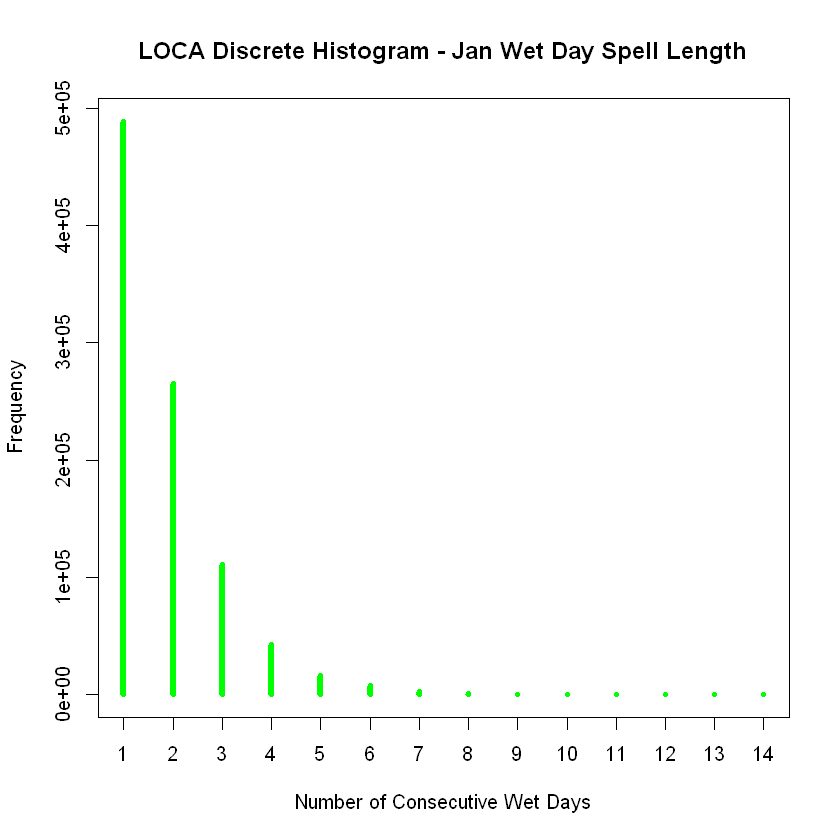

In [95]:
# our case is discrete so use this command
plot( table( dLOJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

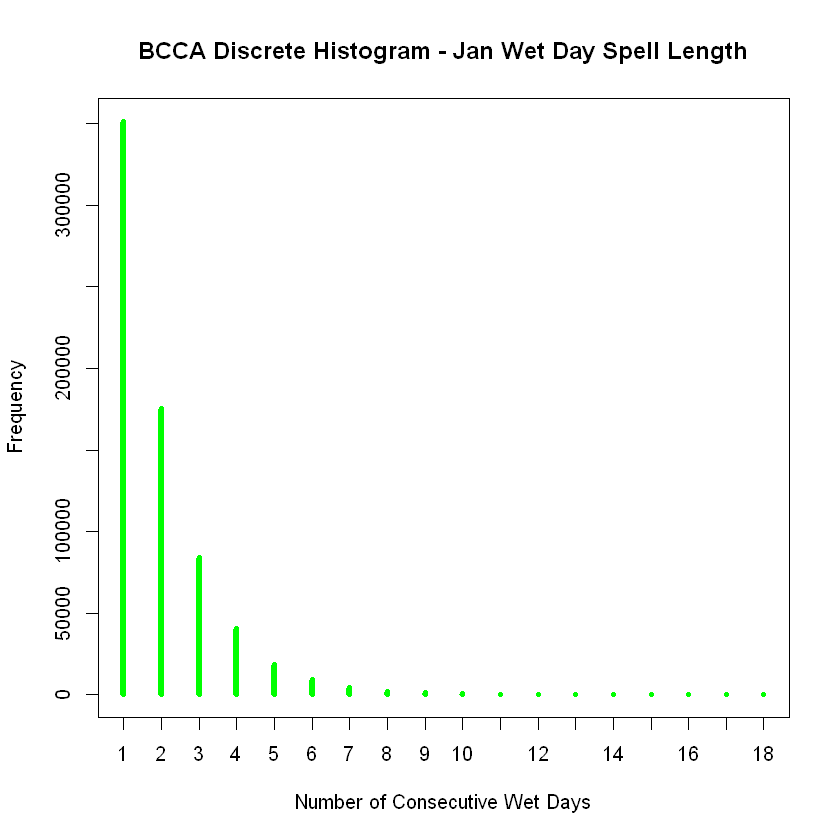

In [96]:
plot( table( dBCJan$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jan Wet Day Spell Length", 
      col="green" )

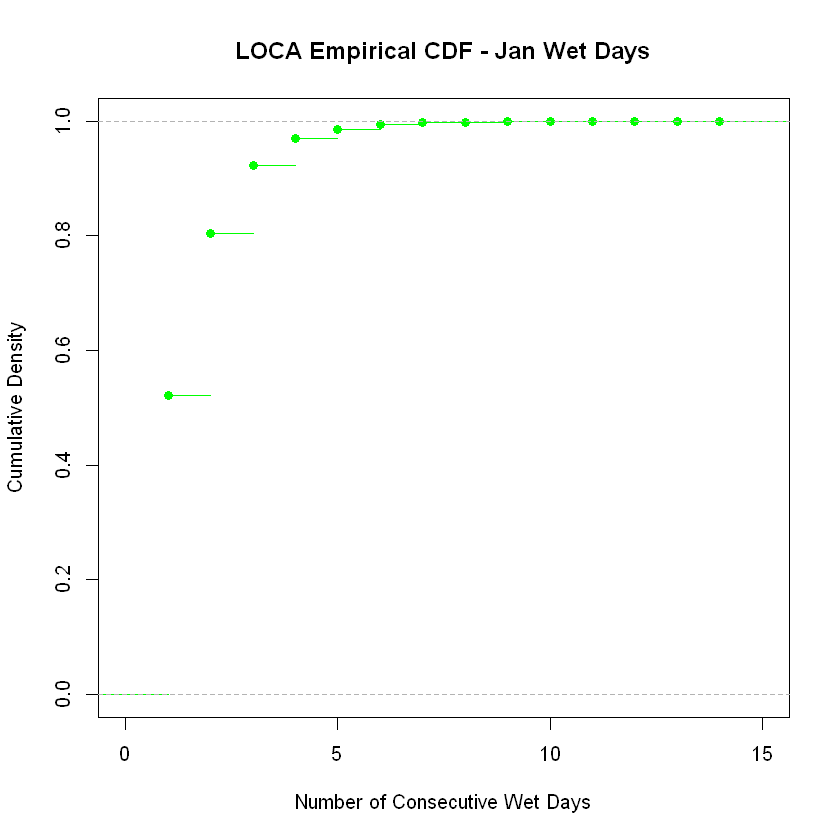

In [97]:
plot(ecdf(dLOJan$Wet_Count), main="LOCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

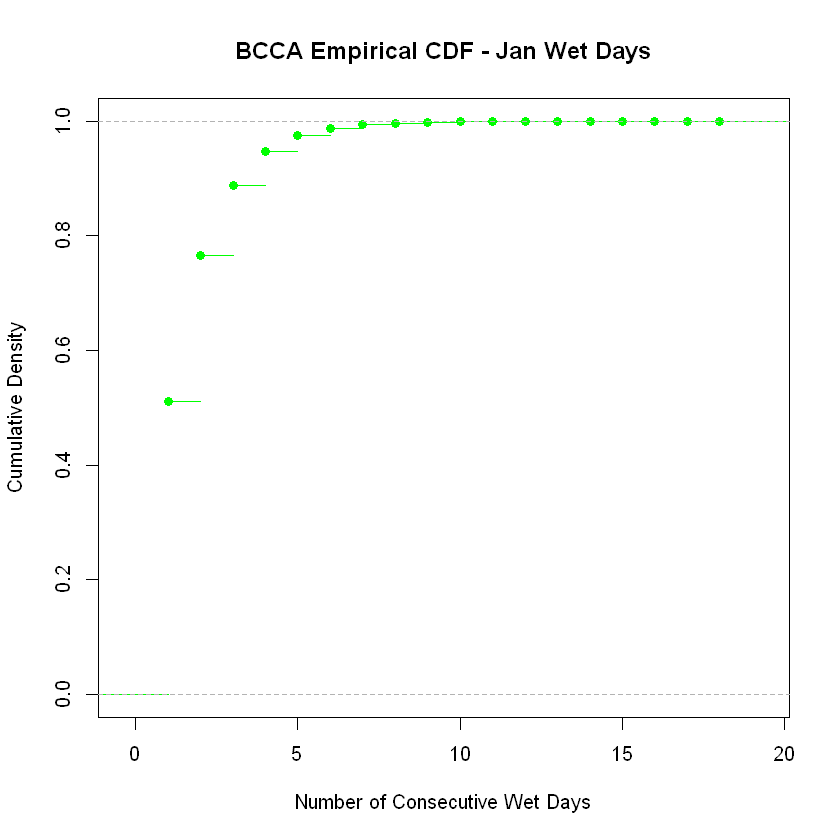

In [98]:
plot(ecdf(dBCJan$Wet_Count), main="BCCA Empirical CDF - Jan Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [99]:
dLOJanMax <- max( dLOJan$Wet_Count )
dLOJanMean <- mean( dLOJan$Wet_Count )
dLOJanVar <- var( dLOJan$Wet_Count )
dLOJanBNr <- dLOJanMean^2 / abs(dLOJanVar - dLOJanMean)
dLOJanTstNB <- rnbinom( 1000, mu=dLOJanMean, size=dLOJanBNr )

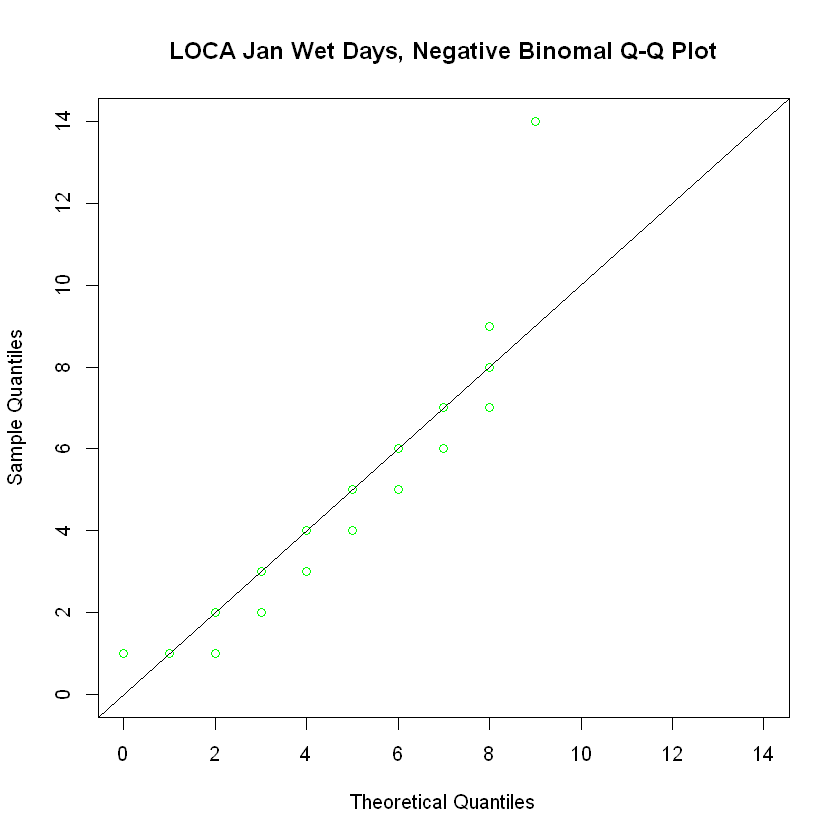

In [100]:
qqplot( dLOJanTstNB, dLOJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJanMax), ylim=c(0,dLOJanMax) )
abline( 0, 1)

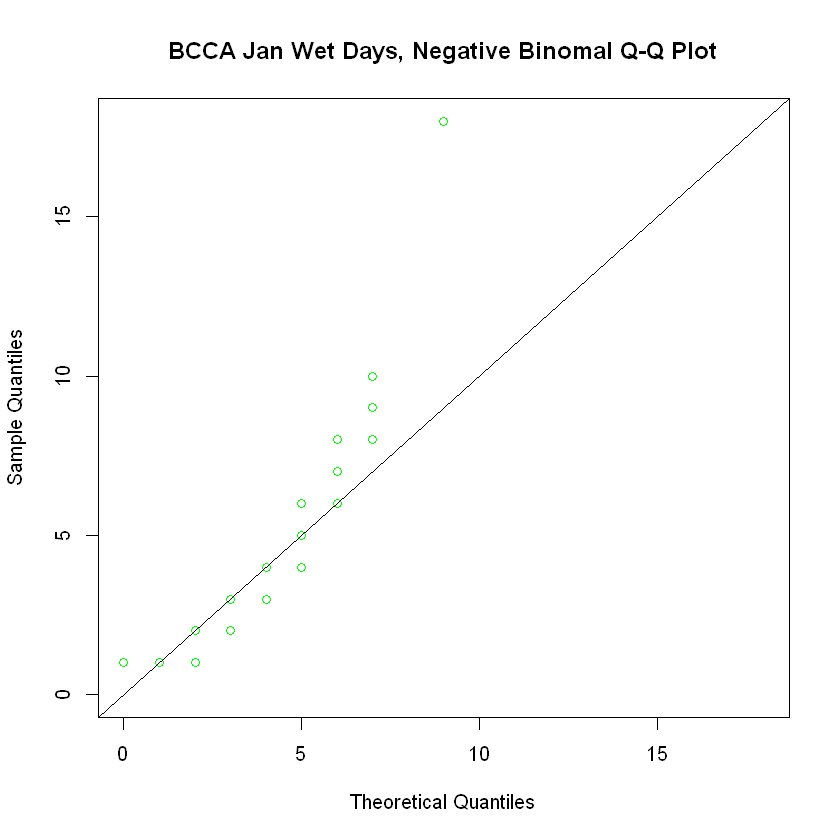

In [101]:
dBCJanMax <- max( dBCJan$Wet_Count )
dBCJanMean <- mean( dBCJan$Wet_Count )
dBCJanVar <- var( dBCJan$Wet_Count )
dBCJanBNr <- dBCJanMean^2 / abs(dBCJanVar - dBCJanMean)
dBCJanTstNB <- rnbinom( 1000, mu=dBCJanMean, size=dBCJanBNr )
qqplot( dBCJanTstNB, dBCJan$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jan Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJanMax), ylim=c(0,dBCJanMax) )
abline( 0, 1)

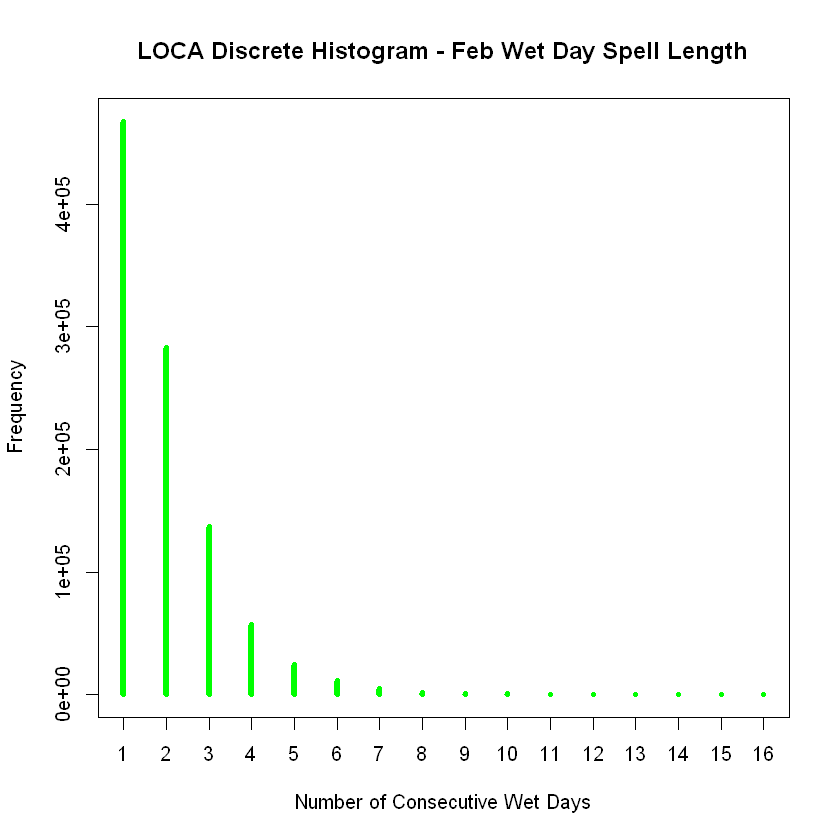

In [102]:
# our case is discrete so use this command
plot( table( dLOFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

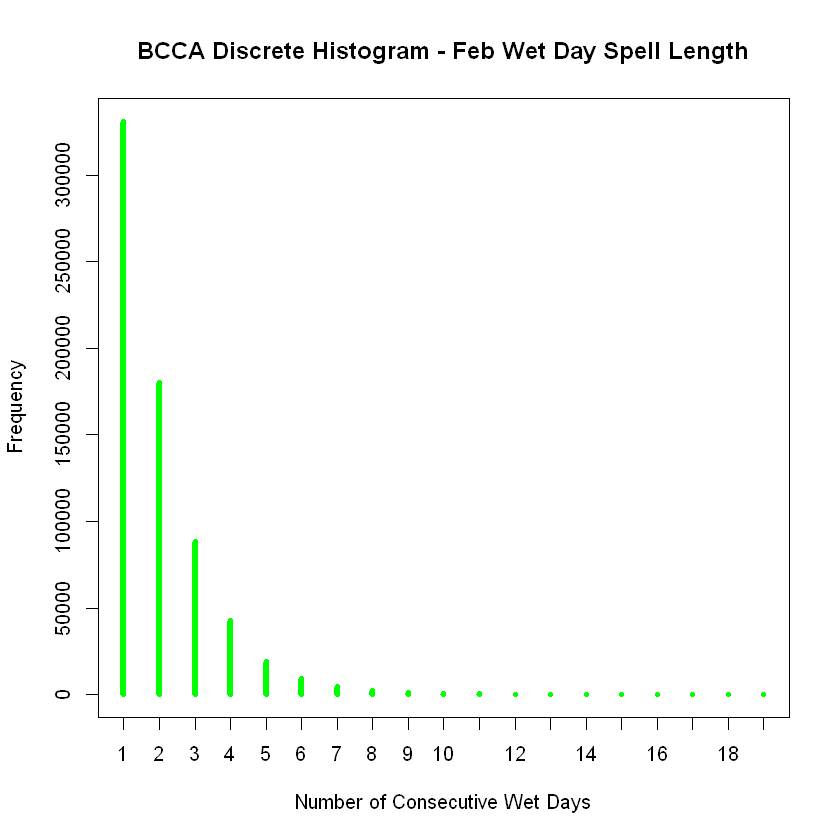

In [103]:
plot( table( dBCFeb$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Feb Wet Day Spell Length", 
      col="green" )

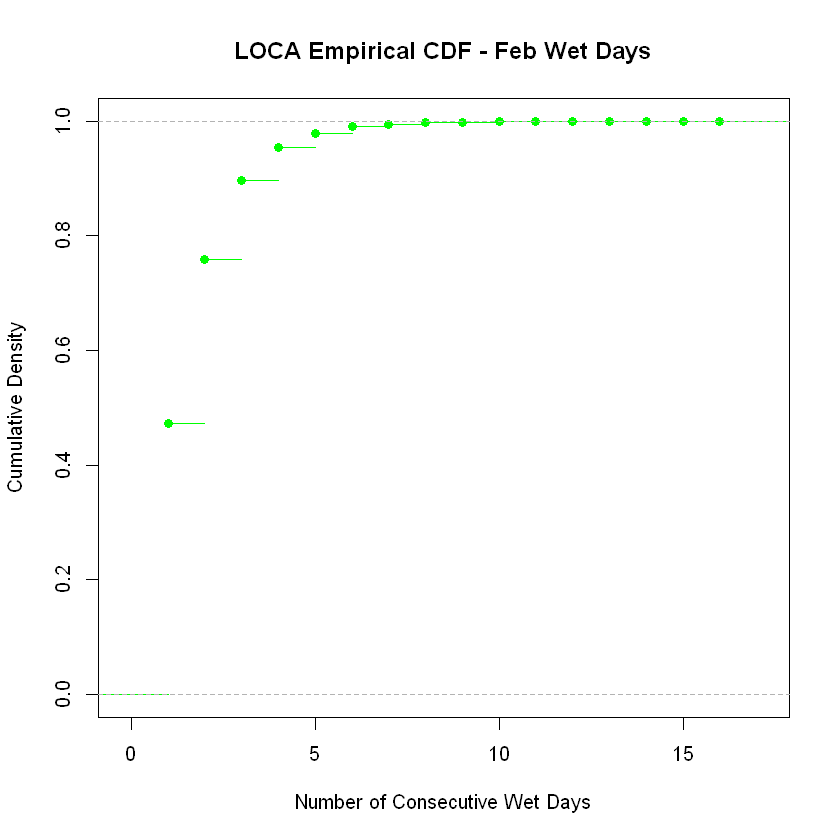

In [104]:
plot(ecdf(dLOFeb$Wet_Count), main="LOCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

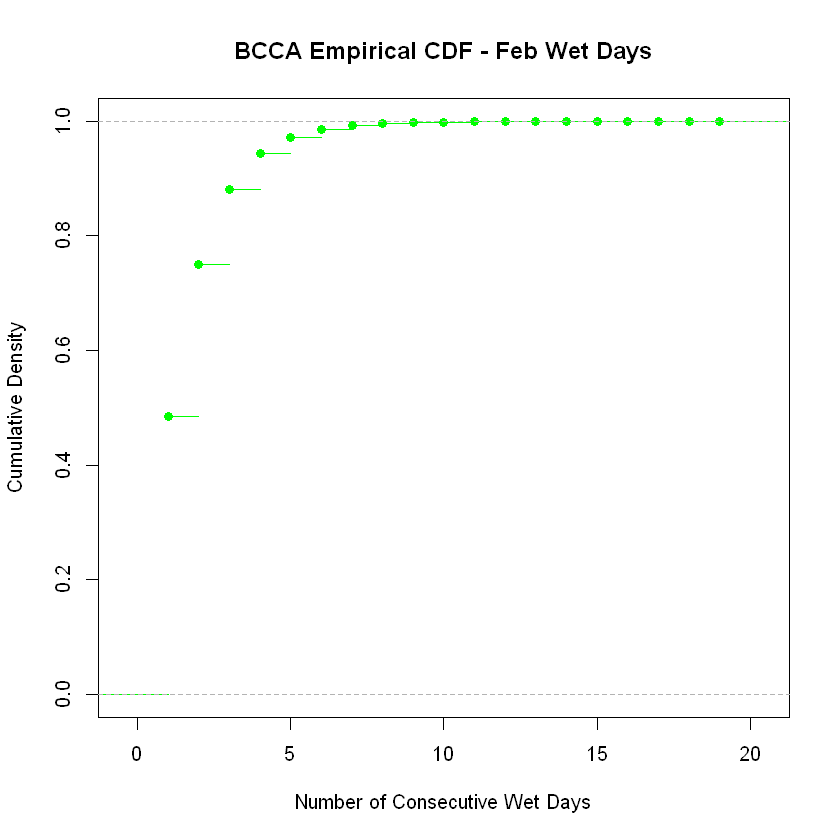

In [105]:
plot(ecdf(dBCFeb$Wet_Count), main="BCCA Empirical CDF - Feb Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

In [106]:
#dLOFeb$Wet_Count

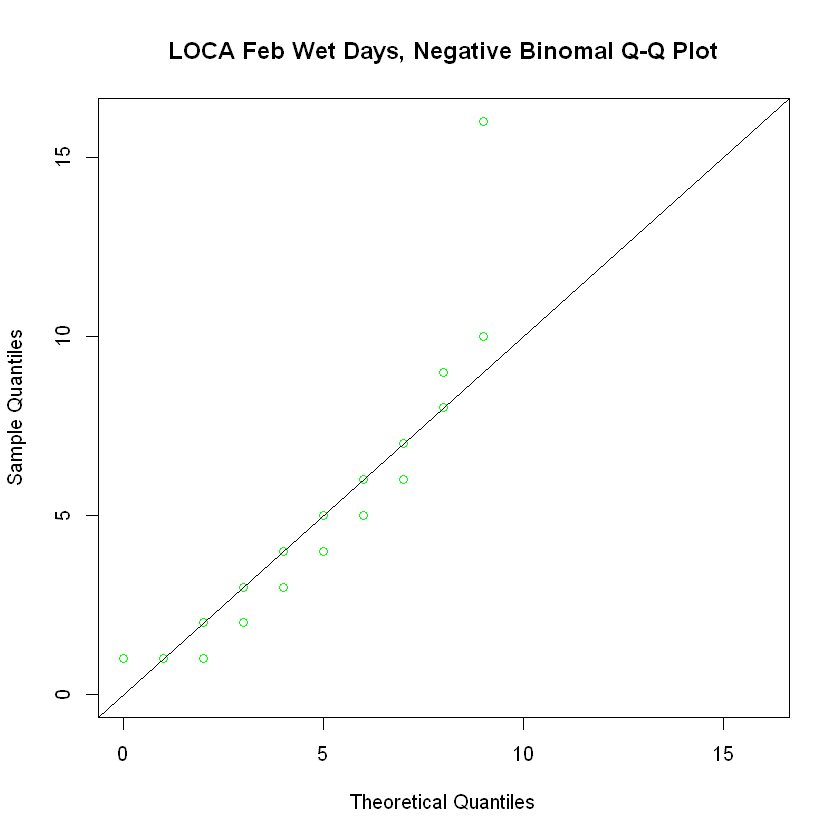

In [107]:
dLOFebMax <- max( dLOFeb$Wet_Count )
dLOFebMean <- mean( dLOFeb$Wet_Count )
dLOFebVar <- var( dLOFeb$Wet_Count )
dLOFebBNr <- dLOFebMean^2 / abs(dLOFebVar - dLOFebMean)
dLOFebTstNB <- rnbinom( 1000, mu=dLOFebMean, size=dLOFebBNr )
qqplot( dLOFebTstNB, dLOFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOFebMax), ylim=c(0,dLOFebMax) )
abline( 0, 1)

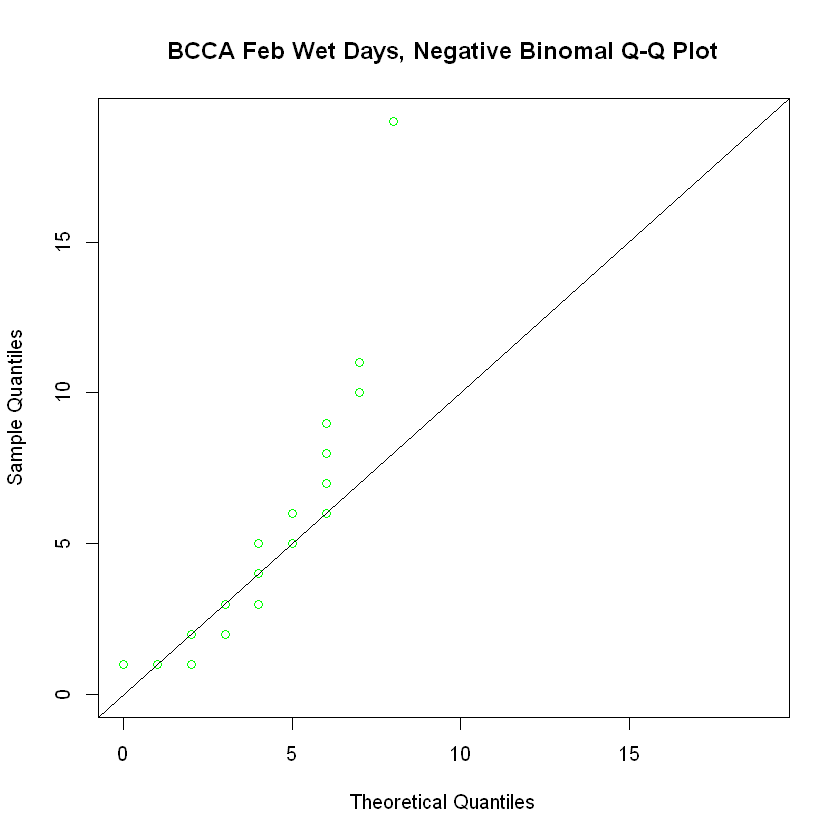

In [108]:
dBCFebMax <- max( dBCFeb$Wet_Count )
dBCFebMean <- mean( dBCFeb$Wet_Count )
dBCFebVar <- var( dBCFeb$Wet_Count )
dBCFebBNr <- dBCFebMean^2 / abs(dBCFebVar - dBCFebMean)
dBCFebTstNB <- rnbinom( 1000, mu=dBCFebMean, size=dBCFebBNr )
qqplot( dBCFebTstNB, dBCFeb$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Feb Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCFebMax), ylim=c(0,dBCFebMax) )
abline( 0, 1)

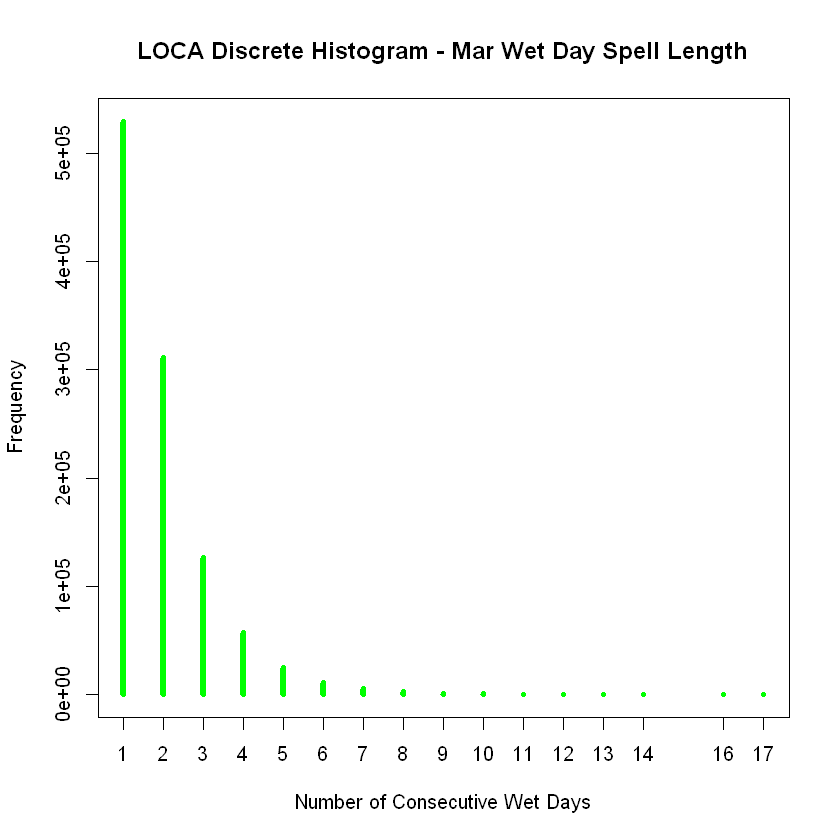

In [109]:
# our case is discrete so use this command
plot( table( dLOMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

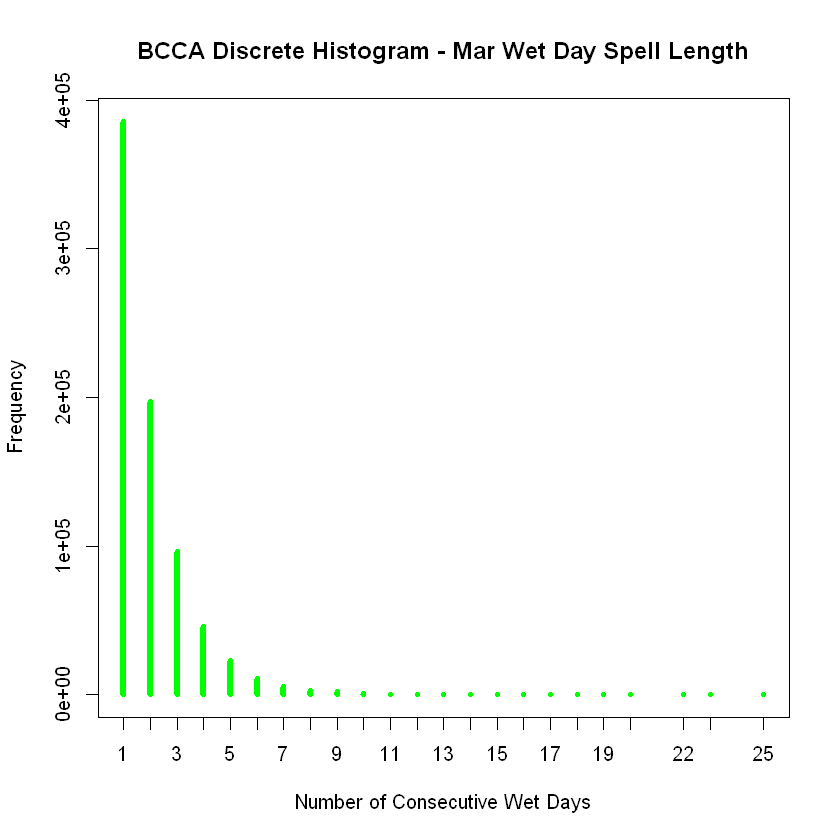

In [110]:
plot( table( dBCMar$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Mar Wet Day Spell Length", 
      col="green" )

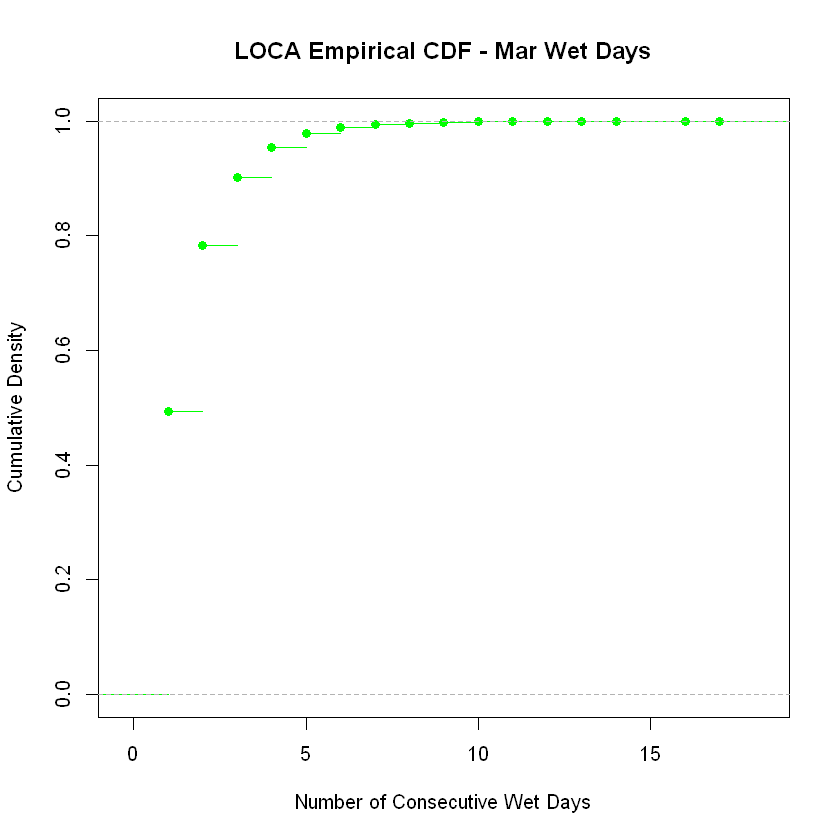

In [111]:
plot(ecdf(dLOMar$Wet_Count), main="LOCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

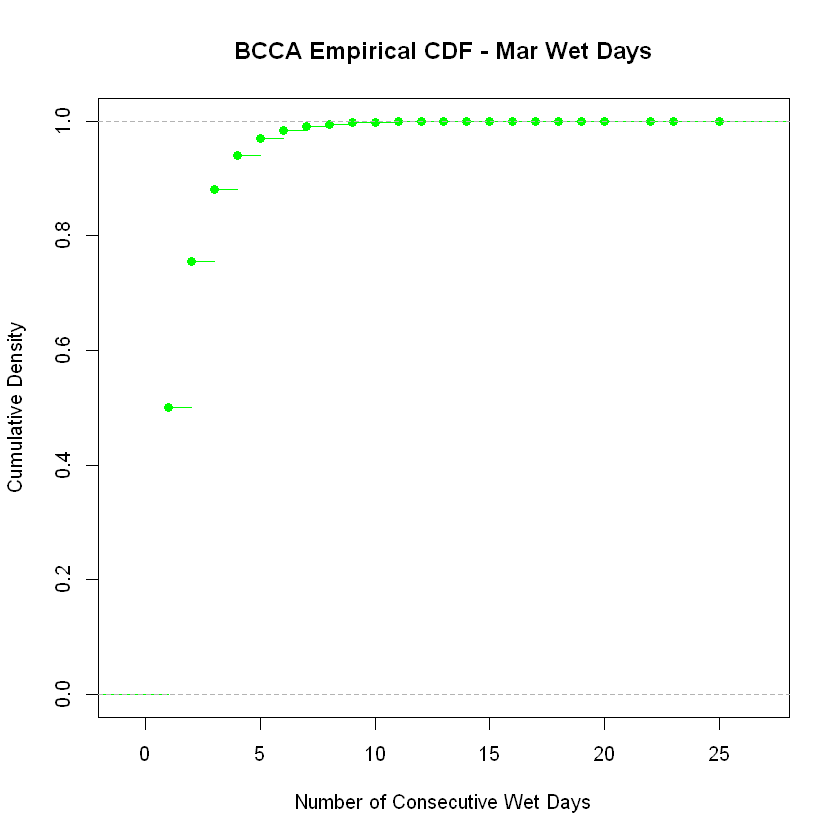

In [112]:
plot(ecdf(dBCMar$Wet_Count), main="BCCA Empirical CDF - Mar Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

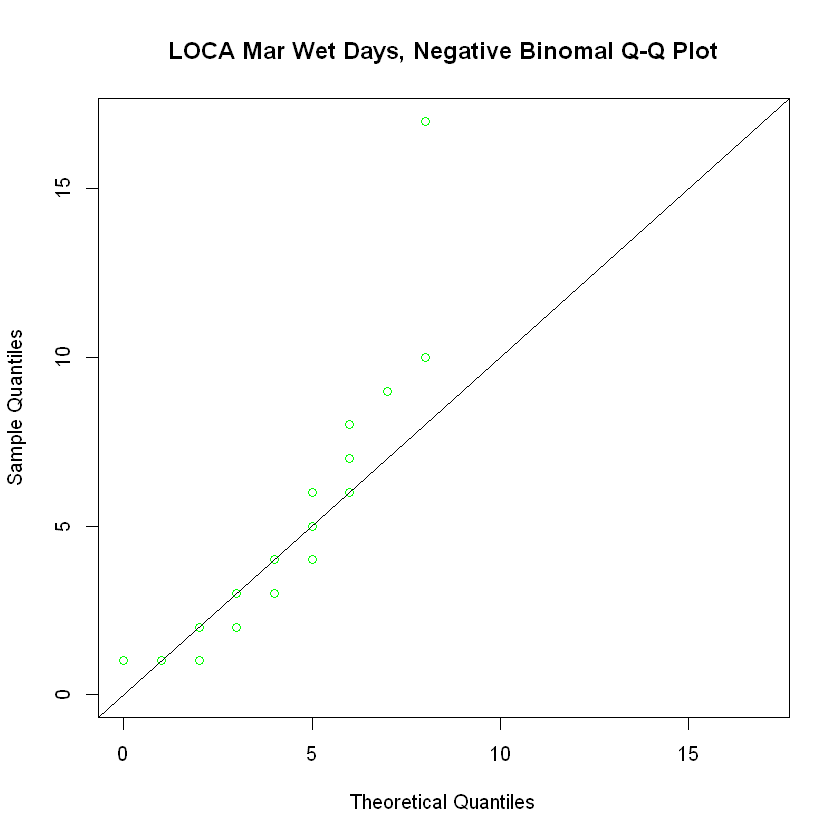

In [113]:
dLOMarMax <- max( dLOMar$Wet_Count )
dLOMarMean <- mean( dLOMar$Wet_Count )
dLOMarVar <- var( dLOMar$Wet_Count )
dLOMarBNr <- dLOMarMean^2 / abs(dLOMarVar - dLOMarMean)
dLOMarTstNB <- rnbinom( 1000, mu=dLOMarMean, size=dLOMarBNr )
qqplot( dLOMarTstNB, dLOMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMarMax), ylim=c(0,dLOMarMax) )
abline( 0, 1)

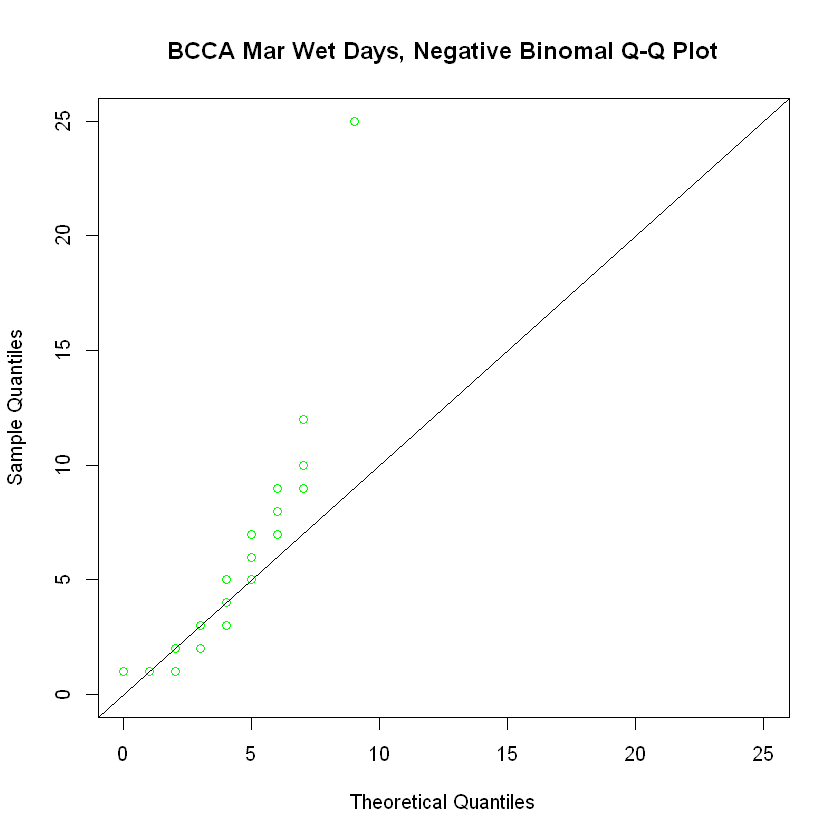

In [114]:
dBCMarMax <- max( dBCMar$Wet_Count )
dBCMarMean <- mean( dBCMar$Wet_Count )
dBCMarVar <- var( dBCMar$Wet_Count )
dBCMarBNr <- dBCMarMean^2 / abs(dBCMarVar - dBCMarMean)
dBCMarTstNB <- rnbinom( 1000, mu=dBCMarMean, size=dBCMarBNr )
qqplot( dBCMarTstNB, dBCMar$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Mar Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMarMax), ylim=c(0,dBCMarMax) )
abline( 0, 1)

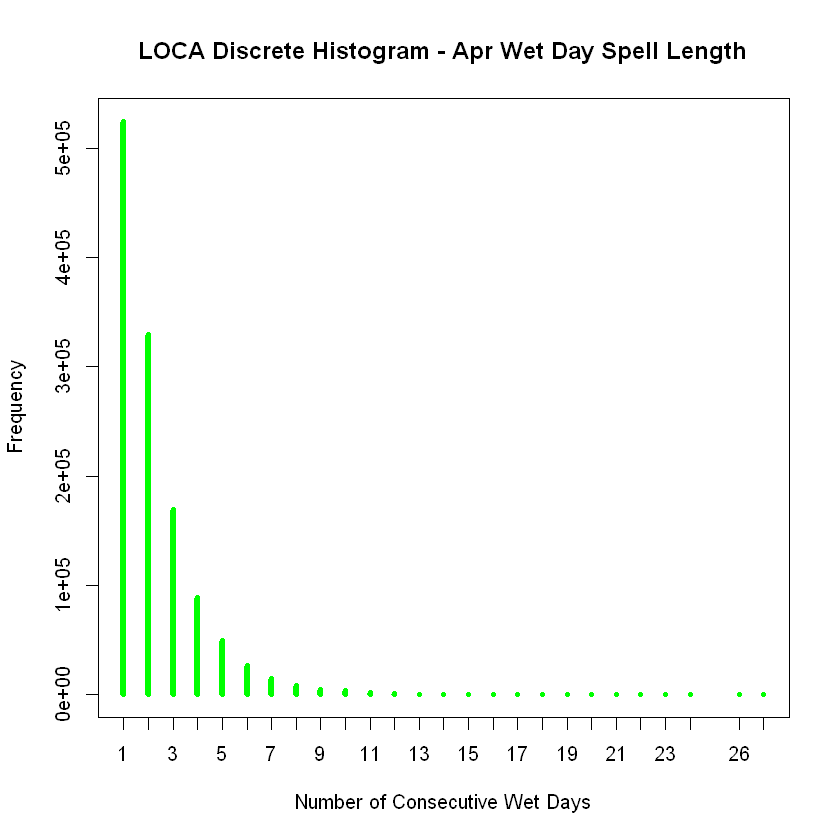

In [115]:
# our case is discrete so use this command
plot( table( dLOApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

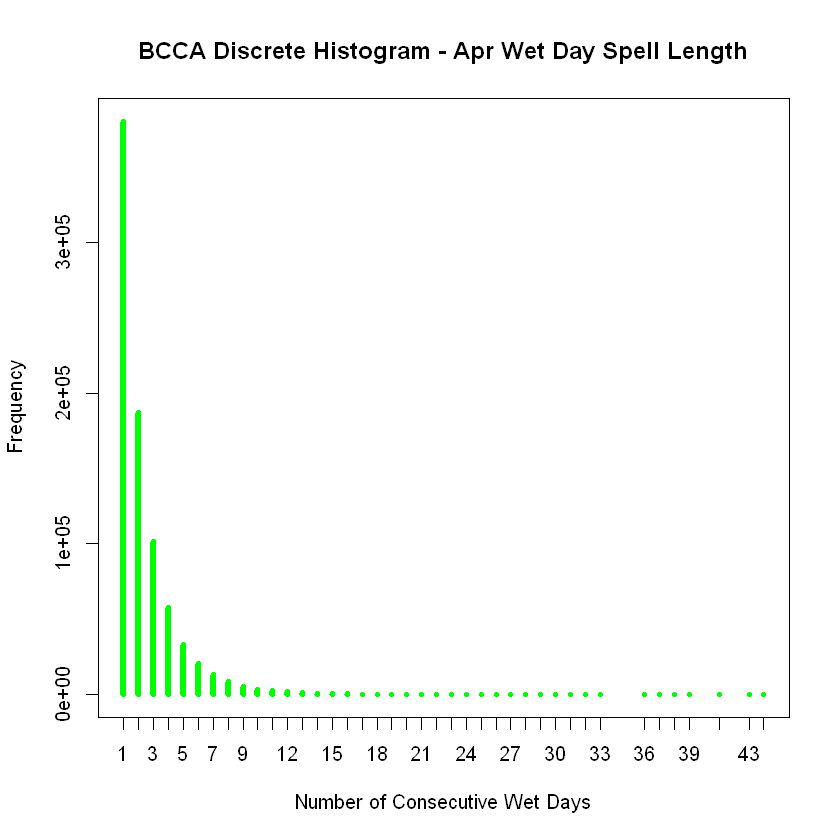

In [116]:
plot( table( dBCApr$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Apr Wet Day Spell Length", 
      col="green" )

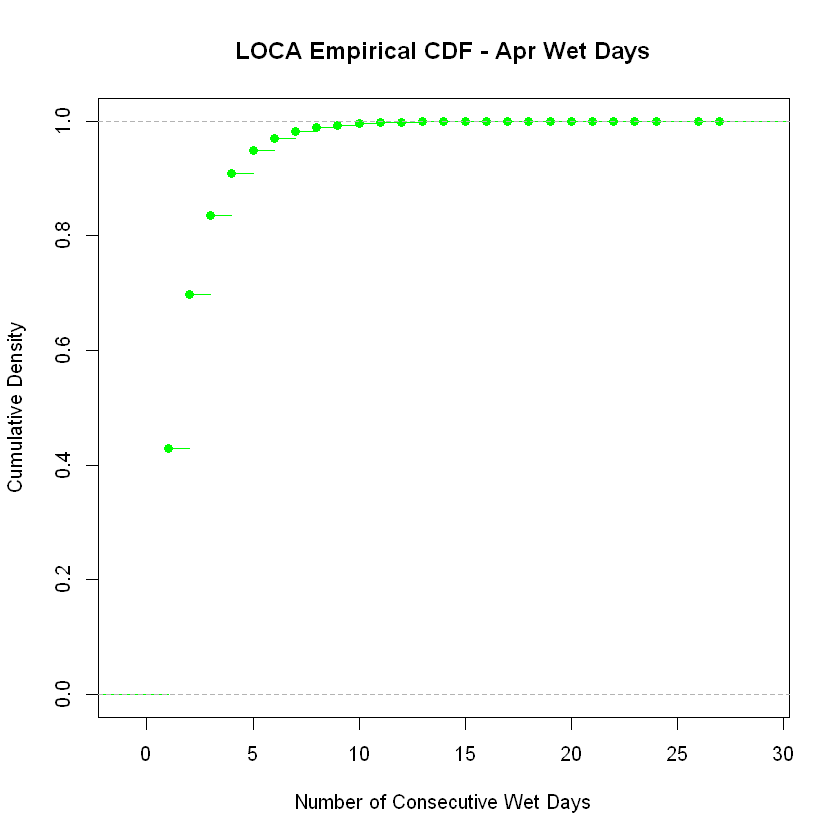

In [117]:
plot(ecdf(dLOApr$Wet_Count), main="LOCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

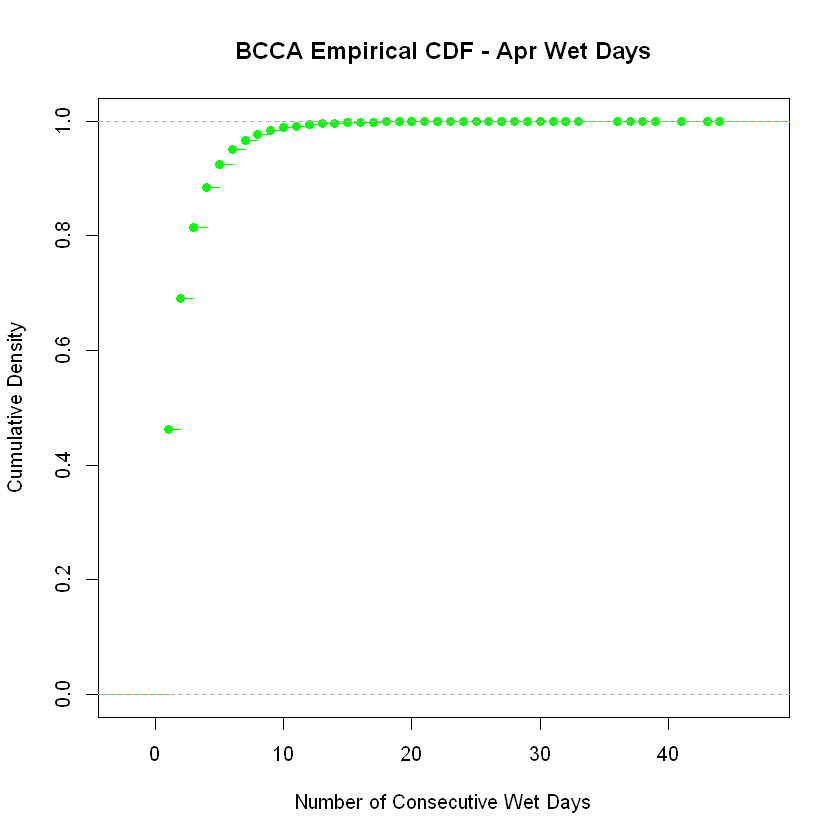

In [118]:
plot(ecdf(dBCApr$Wet_Count), main="BCCA Empirical CDF - Apr Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

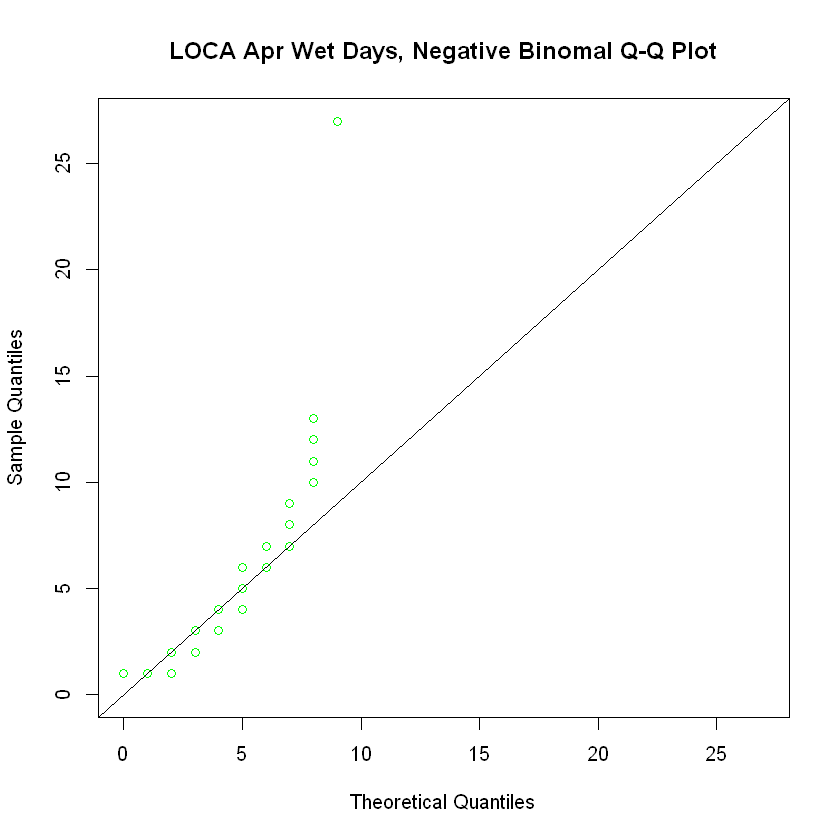

In [119]:
dLOAprMax <- max( dLOApr$Wet_Count )
dLOAprMean <- mean( dLOApr$Wet_Count )
dLOAprVar <- var( dLOApr$Wet_Count )
dLOAprBNr <- dLOAprMean^2 / abs(dLOAprVar - dLOAprMean)
dLOAprTstNB <- rnbinom( 1000, mu=dLOAprMean, size=dLOAprBNr )
qqplot( dLOAprTstNB, dLOApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAprMax), ylim=c(0,dLOAprMax) )
abline( 0, 1)

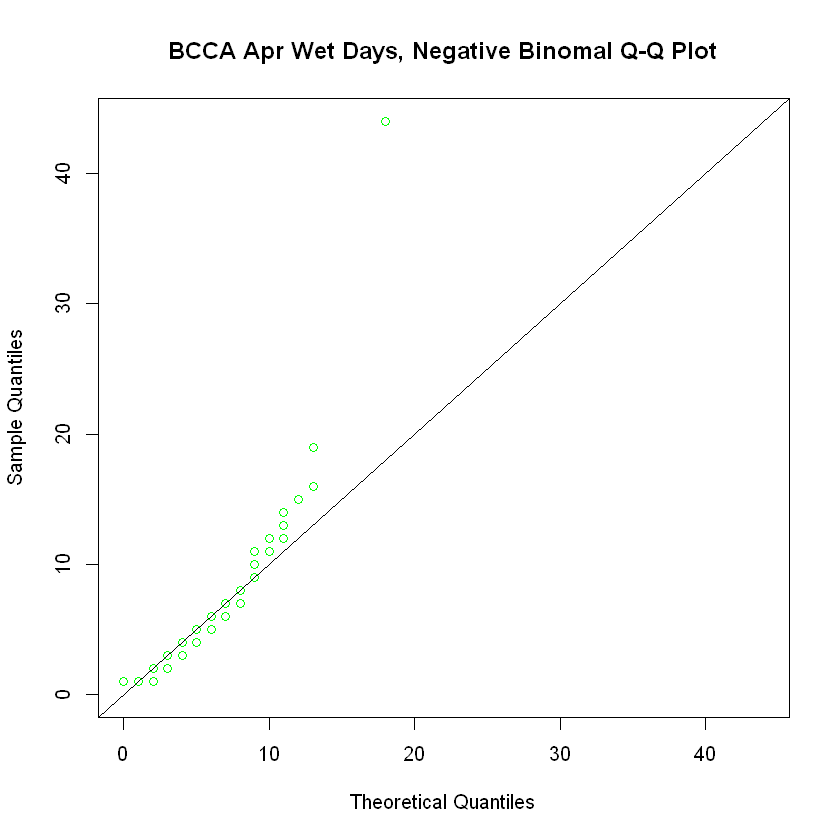

In [120]:
dBCAprMax <- max( dBCApr$Wet_Count )
dBCAprMean <- mean( dBCApr$Wet_Count )
dBCAprVar <- var( dBCApr$Wet_Count )
dBCAprBNr <- dBCAprMean^2 / abs(dBCAprVar - dBCAprMean)
dBCAprTstNB <- rnbinom( 1000, mu=dBCAprMean, size=dBCAprBNr )
qqplot( dBCAprTstNB, dBCApr$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Apr Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAprMax), ylim=c(0,dBCAprMax) )
abline( 0, 1)

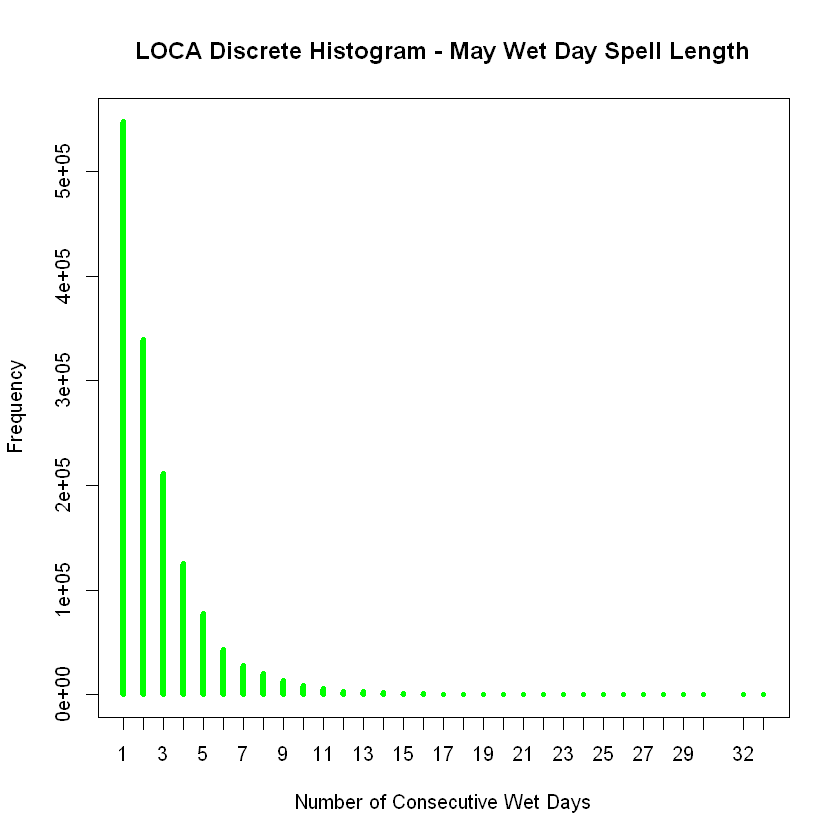

In [121]:
# our case is discrete so use this command
plot( table( dLOMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

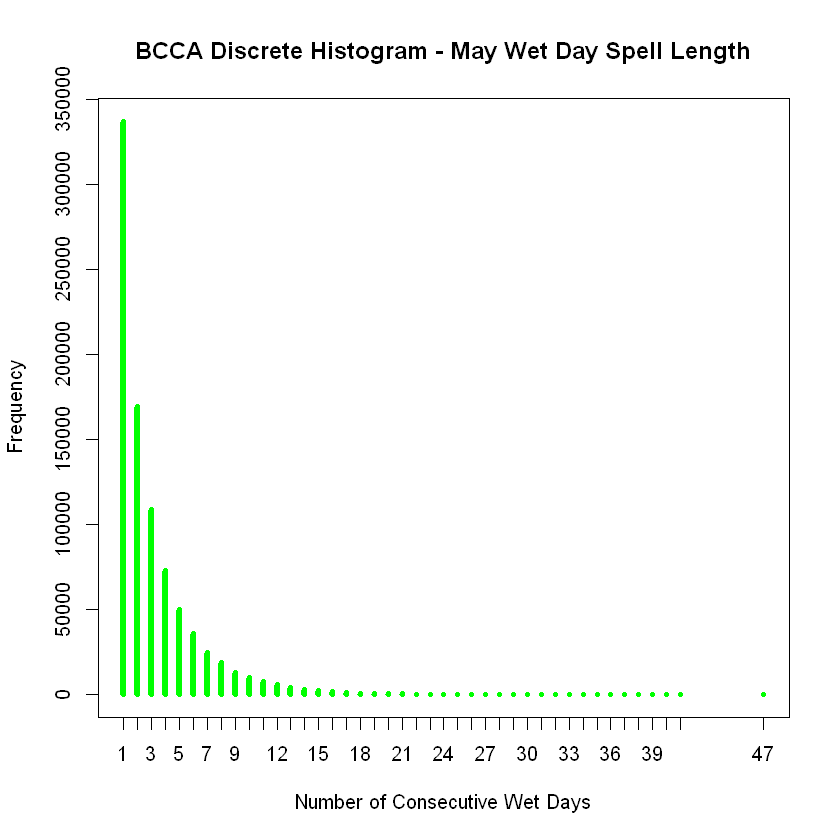

In [122]:
plot( table( dBCMay$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - May Wet Day Spell Length", 
      col="green" )

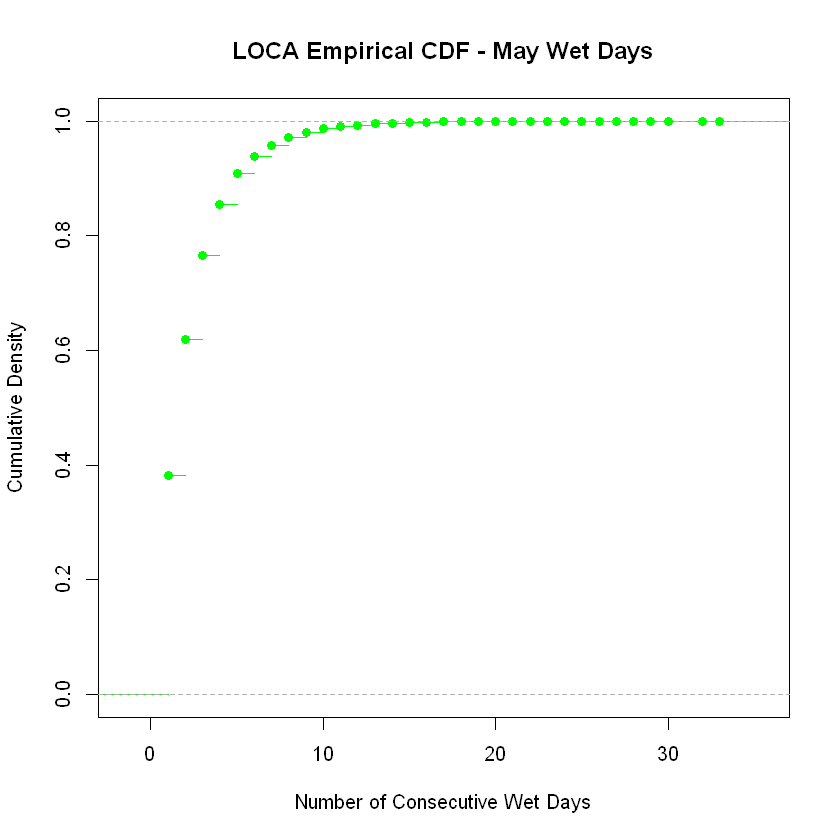

In [123]:
plot(ecdf(dLOMay$Wet_Count), main="LOCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

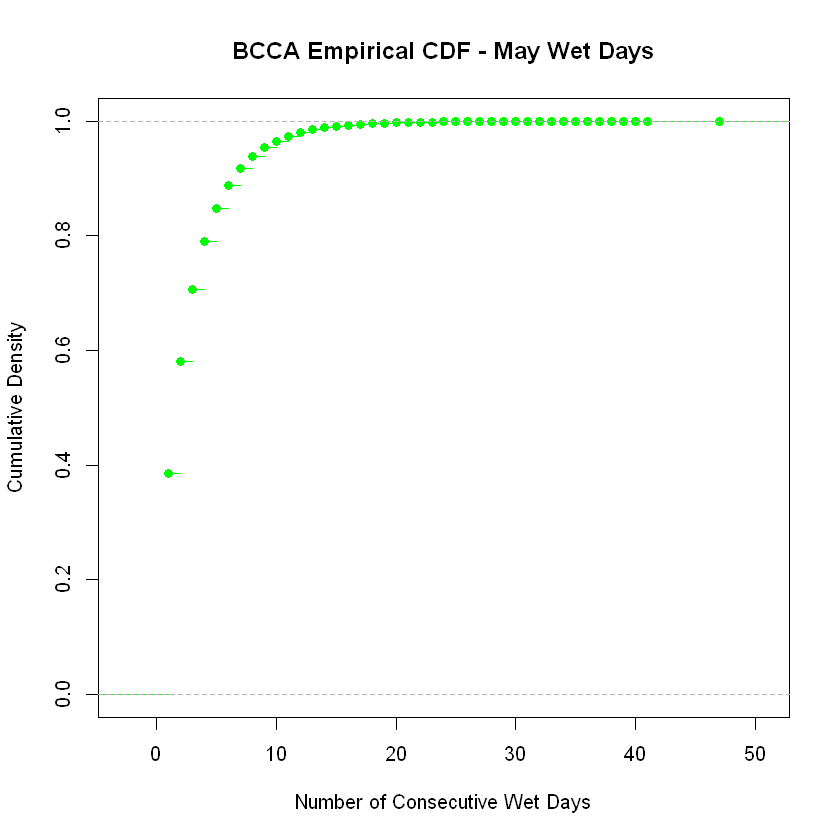

In [124]:
plot(ecdf(dBCMay$Wet_Count), main="BCCA Empirical CDF - May Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

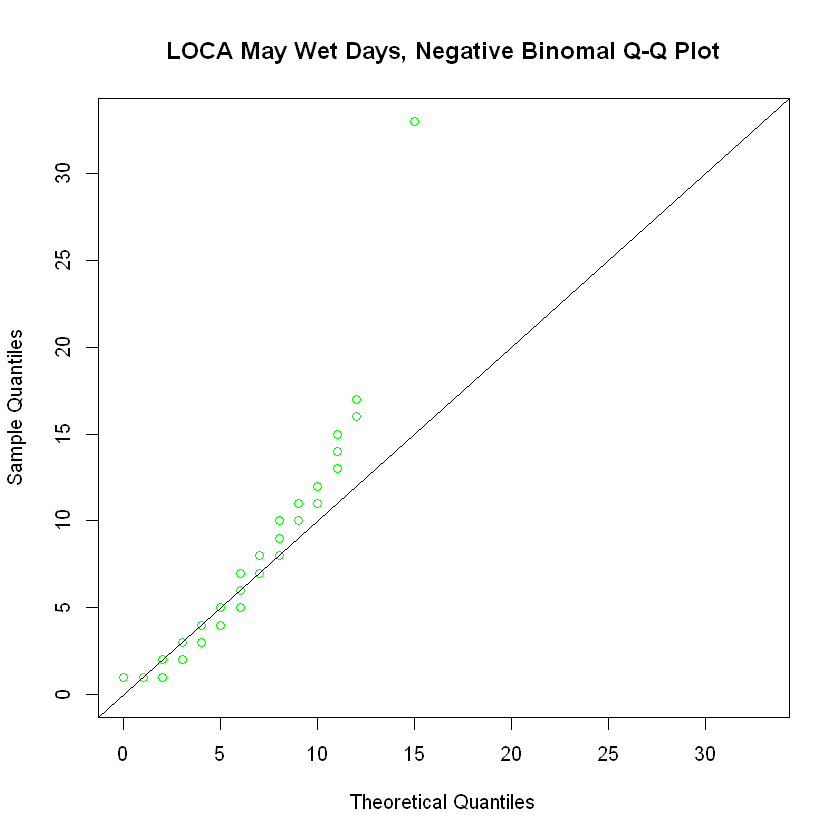

In [125]:
dLOMayMax <- max( dLOMay$Wet_Count )
dLOMayMean <- mean( dLOMay$Wet_Count )
dLOMayVar <- var( dLOMay$Wet_Count )
dLOMayBNr <- dLOMayMean^2 / abs(dLOMayVar - dLOMayMean)
dLOMayTstNB <- rnbinom( 1000, mu=dLOMayMean, size=dLOMayBNr )
qqplot( dLOMayTstNB, dLOMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOMayMax), ylim=c(0,dLOMayMax) )
abline( 0, 1)

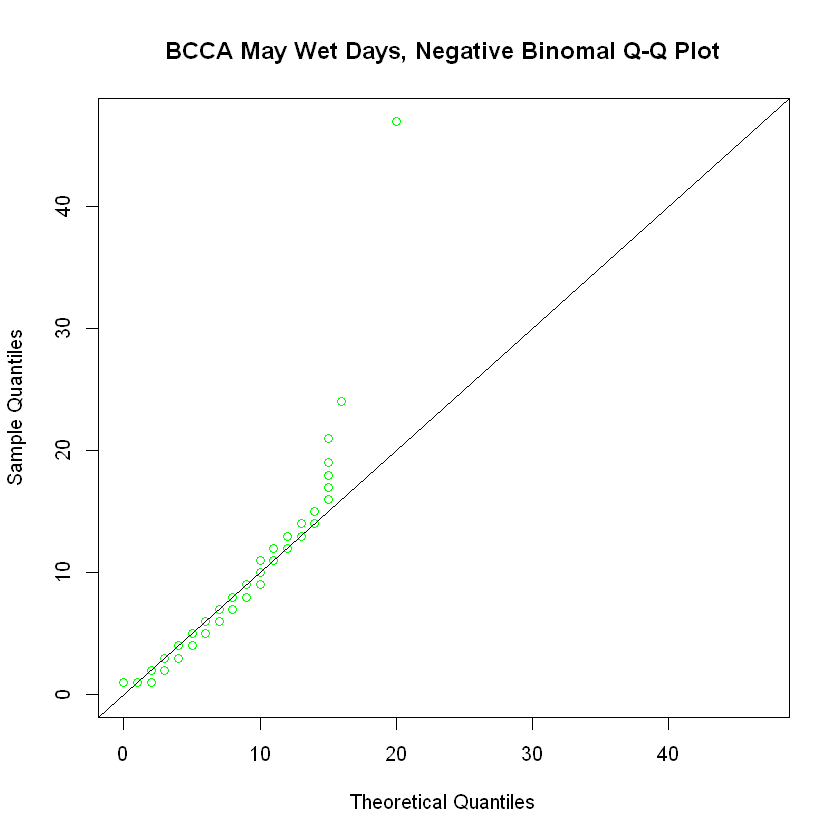

In [126]:
dBCMayMax <- max( dBCMay$Wet_Count )
dBCMayMean <- mean( dBCMay$Wet_Count )
dBCMayVar <- var( dBCMay$Wet_Count )
dBCMayBNr <- dBCMayMean^2 / abs(dBCMayVar - dBCMayMean)
dBCMayTstNB <- rnbinom( 1000, mu=dBCMayMean, size=dBCMayBNr )
qqplot( dBCMayTstNB, dBCMay$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA May Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCMayMax), ylim=c(0,dBCMayMax) )
abline( 0, 1)

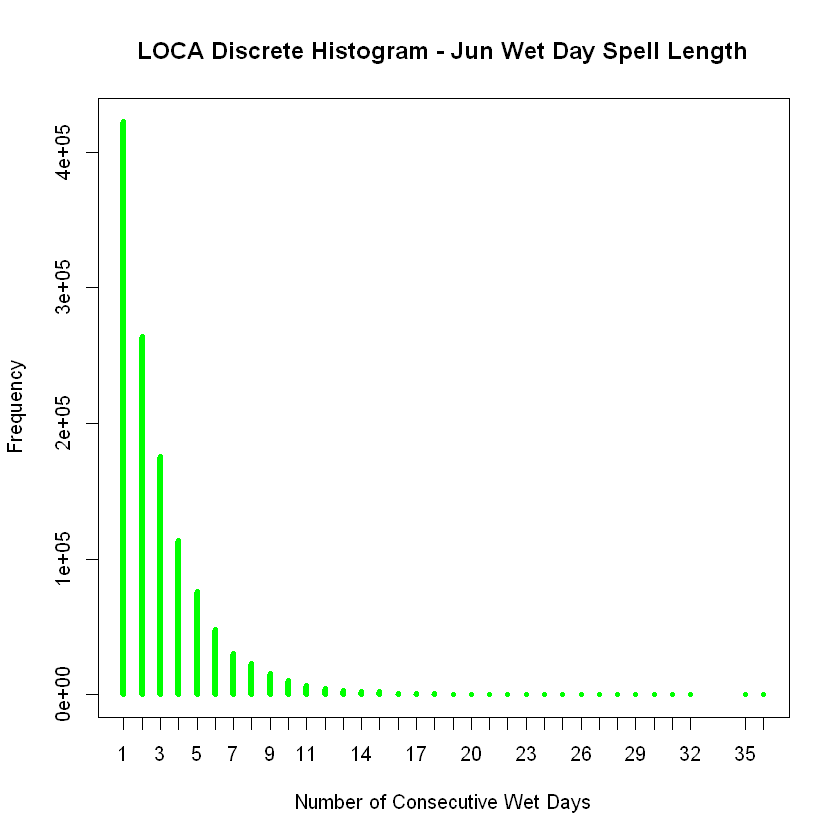

In [127]:
# our case is discrete so use this command
plot( table( dLOJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

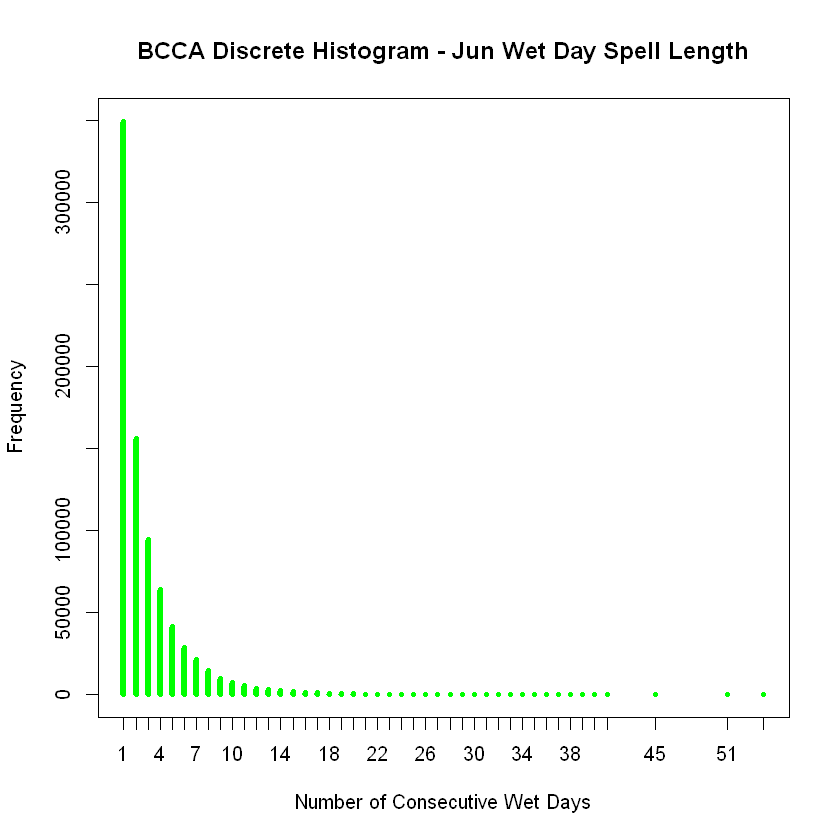

In [128]:
plot( table( dBCJun$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jun Wet Day Spell Length", 
      col="green" )

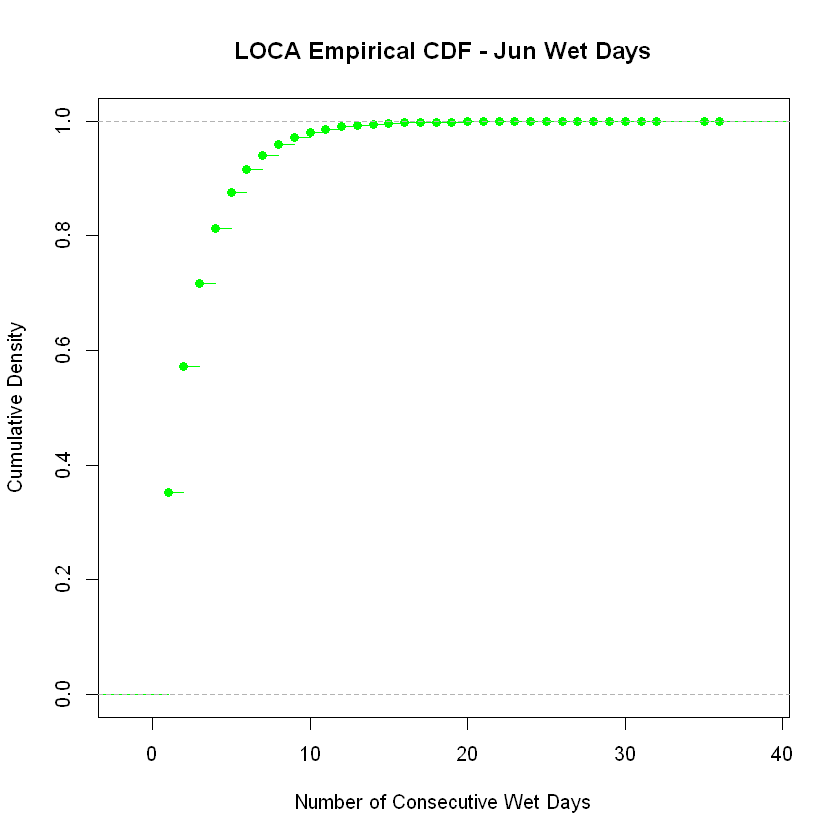

In [129]:
plot(ecdf(dLOJun$Wet_Count), main="LOCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

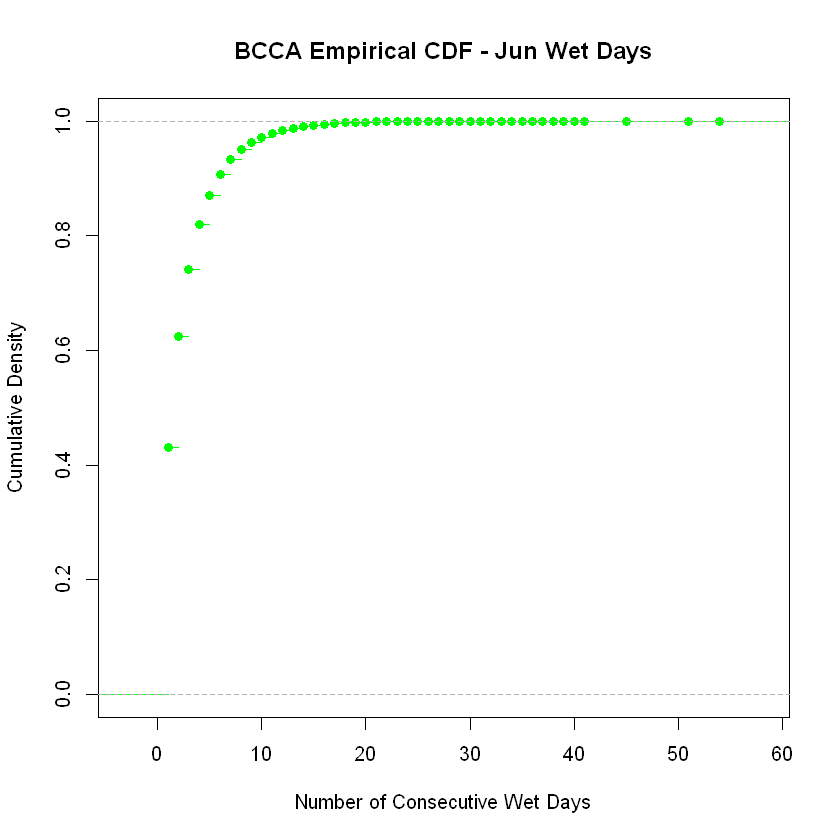

In [130]:
plot(ecdf(dBCJun$Wet_Count), main="BCCA Empirical CDF - Jun Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

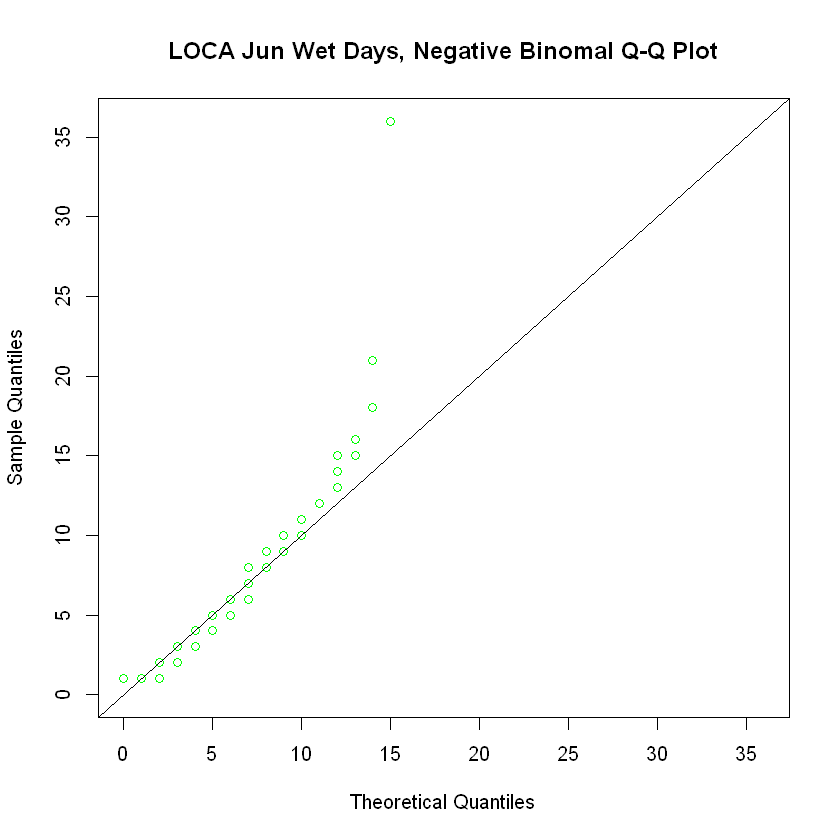

In [131]:
dLOJunMax <- max( dLOJun$Wet_Count )
dLOJunMean <- mean( dLOJun$Wet_Count )
dLOJunVar <- var( dLOJun$Wet_Count )
dLOJunBNr <- dLOJunMean^2 / abs(dLOJunVar - dLOJunMean)
dLOJunTstNB <- rnbinom( 1000, mu=dLOJunMean, size=dLOJunBNr )
qqplot( dLOJunTstNB, dLOJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJunMax), ylim=c(0,dLOJunMax) )
abline( 0, 1)

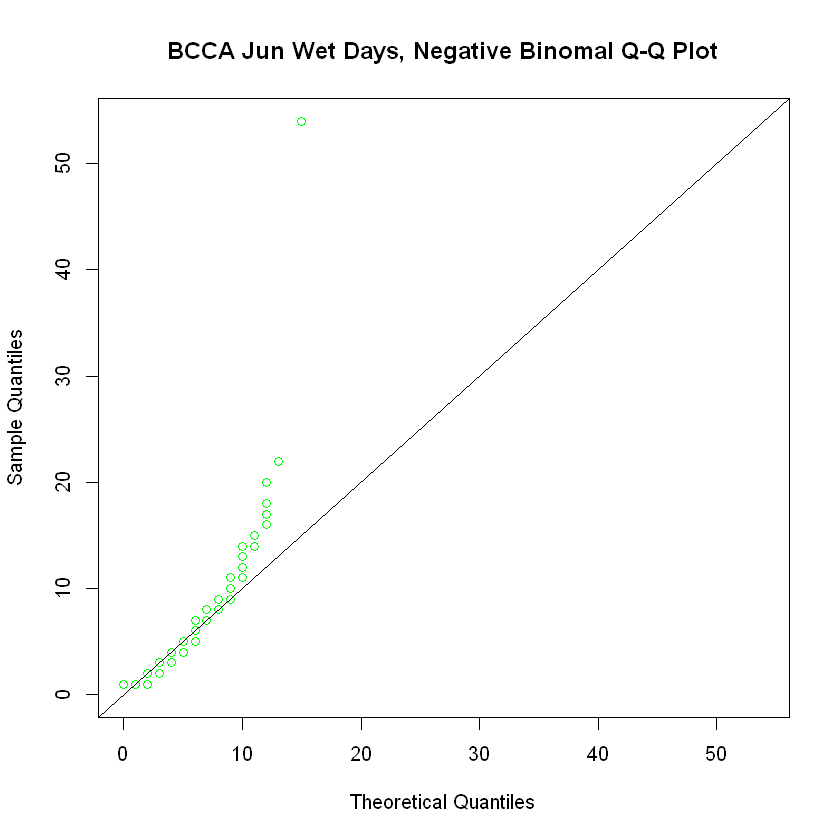

In [132]:
dBCJunMax <- max( dBCJun$Wet_Count )
dBCJunMean <- mean( dBCJun$Wet_Count )
dBCJunVar <- var( dBCJun$Wet_Count )
dBCJunBNr <- dBCJunMean^2 / abs(dBCJunVar - dBCJunMean)
dBCJunTstNB <- rnbinom( 1000, mu=dBCJunMean, size=dBCJunBNr )
qqplot( dBCJunTstNB, dBCJun$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jun Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJunMax), ylim=c(0,dBCJunMax) )
abline( 0, 1)

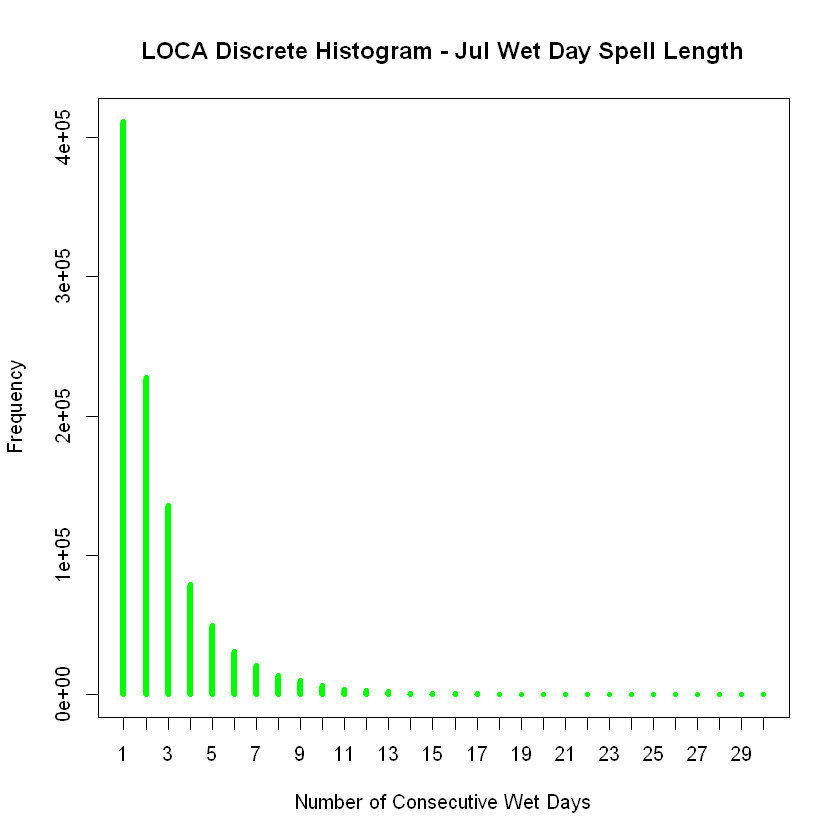

In [133]:
# our case is discrete so use this command
plot( table( dLOJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

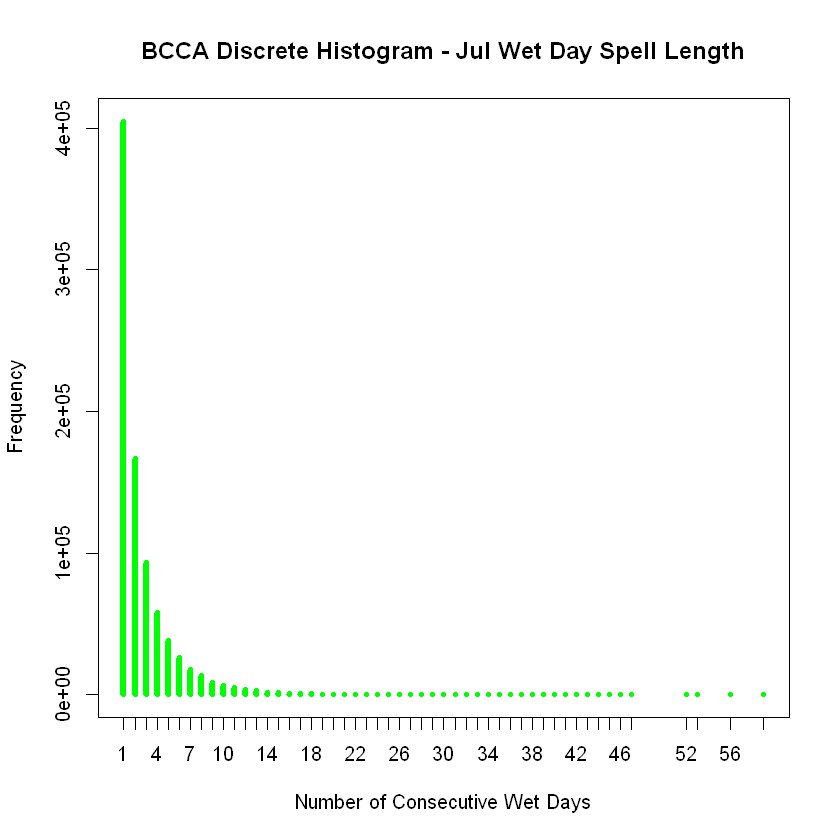

In [134]:
plot( table( dBCJul$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Jul Wet Day Spell Length", 
      col="green" )

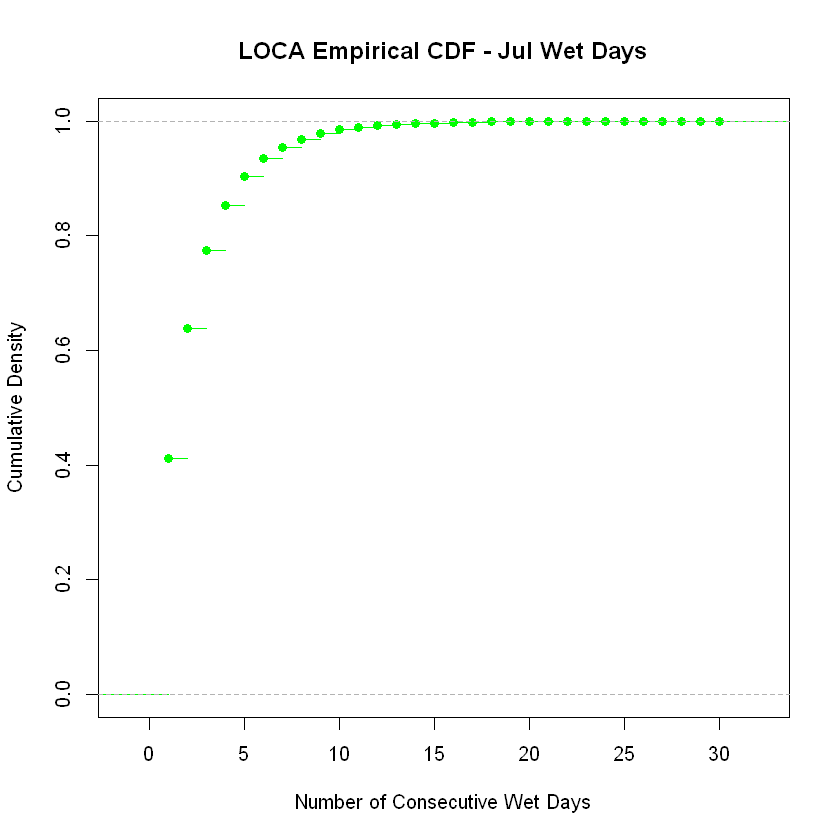

In [135]:
plot(ecdf(dLOJul$Wet_Count), main="LOCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

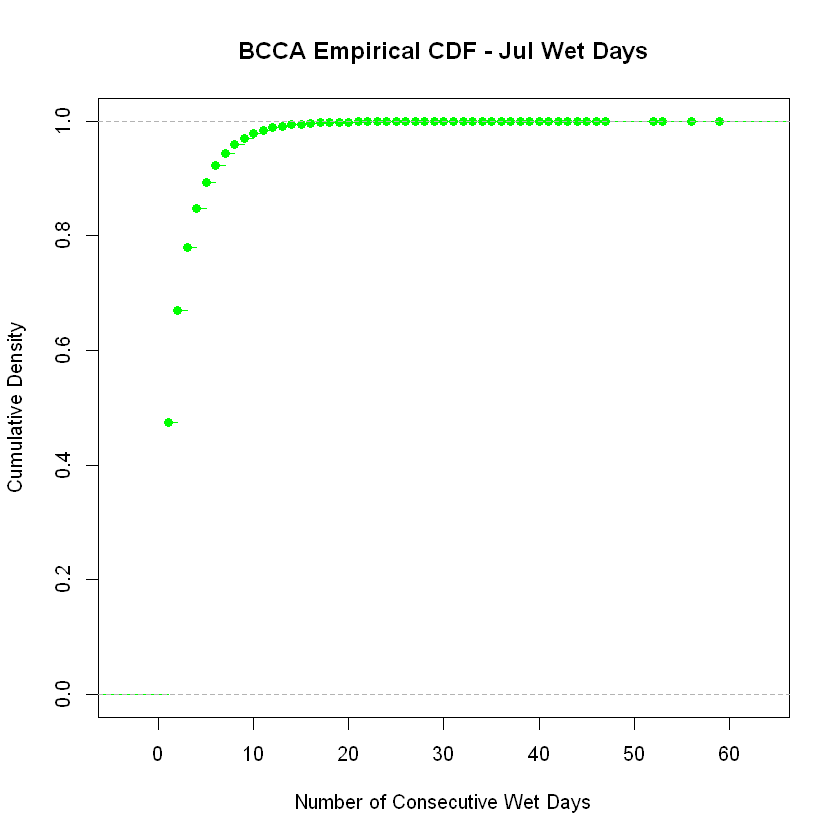

In [136]:
plot(ecdf(dBCJul$Wet_Count), main="BCCA Empirical CDF - Jul Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

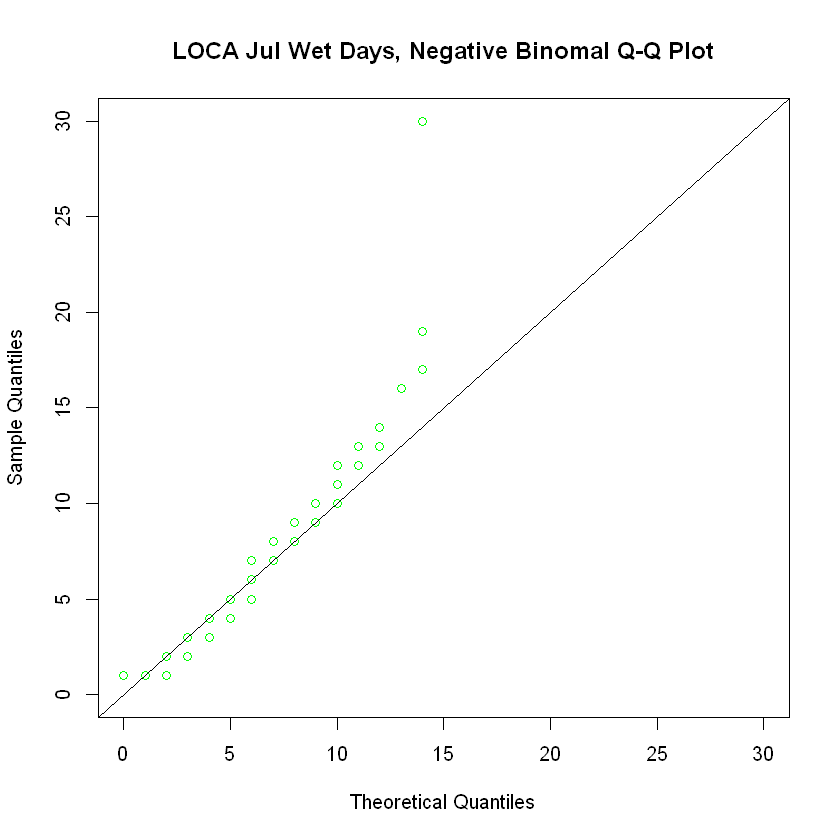

In [137]:
dLOJulMax <- max( dLOJul$Wet_Count )
dLOJulMean <- mean( dLOJul$Wet_Count )
dLOJulVar <- var( dLOJul$Wet_Count )
dLOJulBNr <- dLOJulMean^2 / abs(dLOJulVar - dLOJulMean)
dLOJulTstNB <- rnbinom( 1000, mu=dLOJulMean, size=dLOJulBNr )
qqplot( dLOJulTstNB, dLOJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOJulMax), ylim=c(0,dLOJulMax) )
abline( 0, 1)

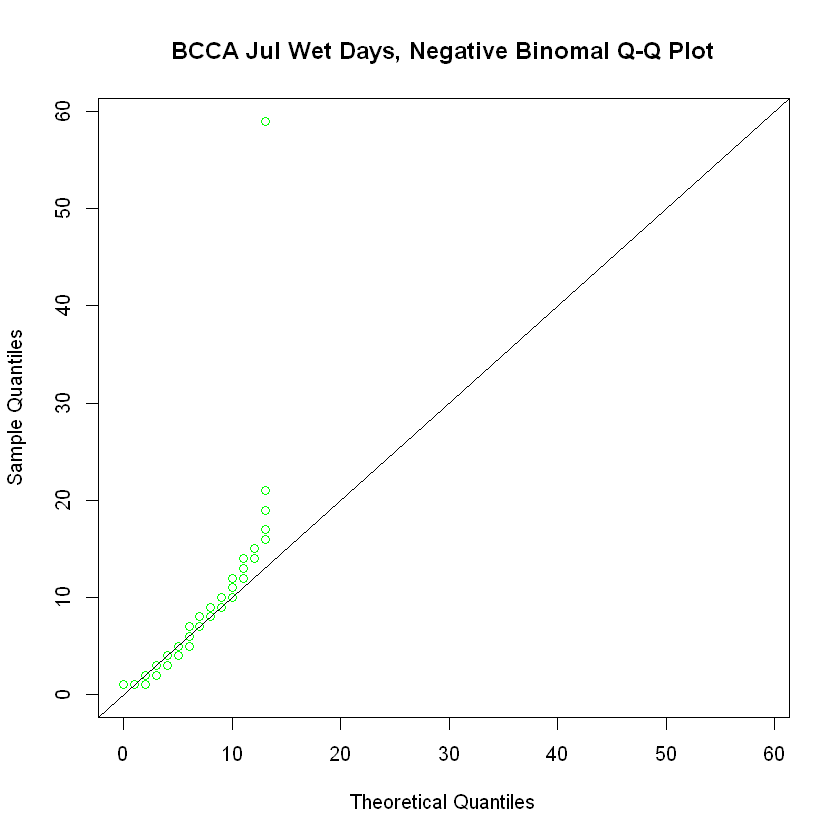

In [138]:
dBCJulMax <- max( dBCJul$Wet_Count )
dBCJulMean <- mean( dBCJul$Wet_Count )
dBCJulVar <- var( dBCJul$Wet_Count )
dBCJulBNr <- dBCJulMean^2 / abs(dBCJulVar - dBCJulMean)
dBCJulTstNB <- rnbinom( 1000, mu=dBCJulMean, size=dBCJulBNr )
qqplot( dBCJulTstNB, dBCJul$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Jul Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCJulMax), ylim=c(0,dBCJulMax) )
abline( 0, 1)

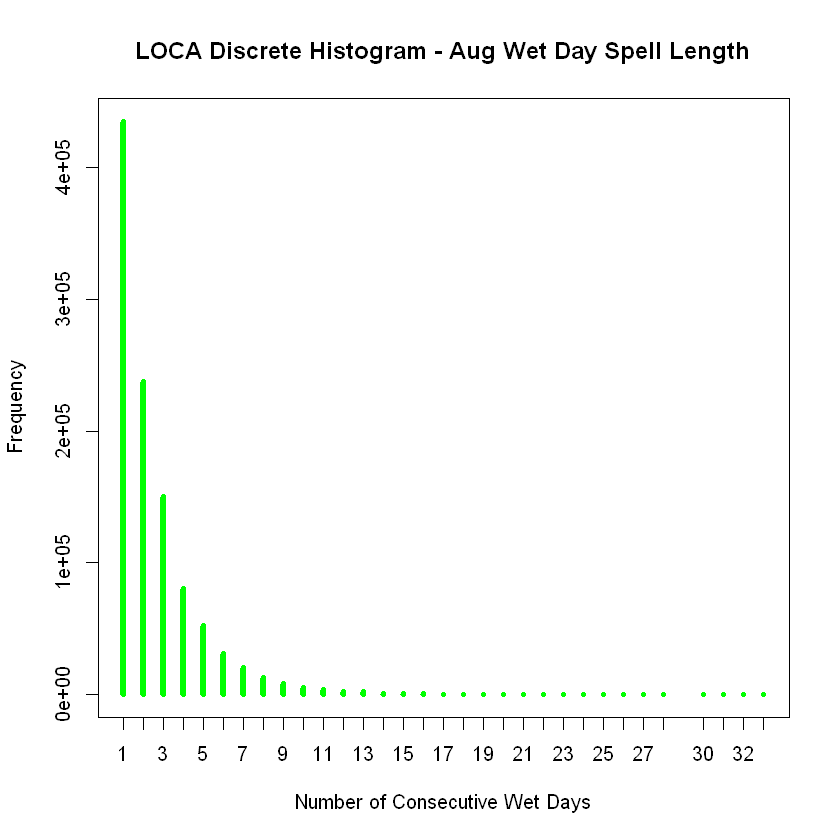

In [139]:
# our case is discrete so use this command
plot( table( dLOAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

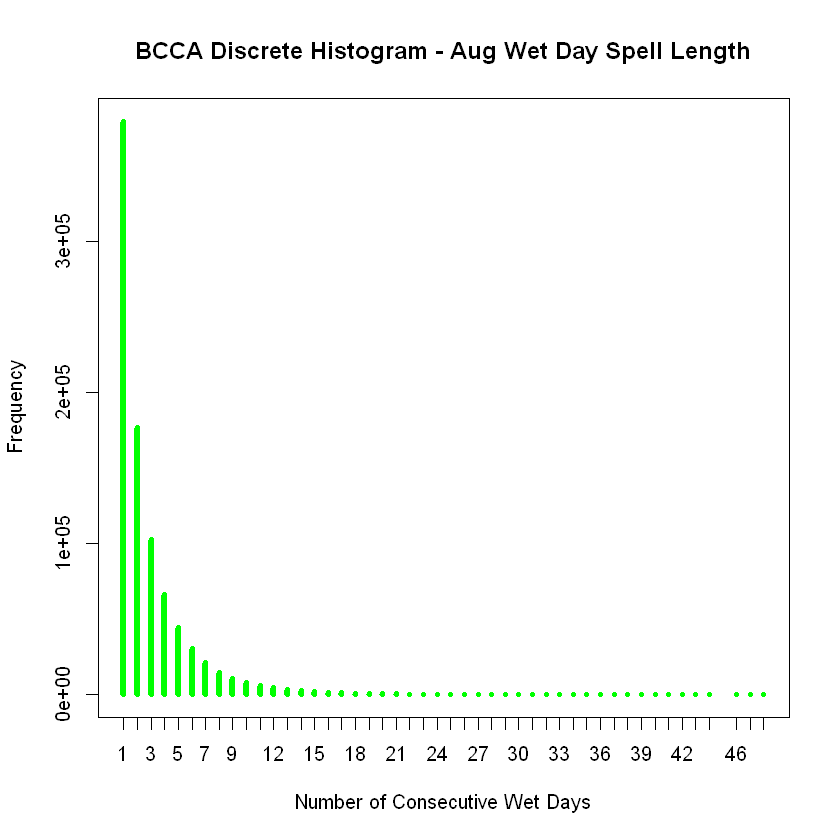

In [140]:
plot( table( dBCAug$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Aug Wet Day Spell Length", 
      col="green" )

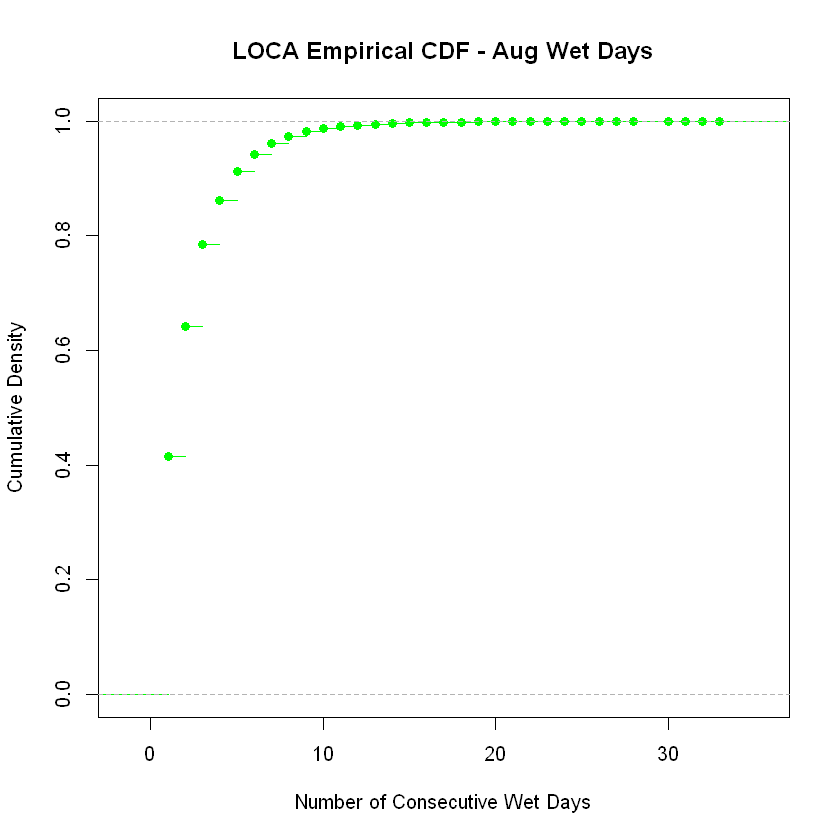

In [141]:
plot(ecdf(dLOAug$Wet_Count), main="LOCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

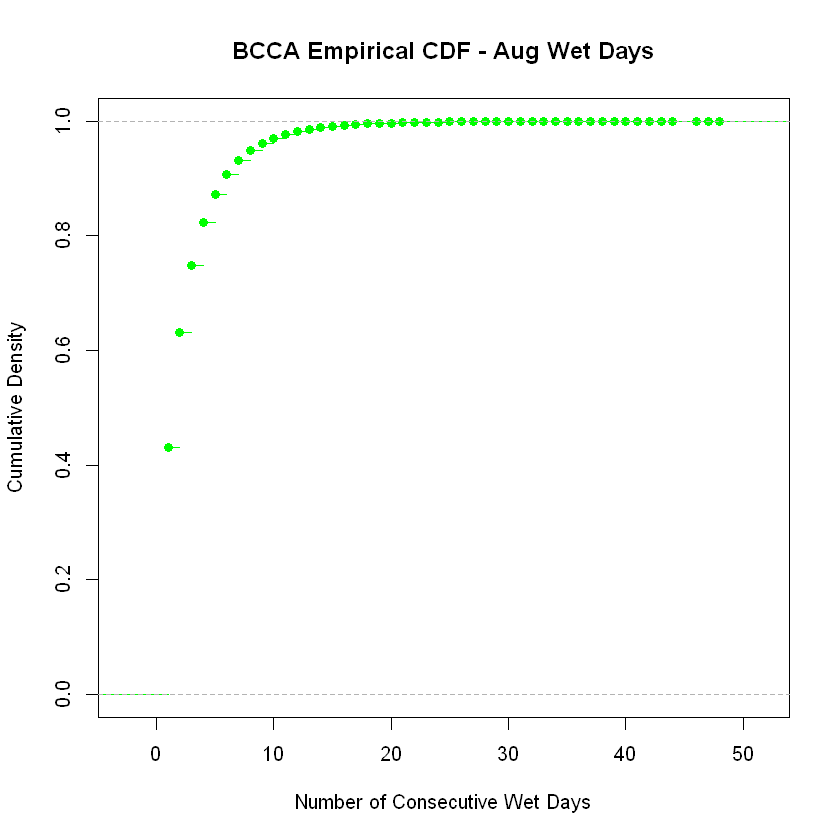

In [142]:
plot(ecdf(dBCAug$Wet_Count), main="BCCA Empirical CDF - Aug Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

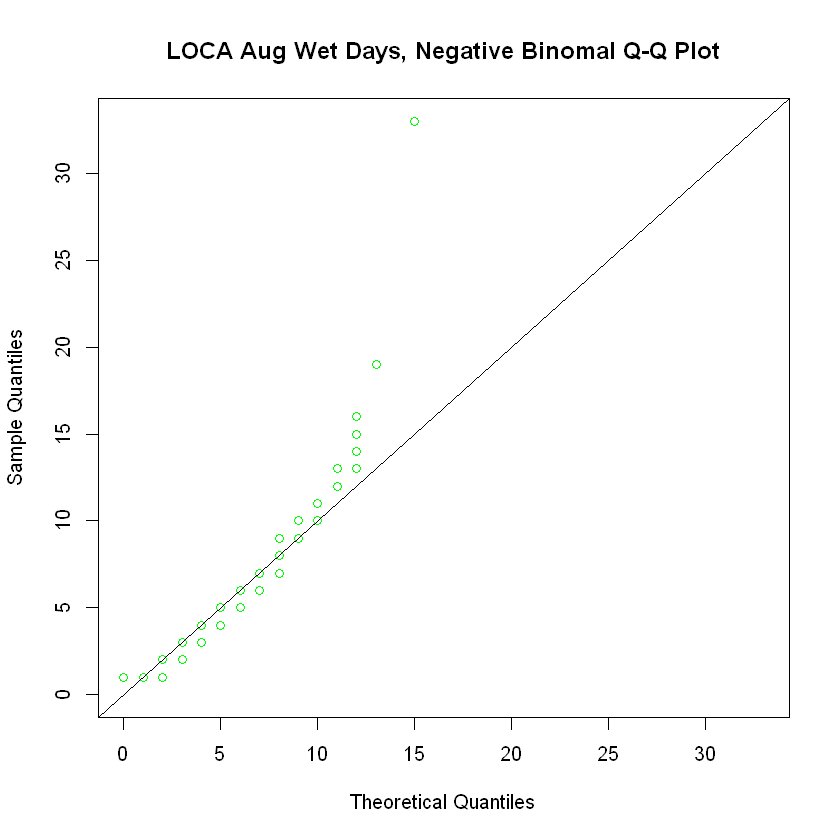

In [143]:
dLOAugMax <- max( dLOAug$Wet_Count )
dLOAugMean <- mean( dLOAug$Wet_Count )
dLOAugVar <- var( dLOAug$Wet_Count )
dLOAugBNr <- dLOAugMean^2 / abs(dLOAugVar - dLOAugMean)
dLOAugTstNB <- rnbinom( 1000, mu=dLOAugMean, size=dLOAugBNr )
qqplot( dLOAugTstNB, dLOAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOAugMax), ylim=c(0,dLOAugMax) )
abline( 0, 1)

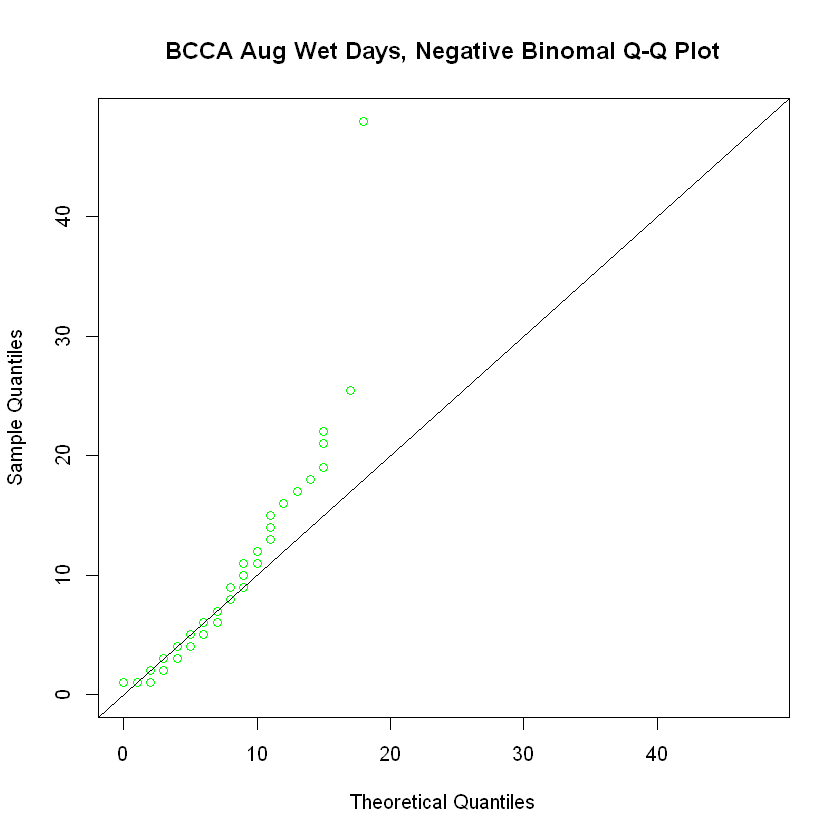

In [144]:
dBCAugMax <- max( dBCAug$Wet_Count )
dBCAugMean <- mean( dBCAug$Wet_Count )
dBCAugVar <- var( dBCAug$Wet_Count )
dBCAugBNr <- dBCAugMean^2 / abs(dBCAugVar - dBCAugMean)
dBCAugTstNB <- rnbinom( 1000, mu=dBCAugMean, size=dBCAugBNr )
qqplot( dBCAugTstNB, dBCAug$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Aug Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCAugMax), ylim=c(0,dBCAugMax) )
abline( 0, 1)

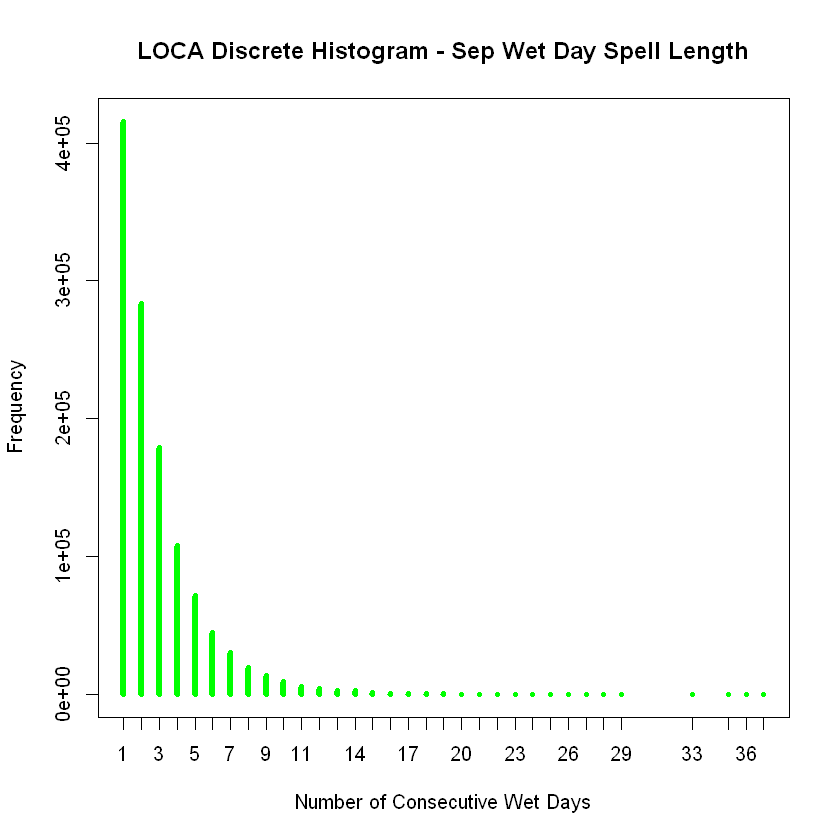

In [145]:
# our case is discrete so use this command
plot( table( dLOSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

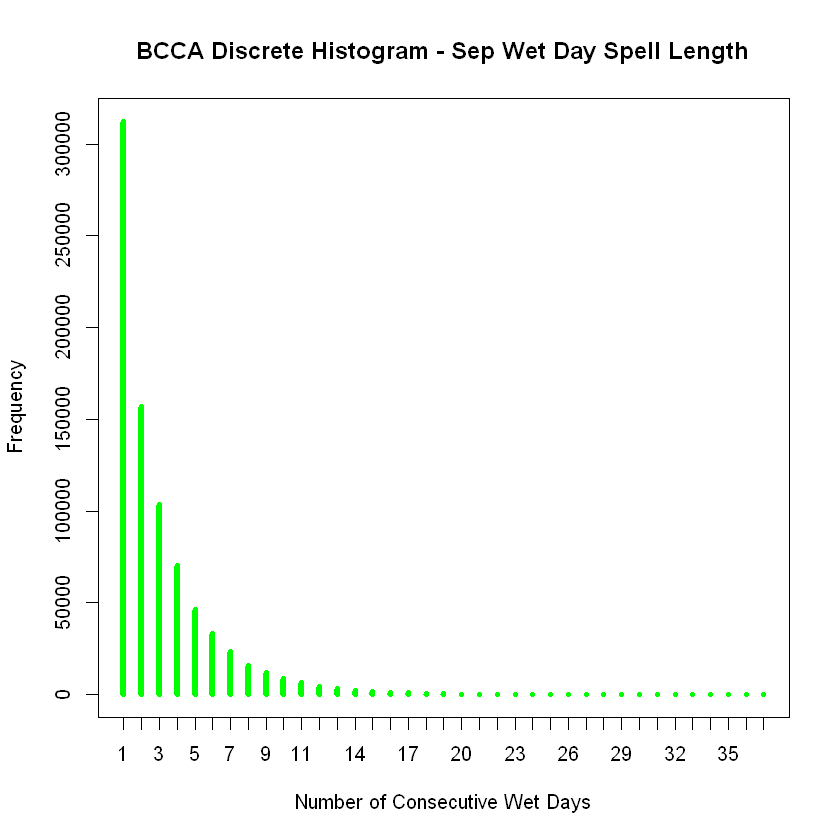

In [146]:
plot( table( dBCSep$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Sep Wet Day Spell Length", 
      col="green" )

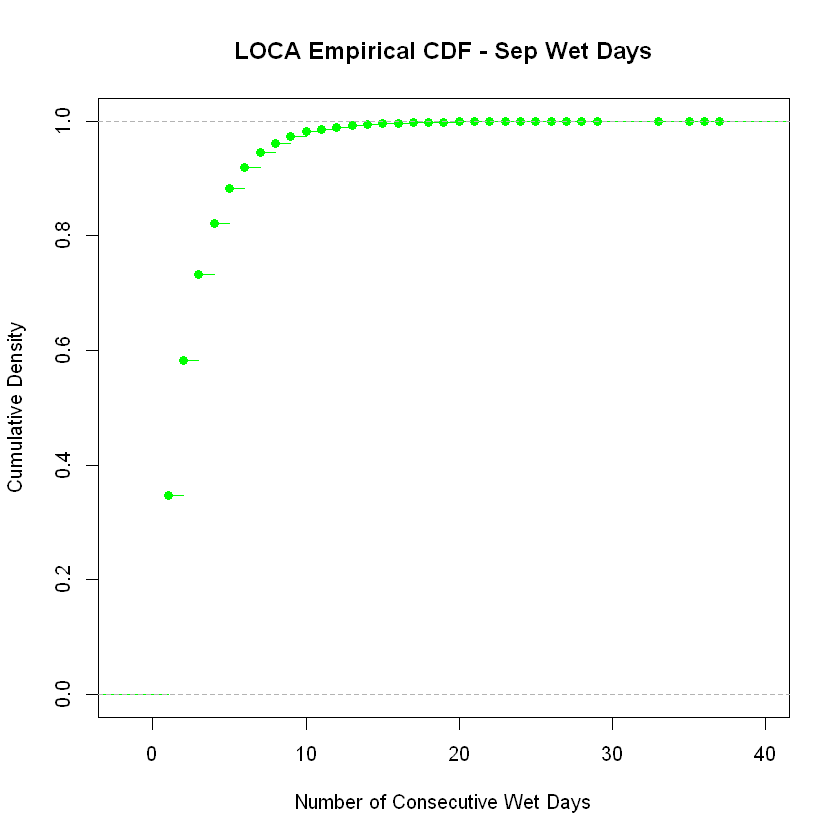

In [147]:
plot(ecdf(dLOSep$Wet_Count), main="LOCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

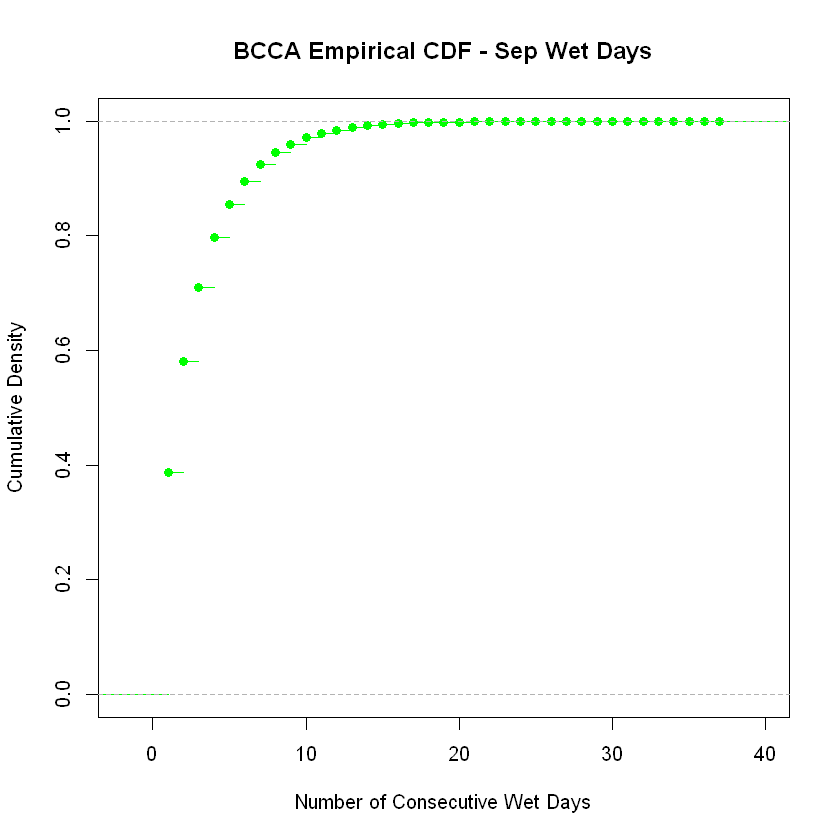

In [148]:
plot(ecdf(dBCSep$Wet_Count), main="BCCA Empirical CDF - Sep Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

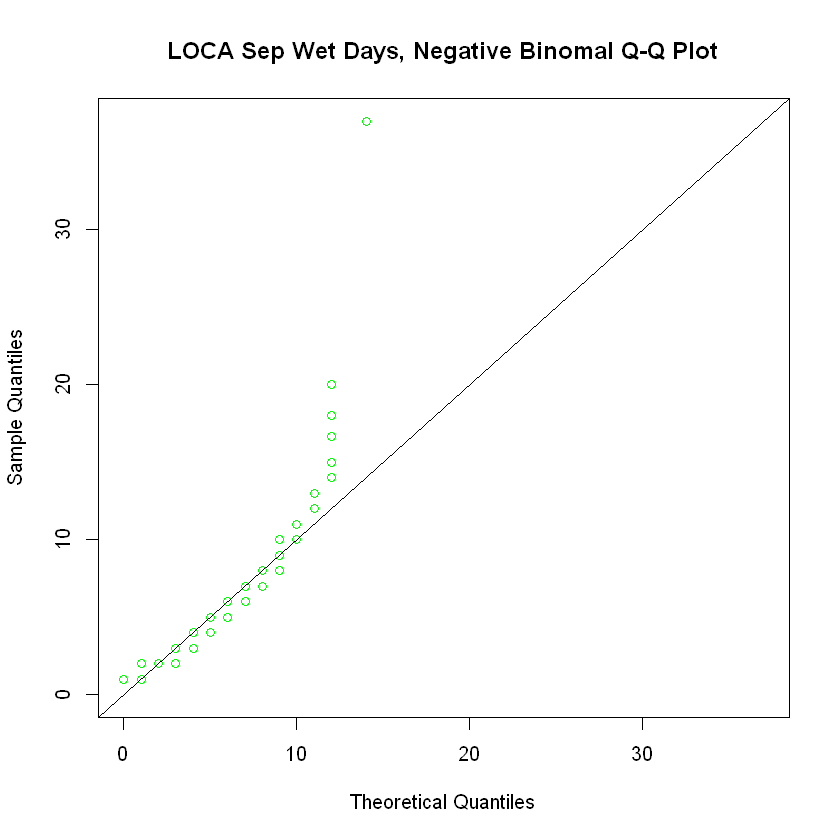

In [149]:
dLOSepMax <- max( dLOSep$Wet_Count )
dLOSepMean <- mean( dLOSep$Wet_Count )
dLOSepVar <- var( dLOSep$Wet_Count )
dLOSepBNr <- dLOSepMean^2 / abs(dLOSepVar - dLOSepMean)
dLOSepTstNB <- rnbinom( 1000, mu=dLOSepMean, size=dLOSepBNr )
qqplot( dLOSepTstNB, dLOSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOSepMax), ylim=c(0,dLOSepMax) )
abline( 0, 1)

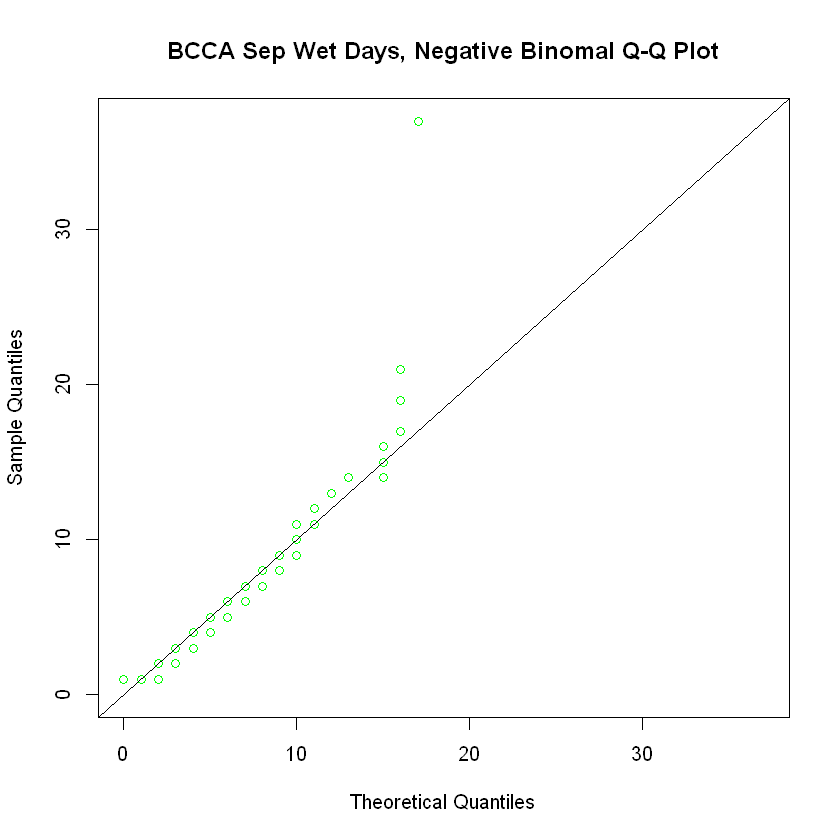

In [150]:
dBCSepMax <- max( dBCSep$Wet_Count )
dBCSepMean <- mean( dBCSep$Wet_Count )
dBCSepVar <- var( dBCSep$Wet_Count )
dBCSepBNr <- dBCSepMean^2 / abs(dBCSepVar - dBCSepMean)
dBCSepTstNB <- rnbinom( 1000, mu=dBCSepMean, size=dBCSepBNr )
qqplot( dBCSepTstNB, dBCSep$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Sep Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCSepMax), ylim=c(0,dBCSepMax) )
abline( 0, 1)

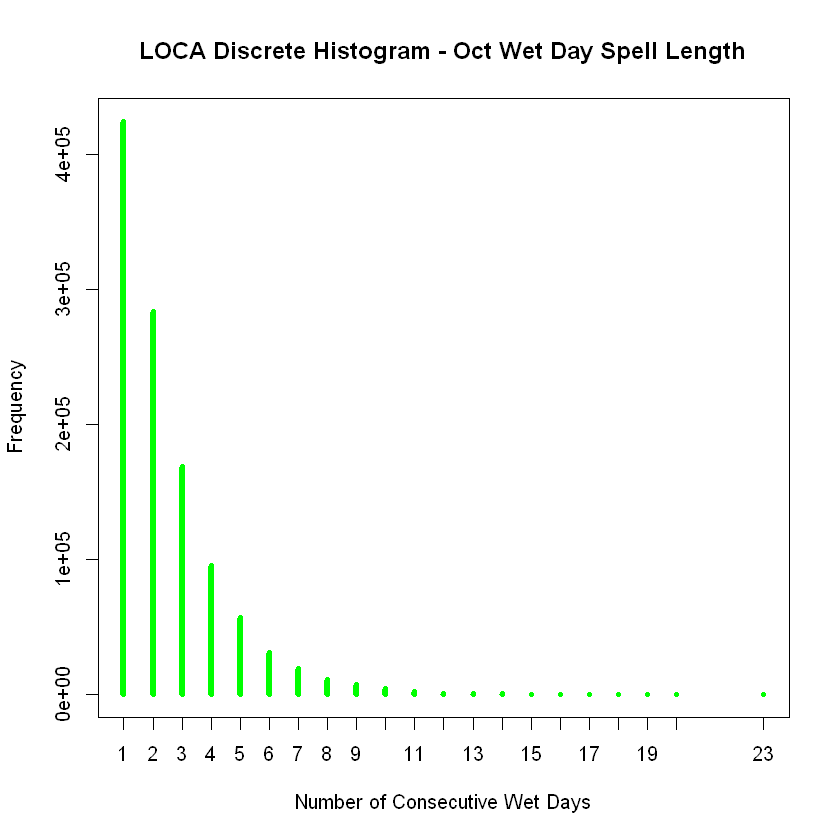

In [151]:
# our case is discrete so use this command
plot( table( dLOOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

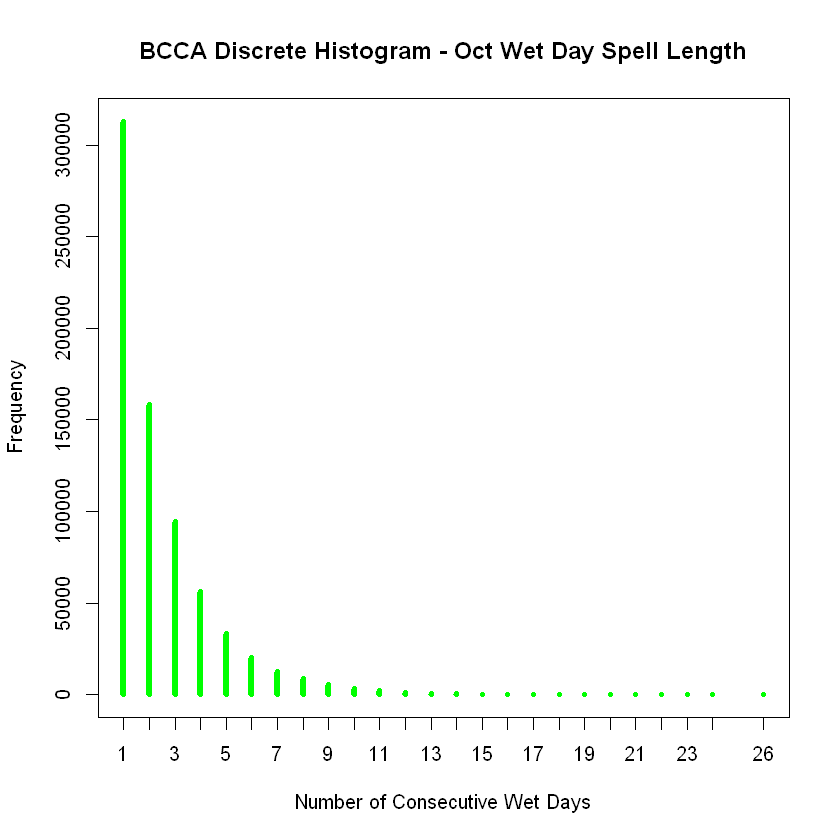

In [152]:
plot( table( dBCOct$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Oct Wet Day Spell Length", 
      col="green" )

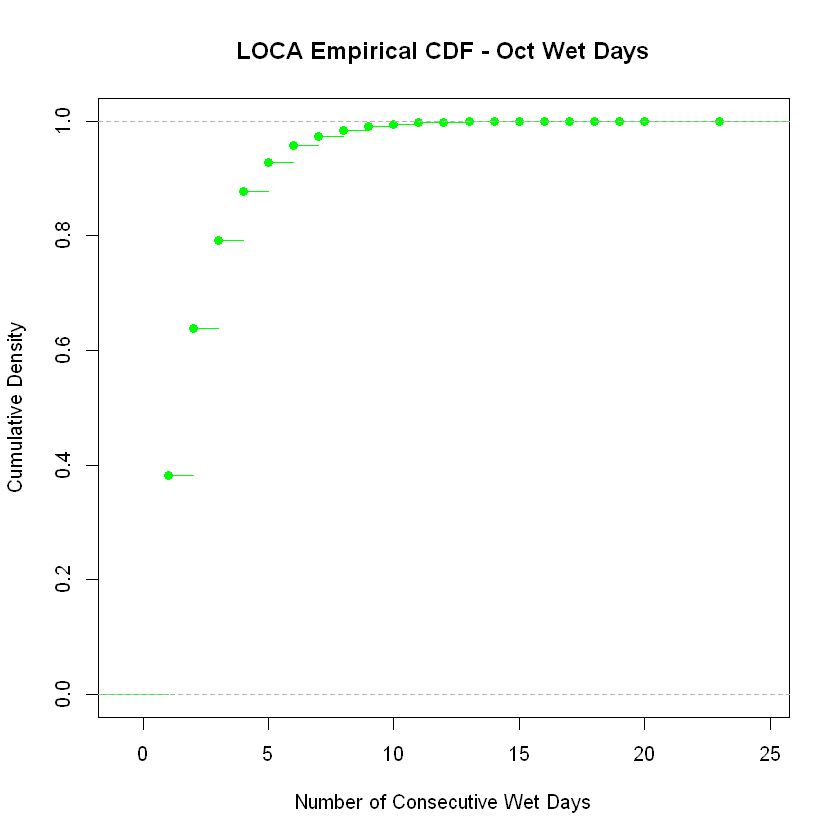

In [153]:
plot(ecdf(dLOOct$Wet_Count), main="LOCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

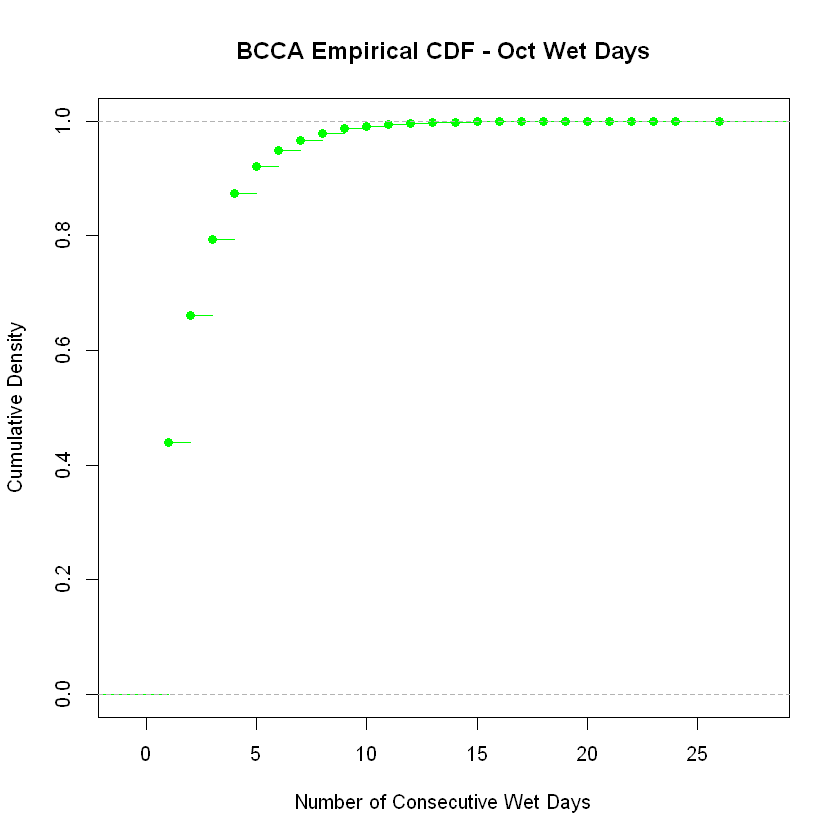

In [154]:
plot(ecdf(dBCOct$Wet_Count), main="BCCA Empirical CDF - Oct Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

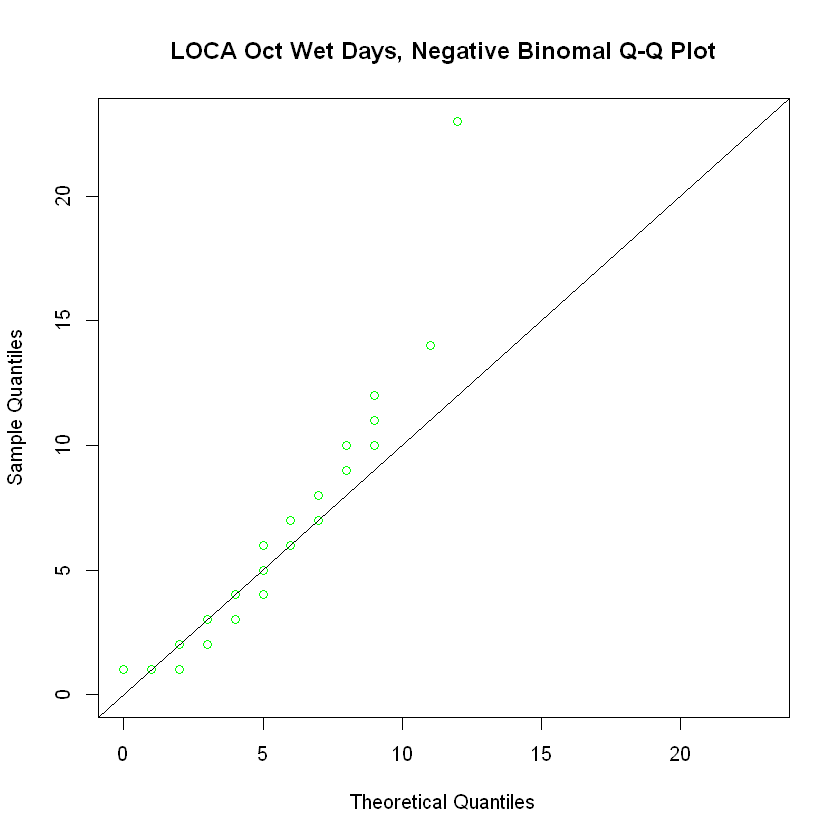

In [155]:
dLOOctMax <- max( dLOOct$Wet_Count )
dLOOctMean <- mean( dLOOct$Wet_Count )
dLOOctVar <- var( dLOOct$Wet_Count )
dLOOctBNr <- dLOOctMean^2 / abs(dLOOctVar - dLOOctMean)
dLOOctTstNB <- rnbinom( 1000, mu=dLOOctMean, size=dLOOctBNr )
qqplot( dLOOctTstNB, dLOOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLOOctMax), ylim=c(0,dLOOctMax) )
abline( 0, 1)

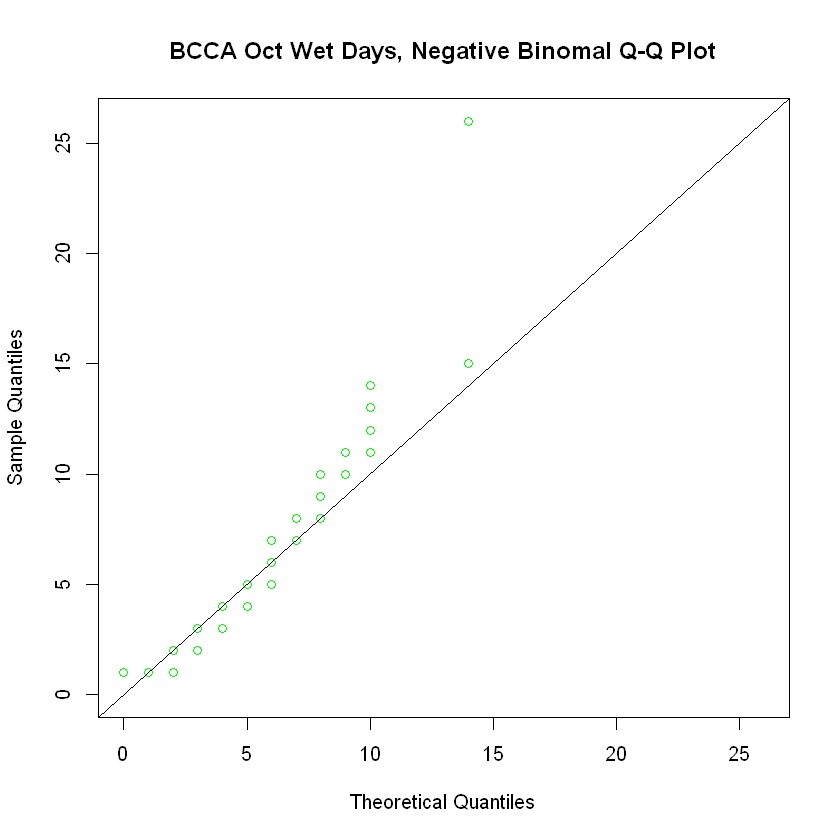

In [156]:
dBCOctMax <- max( dBCOct$Wet_Count )
dBCOctMean <- mean( dBCOct$Wet_Count )
dBCOctVar <- var( dBCOct$Wet_Count )
dBCOctBNr <- dBCOctMean^2 / abs(dBCOctVar - dBCOctMean)
dBCOctTstNB <- rnbinom( 1000, mu=dBCOctMean, size=dBCOctBNr )
qqplot( dBCOctTstNB, dBCOct$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Oct Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCOctMax), ylim=c(0,dBCOctMax) )
abline( 0, 1)

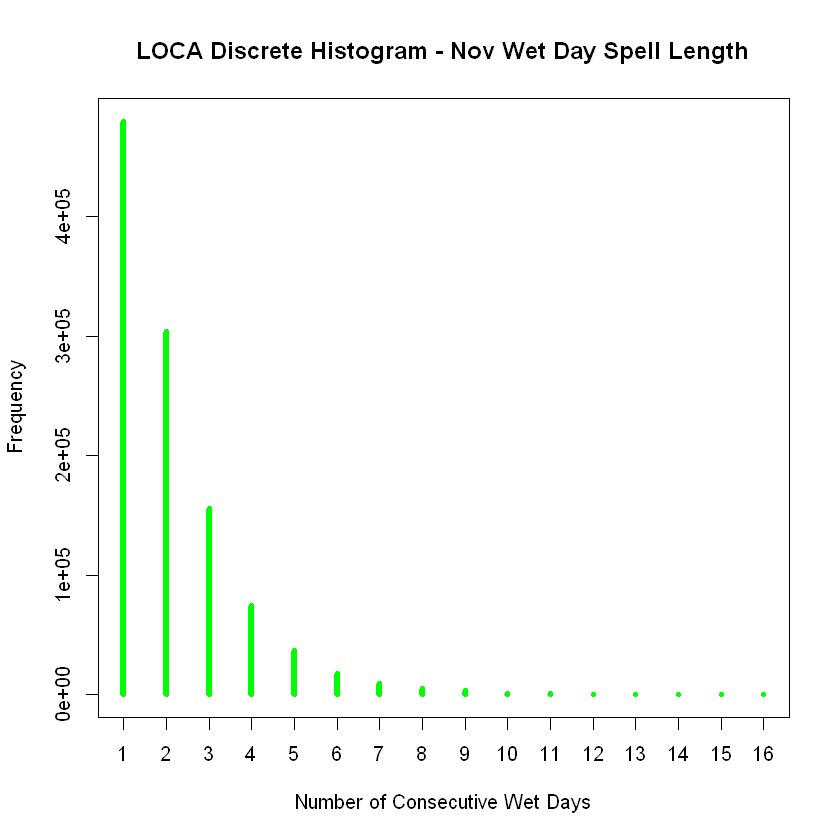

In [157]:
# our case is discrete so use this command
plot( table( dLONov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

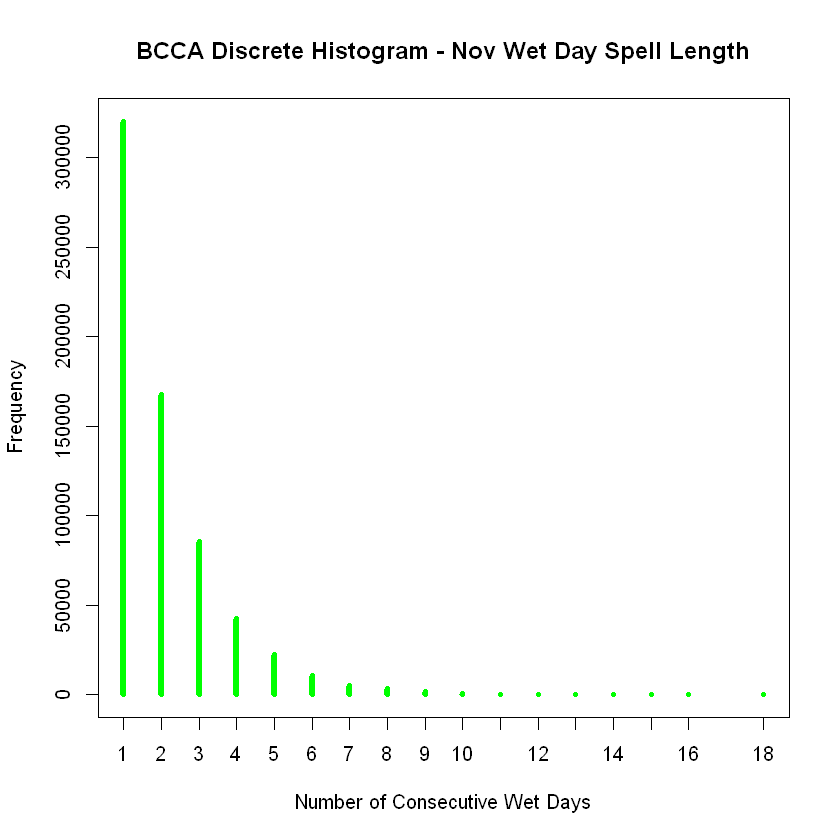

In [158]:
plot( table( dBCNov$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Nov Wet Day Spell Length", 
      col="green" )

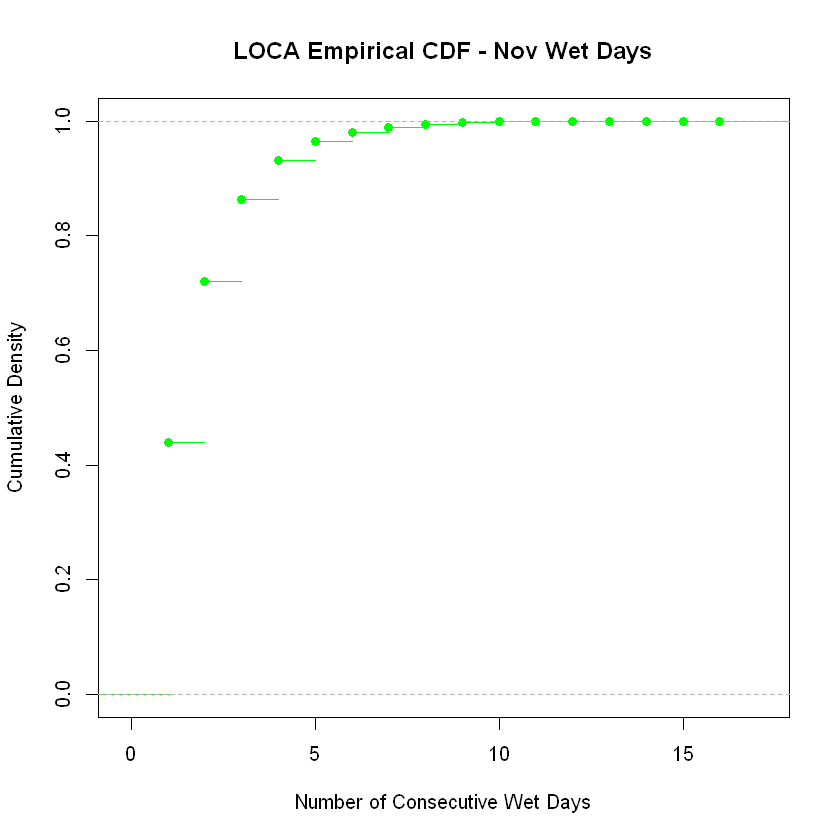

In [159]:
plot(ecdf(dLONov$Wet_Count), main="LOCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

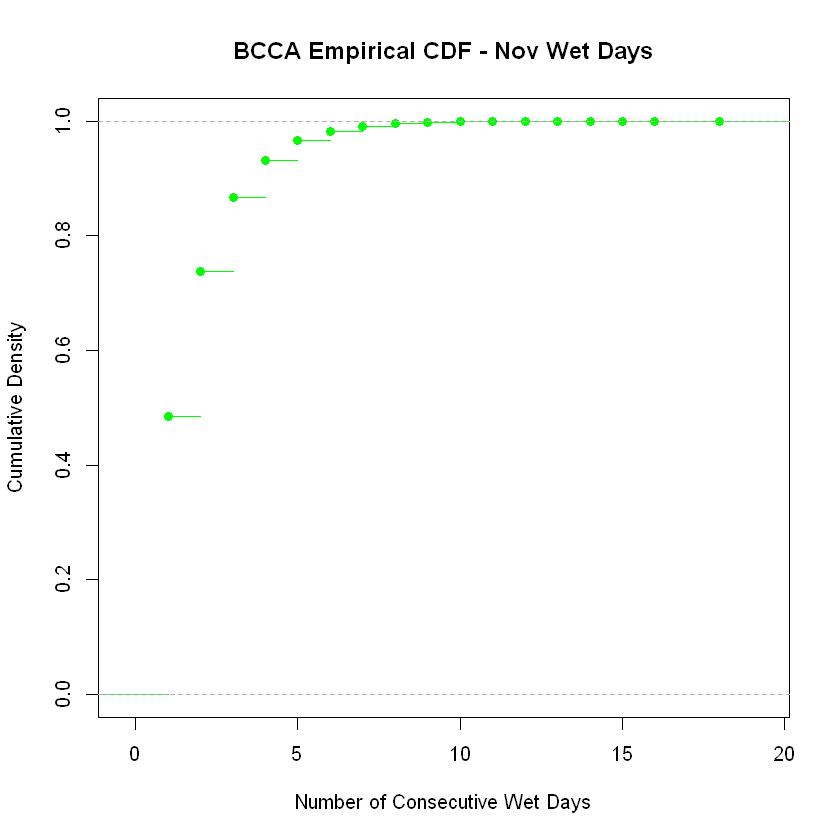

In [160]:
plot(ecdf(dBCNov$Wet_Count), main="BCCA Empirical CDF - Nov Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

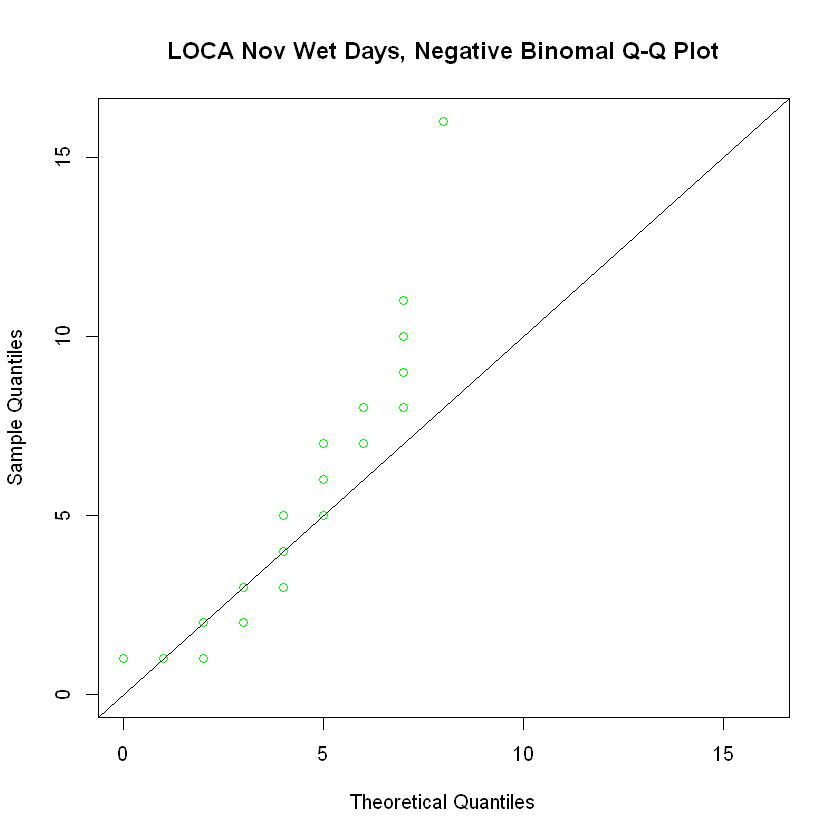

In [161]:
dLONovMax <- max( dLONov$Wet_Count )
dLONovMean <- mean( dLONov$Wet_Count )
dLONovVar <- var( dLONov$Wet_Count )
dLONovBNr <- dLONovMean^2 / abs(dLONovVar - dLONovMean)
dLONovTstNB <- rnbinom( 1000, mu=dLONovMean, size=dLONovBNr )
qqplot( dLONovTstNB, dLONov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLONovMax), ylim=c(0,dLONovMax) )
abline( 0, 1)

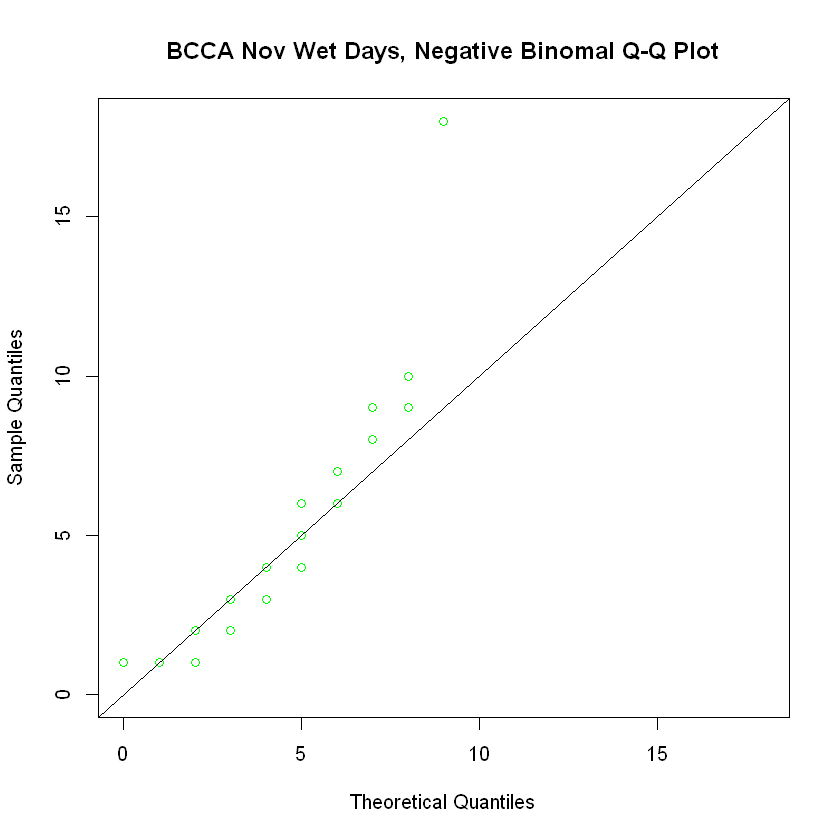

In [162]:
dBCNovMax <- max( dBCNov$Wet_Count )
dBCNovMean <- mean( dBCNov$Wet_Count )
dBCNovVar <- var( dBCNov$Wet_Count )
dBCNovBNr <- dBCNovMean^2 / abs(dBCNovVar - dBCNovMean)
dBCNovTstNB <- rnbinom( 1000, mu=dBCNovMean, size=dBCNovBNr )
qqplot( dBCNovTstNB, dBCNov$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Nov Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCNovMax), ylim=c(0,dBCNovMax) )
abline( 0, 1)

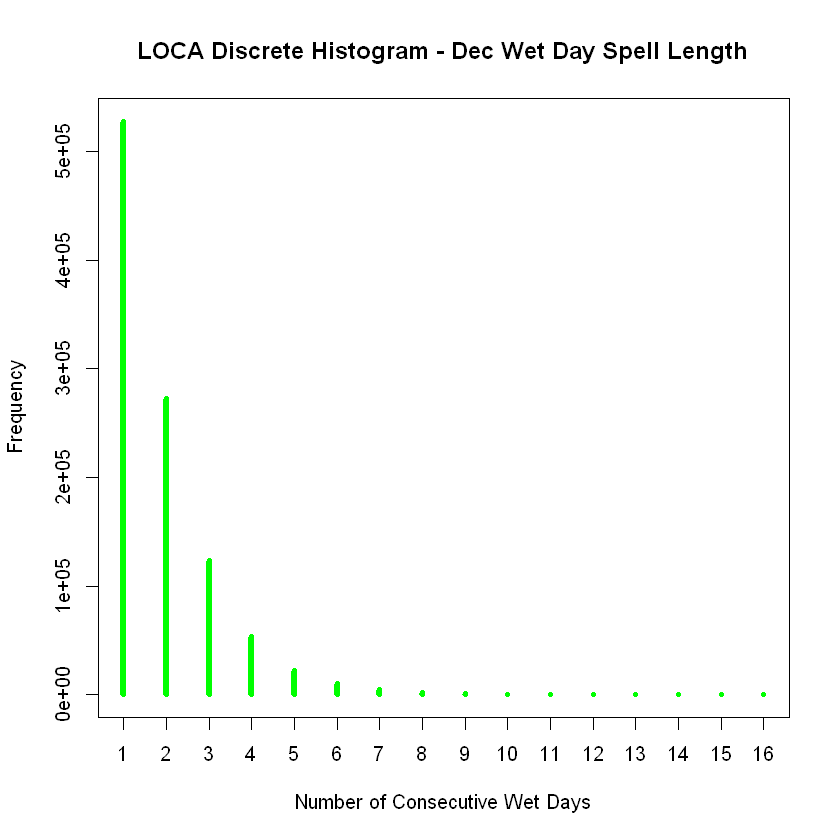

In [163]:
# our case is discrete so use this command
plot( table( dLODec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="LOCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

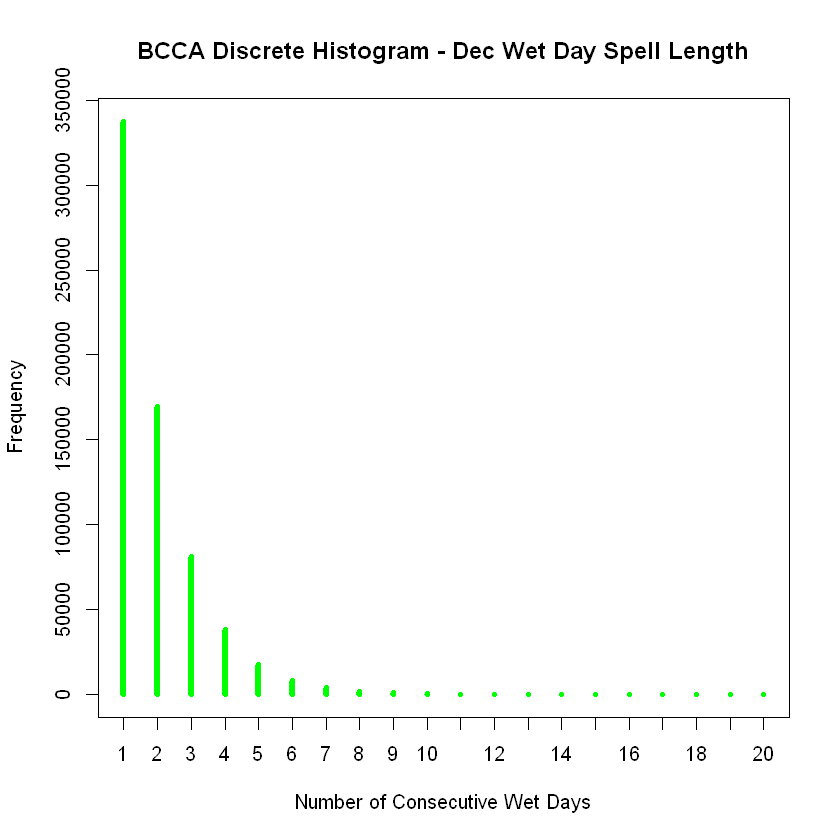

In [164]:
plot( table( dBCDec$Wet_Count ), type="h", lwd=5, ylab="Frequency", 
      xlab="Number of Consecutive Wet Days", 
      main="BCCA Discrete Histogram - Dec Wet Day Spell Length", 
      col="green" )

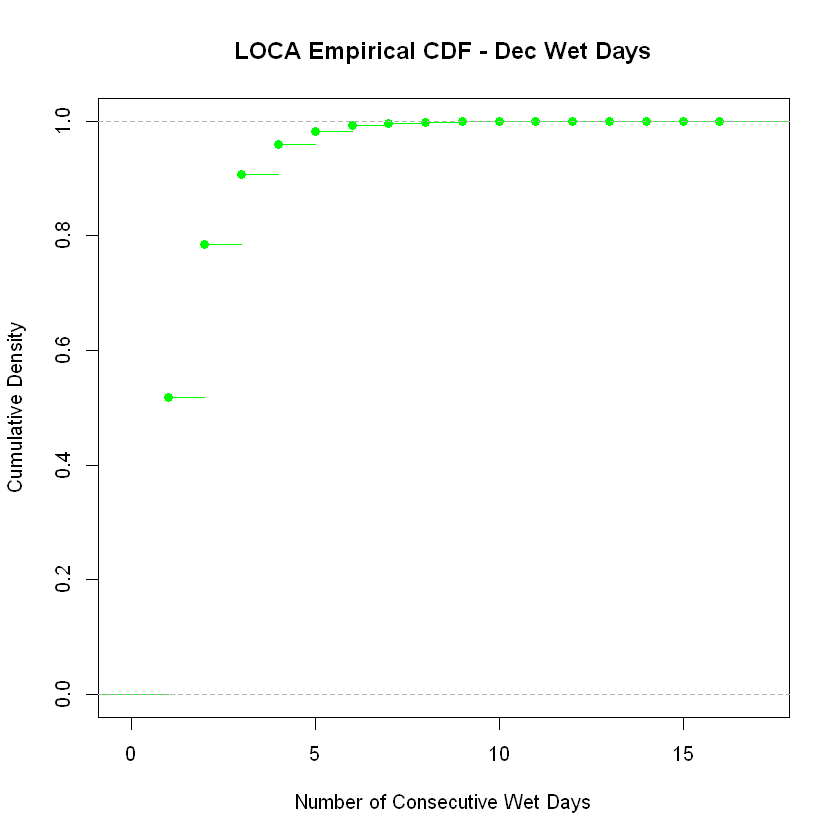

In [165]:
plot(ecdf(dLODec$Wet_Count), main="LOCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

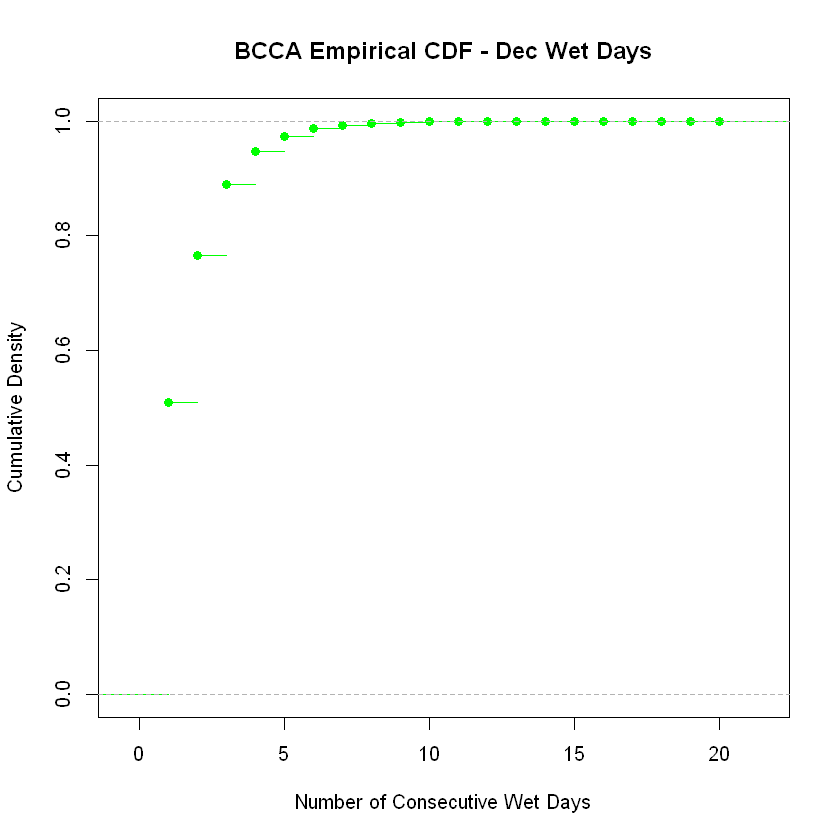

In [166]:
plot(ecdf(dBCDec$Wet_Count), main="BCCA Empirical CDF - Dec Wet Days", 
     ylab="Cumulative Density", xlab="Number of Consecutive Wet Days", col="green" )

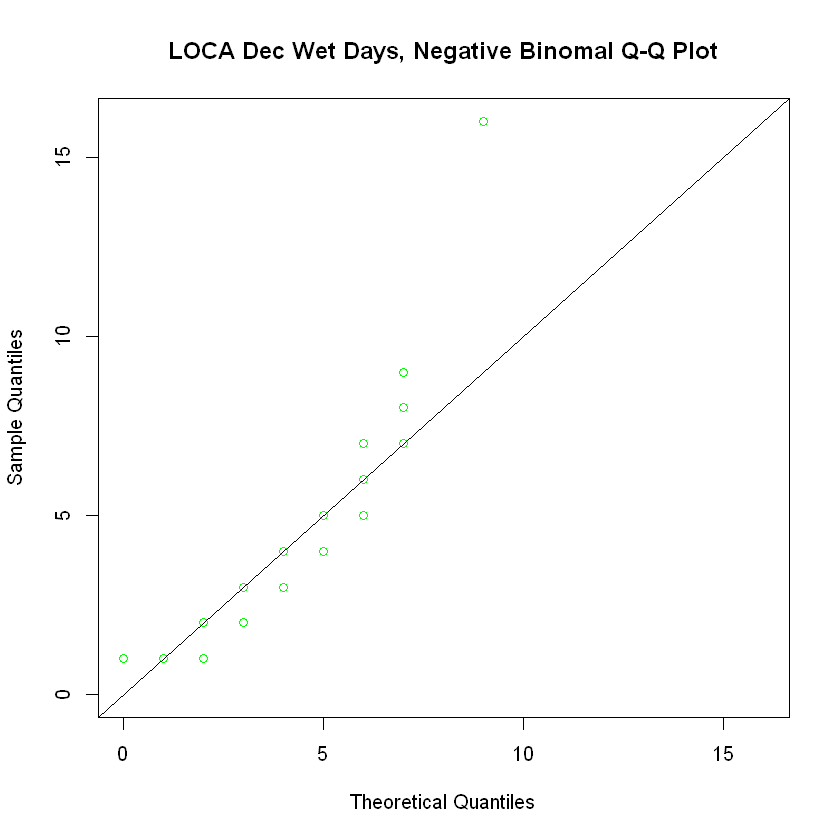

In [167]:
dLODecMax <- max( dLODec$Wet_Count )
dLODecMean <- mean( dLODec$Wet_Count )
dLODecVar <- var( dLODec$Wet_Count )
dLODecBNr <- dLODecMean^2 / abs(dLODecVar - dLODecMean)
dLODecTstNB <- rnbinom( 1000, mu=dLODecMean, size=dLODecBNr )
qqplot( dLODecTstNB, dLODec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="LOCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dLODecMax), ylim=c(0,dLODecMax) )
abline( 0, 1)

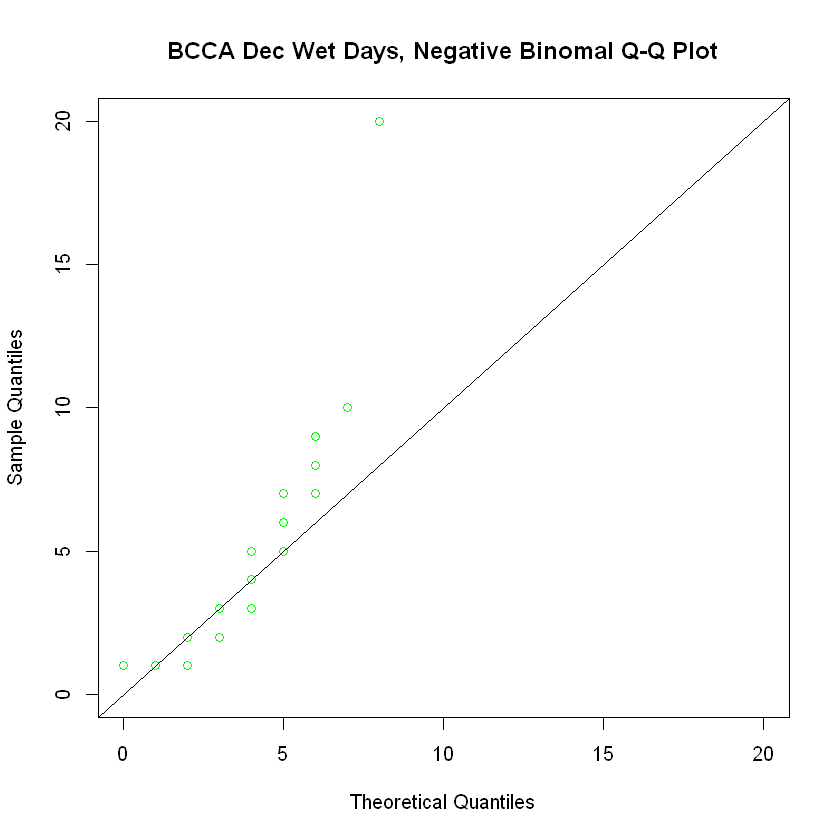

In [168]:
dBCDecMax <- max( dBCDec$Wet_Count )
dBCDecMean <- mean( dBCDec$Wet_Count )
dBCDecVar <- var( dBCDec$Wet_Count )
dBCDecBNr <- dBCDecMean^2 / abs(dBCDecVar - dBCDecMean)
dBCDecTstNB <- rnbinom( 1000, mu=dBCDecMean, size=dBCDecBNr )
qqplot( dBCDecTstNB, dBCDec$Wet_Count, col="green", xlab="Theoretical Quantiles",
        ylab="Sample Quantiles", main="BCCA Dec Wet Days, Negative Binomal Q-Q Plot",
        xlim=c(0,dBCDecMax), ylim=c(0,dBCDecMax) )
abline( 0, 1)

In [169]:
cat("LOCA Jan scale: ", dLOJanBNr, "\n", "LOCA Feb scale: ", dLOFebBNr, "\n",
    "LOCA Mar scale: ", dLOMarBNr, "\n", "LOCA Apr scale: ", dLOAprBNr, "\n",
    "LOCA May scale: ", dLOMayBNr, "\n", "LOCA Jun scale: ", dLOJunBNr, "\n",
    "LOCA Jul scale: ", dLOJulBNr, "\n", "LOCA Aug scale: ", dLOAugBNr, "\n",
    "LOCA Sep scale: ", dLOSepBNr, "\n", "LOCA Oct scale: ", dLOOctBNr, "\n",
    "LOCA Nov scale: ", dLONovBNr, "\n", "LOCA Dec scale: ", dLODecBNr, "\n" )

LOCA Jan scale:  6.178961 
 LOCA Feb scale:  10.93794 
 LOCA Mar scale:  13.39146 
 LOCA Apr scale:  8.14381 
 LOCA May scale:  3.027531 
 LOCA Jun scale:  2.4611 
 LOCA Jul scale:  2.48992 
 LOCA Aug scale:  2.641724 
 LOCA Sep scale:  2.504739 
 LOCA Oct scale:  6.261665 
 LOCA Nov scale:  4277.383 
 LOCA Dec scale:  9.048589 


In [170]:
cat("BCCA Jan scale: ", dBCJanBNr, "\n", "BCCA Feb scale: ", dBCFebBNr, "\n",
    "BCCA Mar scale: ", dBCMarBNr, "\n", "BCCA Apr scale: ", dBCAprBNr, "\n",
    "BCCA May scale: ", dBCMayBNr, "\n", "BCCA Jun scale: ", dBCJunBNr, "\n",
    "BCCA Jul scale: ", dBCJulBNr, "\n", "BCCA Aug scale: ", dBCAugBNr, "\n",
    "BCCA Sep scale: ", dBCSepBNr, "\n", "BCCA Oct scale: ", dBCOctBNr, "\n",
    "BCCA Nov scale: ", dBCNovBNr, "\n", "BCCA Dec scale: ", dBCDecBNr, "\n" )

BCCA Jan scale:  23.77119 
 BCCA Feb scale:  67.46875 
 BCCA Mar scale:  58.72881 
 BCCA Apr scale:  2.528853 
 BCCA May scale:  1.597136 
 BCCA Jun scale:  1.592384 
 BCCA Jul scale:  1.60449 
 BCCA Aug scale:  1.383985 
 BCCA Sep scale:  1.879703 
 BCCA Oct scale:  3.529994 
 BCCA Nov scale:  79.77898 
 BCCA Dec scale:  32.45749 


### Fitting Negative Binomial Distributions

Use the **fitdistrplus** package for distribution fitting. This also provides the *plotdist* function which provides a pair of plots: 

1. empirical density, or a histogram
2. empirical cumulative distribution

These plots were provided above from scratch. **fitdistrplus** also provides a *descdist* function that provides classical descriptive statistics for the sample.

Distributions are then fit using a Maximum Likelihood Estimation (MLE) estimator in the *fitdist* function. Then goodness-of-fit statistics are calculated using the *gofstat* function.

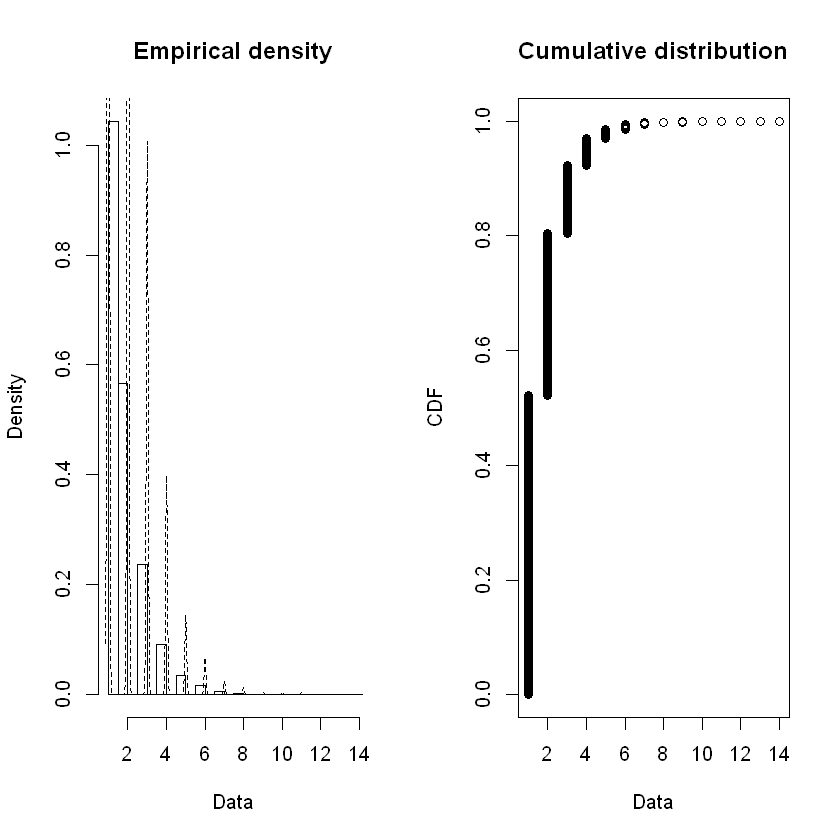

In [171]:
plotdist( dLOJan$Wet_Count, histo=TRUE, demp=TRUE )

In [172]:
LOfd_NB_dJan <- fitdist( dLOJan$Wet_Count, "nbinom" )
LOfd_GE_dJan <- fitdist( dLOJan$Wet_Count, "geom" )

In [173]:
summary( LOfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 6.860232e+06 0.293821376
mu   1.805460e+00 0.001388191
Loglikelihood:  -1393652   AIC:  2787308   BIC:  2787331 
Correlation matrix:
            size          mu
size 1.00000e+00 5.57931e-07
mu   5.57931e-07 1.00000e+00


In [174]:
LOfdNB_dJan_size <- LOfd_NB_dJan$estimate[["size"]]
LOfdNB_dJan_mu <- LOfd_NB_dJan$estimate[["mu"]]
cat("LOCA Jan size: ", LOfdNB_dJan_size, "\n", "LOCA Jan mu: ", LOfdNB_dJan_mu, "\n")

LOCA Jan size:  6860232 
 LOCA Jan mu:  1.80546 


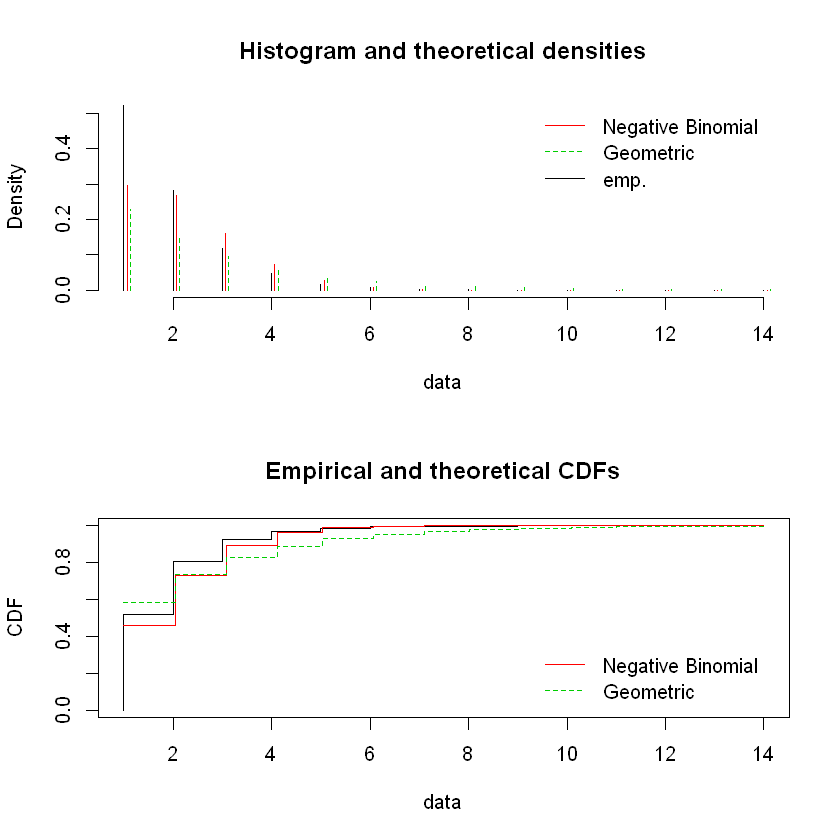

In [175]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJan, LOfd_GE_dJan), legendtext=plot.legend )

In [176]:
LOstatRes <- gofstat( list(LOfd_NB_dJan, LOfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [177]:
print(LOstatRes)

Chi-squared statistic:  39657.66 188169.1 
Degree of freedom of the Chi-squared distribution:  5 6 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    488722            432091.2998      548837.47
<= 2    265383            251025.1475      138304.88
<= 3    110903            151071.9933       89007.65
<= 4     43117             68188.6378       57281.86
<= 5     15967             24622.3851       36864.38
<= 6      7421              7409.1271       23724.48
<= 7      2718              1910.9848       15268.16
> 7       2625               536.4245       27567.12

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2787308   3423946
Bayesian Information Criterion           2787331   3423958


In [178]:
LOfdNB_dJan_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

[Chi-Squared Test](https://www.r-bloggers.com/chi-squared-test/)

Like all statistical tests, chi-squared test assumes a null hypothesis and an alternate hypothesis. The general practice is, if the p-value that comes out in the result is less than a pre-determined significance level, which is 0.05 usually, then we reject the null hypothesis.

- H0: The The two variables are independent
- H1: The two variables are related.

The null hypothesis of the chi-squared test is that the two variables are independent and the alternate hypothesis is that they are related.

In this case our p-value is 0.0 and we can reject the null hypothesis that sample and MLE-fit distribution are not related.

In [179]:
LOfdNB_dJan_p = LOfdNB_dJan_size / (LOfdNB_dJan_size + LOfdNB_dJan_mu)
cat("LOCA prob: ", LOfdNB_dJan_p)

LOCA prob:  0.9999997

In [180]:
# add to our tracking dataframe
LOMonDistDF[1, ] <- list( 1, dLOJanMean, dLOJanBNr, LOfdNB_dJan_p, LOfdNB_dJan_mu, LOfdNB_dJan_size,
                          LOfdNB_dJan_pvalue )

In [181]:
LOgf_dJan <- goodfit( dLOJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJan_size, prob=LOfdNB_dJan_p) )

In [182]:
summary( LOgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          404852.3 14        0
Likelihood Ratio 471740.7 13        0


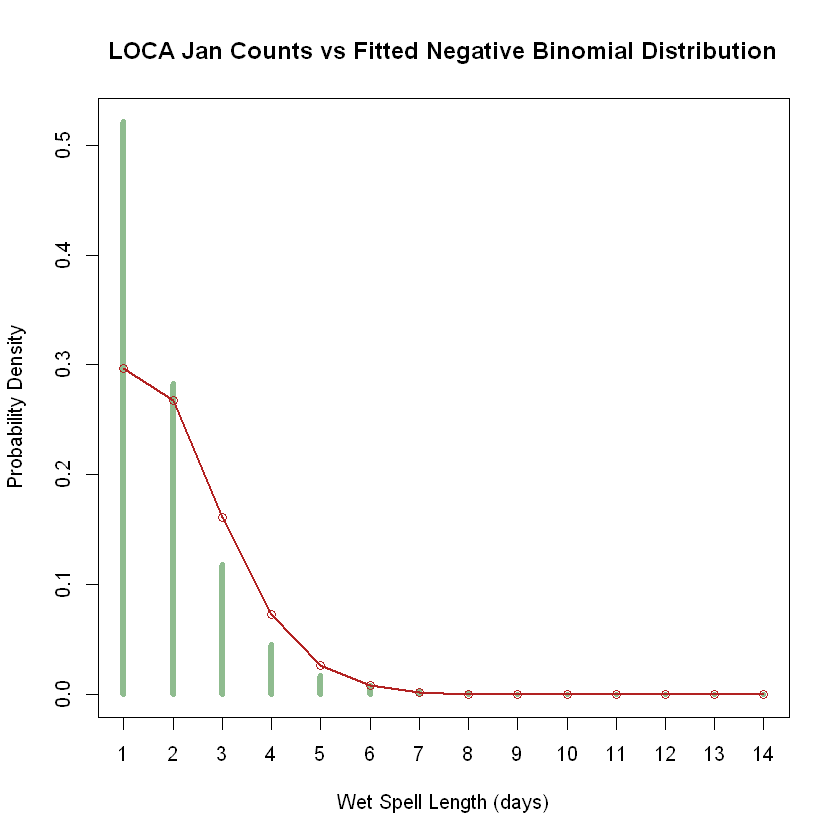

In [183]:
maxP <- max(dLOJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJan_size, mu=LOfdNB_dJan_mu )
ttab <- table( dLOJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

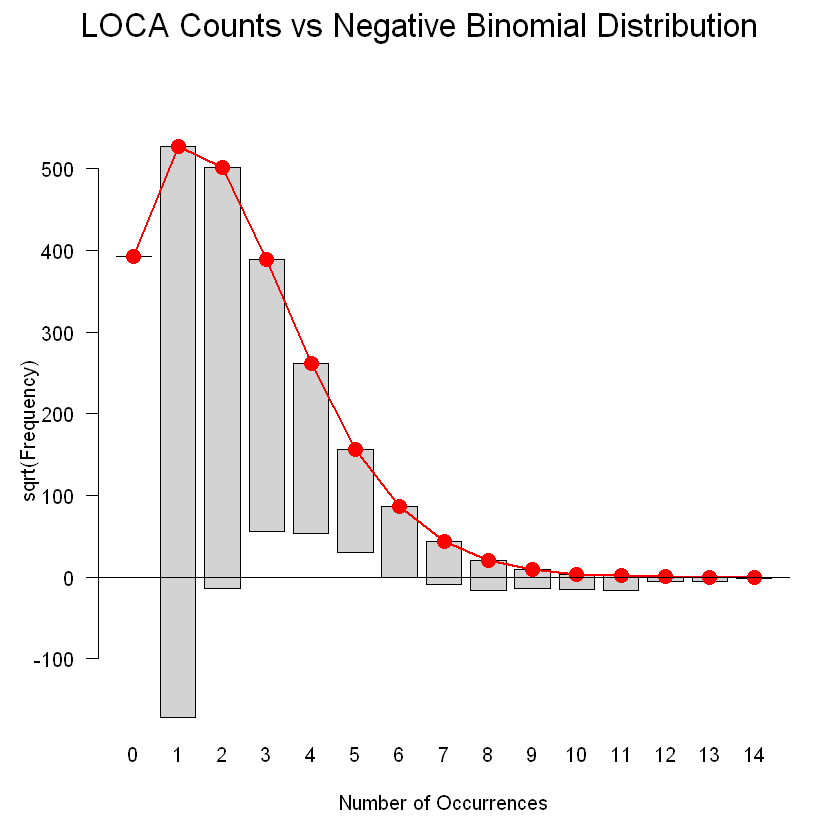

In [184]:
plot( LOgf_dJan, main="LOCA Counts vs Negative Binomial Distribution" )

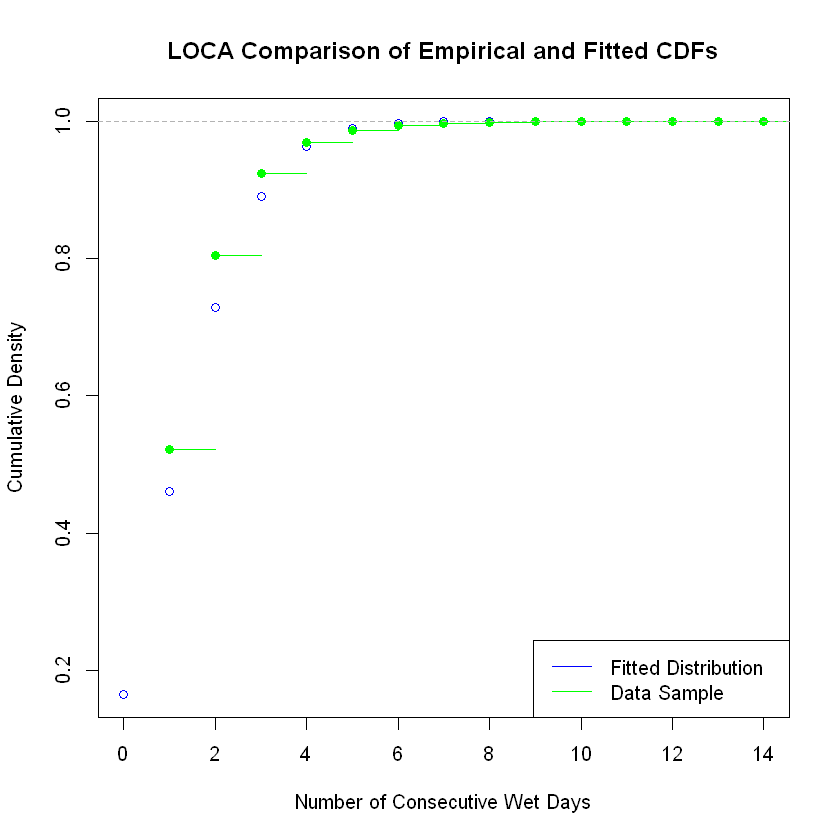

In [185]:
x <- seq(0,dLOJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

In [186]:
ks.test( dLOJan$Wet_Count, "pnbinom", mu=LOfdNB_dJan_mu, size=LOfdNB_dJan_size )


	One-sample Kolmogorov-Smirnov test

data:  dLOJan$Wet_Count
D = 0.46121, p-value < 2.2e-16
alternative hypothesis: two-sided


Generally, K-S test is better for continuous distributions.

[Kolmogorv-Smirnov Test](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/ks.test.html)

Null hypothesis that the true distribution function of x is equal to the hypothesized distribution function (one-sample case). This is a comparison of cumulative distribution functions, and the test statistic is the maximum difference in value, with the statistic in the "greater" alternative being D^+ = max[F_x(u) - F_y(u)]

Exact p-values are not available for the two-sample case if one-sided or in the presence of ties. If exact = NULL (the default), an exact p-value is computed if the sample size is less than 100 in the one-sample case and there are no ties, and if the product of the sample sizes is less than 10000 in the two-sample case. Otherwise, asymptotic distributions are used whose approximations may be inaccurate in small samples.

The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In the one-sample case, the distribution considered under the null hypothesis may be continuous (see Section 2), purely discrete or mixed (see Section 2.2).

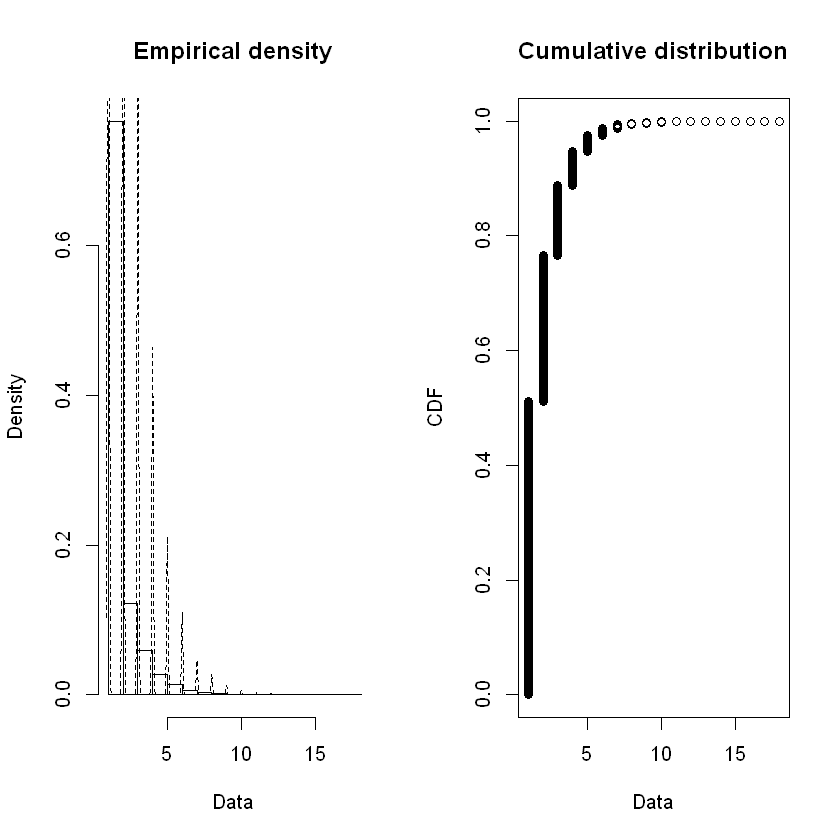

In [187]:
plotdist( dBCJan$Wet_Count, histo=TRUE, demp=TRUE )

In [188]:
BCfd_NB_dJan <- fitdist( dBCJan$Wet_Count, "nbinom" )
BCfd_GE_dJan <- fitdist( dBCJan$Wet_Count, "geom" )

In [189]:
summary( BCfd_NB_dJan )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 2.810599e+05         NaN
mu   1.936275e+00 0.001678413
Loglikelihood:  -1090973   AIC:  2181951   BIC:  2181974 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [190]:
BCfdNB_dJan_size <- BCfd_NB_dJan$estimate[["size"]]
BCfdNB_dJan_mu <- BCfd_NB_dJan$estimate[["mu"]]
cat("BCCA Jan size: ", BCfdNB_dJan_size, "\n", "BCCA Jan mu: ", BCfdNB_dJan_mu, "\n")

BCCA Jan size:  281059.9 
 BCCA Jan mu:  1.936275 


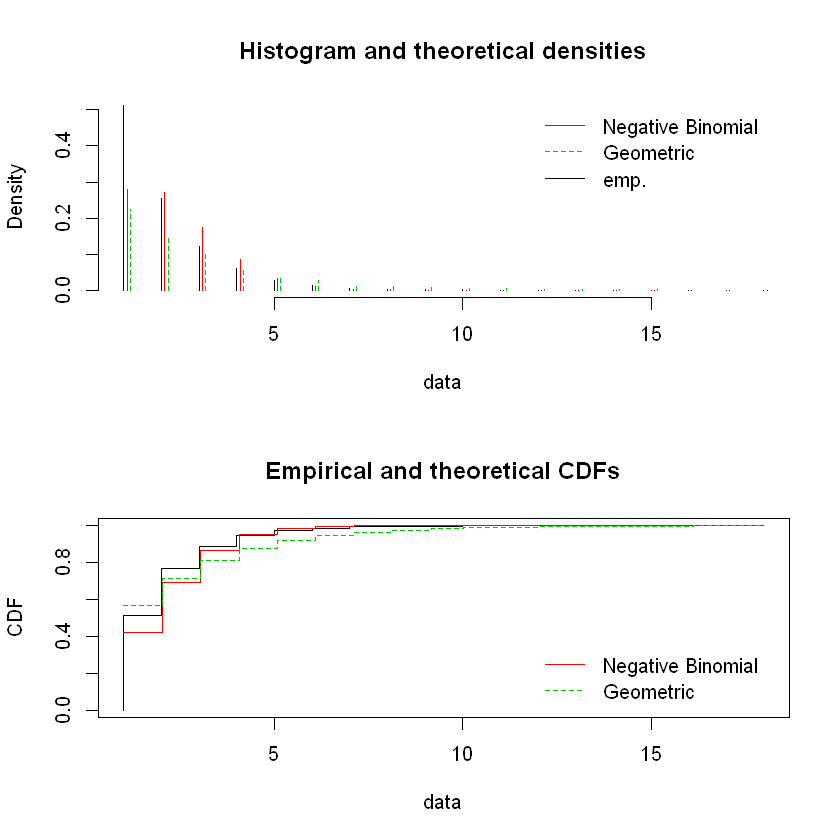

In [191]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJan, BCfd_GE_dJan), legendtext=plot.legend )

In [192]:
BCstatRes <- gofstat( list(BCfd_NB_dJan, BCfd_GE_dJan), fitnames=c("Negative Binomial", "Geometric") )

In [193]:
print(BCstatRes)

Chi-squared statistic:  67508.46 93068.39 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    351573            291195.0625     388624.175
<= 2    175418            185904.0510     101821.846
<= 3     83838            119987.1409      67137.887
<= 4     40726             58082.2411      44268.455
<= 5     18444             22492.8018      29189.125
<= 6      9133              7258.7869      19246.323
<= 7      4166              2007.8871      12690.375
<= 8      2187               485.9864       8367.605
> 8       2058               129.0422      16197.208

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2181951   2589457
Bayesian Information Criterion           2181974   2589468


In [194]:
BCfdNB_dJan_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [195]:
BCfdNB_dJan_p = BCfdNB_dJan_size / (BCfdNB_dJan_size + BCfdNB_dJan_mu)
cat("BCCA prob: ", BCfdNB_dJan_p)

BCCA prob:  0.9999931

In [196]:
# add to our tracking dataframe
BCMonDistDF[1, ] <- list( 1, dBCJanMean, dBCJanBNr, BCfdNB_dJan_p, BCfdNB_dJan_mu, BCfdNB_dJan_size,
                          BCfdNB_dJan_pvalue )

In [197]:
BCgf_dJan <- goodfit( dBCJan$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJan_size, prob=BCfdNB_dJan_p) )

In [198]:
summary( BCgf_dJan )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          3879824.0 18        0
Likelihood Ratio  338691.2 17        0


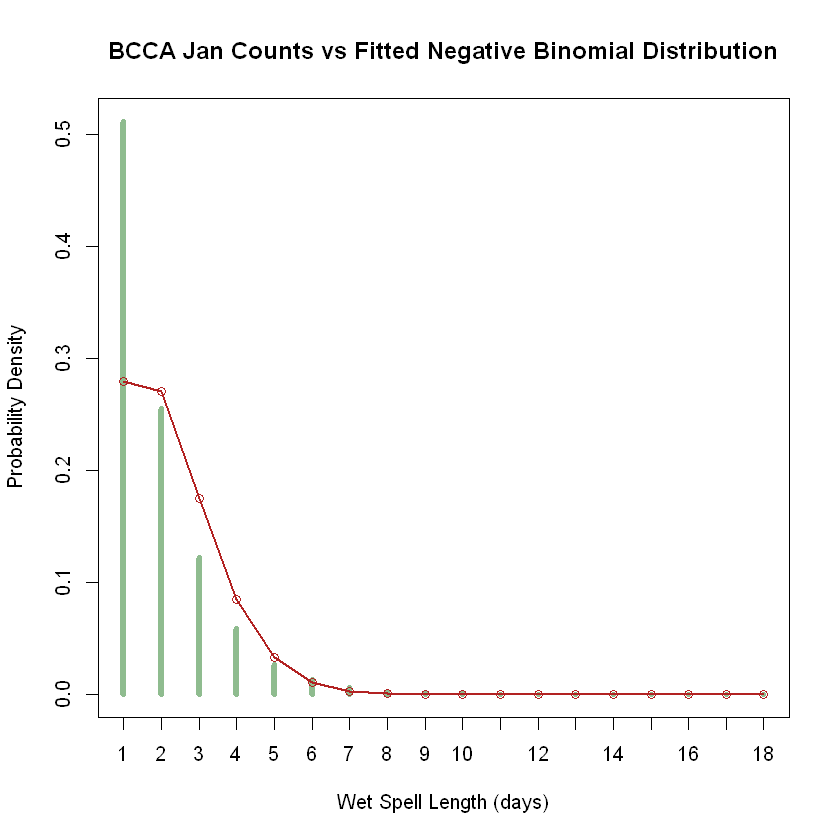

In [199]:
maxP <- max(dBCJan$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJan_size, mu=BCfdNB_dJan_mu )
ttab <- table( dBCJan$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jan Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

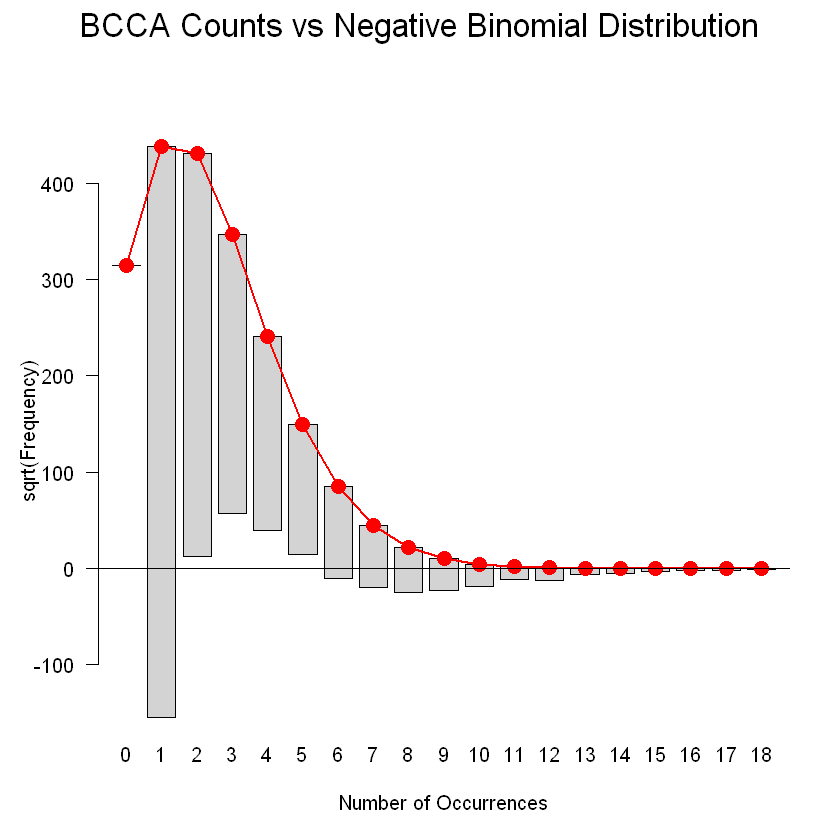

In [200]:
plot( BCgf_dJan, main="BCCA Counts vs Negative Binomial Distribution" )

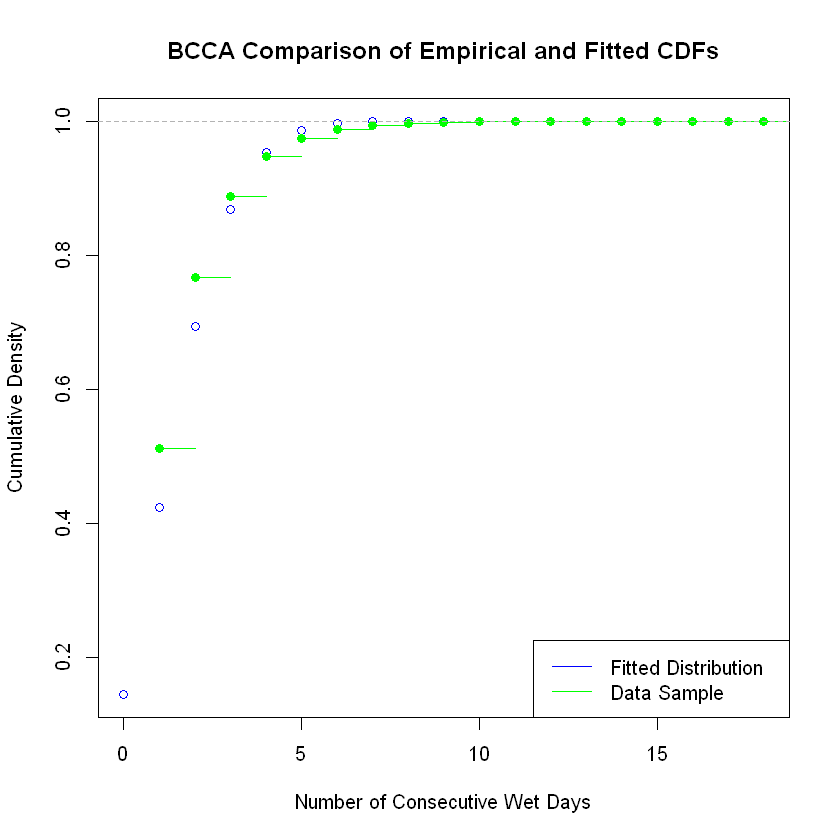

In [201]:
x <- seq(0,dBCJanMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJan_mu, size=BCfdNB_dJan_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJan$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

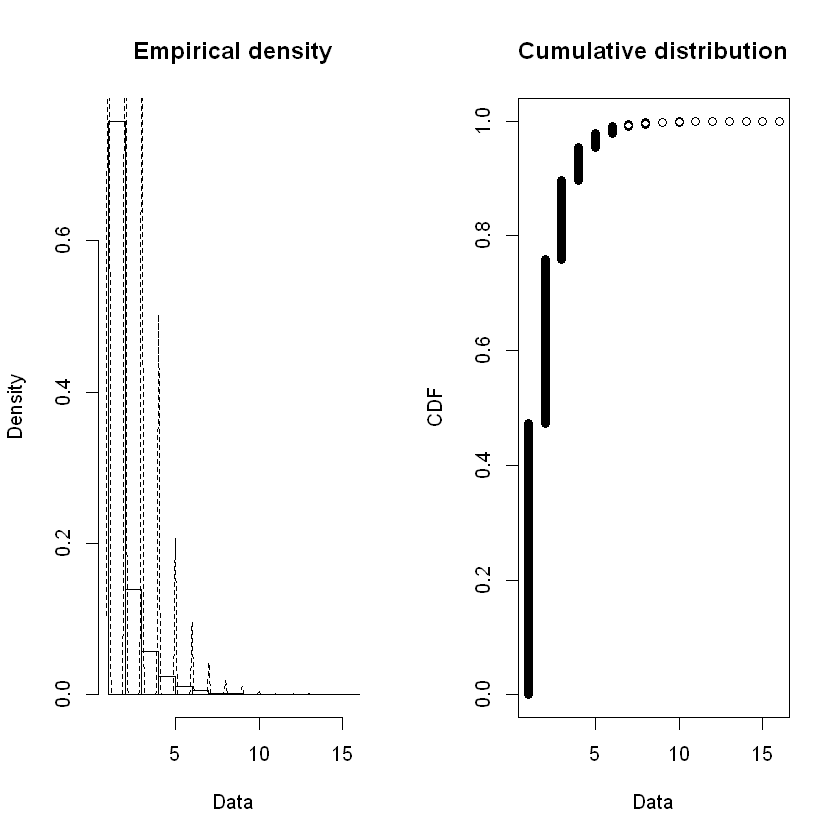

In [202]:
plotdist( dLOFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [203]:
LOfd_NB_dFeb <- fitdist( dLOFeb$Wet_Count, "nbinom" )
LOfd_GE_dFeb <- fitdist( dLOFeb$Wet_Count, "geom" )

In [204]:
LOfdNB_dFeb_size <- LOfd_NB_dFeb$estimate[["size"]]
LOfdNB_dFeb_mu <- LOfd_NB_dFeb$estimate[["mu"]]
cat("LOCA Feb size: ", LOfdNB_dFeb_size, "\n", "LOCA Feb mu: ", LOfdNB_dFeb_mu, "\n")

LOCA Feb size:  8404404 
 LOCA Feb mu:  1.957796 


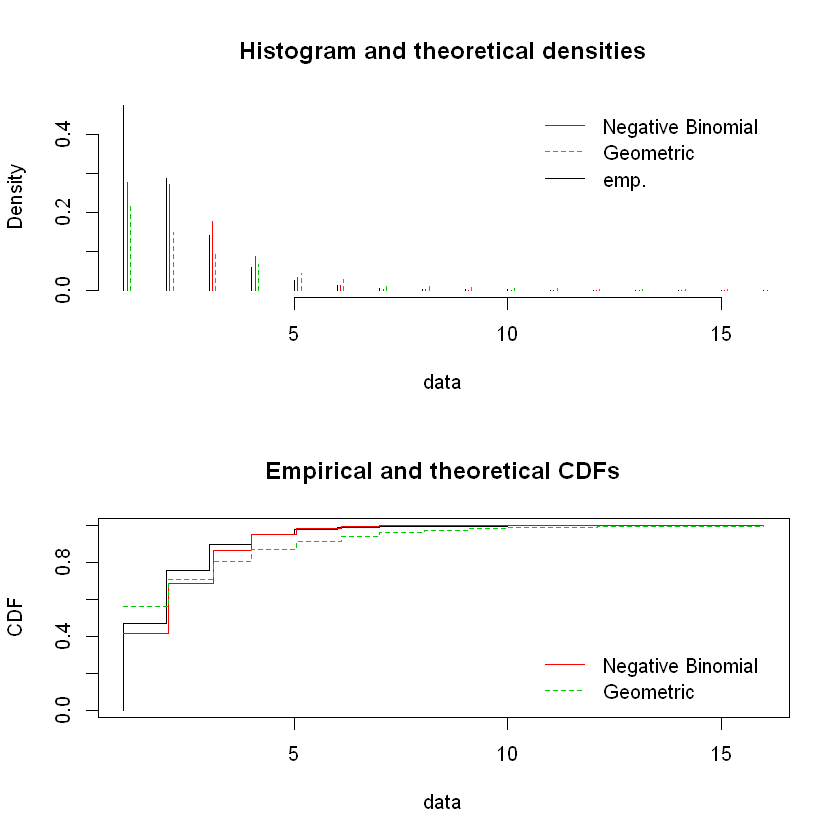

In [205]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dFeb, LOfd_GE_dFeb), legendtext=plot.legend )

In [206]:
LOstatRes <- gofstat( list(LOfd_NB_dFeb, LOfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [207]:
print( LOstatRes )

Chi-squared statistic:  74980.32 214342.4 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    467654           413281.03590      556122.63
<= 2    282772           267782.49817      146611.40
<= 3    137532           174754.54254       97044.50
<= 4     56869            85533.46647       64235.35
<= 5     24254            33491.43159       42518.44
<= 6     11201            10928.23828       28143.65
<= 7      4858             3056.46806       18628.75
<= 9      3368              910.70652       20492.55
> 9       1269               38.61246       15979.72

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3101762   3745916
Bayesian Information Criterion           3101786   3745928


In [208]:
LOfdNB_dFeb_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [209]:
LOfdNB_dFeb_p = LOfdNB_dFeb_size / (LOfdNB_dFeb_size + LOfdNB_dFeb_mu)
cat("LOCA prob: ", LOfdNB_dFeb_p)

LOCA prob:  0.9999998

In [210]:
# add to our tracking dataframe
LOMonDistDF[2, ] <- list( 2, dLOFebMean, dLOFebBNr, LOfdNB_dFeb_p, LOfdNB_dFeb_mu, LOfdNB_dFeb_size,
                          LOfdNB_dFeb_pvalue )

In [211]:
LOgf_dFeb <- goodfit( dLOFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dFeb_size, prob=LOfdNB_dFeb_p) )

In [212]:
summary( LOgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          2028236.4 16        0
Likelihood Ratio  429360.9 15        0


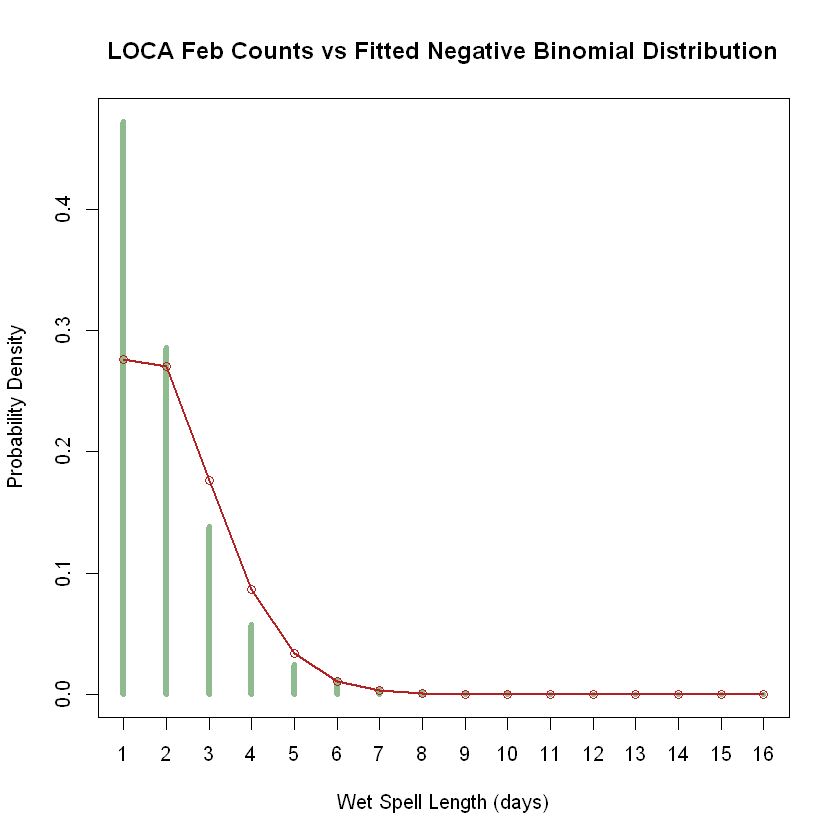

In [213]:
maxP <- max(dLOFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dFeb_size, mu=LOfdNB_dFeb_mu )
ttab <- table( dLOFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

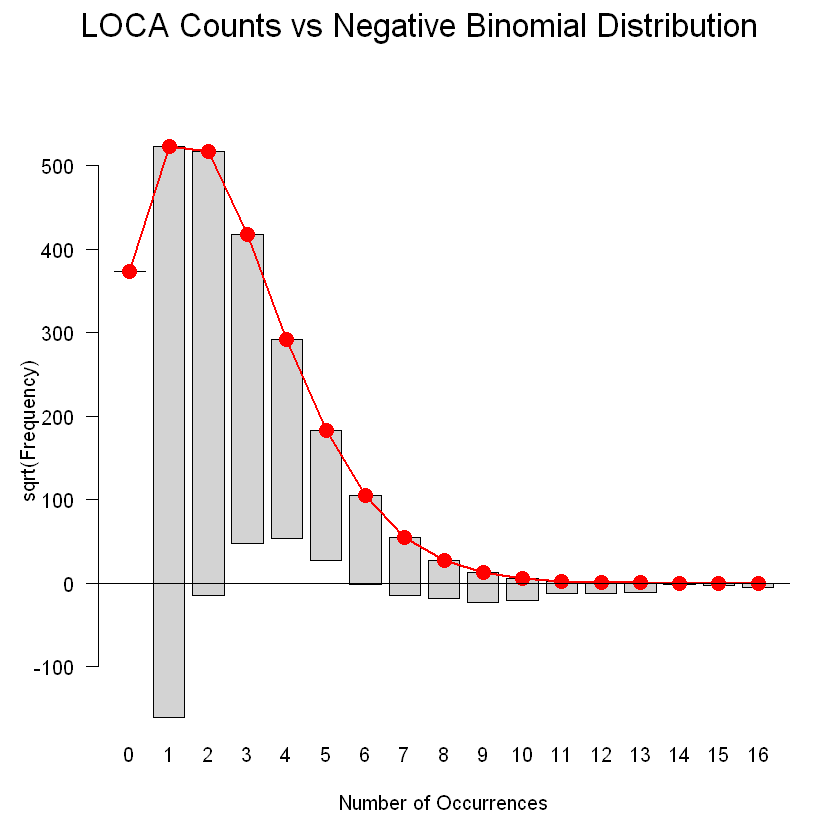

In [214]:
plot( LOgf_dFeb, main="LOCA Counts vs Negative Binomial Distribution" )

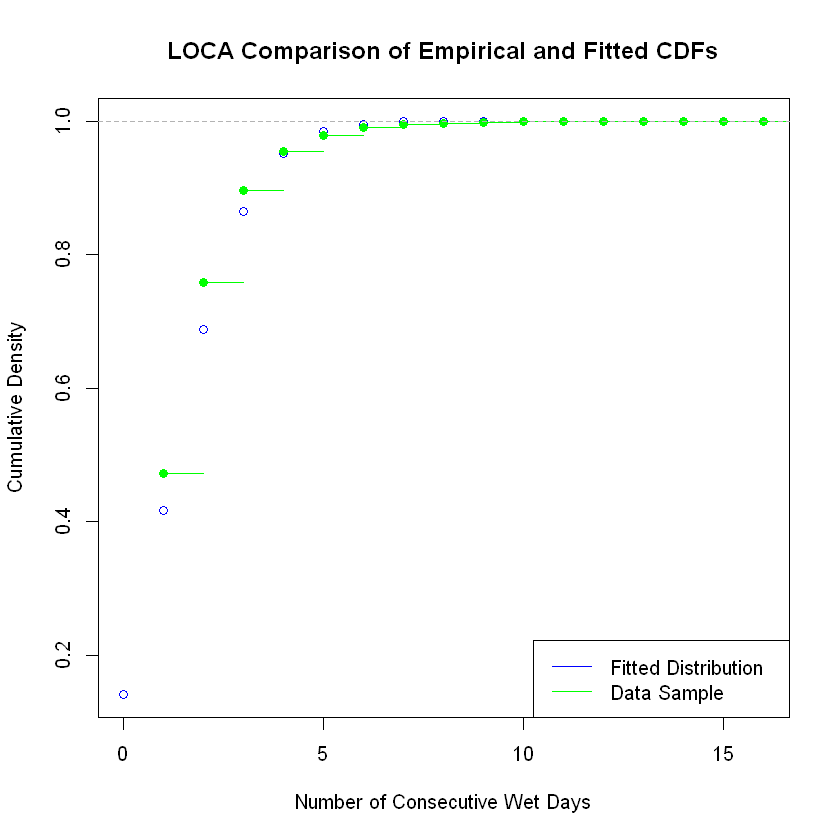

In [215]:
x <- seq(0,dLOFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dFeb_mu, size=LOfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

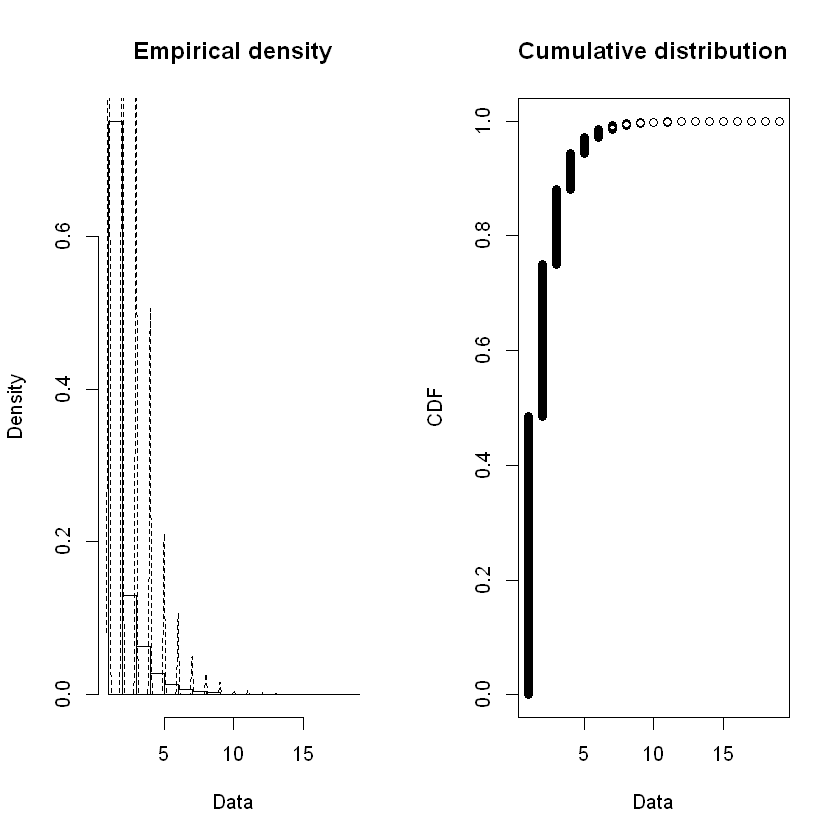

In [216]:
plotdist( dBCFeb$Wet_Count, histo=TRUE, demp=TRUE )

In [217]:
BCfd_NB_dFeb <- fitdist( dBCFeb$Wet_Count, "nbinom" )
BCfd_GE_dFeb <- fitdist( dBCFeb$Wet_Count, "geom" )

In [218]:
summary( BCfd_NB_dFeb )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 25516.565208         NaN
mu       1.999859 0.001712919
Loglikelihood:  -1103178   AIC:  2206361   BIC:  2206384 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [219]:
BCfdNB_dFeb_size <- BCfd_NB_dFeb$estimate[["size"]]
BCfdNB_dFeb_mu <- BCfd_NB_dFeb$estimate[["mu"]]
cat("BCCA Feb size: ", BCfdNB_dFeb_size, "\n", "BCCA Feb mu: ", BCfdNB_dFeb_mu, "\n")

BCCA Feb size:  25516.57 
 BCCA Feb mu:  1.999859 


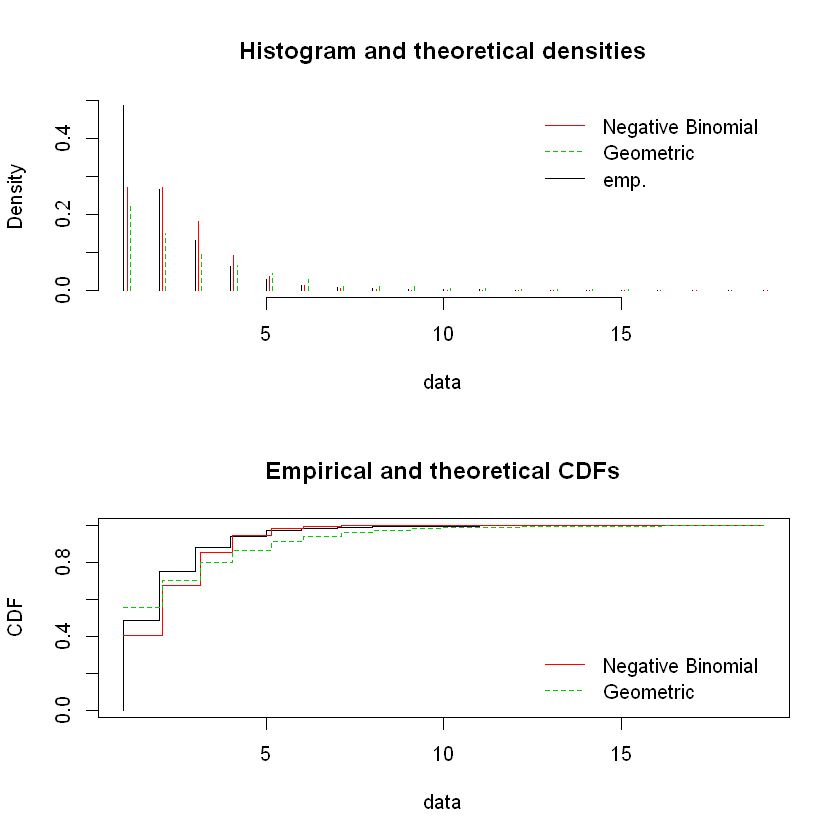

In [220]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dFeb, BCfd_GE_dFeb), legendtext=plot.legend )

In [221]:
BCstatRes <- gofstat( list(BCfd_NB_dFeb, BCfd_GE_dFeb), fitnames=c("Negative Binomial", "Geometric") )

In [222]:
print(BCstatRes)

Chi-squared statistic:  220042.8 107365.6 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     331190           2.767647e+05     378662.573
<= 2     180415           1.844805e+05     100977.037
<= 3      88436           1.229783e+05      67318.171
<= 4      43051           6.148726e+04      44878.878
<= 5      19293           2.459510e+04      29919.317
<= 6       9181           8.198755e+03      19946.255
<= 7       4629           2.342704e+03      13297.532
<= 8       2422           5.857496e+02       8865.041
<= 10      2012           1.562309e+02       9850.075
> 10        966           5.667347e+00       7880.122

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2206361   2603079
Bayesian Information Criterion           2206384   2603090


In [223]:
BCfdNB_dFeb_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [224]:
BCfdNB_dFeb_p = BCfdNB_dFeb_size / (BCfdNB_dFeb_size + BCfdNB_dFeb_mu)
cat("BCCA prob: ", BCfdNB_dFeb_p)

BCCA prob:  0.9999216

In [225]:
# add to our tracking dataframe
BCMonDistDF[2, ] <- list( 2, dBCFebMean, dBCFebBNr, BCfdNB_dFeb_p, BCfdNB_dFeb_mu, BCfdNB_dFeb_size,
                          BCfdNB_dFeb_pvalue )

In [226]:
BCgf_dFeb <- goodfit( dBCFeb$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dFeb_size, prob=BCfdNB_dFeb_p) )

In [227]:
summary( BCgf_dFeb )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          11432861.5 19        0
Likelihood Ratio   318312.1 18        0


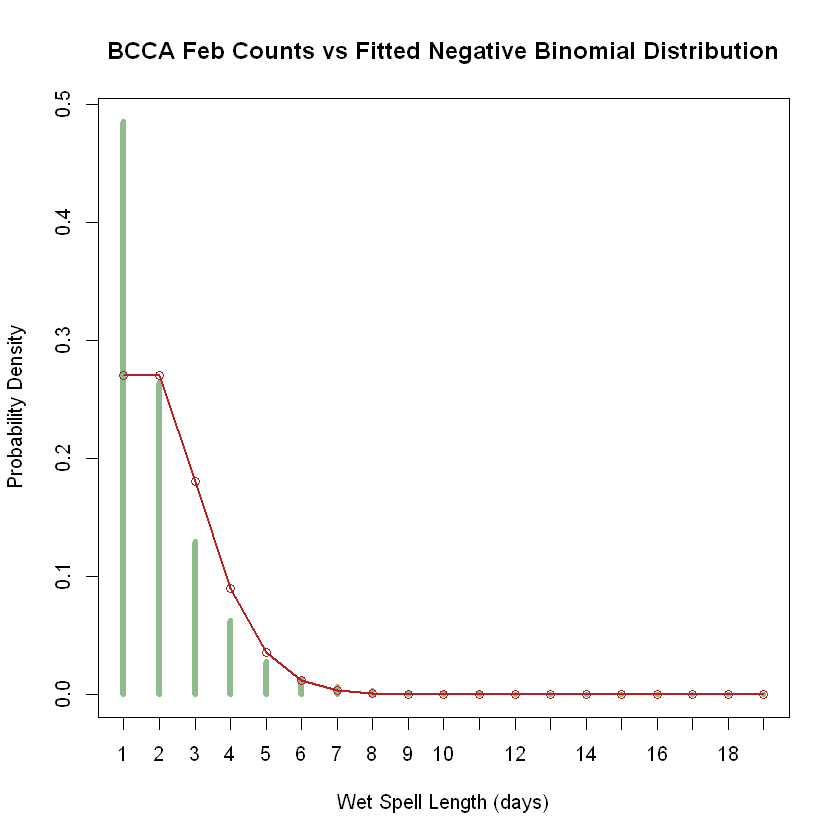

In [228]:
maxP <- max(dBCFeb$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dFeb_size, mu=BCfdNB_dFeb_mu )
ttab <- table( dBCFeb$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Feb Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

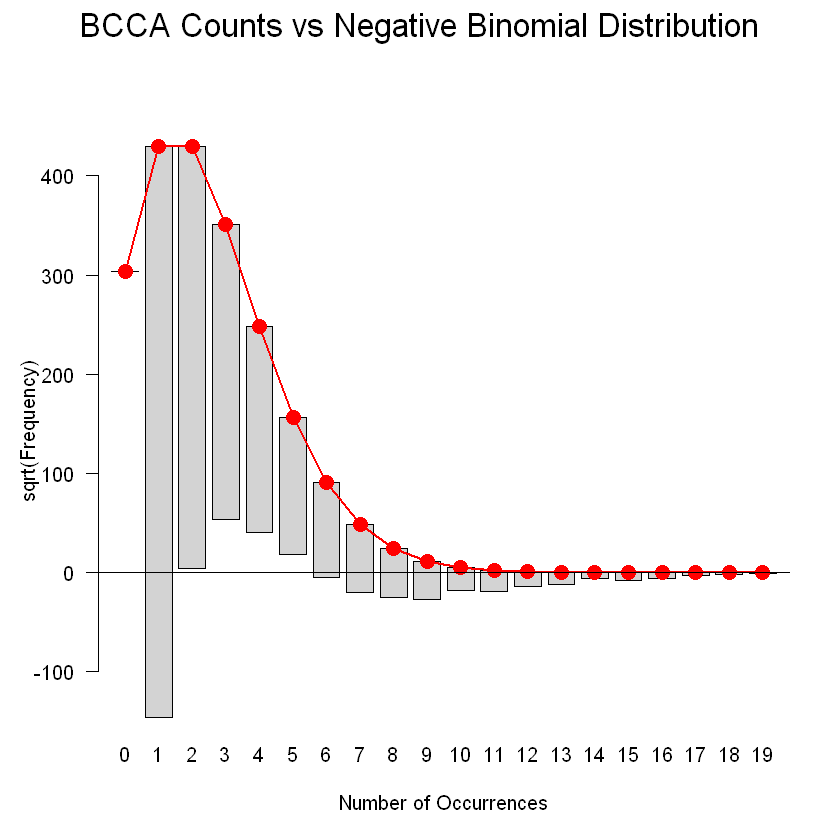

In [229]:
plot( BCgf_dFeb, main="BCCA Counts vs Negative Binomial Distribution" )

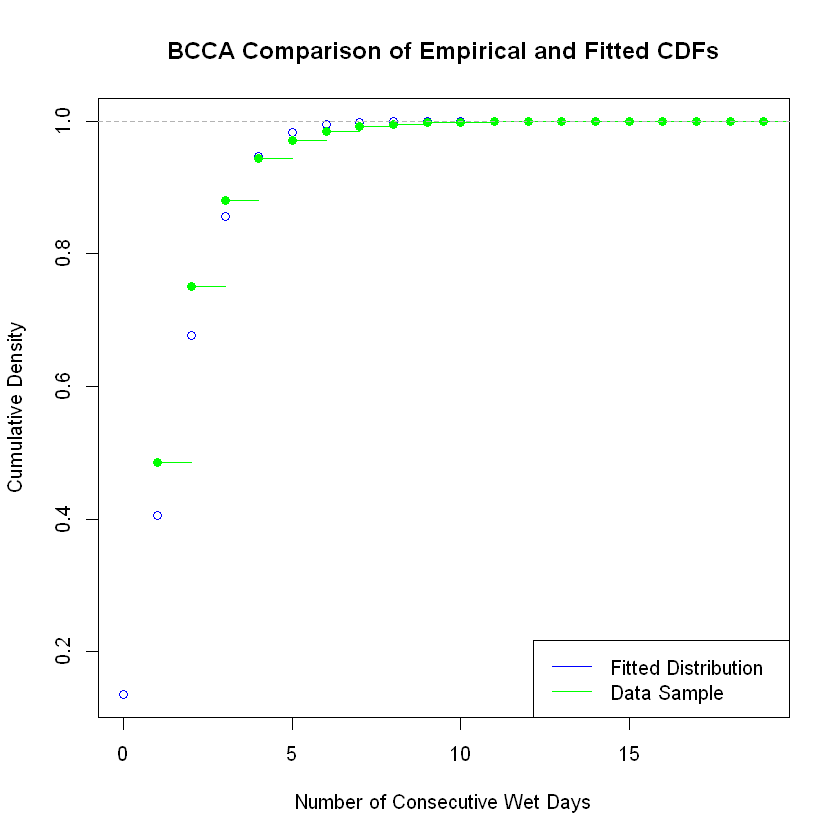

In [230]:
x <- seq(0,dBCFebMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dFeb_mu, size=BCfdNB_dFeb_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCFeb$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

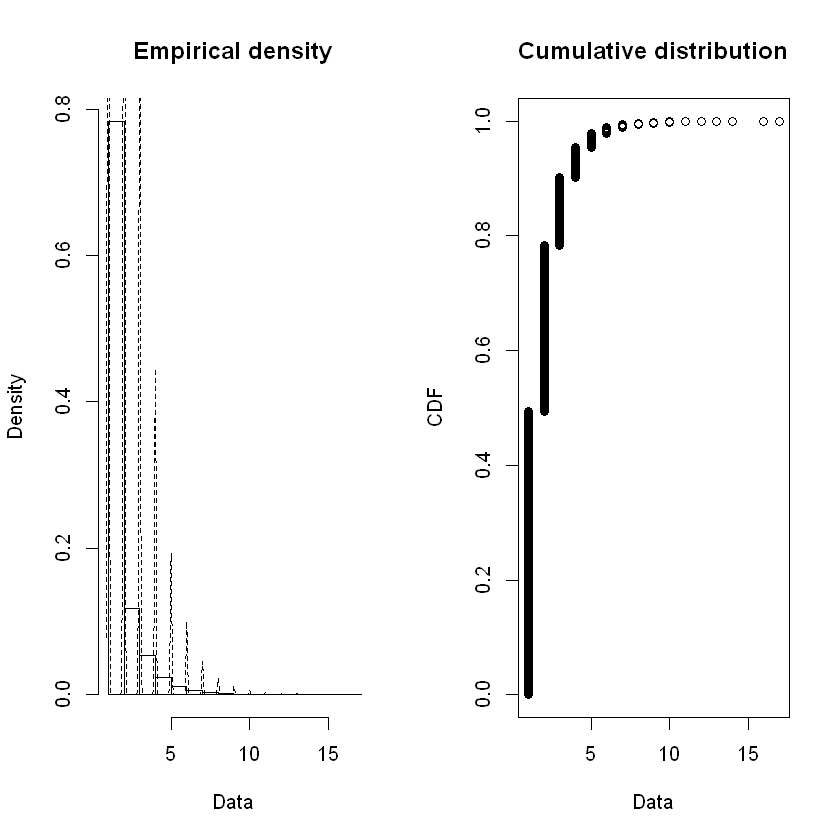

In [231]:
plotdist( dLOMar$Wet_Count, histo=TRUE, demp=TRUE )

In [232]:
LOfd_NB_dMar <- fitdist( dLOMar$Wet_Count, "nbinom" )
LOfd_GE_dMar <- fitdist( dLOMar$Wet_Count, "geom" )

In [233]:
LOfdNB_dMar_size <- LOfd_NB_dMar$estimate[["size"]]
LOfdNB_dMar_mu <- LOfd_NB_dMar$estimate[["mu"]]
cat("LOCA Mar size: ", LOfdNB_dMar_size, "\n", "LOCA Mar mu: ", LOfdNB_dMar_mu, "\n")

LOCA Mar size:  2648692 
 LOCA Mar mu:  1.91156 


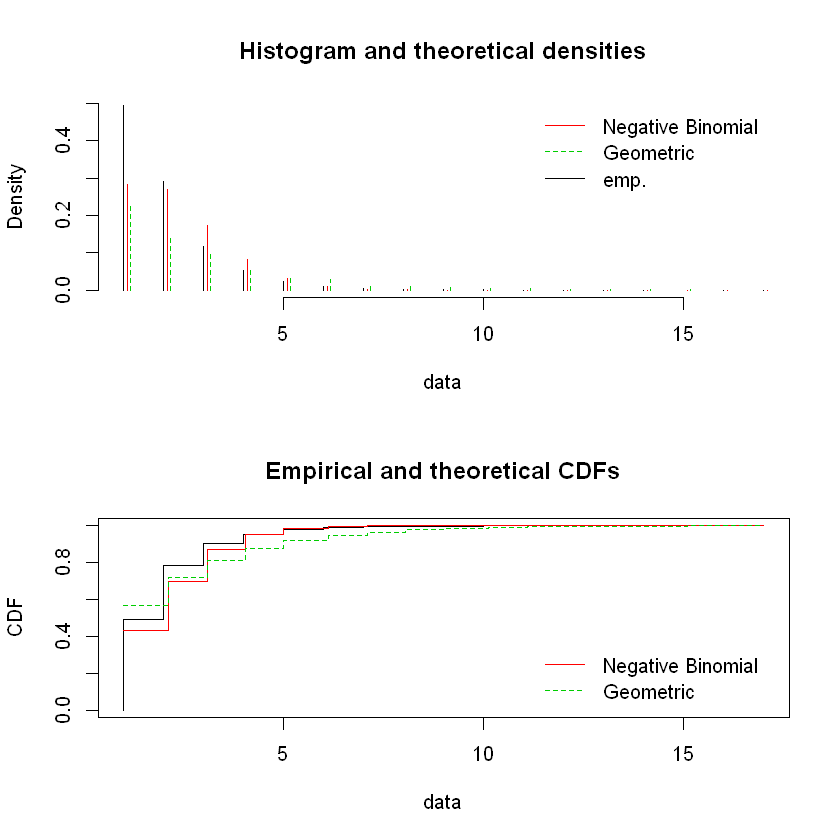

In [234]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMar, LOfd_GE_dMar), legendtext=plot.legend )

In [235]:
LOstatRes <- gofstat( list(LOfd_NB_dMar, LOfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [236]:
print( LOstatRes )

Chi-squared statistic:  104649.3 218822.8 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    529680            462012.3738      610606.57
<= 2    311319            289916.8979      158894.09
<= 3    126679            184731.2040      104324.19
<= 4     57047             88281.2390       68495.55
<= 5     25022             33751.0066       44971.73
<= 6     11696             10752.8592       29526.84
<= 7      5731              2936.3956       19386.27
<= 8      2805               701.6384       12728.33
> 8       3288               183.3855       24333.43

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3345779   4020667
Bayesian Information Criterion           3345803   4020679


In [237]:
LOfdNB_dMar_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [238]:
LOfdNB_dMar_p = LOfdNB_dMar_size / (LOfdNB_dMar_size + LOfdNB_dMar_mu)
cat("LOCA prob: ", LOfdNB_dMar_p)

LOCA prob:  0.9999993

In [239]:
# add to our tracking dataframe
LOMonDistDF[3, ] <- list( 3, dLOMarMean, dLOMarBNr, LOfdNB_dMar_p, LOfdNB_dMar_mu, LOfdNB_dMar_size,
                          LOfdNB_dMar_pvalue )

In [240]:
LOgf_dMar <- goodfit( dLOMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMar_size, prob=LOfdNB_dMar_p) )

In [241]:
summary( LOgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          2266657.3 17        0
Likelihood Ratio  516043.3 15        0


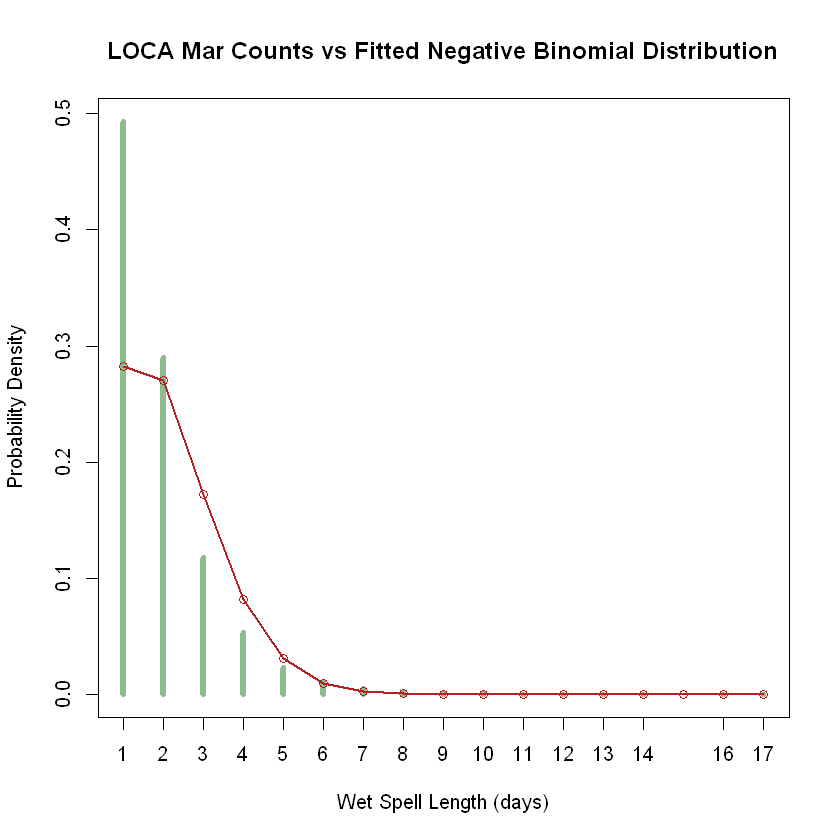

In [242]:
maxP <- max(dLOMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMar_size, mu=LOfdNB_dMar_mu )
ttab <- table( dLOMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

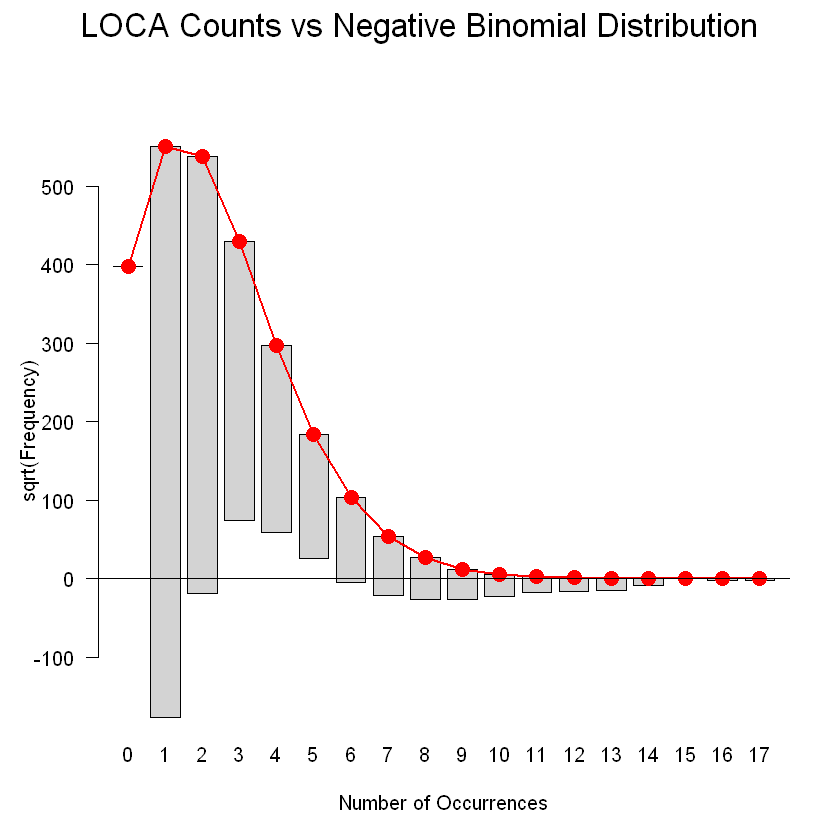

In [243]:
plot( LOgf_dMar, main="LOCA Counts vs Negative Binomial Distribution" )

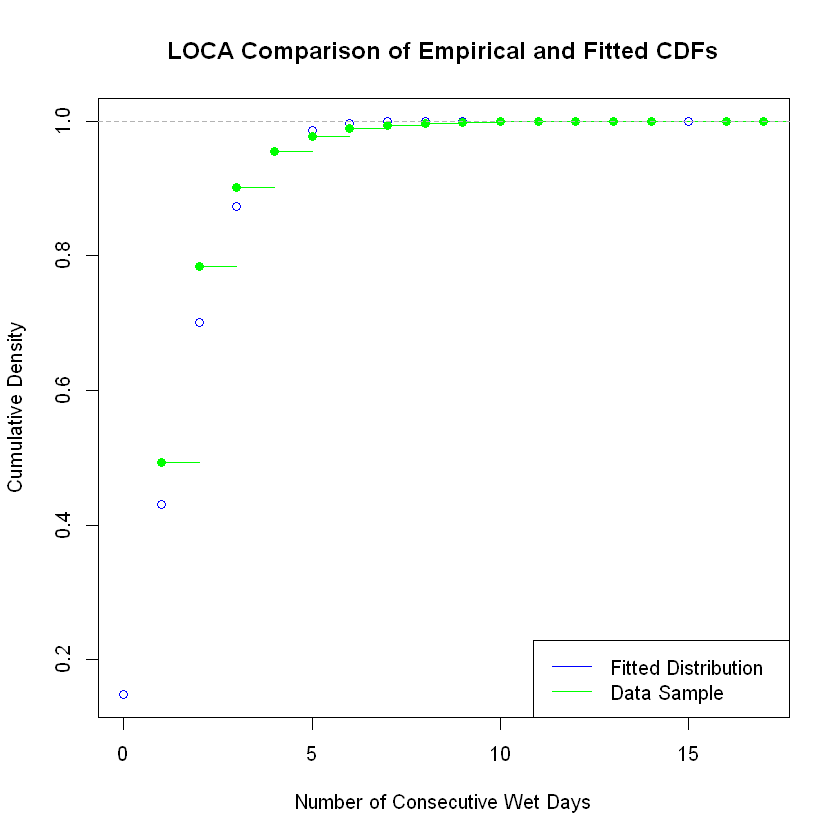

In [244]:
x <- seq(0,dLOMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMar_mu, size=LOfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

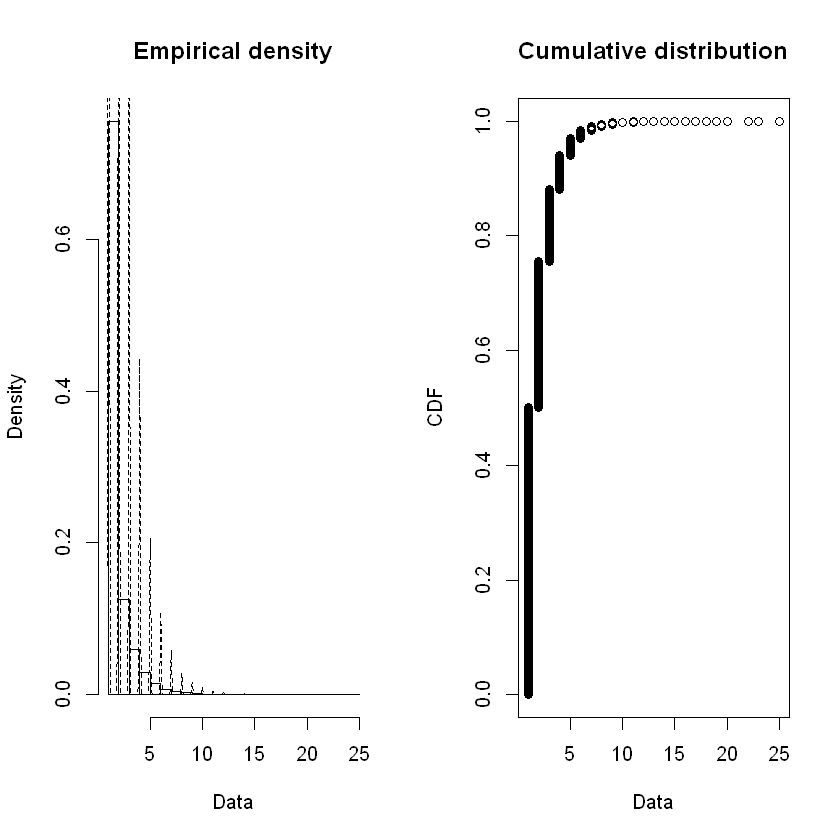

In [245]:
plotdist( dBCMar$Wet_Count, histo=TRUE, demp=TRUE )

In [246]:
BCfd_NB_dMar <- fitdist( dBCMar$Wet_Count, "nbinom" )
BCfd_GE_dMar <- fitdist( dBCMar$Wet_Count, "geom" )

In [247]:
summary( BCfd_NB_dMar )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
       estimate  Std. Error
size 106.431407 7.592797155
mu     1.991626 0.001621479
Loglikelihood:  -1257759   AIC:  2515523   BIC:  2515546 
Correlation matrix:
             size           mu
size 1.0000000000 0.0001254098
mu   0.0001254098 1.0000000000


In [248]:
BCfdNB_dMar_size <- BCfd_NB_dMar$estimate[["size"]]
BCfdNB_dMar_mu <- BCfd_NB_dMar$estimate[["mu"]]
cat("BCCA Mar size: ", BCfdNB_dMar_size, "\n", "BCCA Mar mu: ", BCfdNB_dMar_mu, "\n")

BCCA Mar size:  106.4314 
 BCCA Mar mu:  1.991626 


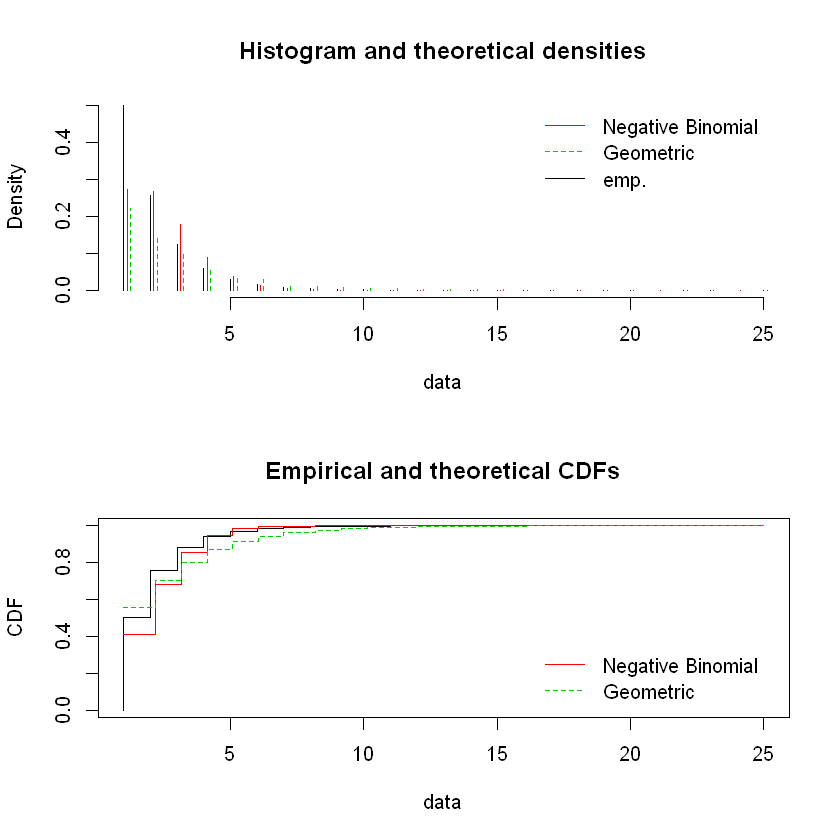

In [249]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMar, BCfd_GE_dMar), legendtext=plot.legend )

In [250]:
BCstatRes <- gofstat( list(BCfd_NB_dMar, BCfd_GE_dMar), fitnames=c("Negative Binomial", "Geometric") )

In [251]:
print(BCstatRes)

Chi-squared statistic:  257215 103348.2 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     385818           3.169566e+05     429607.368
<= 2     197098           2.069091e+05     114311.210
<= 3      96537           1.373724e+05      76103.189
<= 4      45954           6.903475e+04      50666.031
<= 5      22750           2.800764e+04      33731.132
<= 6      11002           9.554744e+03      22456.649
<= 7       5434           2.818998e+03      14950.613
<= 8       3013           7.342167e+02       9953.436
<= 10      2746           2.078398e+02      11038.194
> 10       1253           8.591955e+00       8787.177

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2515523   2941695
Bayesian Information Criterion           2515546   2941707


In [252]:
BCfdNB_dMar_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [253]:
BCfdNB_dMar_p = BCfdNB_dMar_size / (BCfdNB_dMar_size + BCfdNB_dMar_mu)
cat("BCCA prob: ", BCfdNB_dMar_p)

BCCA prob:  0.981631

In [254]:
# add to our tracking dataframe
BCMonDistDF[3, ] <- list( 3, dBCMarMean, dBCMarBNr, BCfdNB_dMar_p, BCfdNB_dMar_mu, BCfdNB_dMar_size,
                          BCfdNB_dMar_pvalue )

In [255]:
BCgf_dMar <- goodfit( dBCMar$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMar_size, prob=BCfdNB_dMar_p) )

In [256]:
summary( BCgf_dMar )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 25      NaN
Likelihood Ratio 386057.4 22        0


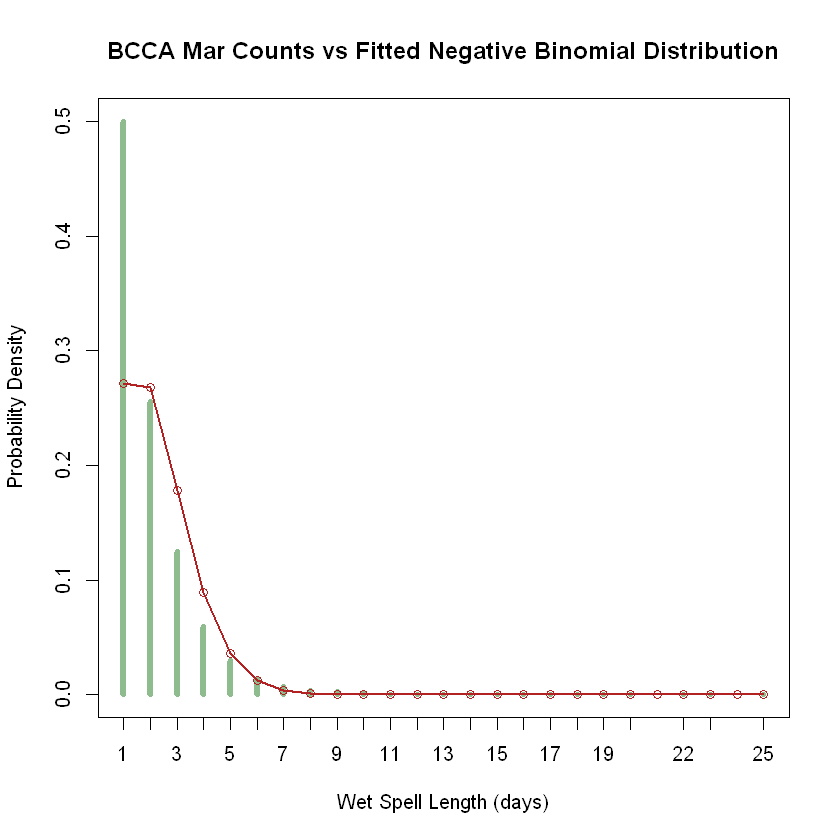

In [257]:
maxP <- max(dBCMar$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMar_size, mu=BCfdNB_dMar_mu )
ttab <- table( dBCMar$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Mar Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

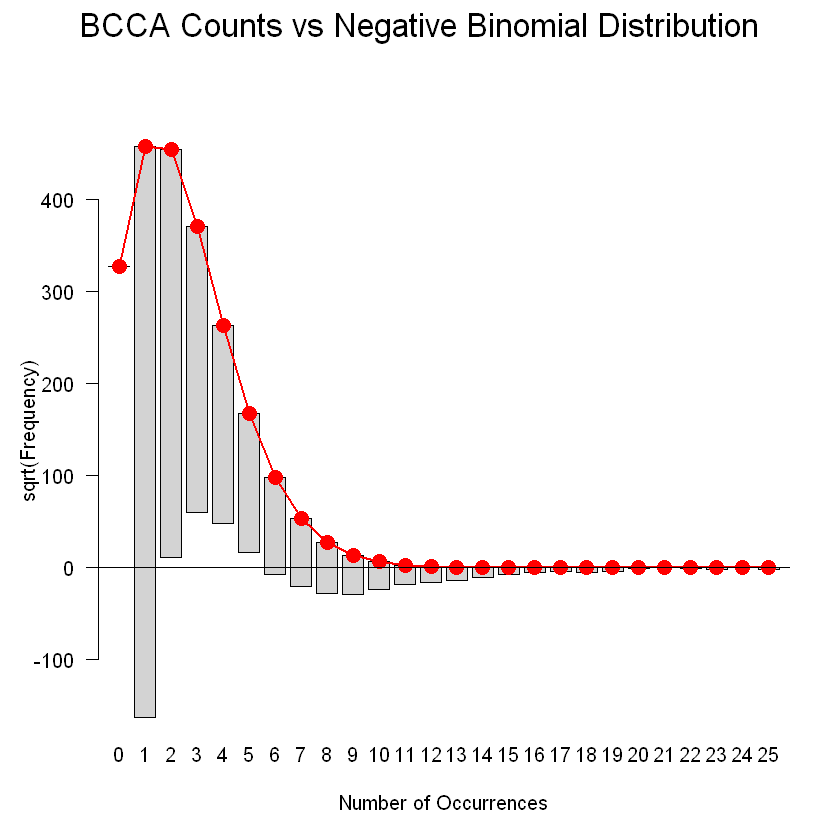

In [258]:
plot( BCgf_dMar, main="BCCA Counts vs Negative Binomial Distribution" )

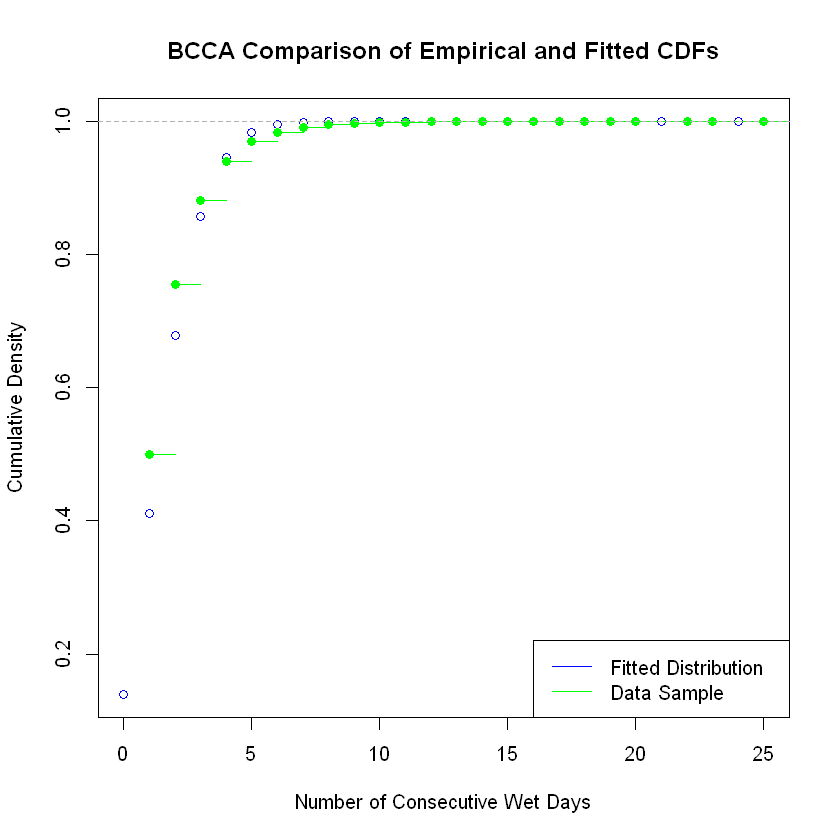

In [259]:
x <- seq(0,dBCMarMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMar_mu, size=BCfdNB_dMar_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMar$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

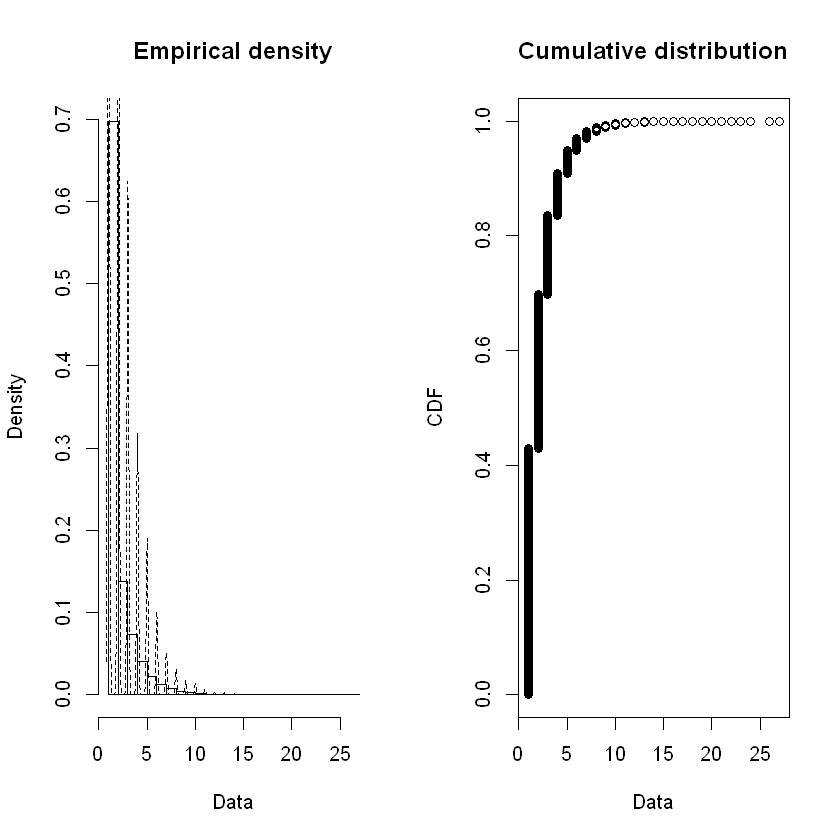

In [260]:
plotdist( dLOApr$Wet_Count, histo=TRUE, demp=TRUE )

In [261]:
LOfd_NB_dApr <- fitdist( dLOApr$Wet_Count, "nbinom" )
LOfd_GE_dApr <- fitdist( dLOApr$Wet_Count, "geom" )

In [262]:
LOfdNB_dApr_size <- LOfd_NB_dApr$estimate[["size"]]
LOfdNB_dApr_mu <- LOfd_NB_dApr$estimate[["mu"]]
cat("LOCA Apr size: ", LOfdNB_dApr_size, "\n", "LOCA Apr mu: ", LOfdNB_dApr_mu, "\n")

LOCA Apr size:  13.88546 
 LOCA Apr mu:  2.253877 


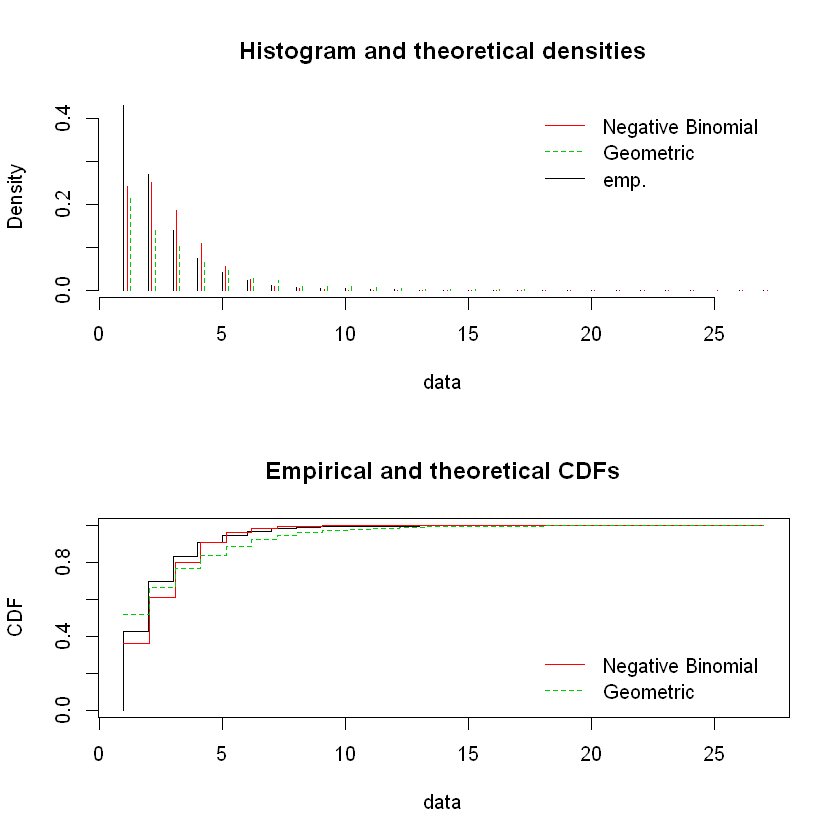

In [263]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dApr, LOfd_GE_dApr), legendtext=plot.legend )

In [264]:
LOstatRes <- gofstat( list(LOfd_NB_dApr, LOfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [265]:
print( LOstatRes )

Chi-squared statistic:  313892.8 202033.1 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     524467            445424.2222     636487.196
<= 2     329069            305448.4875     180420.214
<= 3     169125            225871.2833     124974.394
<= 4      88993            133155.2917      86567.901
<= 5      49333             66517.0609      59964.295
<= 6      27008             29238.4190      41536.374
<= 7      14522             11599.4129      28771.628
<= 8       8547              4228.9699      19929.678
<= 9       4617              1436.1252      13804.991
<= 10      3534               458.9829       9562.512
<= 12      2600               179.4896      11212.023
> 12       1758                15.2550      10341.794

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           4316290   4912653
Bayesia

In [266]:
LOfdNB_dApr_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [267]:
LOfdNB_dApr_p = LOfdNB_dApr_size / (LOfdNB_dApr_size + LOfdNB_dApr_mu)
cat("LOCA prob: ", LOfdNB_dApr_p)

LOCA prob:  0.8603488

In [268]:
# add to our tracking dataframe
LOMonDistDF[4, ] <- list( 4, dLOAprMean, dLOAprBNr, LOfdNB_dApr_p, LOfdNB_dApr_mu, LOfdNB_dApr_size,
                          LOfdNB_dApr_pvalue )

In [269]:
LOgf_dApr <- goodfit( dLOApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dApr_size, prob=LOfdNB_dApr_p) )

In [270]:
summary( LOgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1782621994.8 27        0
Likelihood Ratio     533254.4 25        0


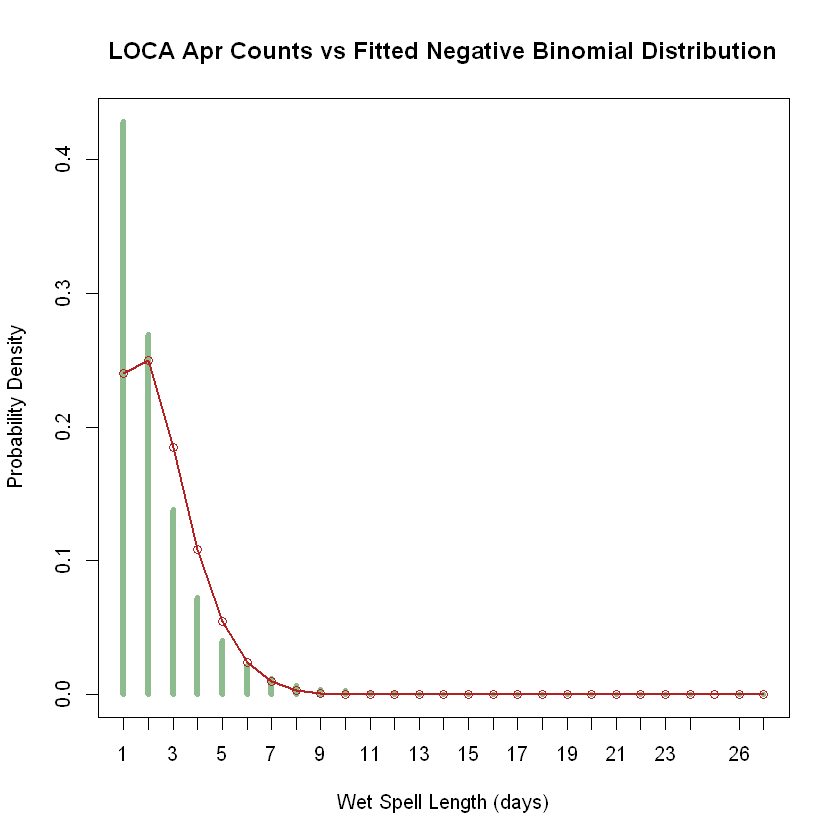

In [271]:
maxP <- max(dLOApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dApr_size, mu=LOfdNB_dApr_mu )
ttab <- table( dLOApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

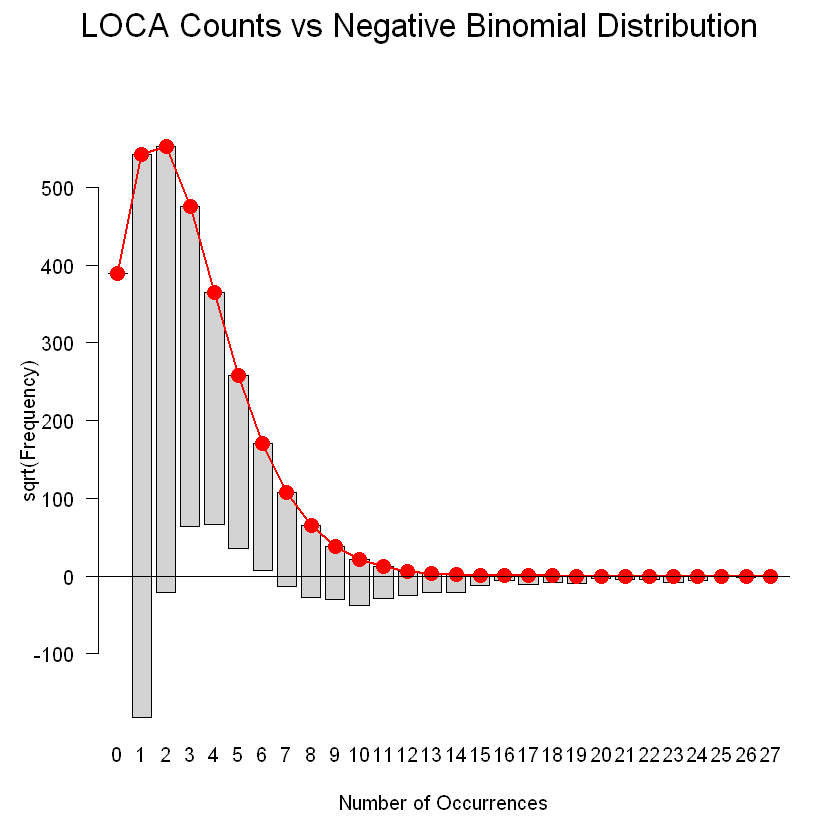

In [272]:
plot( LOgf_dApr, main="LOCA Counts vs Negative Binomial Distribution" )

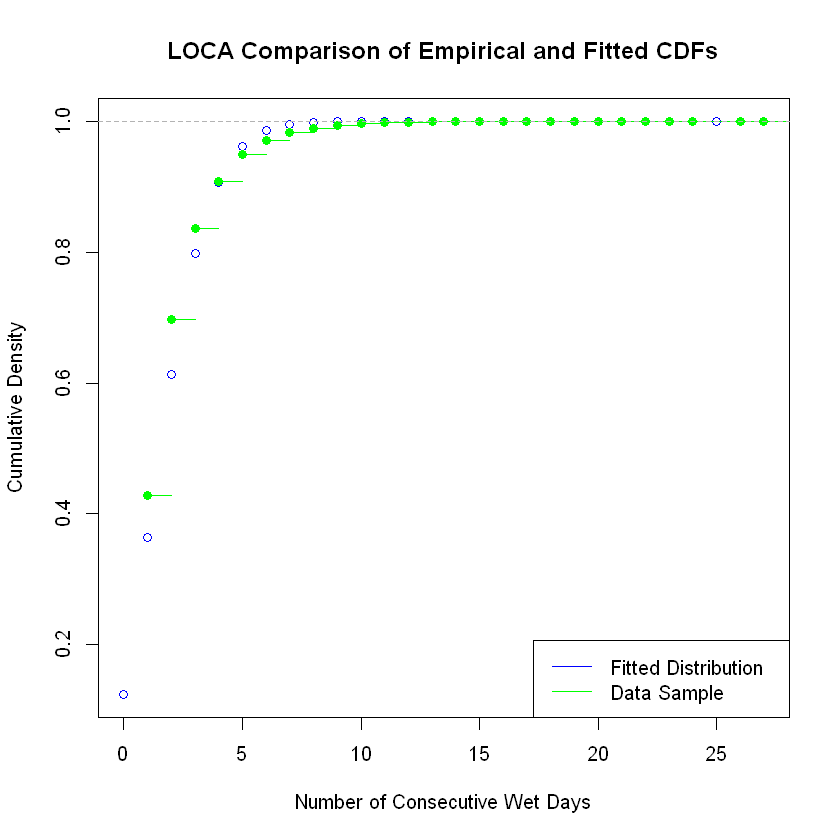

In [273]:
x <- seq(0,dLOAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dApr_mu, size=LOfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

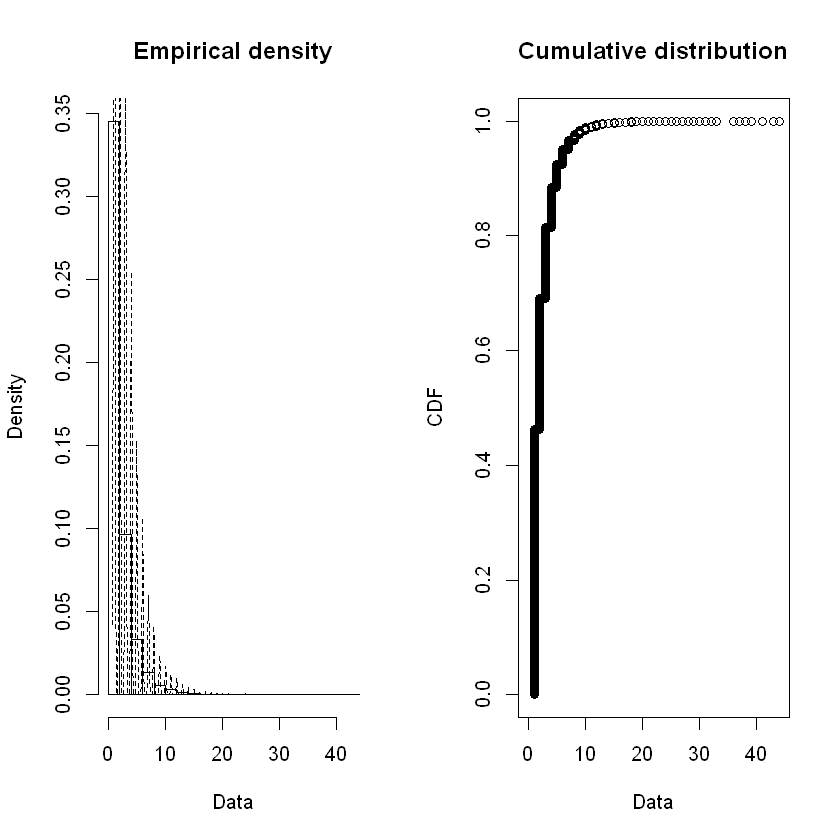

In [274]:
plotdist( dBCApr$Wet_Count, histo=TRUE, demp=TRUE )

In [275]:
BCfd_NB_dApr <- fitdist( dBCApr$Wet_Count, "nbinom" )
BCfd_GE_dApr <- fitdist( dBCApr$Wet_Count, "geom" )

In [276]:
summary( BCfd_NB_dApr )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 4.839053 0.019814415
mu   2.386152 0.002082818
Loglikelihood:  -1552677   AIC:  3105357   BIC:  3105381 
Correlation matrix:
             size           mu
size 1.000000e+00 4.367116e-05
mu   4.367116e-05 1.000000e+00


In [277]:
BCfdNB_dApr_size <- BCfd_NB_dApr$estimate[["size"]]
BCfdNB_dApr_mu <- BCfd_NB_dApr$estimate[["mu"]]
cat("BCCA Apr size: ", BCfdNB_dApr_size, "\n", "BCCA Apr mu: ", BCfdNB_dApr_mu, "\n")

BCCA Apr size:  4.839053 
 BCCA Apr mu:  2.386152 


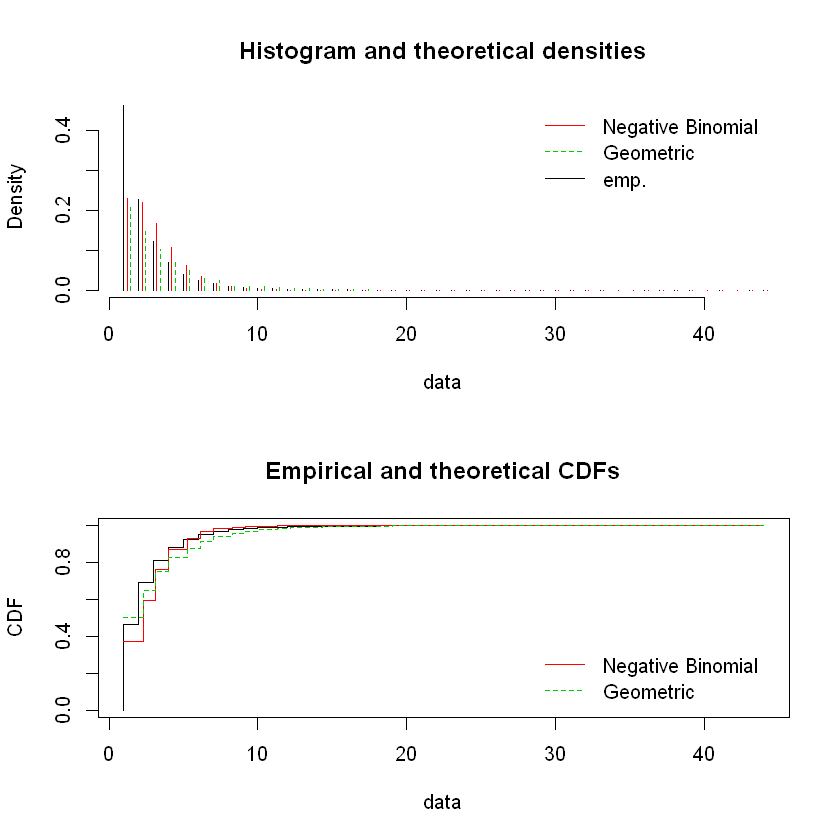

In [278]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dApr, BCfd_GE_dApr), legendtext=plot.legend )

In [279]:
BCstatRes <- gofstat( list(BCfd_NB_dApr, BCfd_GE_dApr), fitnames=c("Negative Binomial", "Geometric") )

In [280]:
print(BCstatRes)

Chi-squared statistic:  485843.8 60597.17 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     380350           3.066884e+05     413425.960
<= 2     187169           1.818894e+05     120432.580
<= 3     101309           1.369399e+05      84867.073
<= 4      57668           8.863016e+04      59804.582
<= 5      33245           5.174461e+04      42143.412
<= 6      20947           2.802303e+04      29697.845
<= 7      13619           1.433033e+04      20927.636
<= 8       8479           7.003757e+03      14747.398
<= 9       5352           3.299662e+03      10392.275
<= 10      3598           1.508077e+03       7323.284
<= 11      2745           6.718696e+02       5160.611
<= 13      3167           4.181601e+02       6199.270
<= 16      2107           8.354526e+01       3975.205
> 16       1482           6.025996e+00       2139.871

Goodness-of-fit criteria
                

In [281]:
BCfdNB_dApr_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [282]:
BCfdNB_dApr_p = BCfdNB_dApr_size / (BCfdNB_dApr_size + BCfdNB_dApr_mu)
cat("BCCA prob: ", BCfdNB_dApr_p)

BCCA prob:  0.6697462

In [283]:
# add to our tracking dataframe
BCMonDistDF[4, ] <- list( 4, dBCAprMean, dBCAprBNr, BCfdNB_dApr_p, BCfdNB_dApr_mu, BCfdNB_dApr_size,
                          BCfdNB_dApr_pvalue )

In [284]:
BCgf_dApr <- goodfit( dBCApr$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dApr_size, prob=BCfdNB_dApr_p) )

In [285]:
summary( BCgf_dApr )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               Inf 44        0
Likelihood Ratio 460702.3 39        0


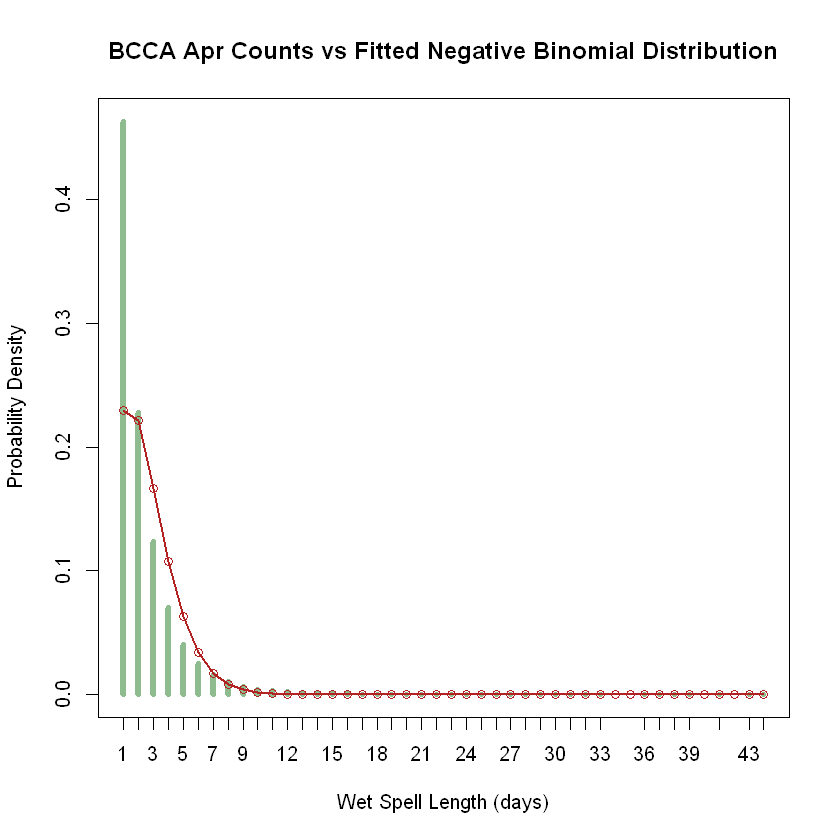

In [286]:
maxP <- max(dBCApr$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dApr_size, mu=BCfdNB_dApr_mu )
ttab <- table( dBCApr$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Apr Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

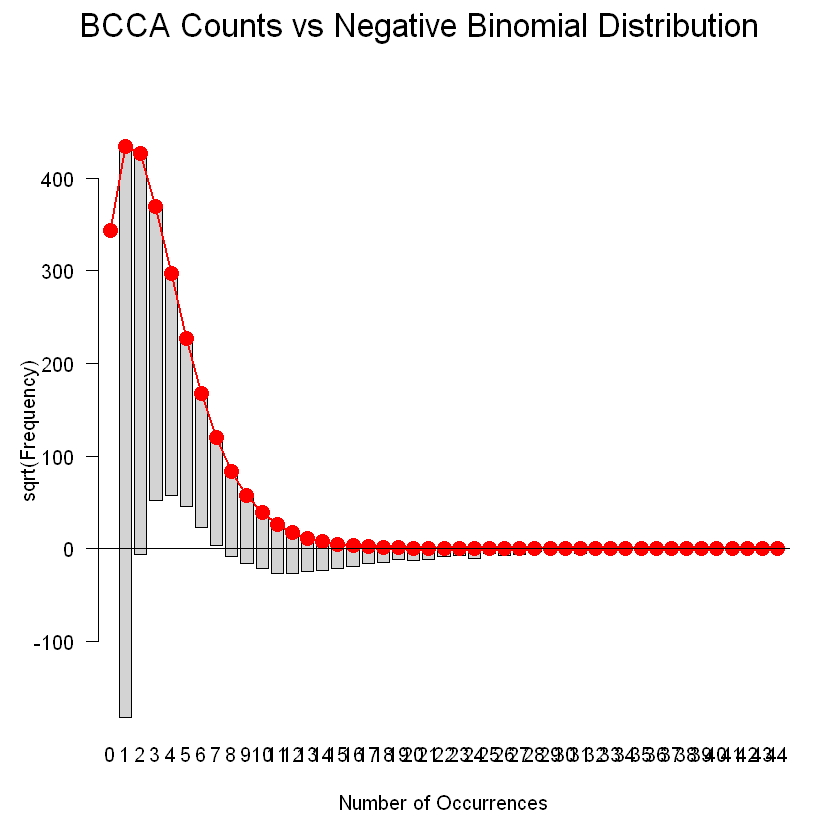

In [287]:
plot( BCgf_dApr, main="BCCA Counts vs Negative Binomial Distribution" )

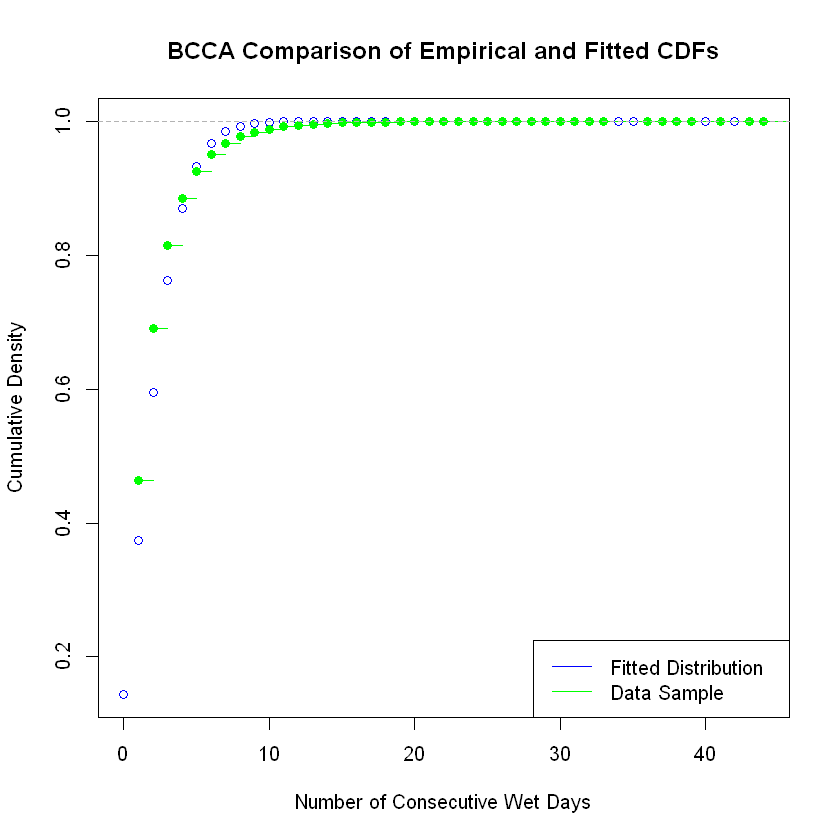

In [288]:
x <- seq(0,dBCAprMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dApr_mu, size=BCfdNB_dApr_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCApr$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

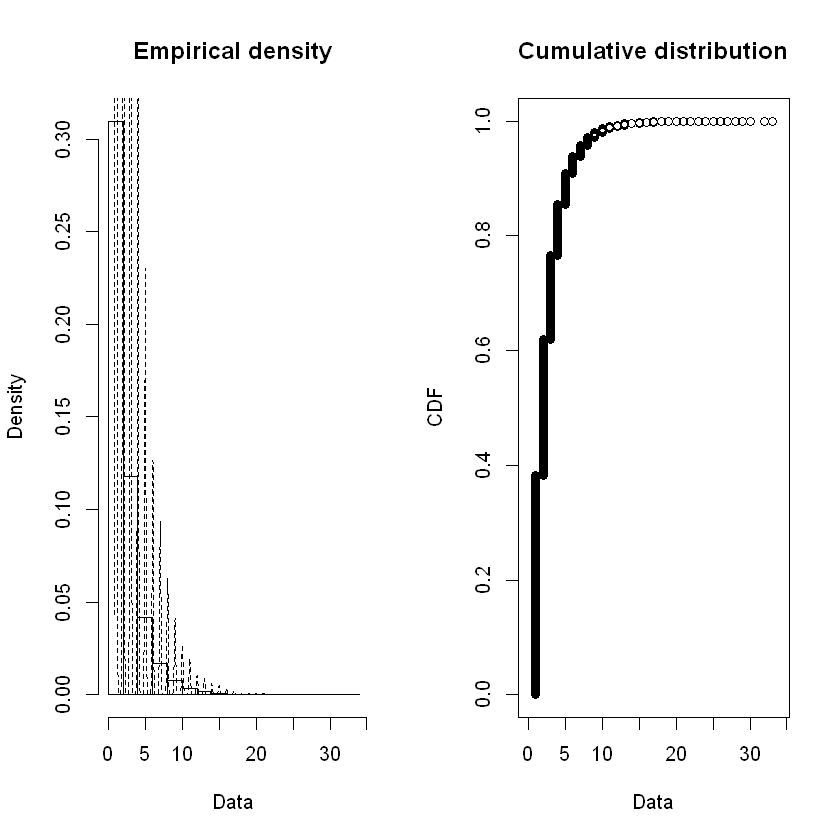

In [289]:
plotdist( dLOMay$Wet_Count, histo=TRUE, demp=TRUE )

In [290]:
LOfd_NB_dMay <- fitdist( dLOMay$Wet_Count, "nbinom" )
LOfd_GE_dMay <- fitdist( dLOMay$Wet_Count, "geom" )

In [291]:
LOfdNB_dMay_size <- LOfd_NB_dMay$estimate[["size"]]
LOfdNB_dMay_mu <- LOfd_NB_dMay$estimate[["mu"]]
cat("LOCA May size: ", LOfdNB_dMay_size, "\n", "LOCA May mu: ", LOfdNB_dMay_mu, "\n")

LOCA May size:  5.009902 
 LOCA May mu:  2.663717 


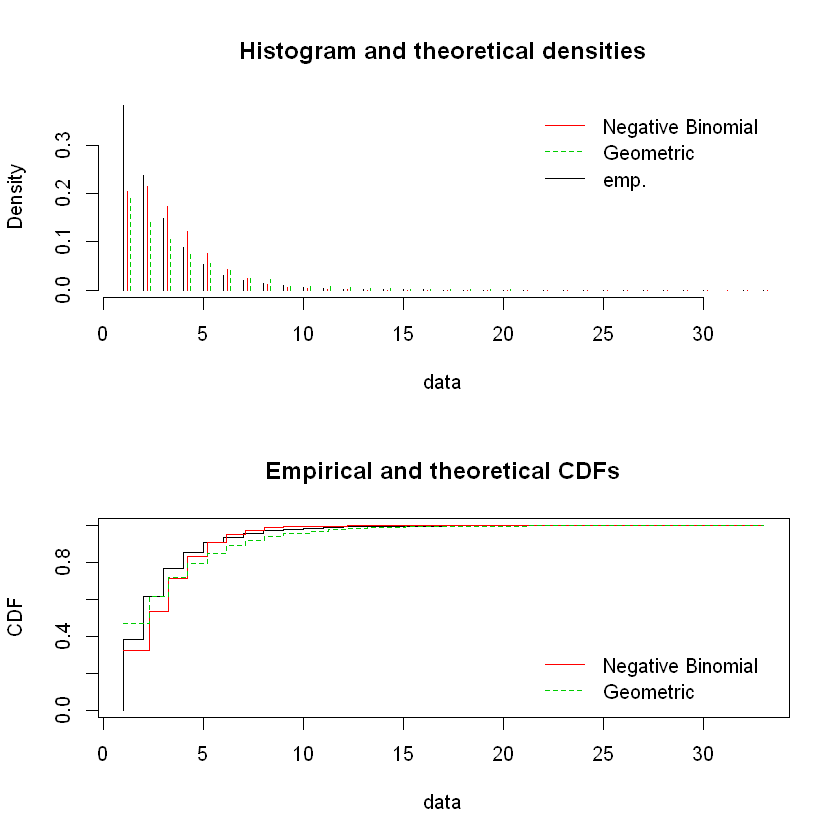

In [292]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dMay, LOfd_GE_dMay), legendtext=plot.legend )

In [293]:
LOstatRes <- gofstat( list(LOfd_NB_dMay, LOfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [294]:
print( LOstatRes )

Chi-squared statistic:  247773.5 170371.7 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     548141            464030.1381     676086.404
<= 2     339870            307316.0990     206936.952
<= 3     211867            249266.4360     150456.188
<= 4     125587            173268.1798     109391.117
<= 5      77262            108381.8778      79534.227
<= 6      42856             62765.7959      57826.388
<= 7      27636             34268.5908      42043.423
<= 8      20490             17858.0285      30568.215
<= 9      13090              8960.9245      22225.016
<= 10      8884              4357.8844      16158.985
<= 11      5995              2064.1852      11748.599
<= 12      3418               955.9692       8541.971
<= 13      2883               434.2003       6210.551
<= 15      3396               279.1904       7798.485
> 15       2897                64.5002    

In [295]:
LOfdNB_dMay_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [296]:
LOfdNB_dMay_p = LOfdNB_dMay_size / (LOfdNB_dMay_size + LOfdNB_dMay_mu)
cat("LOCA prob: ", LOfdNB_dMay_p)

LOCA prob:  0.6528735

In [297]:
# add to our tracking dataframe
LOMonDistDF[5, ] <- list( 5, dLOMayMean, dLOMayBNr, LOfdNB_dMay_p, LOfdNB_dMay_mu, LOfdNB_dMay_size,
                          LOfdNB_dMay_pvalue )

In [298]:
LOgf_dMay <- goodfit( dLOMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dMay_size, prob=LOfdNB_dMay_p) )

In [299]:
summary( LOgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          10354764.4 33        0
Likelihood Ratio   606872.5 31        0


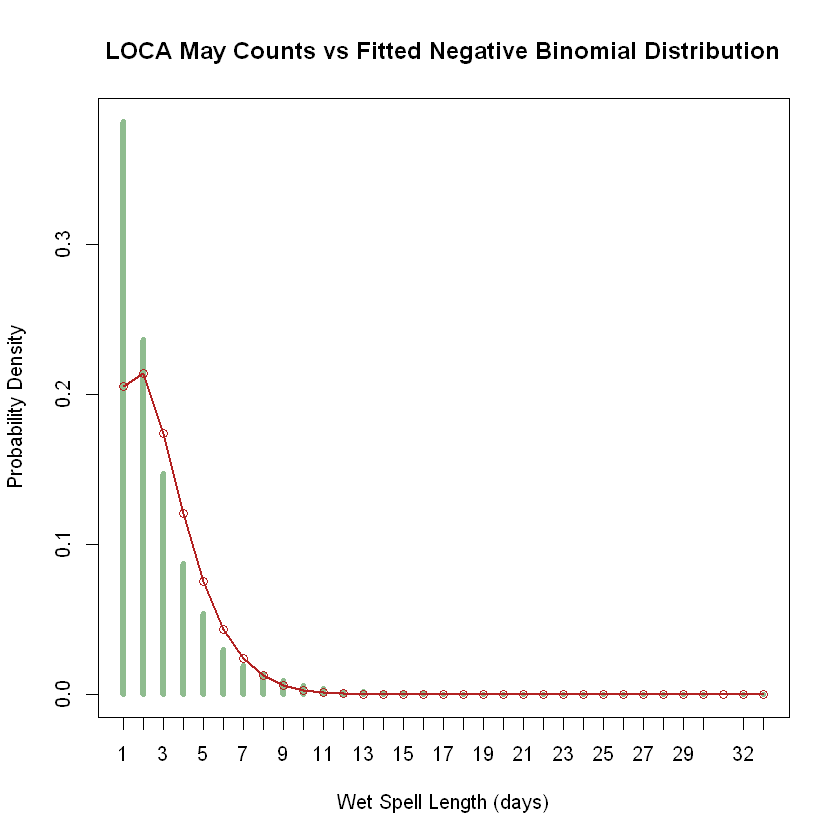

In [300]:
maxP <- max(dLOMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dMay_size, mu=LOfdNB_dMay_mu )
ttab <- table( dLOMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

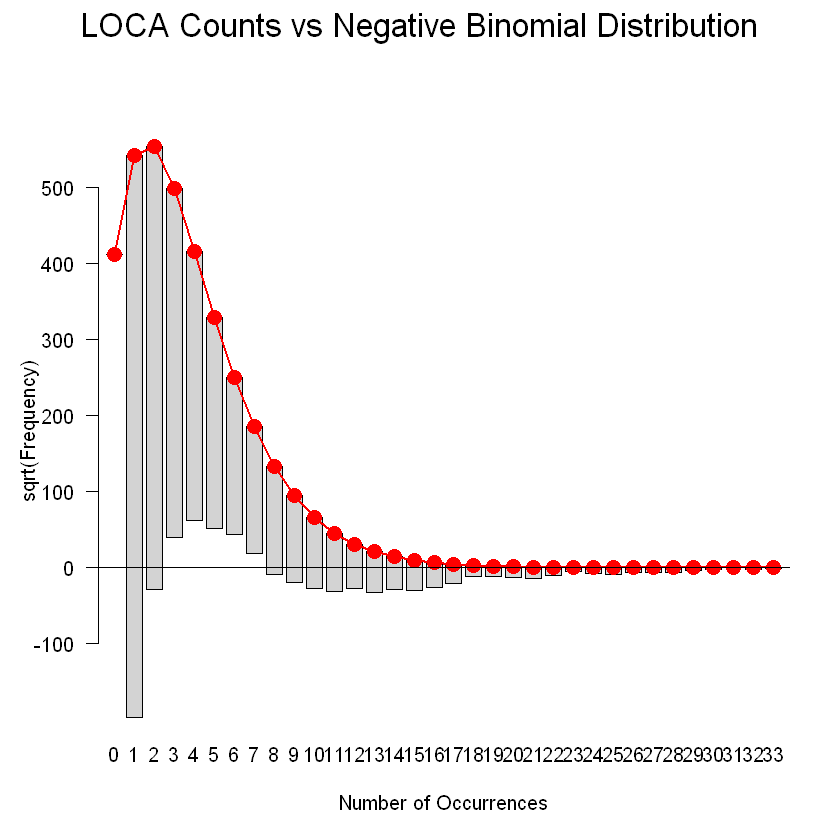

In [301]:
plot( LOgf_dMay, main="LOCA Counts vs Negative Binomial Distribution" )

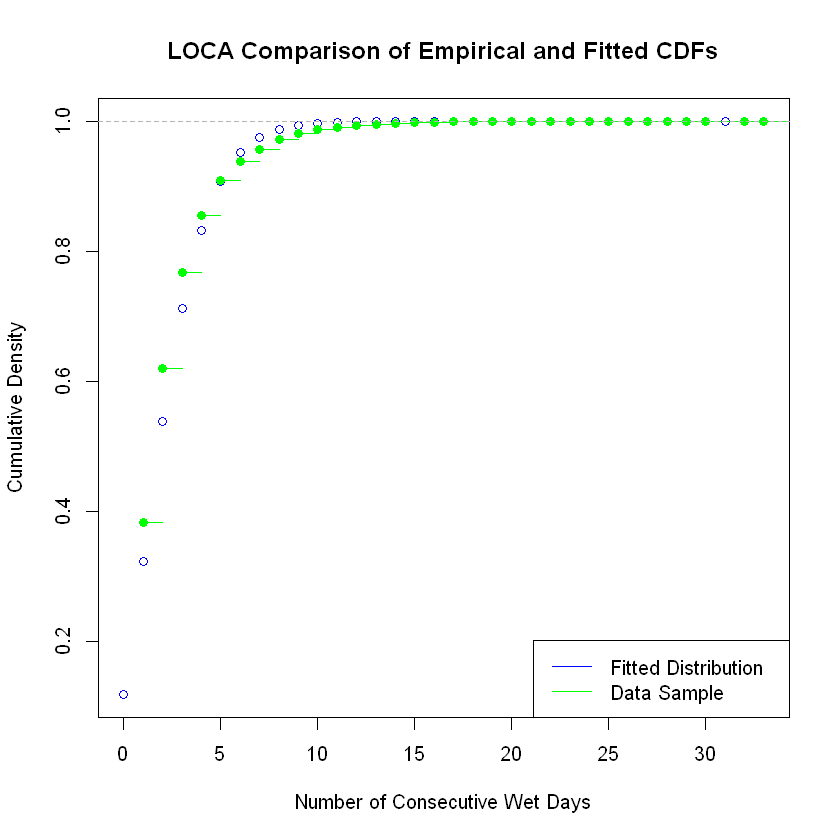

In [302]:
x <- seq(0,dLOMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dMay_mu, size=LOfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

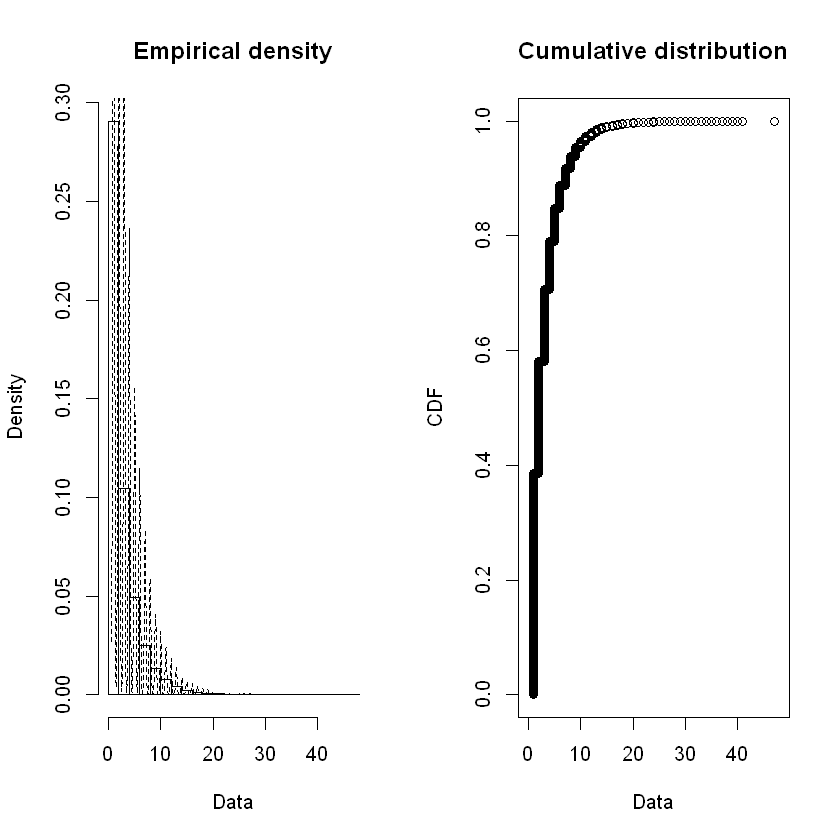

In [303]:
plotdist( dBCMay$Wet_Count, histo=TRUE, demp=TRUE )

In [304]:
BCfd_NB_dMay <- fitdist( dBCMay$Wet_Count, "nbinom" )
BCfd_GE_dMay <- fitdist( dBCMay$Wet_Count, "geom" )

In [305]:
summary( BCfd_NB_dMay )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.617779 0.006777343
mu   3.133523 0.002810378
Loglikelihood:  -1909140   AIC:  3818284   BIC:  3818308 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001867563
mu   -0.0001867563  1.0000000000


In [306]:
BCfdNB_dMay_size <- BCfd_NB_dMay$estimate[["size"]]
BCfdNB_dMay_mu <- BCfd_NB_dMay$estimate[["mu"]]
cat("BCCA May size: ", BCfdNB_dMay_size, "\n", "BCCA May mu: ", BCfdNB_dMay_mu, "\n")

BCCA May size:  2.617779 
 BCCA May mu:  3.133523 


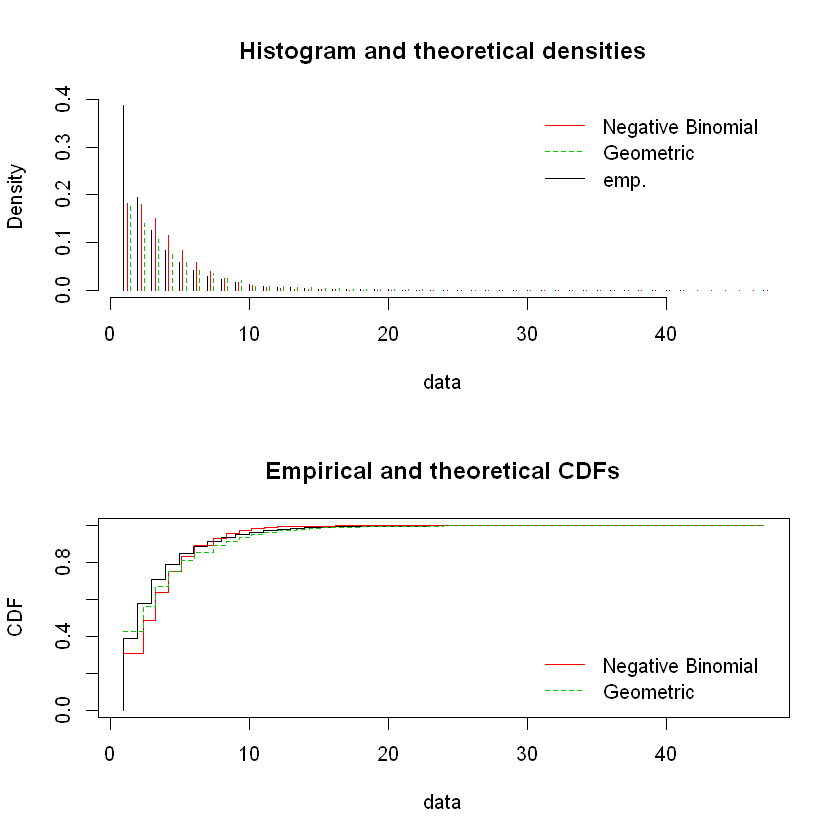

In [307]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dMay, BCfd_GE_dMay), legendtext=plot.legend )

In [308]:
BCstatRes <- gofstat( list(BCfd_NB_dMay, BCfd_GE_dMay), fitnames=c("Negative Binomial", "Geometric") )

In [309]:
print(BCstatRes)

Chi-squared statistic:  120845.8 32960.32 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     337054           269470.03855     370823.527
<= 2     169621           156117.29408     121209.095
<= 3     109121           130927.12701      91883.019
<= 4      72718           100184.61567      69652.275
<= 5      50211            72245.37268      52800.174
<= 6      35678            49975.12643      40025.374
<= 7      25019            33521.07699      30341.389
<= 8      18811            21956.82403      23000.406
<= 9      13277            14113.26338      17435.546
<= 10     10127             8933.41093      13217.082
<= 11      7696             5583.08575      10019.260
<= 12      5840             3451.96267       7595.138
<= 13      4288             2114.80772       5757.524
<= 14      2837             1285.37214       4364.513
<= 15      2160              775.84928    

In [310]:
BCfdNB_dMay_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [311]:
BCfdNB_dMay_p = BCfdNB_dMay_size / (BCfdNB_dMay_size + BCfdNB_dMay_mu)
cat("BCCA prob: ", BCfdNB_dMay_p)

BCCA prob:  0.4551628

In [312]:
# add to our tracking dataframe
BCMonDistDF[5, ] <- list( 5, dBCMayMean, dBCMayBNr, BCfdNB_dMay_p, BCfdNB_dMay_mu, BCfdNB_dMay_size,
                          BCfdNB_dMay_pvalue )

In [313]:
BCgf_dMay <- goodfit( dBCMay$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dMay_size, prob=BCfdNB_dMay_p) )

In [314]:
summary( BCgf_dMay )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          847394.7 47        0
Likelihood Ratio 429399.7 41        0


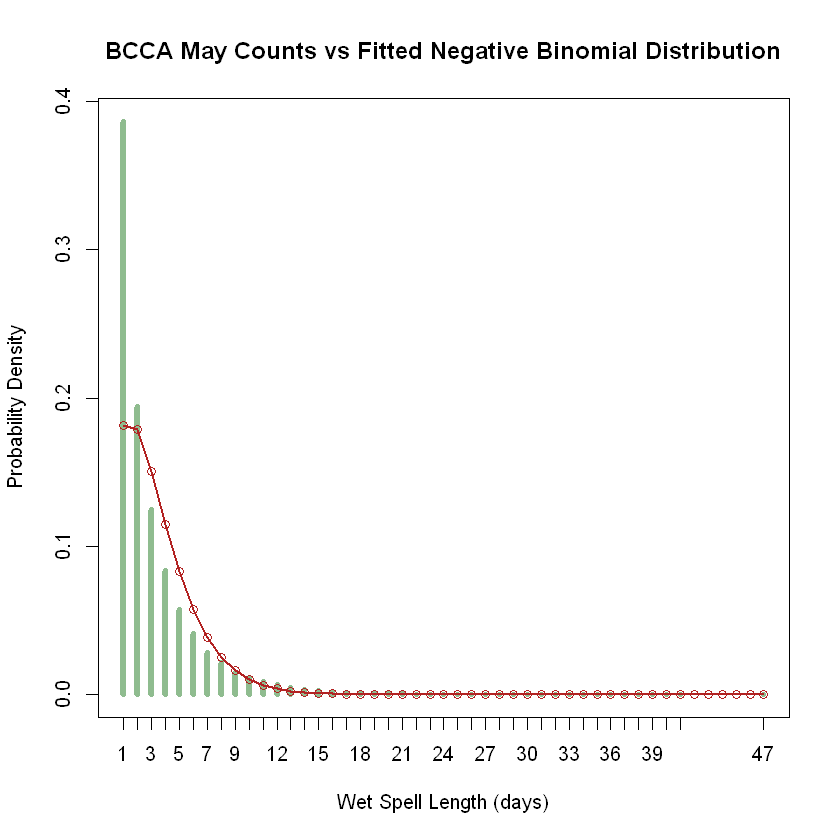

In [315]:
maxP <- max(dBCMay$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dMay_size, mu=BCfdNB_dMay_mu )
ttab <- table( dBCMay$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA May Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

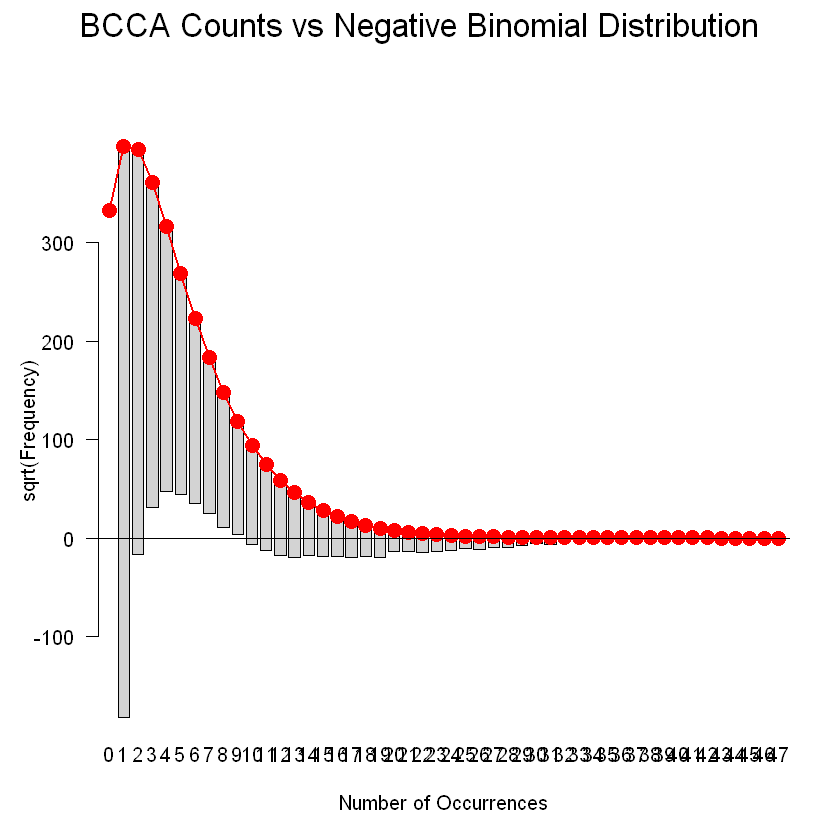

In [316]:
plot( BCgf_dMay, main="BCCA Counts vs Negative Binomial Distribution" )

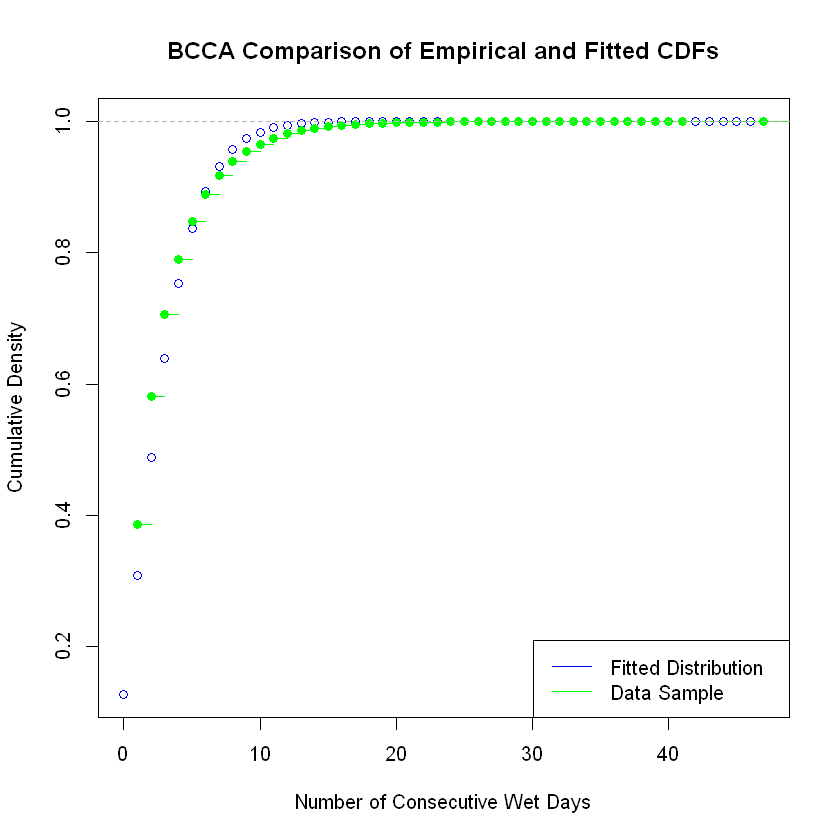

In [317]:
x <- seq(0,dBCMayMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dMay_mu, size=BCfdNB_dMay_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCMay$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

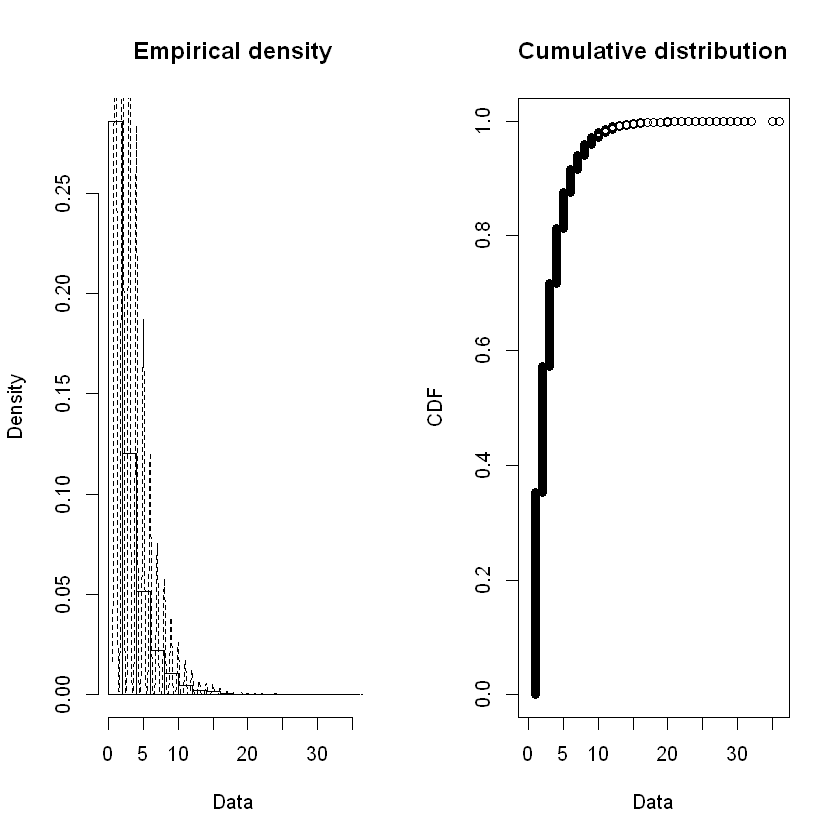

In [318]:
plotdist( dLOJun$Wet_Count, histo=TRUE, demp=TRUE )

In [319]:
LOfd_NB_dJun <- fitdist( dLOJun$Wet_Count, "nbinom" )
LOfd_GE_dJun <- fitdist( dLOJun$Wet_Count, "geom" )

In [320]:
LOfdNB_dJun_size <- LOfd_NB_dJun$estimate[["size"]]
LOfdNB_dJun_mu <- LOfd_NB_dJun$estimate[["mu"]]
cat("LOCA Jun size: ", LOfdNB_dJun_size, "\n", "LOCA Jun mu: ", LOfdNB_dJun_mu, "\n")

LOCA Jun size:  3.904636 
 LOCA Jun mu:  2.95224 


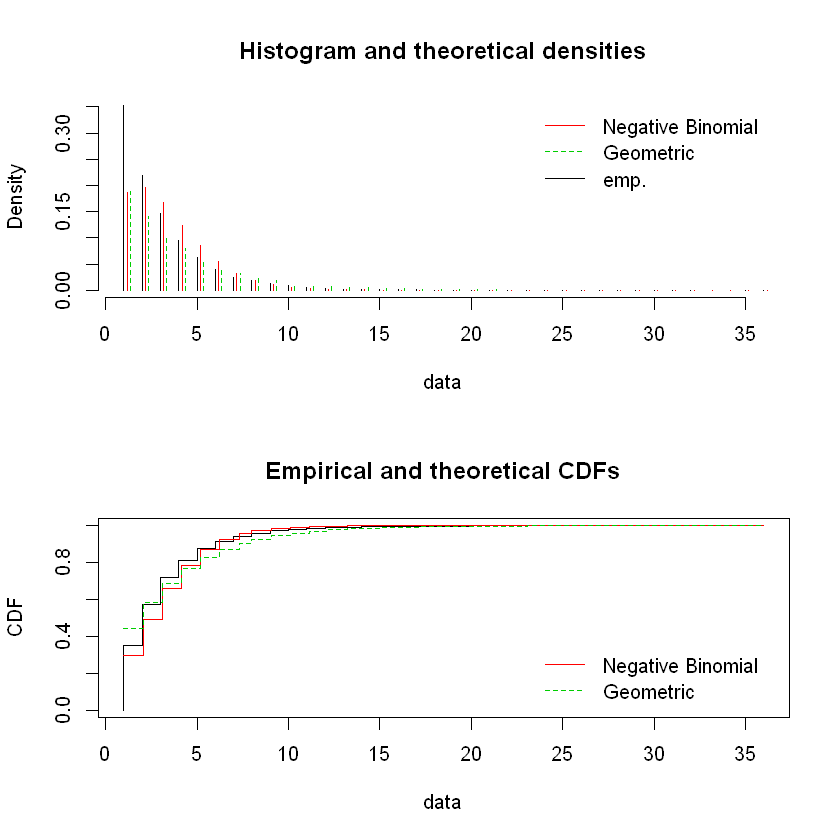

In [321]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJun, LOfd_GE_dJun), legendtext=plot.legend )

In [322]:
LOstatRes <- gofstat( list(LOfd_NB_dJun, LOfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [323]:
print( LOstatRes )

Chi-squared statistic:  217323.2 119680.3 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     422890           357365.58236     530913.623
<= 2     263923           236591.97244     169589.631
<= 3     175544           200492.07982     126688.487
<= 4     113390           149005.86179      94640.059
<= 5      75938           101423.95854      70698.932
<= 6      48195            64808.32640      52814.200
<= 7      30083            39481.76983      39453.775
<= 8      22786            23170.91174      29473.141
<= 9      15497            13195.99241      22017.311
<= 10     10192             7331.84267      16447.584
<= 11      6582             3990.29861      12286.834
<= 12      4895             2133.88418       9178.629
<= 13      2731             1124.02648       6856.708
<= 15      4302              884.67539       8948.574
<= 19      2771              287.41767    

In [324]:
LOfdNB_dJun_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [325]:
LOfdNB_dJun_p = LOfdNB_dJun_size / (LOfdNB_dJun_size + LOfdNB_dJun_mu)
cat("LOCA prob: ", LOfdNB_dJun_p)

LOCA prob:  0.5694483

In [326]:
# add to our tracking dataframe
LOMonDistDF[6, ] <- list( 6, dLOJunMean, dLOJunBNr, LOfdNB_dJun_p, LOfdNB_dJun_mu, LOfdNB_dJun_size,
                          LOfdNB_dJun_pvalue )

In [327]:
LOgf_dJun <- goodfit( dLOJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJun_size, prob=LOfdNB_dJun_p) )

In [328]:
summary( LOgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          5427749.6 36        0
Likelihood Ratio  472002.7 33        0


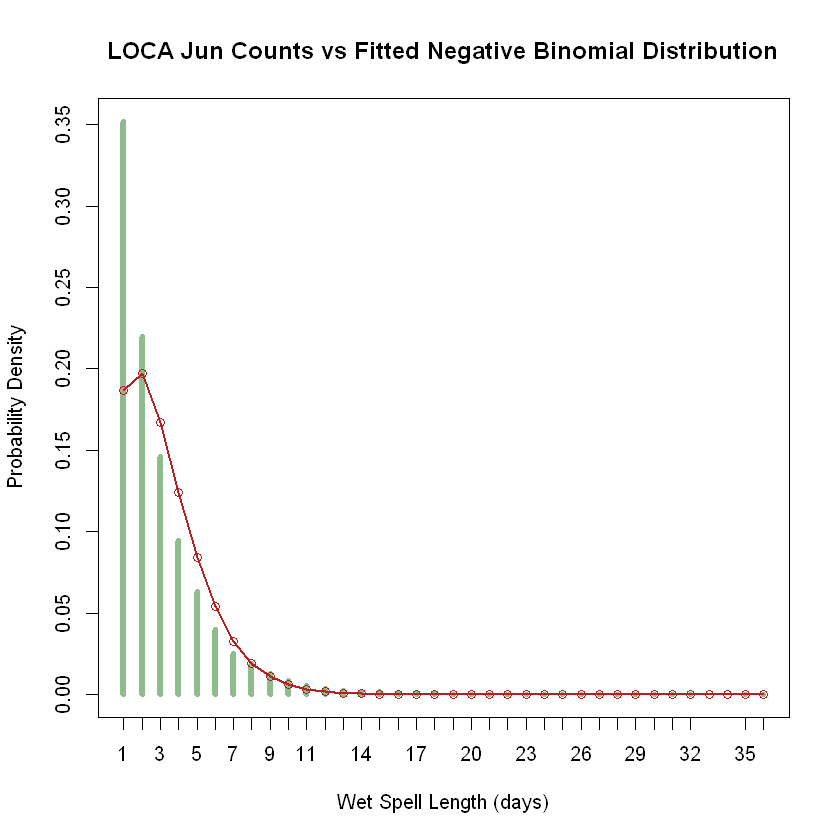

In [329]:
maxP <- max(dLOJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJun_size, mu=LOfdNB_dJun_mu )
ttab <- table( dLOJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

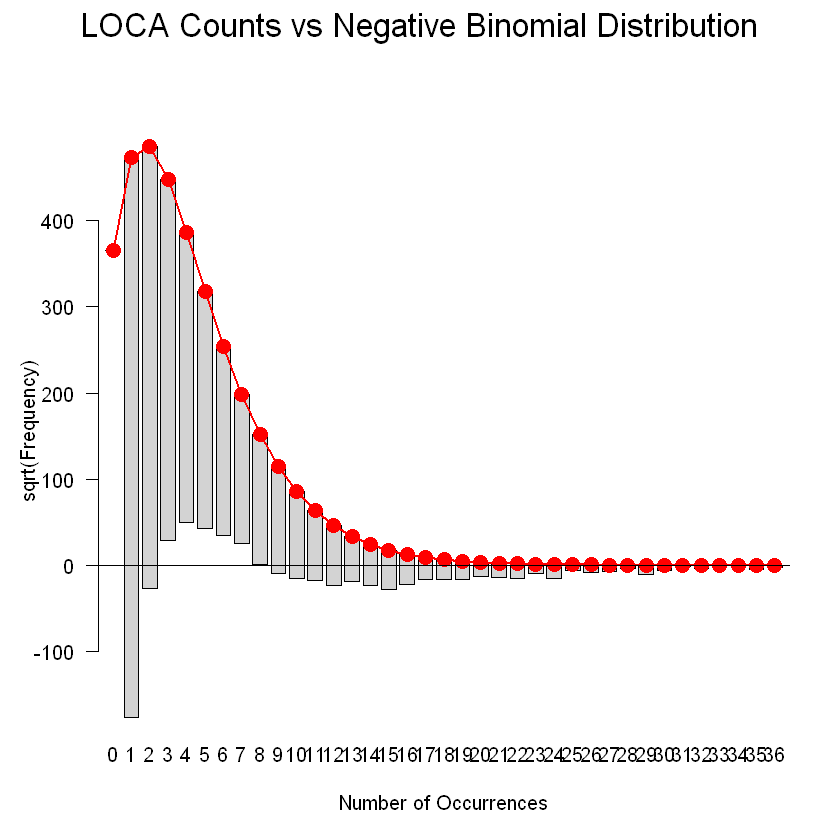

In [330]:
plot( LOgf_dJun, main="LOCA Counts vs Negative Binomial Distribution" )

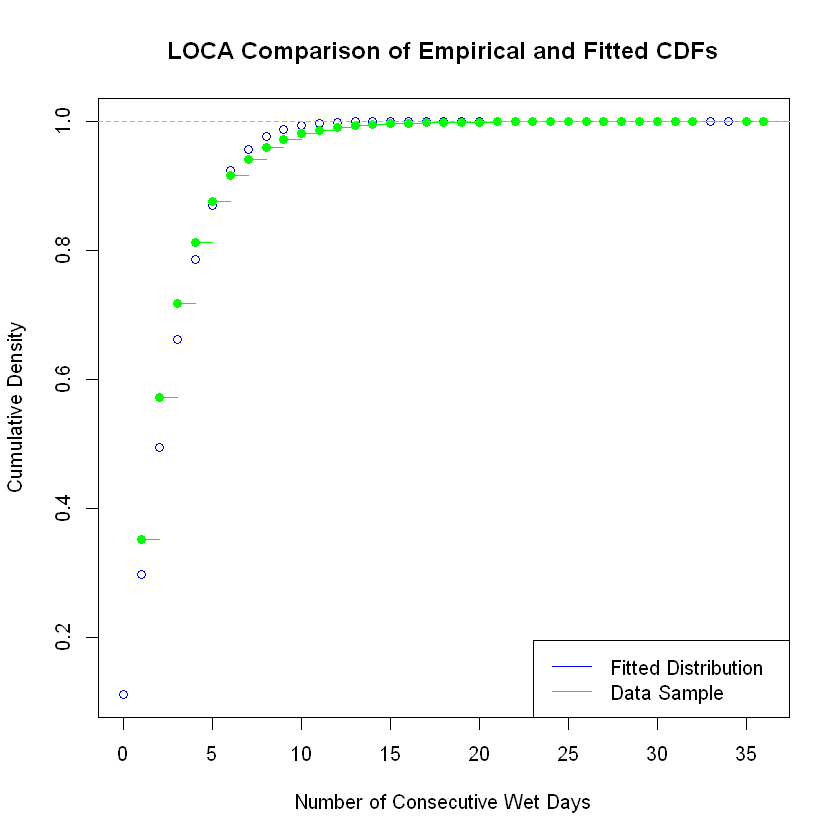

In [331]:
x <- seq(0,dLOJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJun_mu, size=LOfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

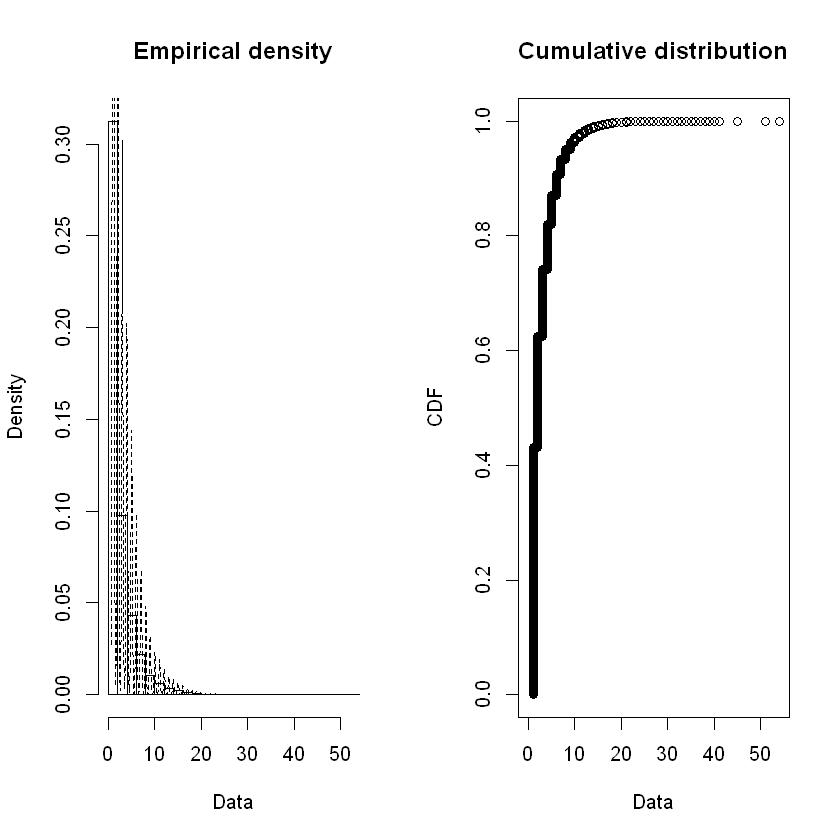

In [332]:
plotdist( dBCJun$Wet_Count, histo=TRUE, demp=TRUE )

In [333]:
BCfd_NB_dJun <- fitdist( dBCJun$Wet_Count, "nbinom" )
BCfd_GE_dJun <- fitdist( dBCJun$Wet_Count, "geom" )

In [334]:
summary( BCfd_NB_dJun )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.761194 0.007805945
mu   2.871017 0.002688831
Loglikelihood:  -1709417   AIC:  3418837   BIC:  3418860 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0001564403
mu   -0.0001564403  1.0000000000


In [335]:
BCfdNB_dJun_size <- BCfd_NB_dJun$estimate[["size"]]
BCfdNB_dJun_mu <- BCfd_NB_dJun$estimate[["mu"]]
cat("BCCA Jun size: ", BCfdNB_dJun_size, "\n", "BCCA Jun mu: ", BCfdNB_dJun_mu, "\n")

BCCA Jun size:  2.761194 
 BCCA Jun mu:  2.871017 


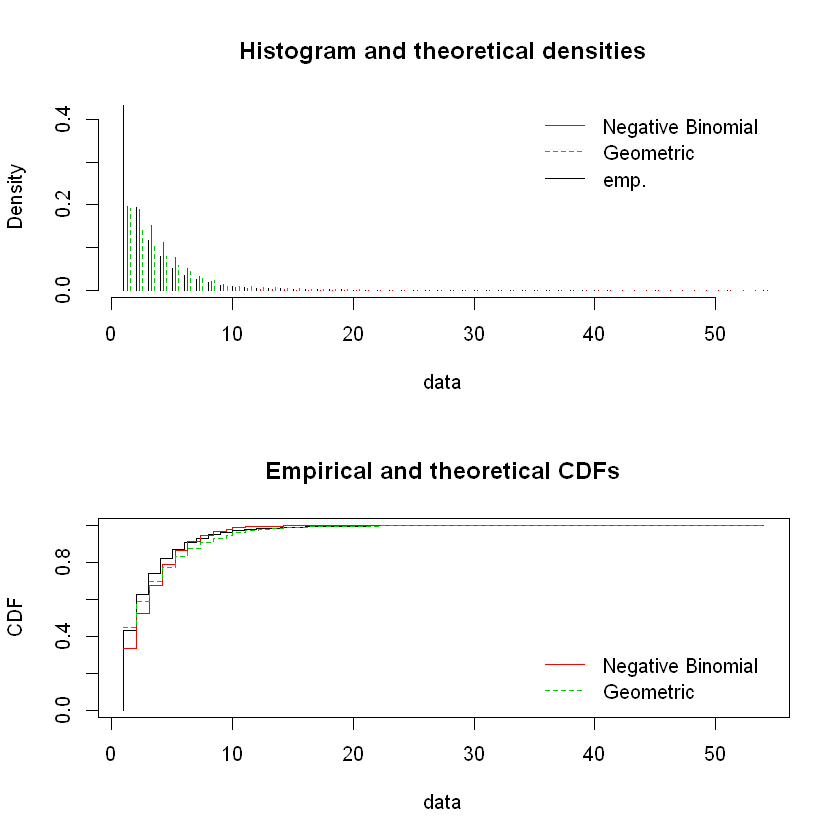

In [336]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJun, BCfd_GE_dJun), legendtext=plot.legend )

In [337]:
BCstatRes <- gofstat( list(BCfd_NB_dJun, BCfd_GE_dJun), fitnames=c("Negative Binomial", "Geometric") )

In [338]:
print(BCstatRes)

Chi-squared statistic:  146023.6 24502.64 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     349679           272465.08344     364523.952
<= 2     156515           152703.08092     115123.404
<= 3      94431           123537.63416      85381.327
<= 4      63906            90700.28335      63323.101
<= 5      41357            62519.98868      46963.608
<= 6      28755            41224.27555      34830.582
<= 7      21168            26301.17441      25832.118
<= 8      14691            16358.55542      19158.402
<= 9       9840             9970.56459      14208.838
<= 10      7194             5977.61603      10537.991
<= 11      5446             3534.95175       7815.506
<= 12      4041             2066.40389       5796.374
<= 13      3071             1196.05237       4298.883
<= 14      2545              686.38554       3188.269
<= 16      3465              612.19758    

In [339]:
BCfdNB_dJun_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [340]:
BCfdNB_dJun_p = BCfdNB_dJun_size / (BCfdNB_dJun_size + BCfdNB_dJun_mu)
cat("BCCA prob: ", BCfdNB_dJun_p)

BCCA prob:  0.4902505

In [341]:
# add to our tracking dataframe
BCMonDistDF[6, ] <- list( 6, dBCJunMean, dBCJunBNr, BCfdNB_dJun_p, BCfdNB_dJun_mu, BCfdNB_dJun_size,
                          BCfdNB_dJun_pvalue )

In [342]:
BCgf_dJun <- goodfit( dBCJun$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJun_size, prob=BCfdNB_dJun_p) )

In [343]:
summary( BCgf_dJun )


	 Goodness-of-fit test for nbinomial distribution

                         X^2 df P(> X^2)
Pearson          142495373.6 54        0
Likelihood Ratio    456720.3 43        0


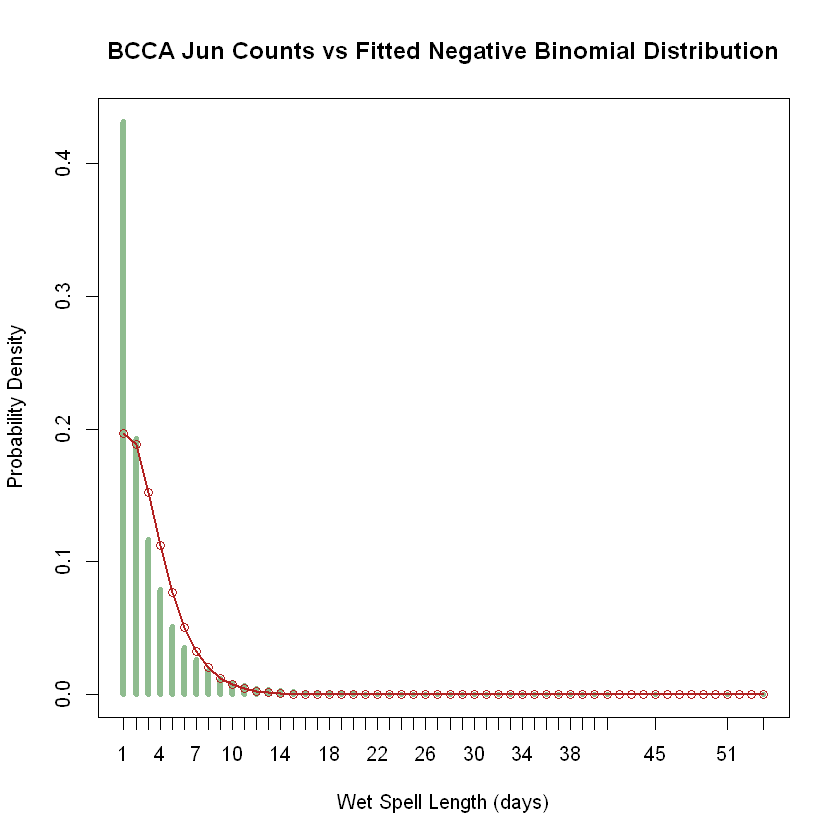

In [344]:
maxP <- max(dBCJun$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJun_size, mu=BCfdNB_dJun_mu )
ttab <- table( dBCJun$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jun Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

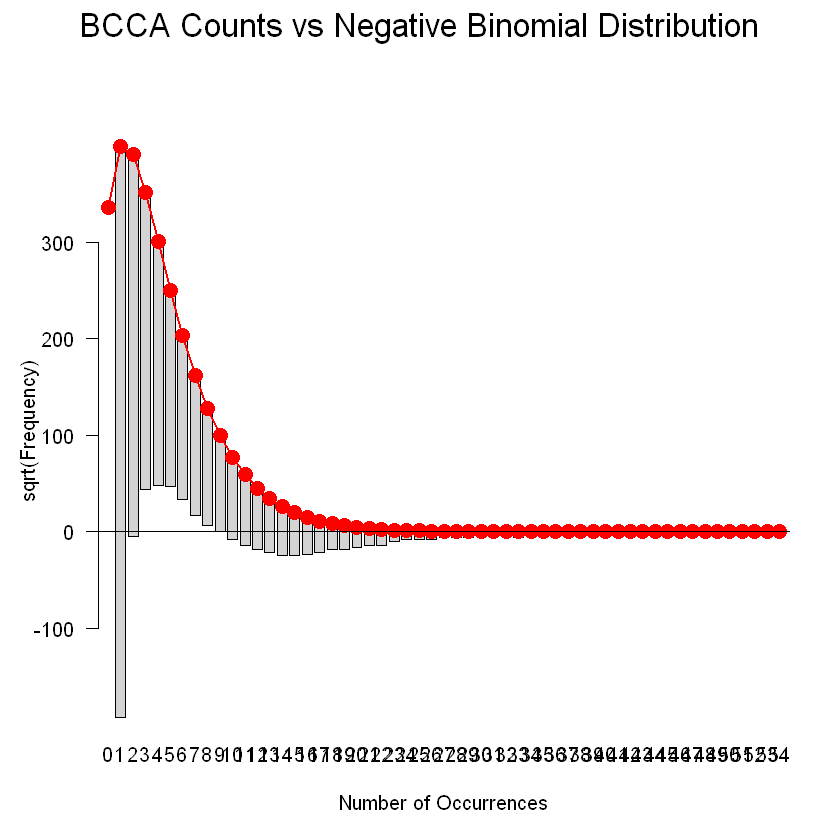

In [345]:
plot( BCgf_dJun, main="BCCA Counts vs Negative Binomial Distribution" )

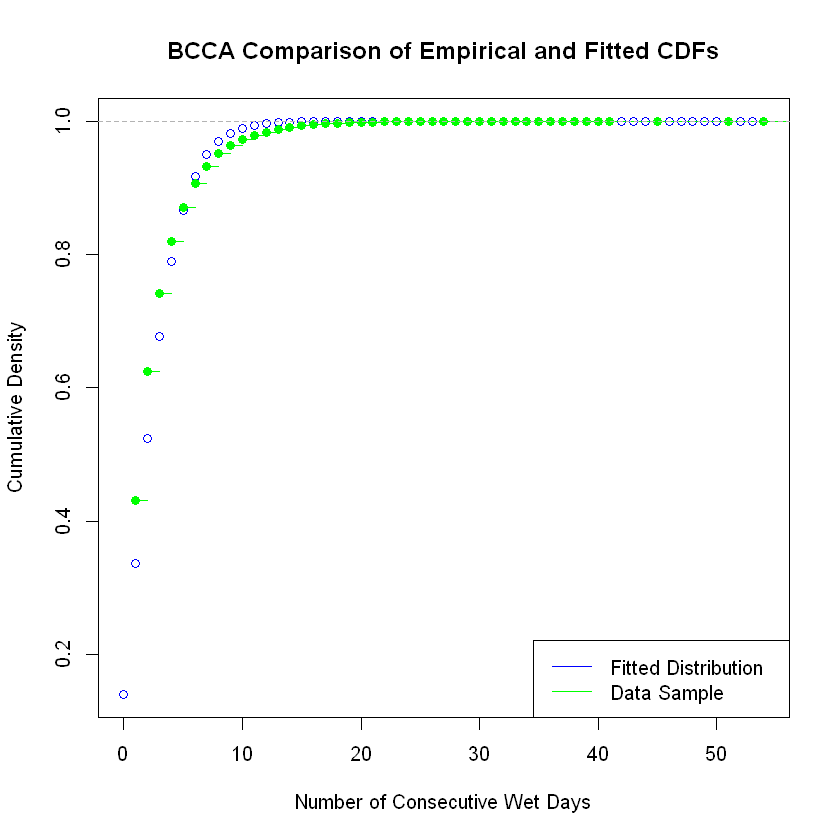

In [346]:
x <- seq(0,dBCJunMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJun_mu, size=BCfdNB_dJun_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJun$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

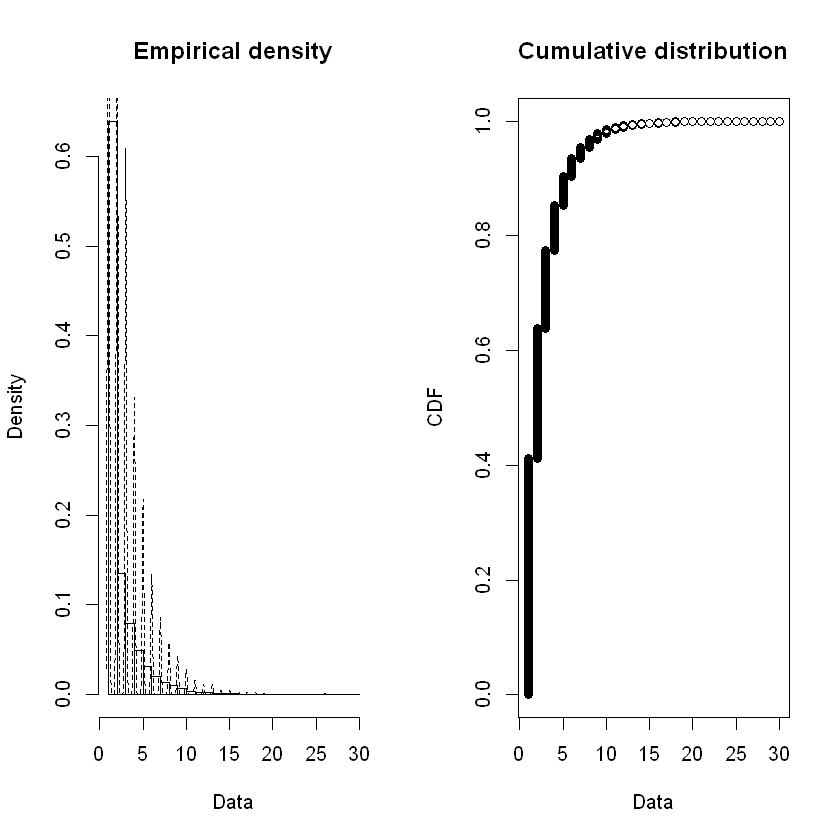

In [347]:
plotdist( dLOJul$Wet_Count, histo=TRUE, demp=TRUE )

In [348]:
LOfd_NB_dJul <- fitdist( dLOJul$Wet_Count, "nbinom" )
LOfd_GE_dJul <- fitdist( dLOJul$Wet_Count, "geom" )

In [349]:
LOfdNB_dJul_size <- LOfd_NB_dJul$estimate[["size"]]
LOfdNB_dJul_mu <- LOfd_NB_dJul$estimate[["mu"]]
cat("LOCA Jul size: ", LOfdNB_dJul_size, "\n", "LOCA Jul mu: ", LOfdNB_dJul_mu, "\n")

LOCA Jul size:  4.264481 
 LOCA Jul mu:  2.631861 


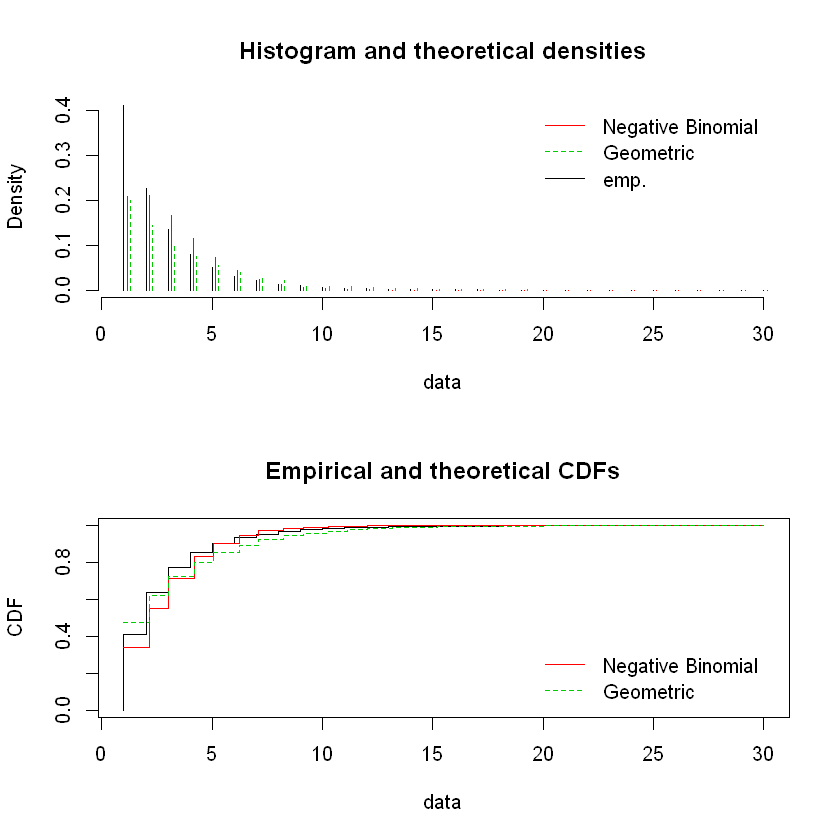

In [350]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dJul, LOfd_GE_dJul), legendtext=plot.legend )

In [351]:
LOstatRes <- gofstat( list(LOfd_NB_dJul, LOfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [352]:
print( LOstatRes )

Chi-squared statistic:  230491.2 83514.89 
Degree of freedom of the Chi-squared distribution:  12 13 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     411524           338433.98179     474995.398
<= 2     227723           210580.37711     144638.872
<= 3     135485           167813.11341     104818.670
<= 4      79145           116309.35581      75961.278
<= 5      49767            73367.61248      55048.550
<= 6      31235            43233.29998      39893.258
<= 7      20679            24193.65576      28910.335
<= 8      13783            13000.70346      20951.096
<= 9      10324             6761.10489      15183.097
<= 10      6549             3422.56805      11003.073
<= 11      3807             1693.78989       7973.841
<= 12      2727              822.25115       5778.581
<= 13      2544              392.59567       4187.693
<= 16      2923              310.07089       6827.883
> 16       2152               32.51966    

In [353]:
LOfdNB_dJul_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [354]:
LOfdNB_dJul_p = LOfdNB_dJul_size / (LOfdNB_dJul_size + LOfdNB_dJul_mu)
cat("LOCA prob: ", LOfdNB_dJul_p)

LOCA prob:  0.6183685

In [355]:
# add to our tracking dataframe
LOMonDistDF[7, ] <- list( 7, dLOJulMean, dLOJulBNr, LOfdNB_dJul_p, LOfdNB_dJul_mu, LOfdNB_dJul_size,
                          LOfdNB_dJul_pvalue )

In [356]:
LOgf_dJul <- goodfit( dLOJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dJul_size, prob=LOfdNB_dJul_p) )

In [357]:
summary( LOgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          4290240.5 30        0
Likelihood Ratio  482758.8 29        0


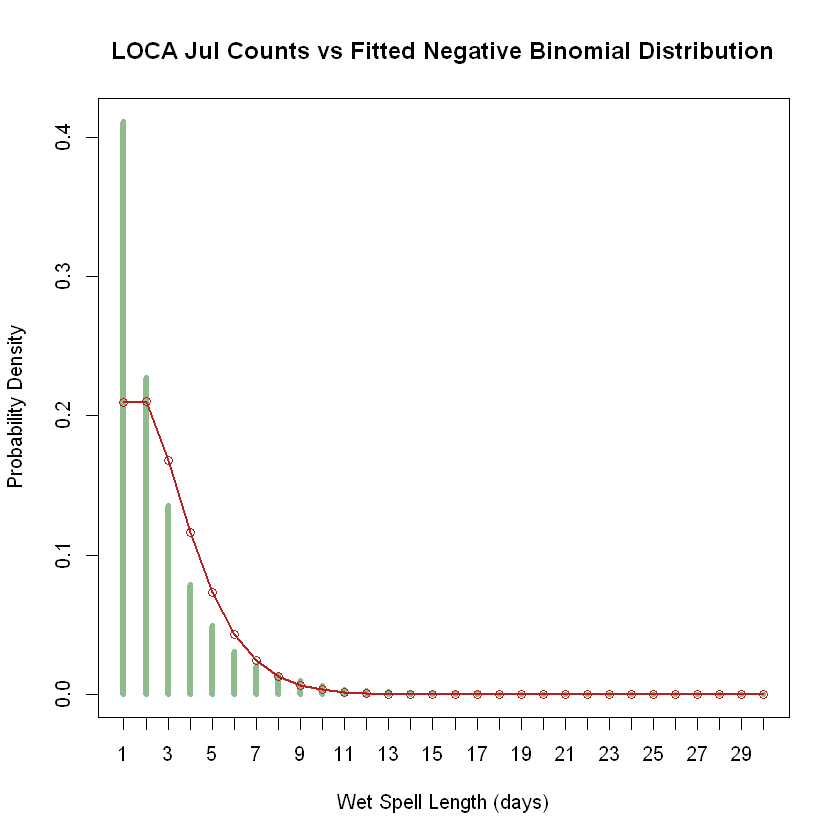

In [358]:
maxP <- max(dLOJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dJul_size, mu=LOfdNB_dJul_mu )
ttab <- table( dLOJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

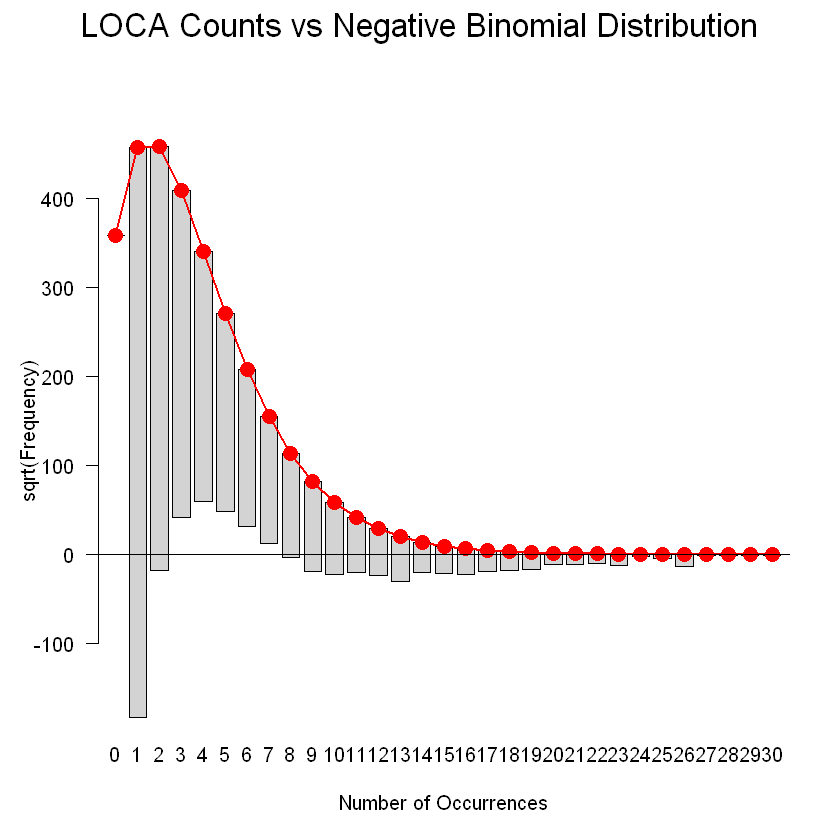

In [359]:
plot( LOgf_dJul, main="LOCA Counts vs Negative Binomial Distribution" )

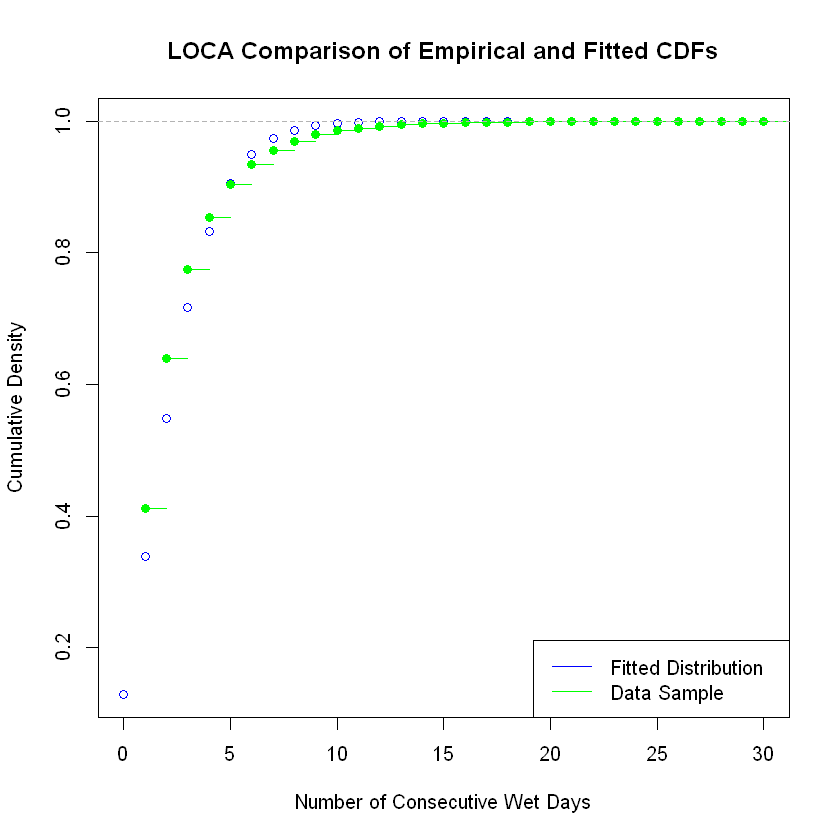

In [360]:
x <- seq(0,dLOJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dJul_mu, size=LOfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

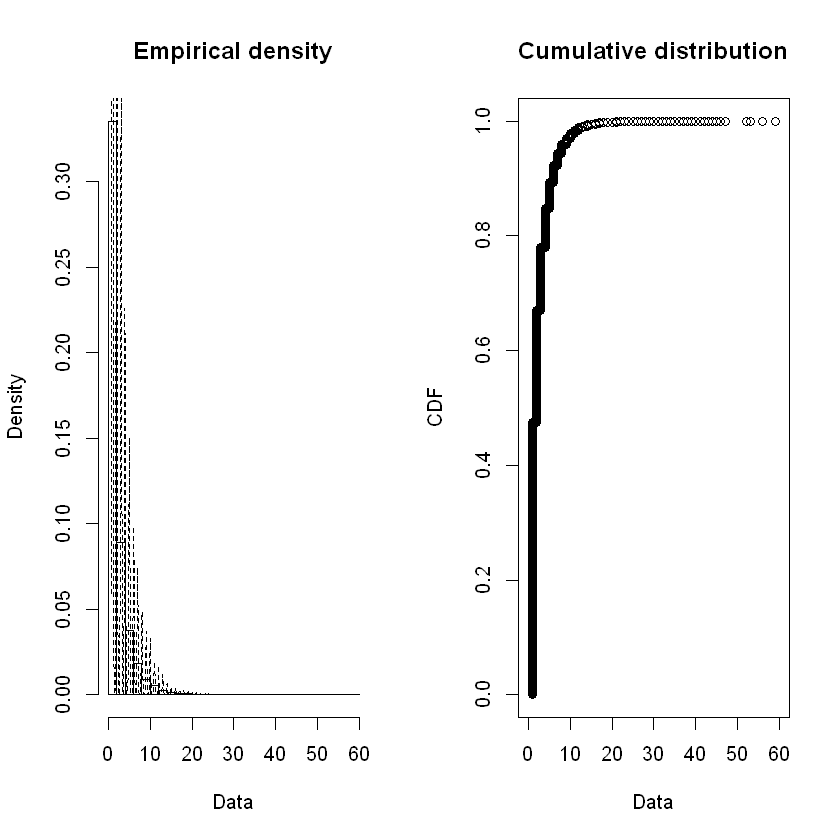

In [361]:
plotdist( dBCJul$Wet_Count, histo=TRUE, demp=TRUE )

In [362]:
BCfd_NB_dJul <- fitdist( dBCJul$Wet_Count, "nbinom" )
BCfd_GE_dJul <- fitdist( dBCJul$Wet_Count, "geom" )

In [363]:
summary( BCfd_NB_dJul )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.992100 0.008816391
mu   2.622343 0.002401665
Loglikelihood:  -1727545   AIC:  3455094   BIC:  3455117 
Correlation matrix:
             size           mu
size 1.0000000000 0.0002366369
mu   0.0002366369 1.0000000000


In [364]:
BCfdNB_dJul_size <- BCfd_NB_dJul$estimate[["size"]]
BCfdNB_dJul_mu <- BCfd_NB_dJul$estimate[["mu"]]
cat("BCCA Jul size: ", BCfdNB_dJul_size, "\n", "BCCA Jul mu: ", BCfdNB_dJul_mu, "\n")

BCCA Jul size:  2.9921 
 BCCA Jul mu:  2.622343 


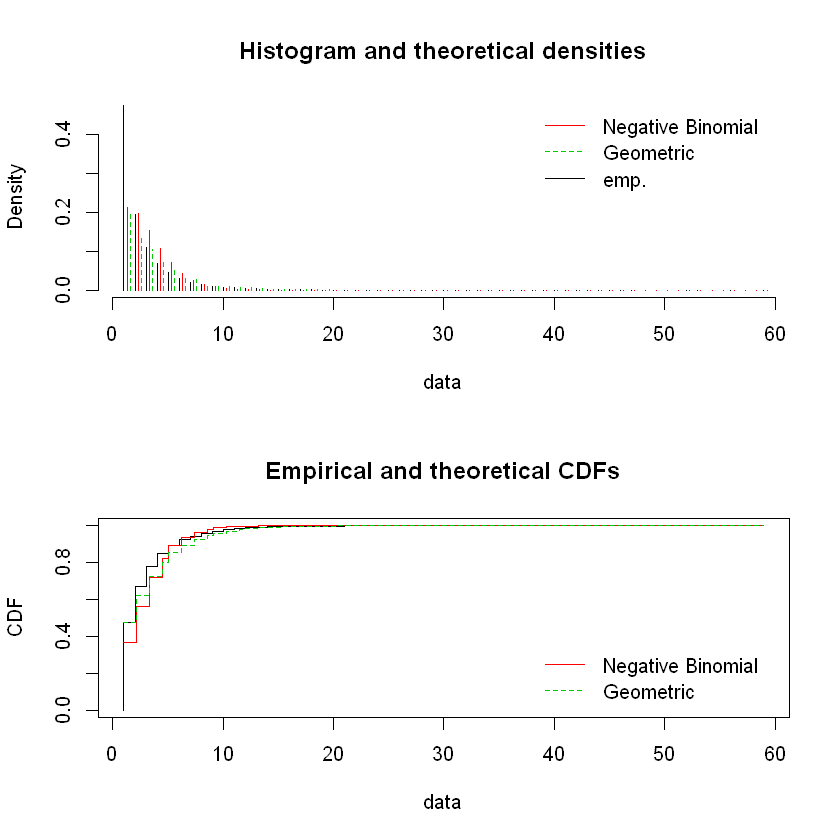

In [365]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dJul, BCfd_GE_dJul), legendtext=plot.legend )

In [366]:
BCstatRes <- gofstat( list(BCfd_NB_dJul, BCfd_GE_dJul), fitnames=c("Negative Binomial", "Geometric") )

In [367]:
print(BCstatRes)

Chi-squared statistic:  231917.7 26101.99 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     405011           311046.22525     405867.679
<= 2     166948           169034.48471     123393.728
<= 3      93389           131377.24125      89332.991
<= 4      57918            91922.53671      64674.140
<= 5      38129            60040.24118      46821.945
<= 6      25962            37353.80846      33897.544
<= 7      17980            22412.00835      24540.704
<= 8      13271            13074.65868      17766.661
<= 9       8777             7458.49703      12862.476
<= 10      6668             4177.62412       9312.009
<= 11      4953             2304.61737       6741.587
<= 12      3988             1255.11432       4880.687
<= 13      2730              676.05994       3533.456
<= 15      3000              551.54587       4410.090
<= 18      2333              179.67464    

In [368]:
BCfdNB_dJul_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [369]:
BCfdNB_dJul_p = BCfdNB_dJul_size / (BCfdNB_dJul_size + BCfdNB_dJul_mu)
cat("BCCA prob: ", BCfdNB_dJul_p)

BCCA prob:  0.5329291

In [370]:
# add to our tracking dataframe
BCMonDistDF[7, ] <- list( 7, dBCJulMean, dBCJulBNr, BCfdNB_dJul_p, BCfdNB_dJul_mu, BCfdNB_dJul_size,
                          BCfdNB_dJul_pvalue )

In [371]:
BCgf_dJul <- goodfit( dBCJul$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dJul_size, prob=BCfdNB_dJul_p) )

In [372]:
summary( BCgf_dJul )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson               NaN 59      NaN
Likelihood Ratio 543151.1 50        0


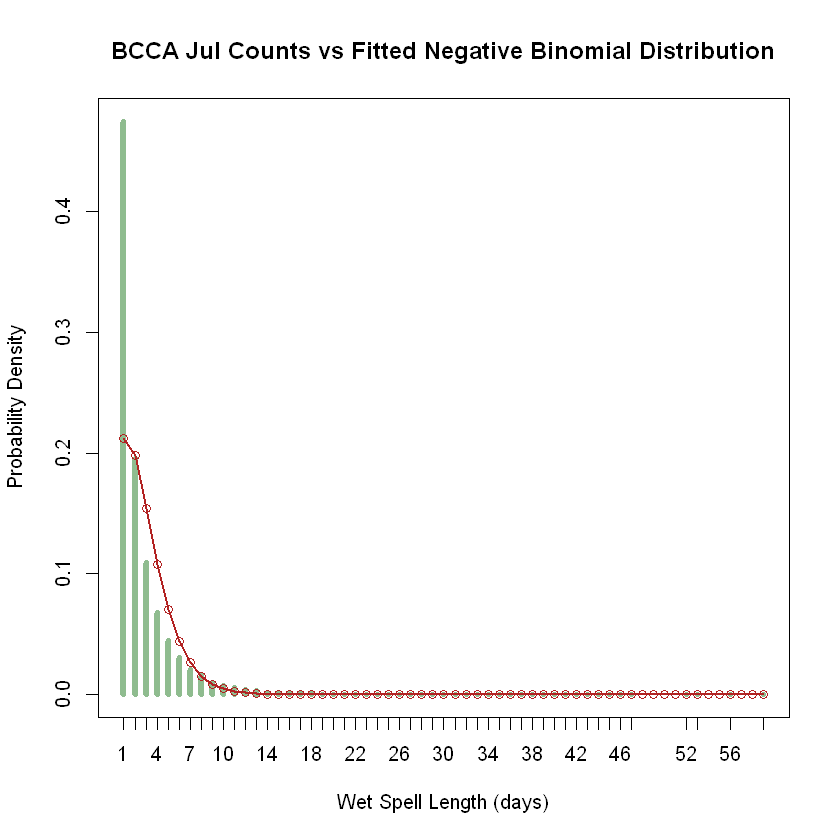

In [373]:
maxP <- max(dBCJul$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dJul_size, mu=BCfdNB_dJul_mu )
ttab <- table( dBCJul$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Jul Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

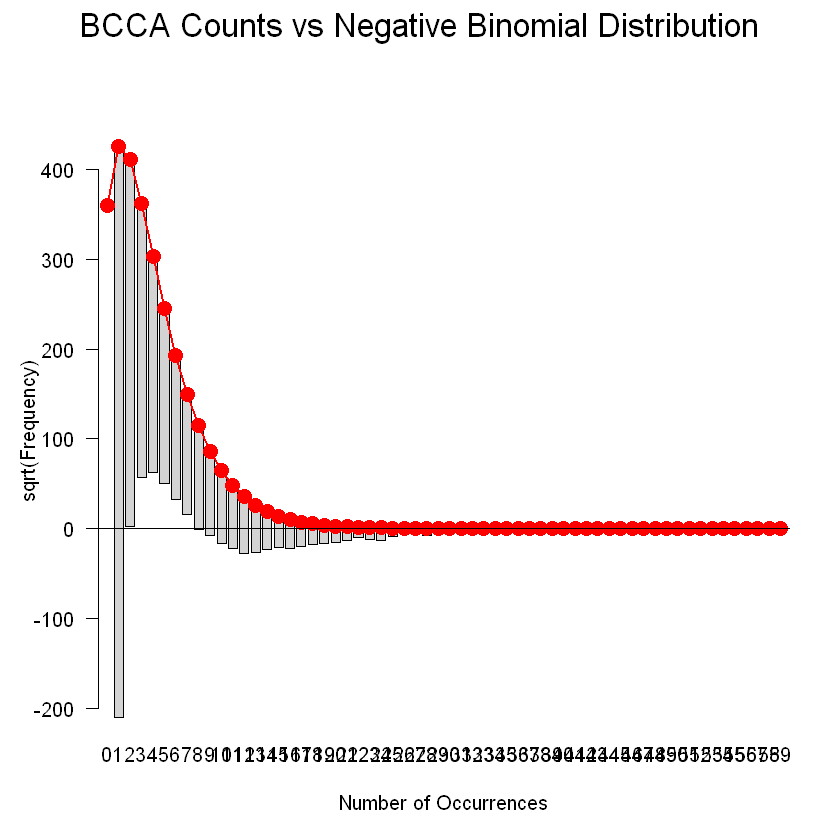

In [374]:
plot( BCgf_dJul, main="BCCA Counts vs Negative Binomial Distribution" )

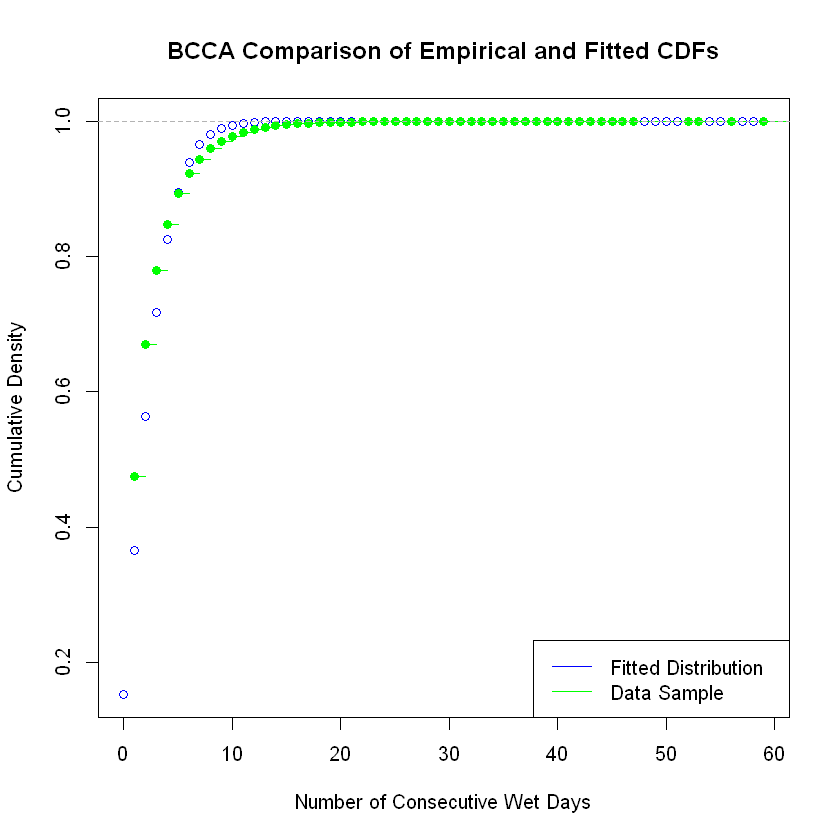

In [375]:
x <- seq(0,dBCJulMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dJul_mu, size=BCfdNB_dJul_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCJul$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

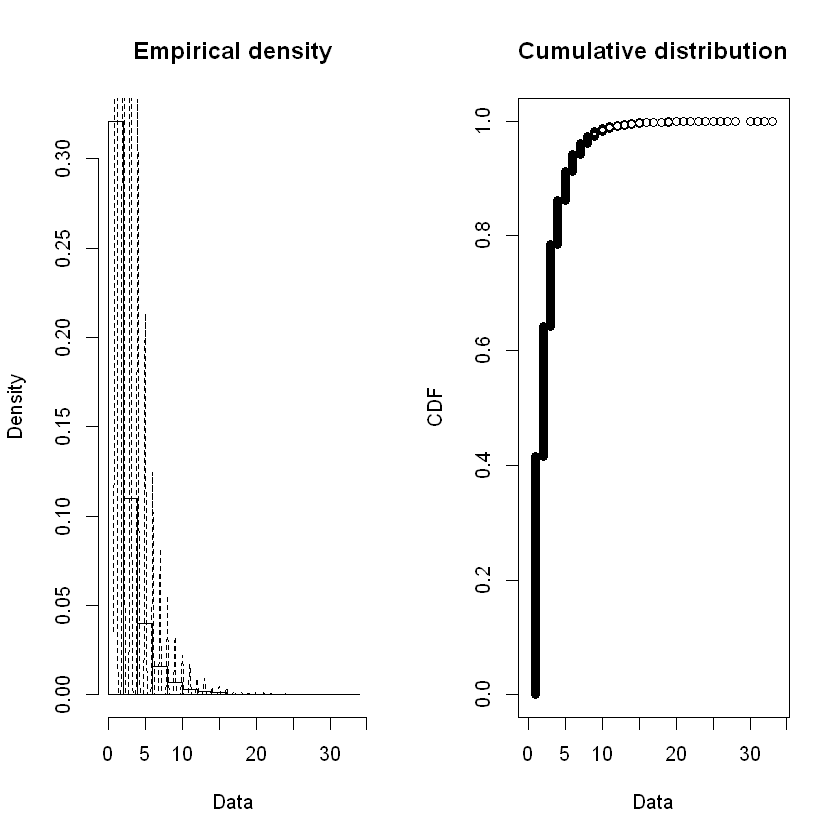

In [376]:
plotdist( dLOAug$Wet_Count, histo=TRUE, demp=TRUE )

In [377]:
LOfd_NB_dAug <- fitdist( dLOAug$Wet_Count, "nbinom" )
LOfd_GE_dAug <- fitdist( dLOAug$Wet_Count, "geom" )

In [378]:
LOfdNB_dAug_size <- LOfd_NB_dAug$estimate[["size"]]
LOfdNB_dAug_mu <- LOfd_NB_dAug$estimate[["mu"]]
cat("LOCA Aug size: ", LOfdNB_dAug_size, "\n", "LOCA Aug mu: ", LOfdNB_dAug_mu, "\n")

LOCA Aug size:  4.654024 
 LOCA Aug mu:  2.576441 


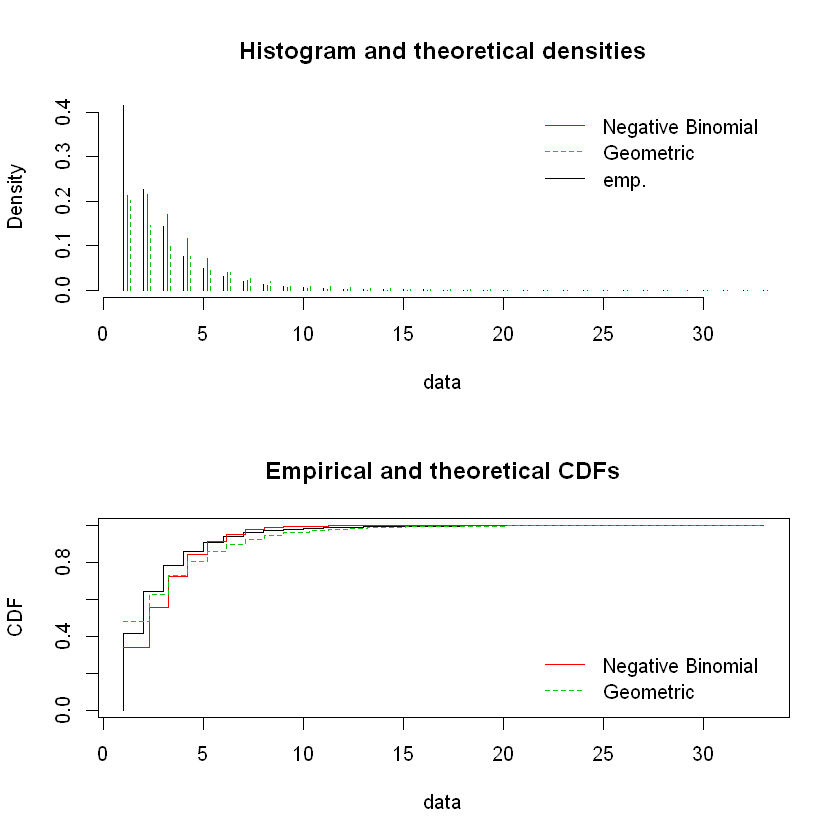

In [379]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dAug, LOfd_GE_dAug), legendtext=plot.legend )

In [380]:
LOstatRes <- gofstat( list(LOfd_NB_dAug, LOfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [381]:
print( LOstatRes )

Chi-squared statistic:  310744.2 94440.27 
Degree of freedom of the Chi-squared distribution:  11 12 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     434907           358335.22999     503989.312
<= 2     237432           225184.01113     152010.008
<= 3     150016           177973.20281     109497.307
<= 4      80224           121349.61482      78874.151
<= 5      52386            74841.14986      56815.385
<= 6      31428            42909.31029      40925.803
<= 7      20548            23271.32566      29480.067
<= 8      13033            12079.83506      21235.365
<= 9       8228             6052.03050      15296.462
<= 10      5760             2944.52828      11018.494
<= 11      3935             1397.76417       7936.947
<= 13      4447              946.32357       9835.499
<= 16      3162              218.17587       6642.644
> 16       2016               19.49799       3964.556

Goodness-of-fit criteria
                

In [382]:
LOfdNB_dAug_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [383]:
LOfdNB_dAug_p = LOfdNB_dAug_size / (LOfdNB_dAug_size + LOfdNB_dAug_mu)
cat("LOCA prob: ", LOfdNB_dAug_p)

LOCA prob:  0.6436687

In [384]:
# add to our tracking dataframe
LOMonDistDF[8, ] <- list( 8, dLOAugMean, dLOAugBNr, LOfdNB_dAug_p, LOfdNB_dAug_mu, LOfdNB_dAug_size,
                          LOfdNB_dAug_pvalue )

In [385]:
LOgf_dAug <- goodfit( dLOAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dAug_size, prob=LOfdNB_dAug_p) )

In [386]:
summary( LOgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                         X^2 df P(> X^2)
Pearson          363592327.3 33        0
Likelihood Ratio    503330.1 31        0


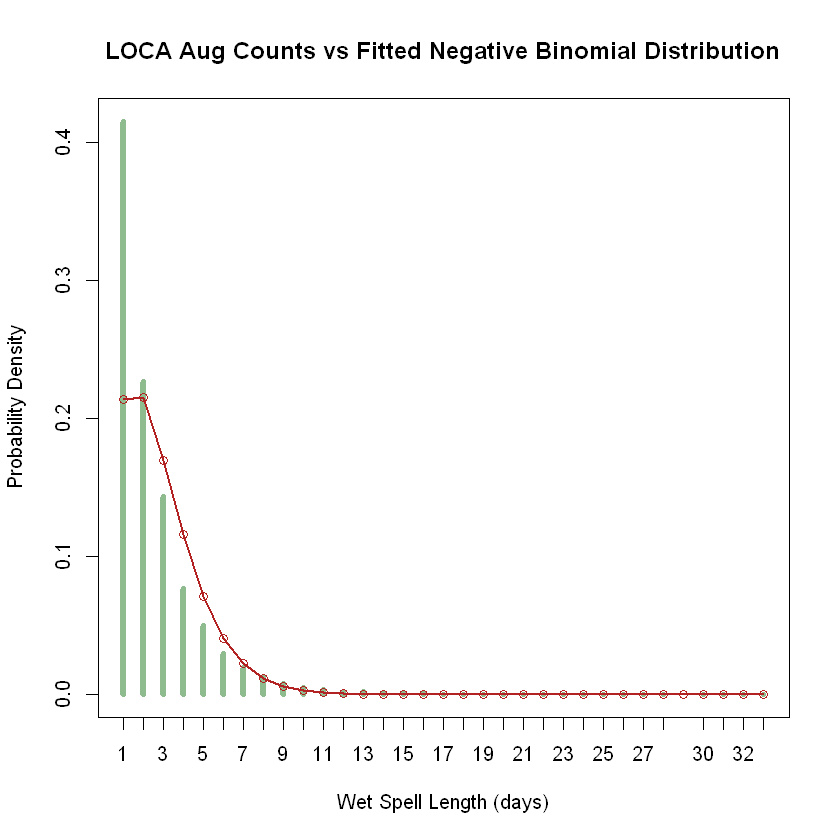

In [387]:
maxP <- max(dLOAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dAug_size, mu=LOfdNB_dAug_mu )
ttab <- table( dLOAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

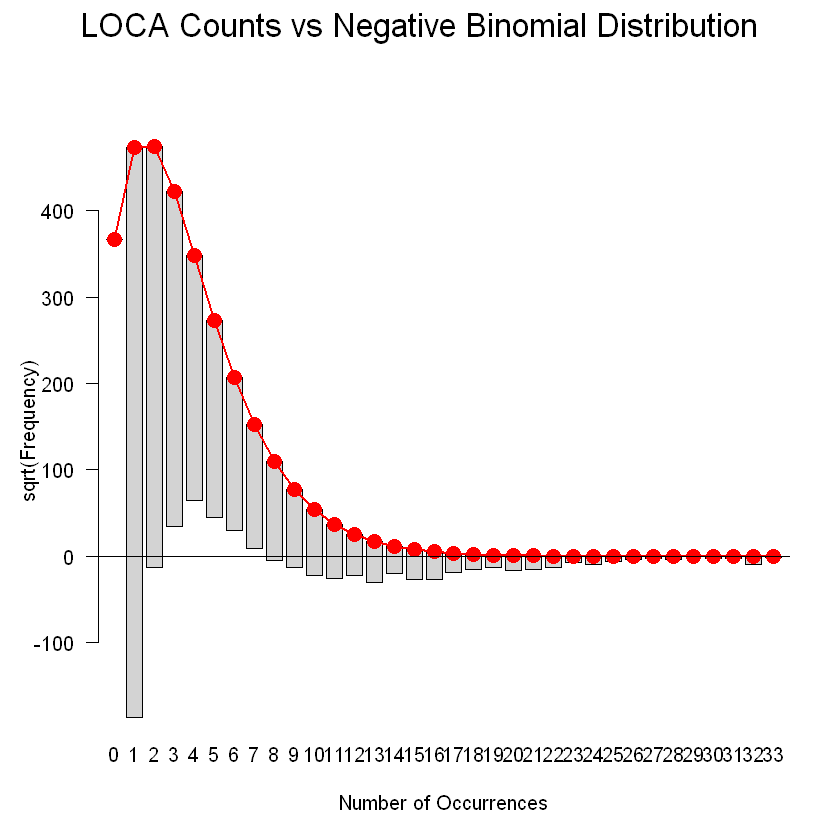

In [388]:
plot( LOgf_dAug, main="LOCA Counts vs Negative Binomial Distribution" )

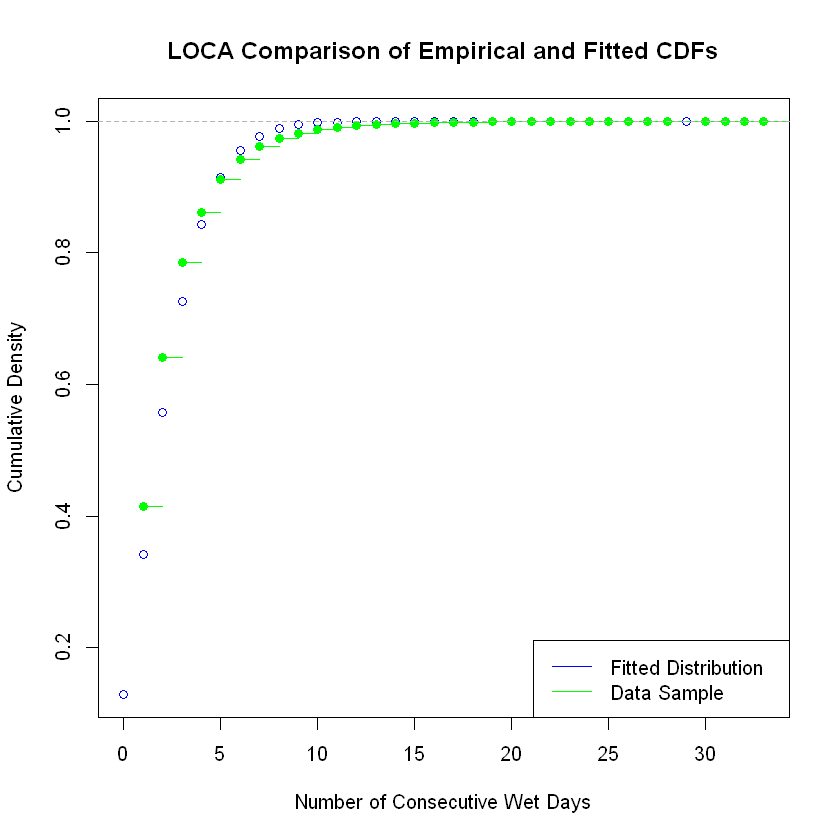

In [389]:
x <- seq(0,dLOAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dAug_mu, size=LOfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

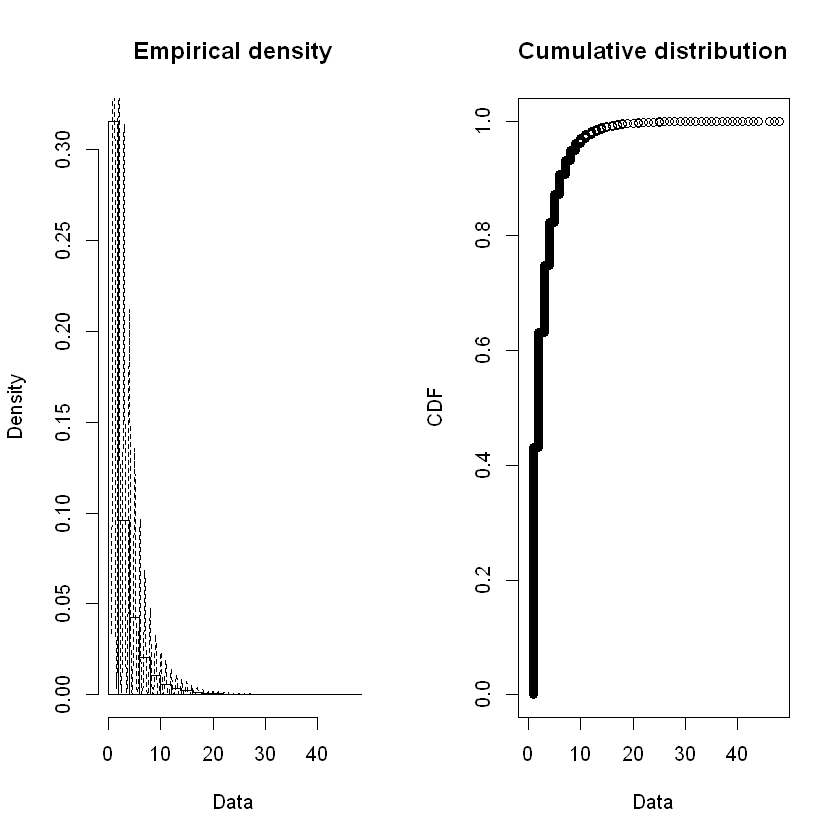

In [390]:
plotdist( dBCAug$Wet_Count, histo=TRUE, demp=TRUE )

In [391]:
BCfd_NB_dAug <- fitdist( dBCAug$Wet_Count, "nbinom" )
BCfd_GE_dAug <- fitdist( dBCAug$Wet_Count, "geom" )

In [392]:
summary( BCfd_NB_dAug )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.587495 0.006734714
mu   2.887485 0.002632561
Loglikelihood:  -1871939   AIC:  3743881   BIC:  3743905 
Correlation matrix:
              size            mu
size  1.000000e+00 -5.623343e-05
mu   -5.623343e-05  1.000000e+00


In [393]:
BCfdNB_dAug_size <- BCfd_NB_dAug$estimate[["size"]]
BCfdNB_dAug_mu <- BCfd_NB_dAug$estimate[["mu"]]
cat("BCCA Aug size: ", BCfdNB_dAug_size, "\n", "BCCA Aug mu: ", BCfdNB_dAug_mu, "\n")

BCCA Aug size:  2.587495 
 BCCA Aug mu:  2.887485 


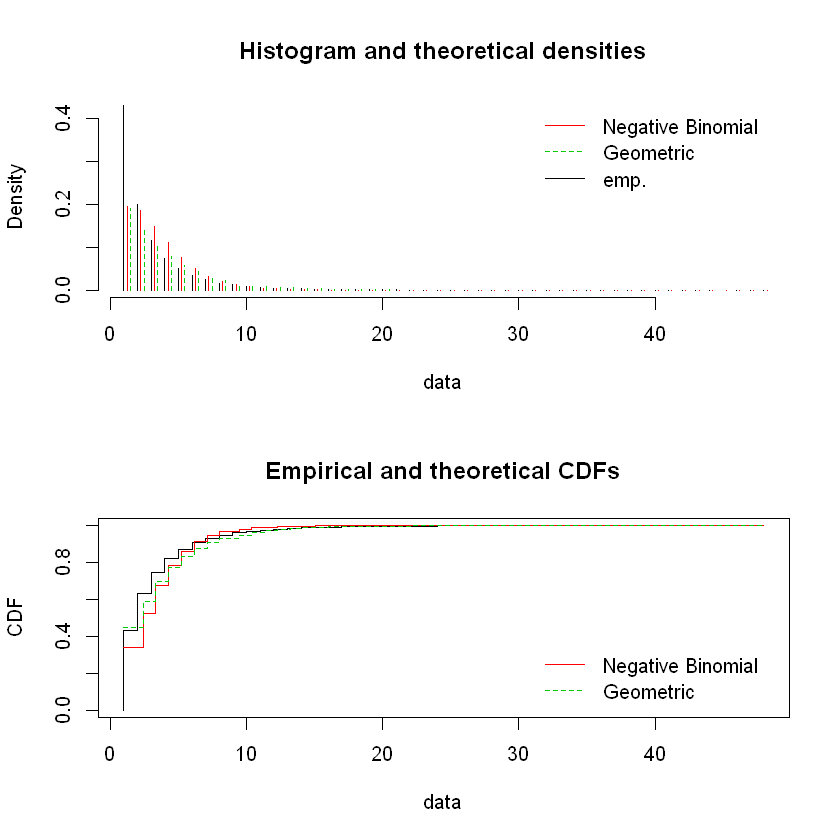

In [394]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dAug, BCfd_GE_dAug), legendtext=plot.legend )

In [395]:
BCstatRes <- gofstat( list(BCfd_NB_dAug, BCfd_GE_dAug), fitnames=c("Negative Binomial", "Geometric") )

In [396]:
print(BCstatRes)

Chi-squared statistic:  270085.2 34549.76 
Degree of freedom of the Chi-squared distribution:  15 16 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     379681           299790.03573     395248.782
<= 2     176830           163669.63411     125120.167
<= 3     102886           131995.65157      92933.894
<= 4      66253            97242.01516      69027.311
<= 5      44231            67568.05518      51270.526
<= 6      30289            45063.58761      38081.548
<= 7      21415            29156.23226      28285.340
<= 8      14778            18428.23521      21009.138
<= 9      10845            11433.30106      15604.687
<= 10      7797             6987.12293      11590.492
<= 11      5828             4216.79217       8608.920
<= 12      4456             2518.12645       6394.337
<= 13      3725             1490.22584       4749.439
<= 14      2724              875.05947       3527.680
<= 15      2193              510.34552    

In [397]:
BCfdNB_dAug_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [398]:
BCfdNB_dAug_p = BCfdNB_dAug_size / (BCfdNB_dAug_size + BCfdNB_dAug_mu)
cat("BCCA prob: ", BCfdNB_dAug_p)

BCCA prob:  0.4726036

In [399]:
# add to our tracking dataframe
BCMonDistDF[8, ] <- list( 8, dBCAugMean, dBCAugBNr, BCfdNB_dAug_p, BCfdNB_dAug_mu, BCfdNB_dAug_size,
                          BCfdNB_dAug_pvalue )

In [400]:
BCgf_dAug <- goodfit( dBCAug$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dAug_size, prob=BCfdNB_dAug_p) )

In [401]:
summary( BCgf_dAug )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          16812629.0 48        0
Likelihood Ratio   516897.7 46        0


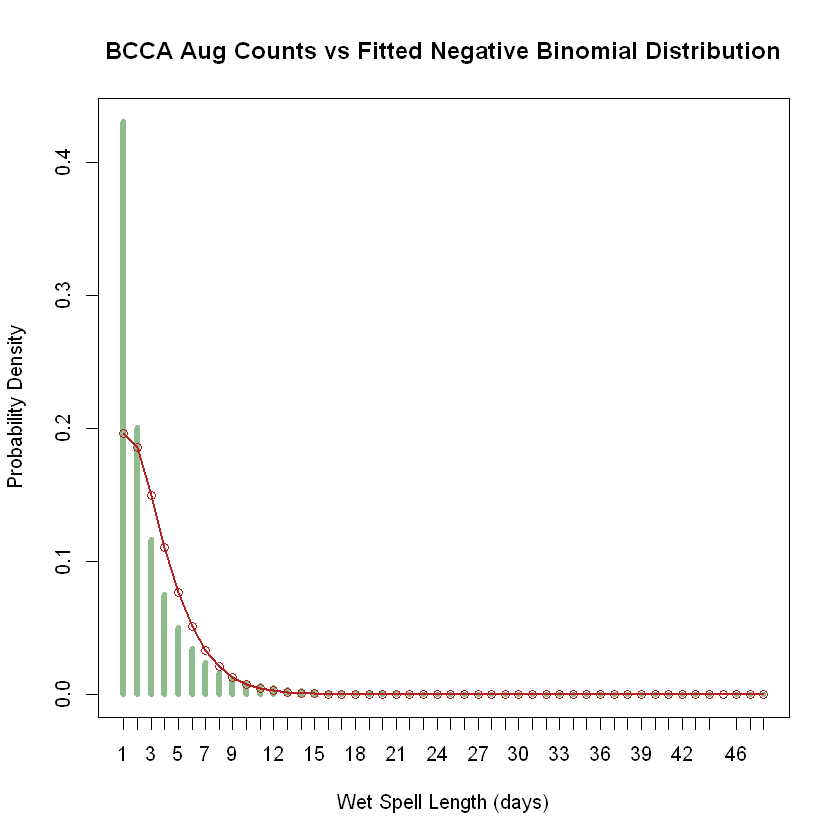

In [402]:
maxP <- max(dBCAug$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dAug_size, mu=BCfdNB_dAug_mu )
ttab <- table( dBCAug$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Aug Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

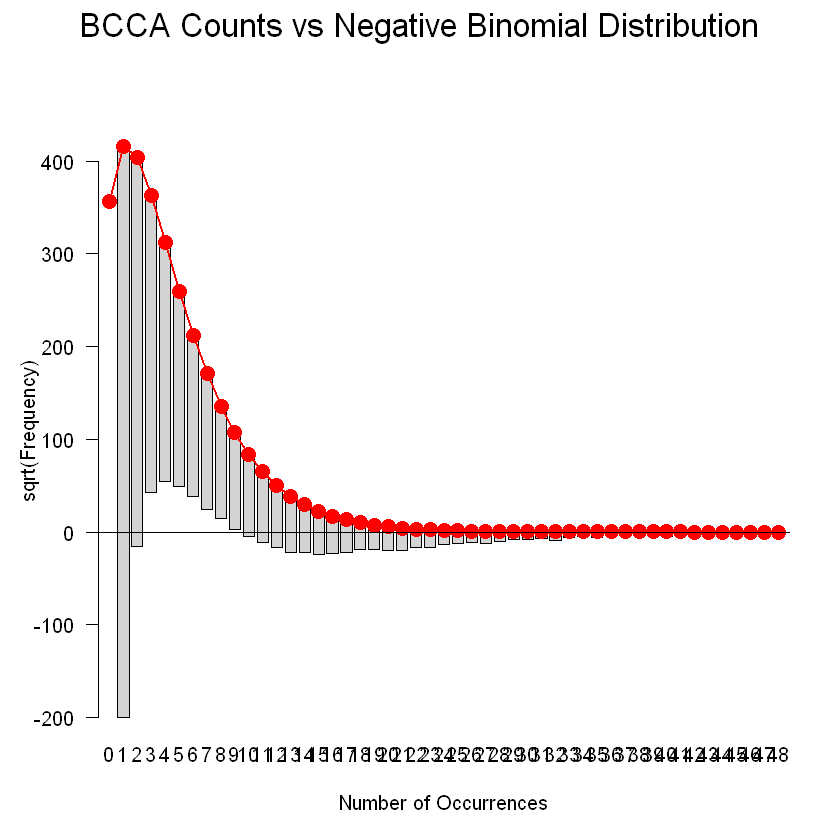

In [403]:
plot( BCgf_dAug, main="BCCA Counts vs Negative Binomial Distribution" )

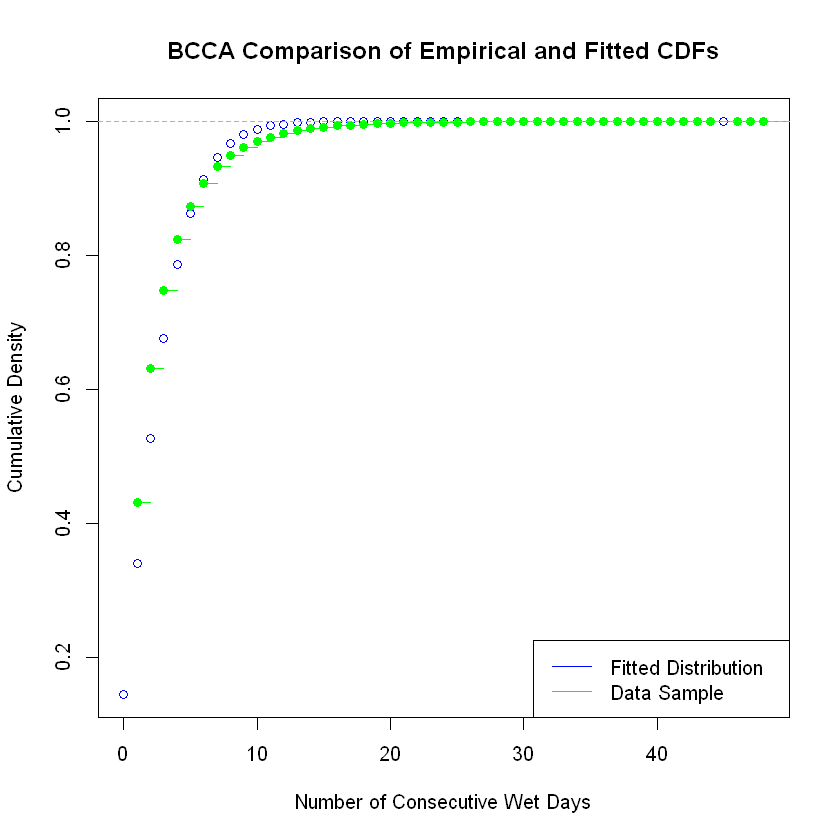

In [404]:
x <- seq(0,dBCAugMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dAug_mu, size=BCfdNB_dAug_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCAug$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

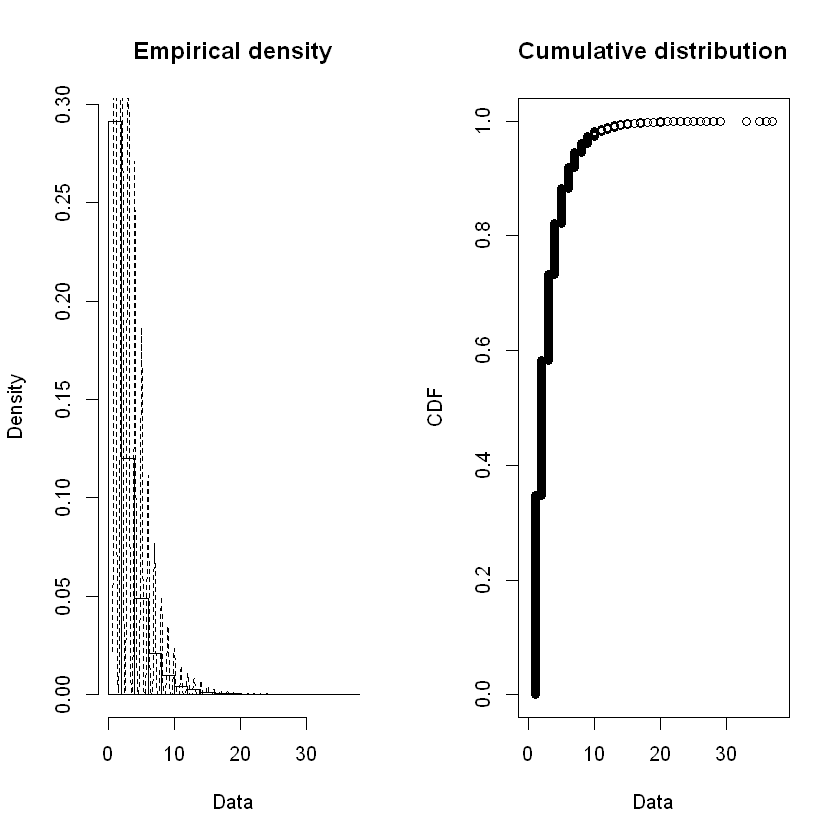

In [405]:
plotdist( dLOSep$Wet_Count, histo=TRUE, demp=TRUE )

In [406]:
LOfd_NB_dSep <- fitdist( dLOSep$Wet_Count, "nbinom" )
LOfd_GE_dSep <- fitdist( dLOSep$Wet_Count, "geom" )

In [407]:
LOfdNB_dSep_size <- LOfd_NB_dSep$estimate[["size"]]
LOfdNB_dSep_mu <- LOfd_NB_dSep$estimate[["mu"]]
cat("LOCA Sep size: ", LOfdNB_dSep_size, "\n", "LOCA Sep mu: ", LOfdNB_dSep_mu, "\n")

LOCA Sep size:  4.078095 
 LOCA Sep mu:  2.904208 


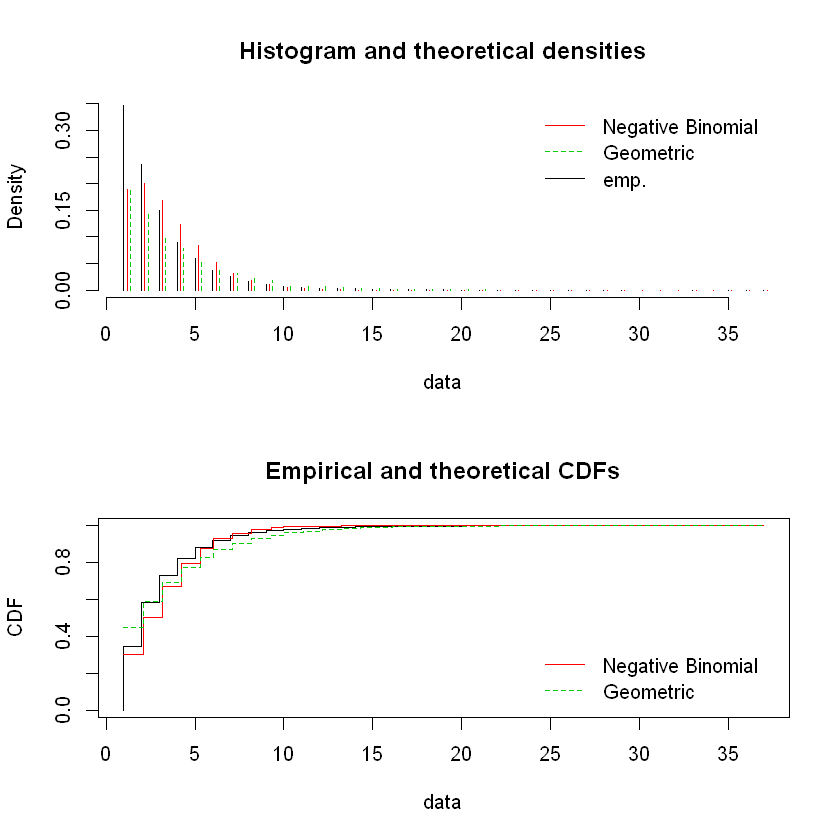

In [408]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dSep, LOfd_GE_dSep), legendtext=plot.legend )

In [409]:
LOstatRes <- gofstat( list(LOfd_NB_dSep, LOfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [410]:
print( LOstatRes )

Chi-squared statistic:  190446.5 150090.9 
Degree of freedom of the Chi-squared distribution:  13 14 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     415783            360994.5740     536016.440
<= 2     283391            239844.0263     170067.707
<= 3     179558            202117.6058     126501.557
<= 4     108247            148761.1587      94095.724
<= 5      71673             99967.1974      69991.274
<= 6      45206             62911.4946      52061.649
<= 7      30497             37673.7997      38725.045
<= 8      20001             21699.1907      28804.872
<= 9      13754             12112.3520      21425.944
<= 10      9494              6588.7342      15937.272
<= 11      5637              3507.3750      11854.630
<= 12      4288              1833.0590       8817.836
<= 13      3236               942.9675       6558.976
<= 14      2832               478.4506       4878.767
<= 16      2703               358.7952    

In [411]:
LOfdNB_dSep_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [412]:
LOfdNB_dSep_p = LOfdNB_dSep_size / (LOfdNB_dSep_size + LOfdNB_dSep_mu)
cat("LOCA prob: ", LOfdNB_dSep_p)

LOCA prob:  0.5840616

In [413]:
# add to our tracking dataframe
LOMonDistDF[9, ] <- list( 9, dLOSepMean, dLOSepBNr, LOfdNB_dSep_p, LOfdNB_dSep_mu, LOfdNB_dSep_size,
                          LOfdNB_dSep_pvalue )

In [414]:
LOgf_dSep <- goodfit( dLOSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dSep_size, prob=LOfdNB_dSep_p) )

In [415]:
summary( LOgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                        X^2 df P(> X^2)
Pearson          12005382.6 37        0
Likelihood Ratio   473447.5 32        0


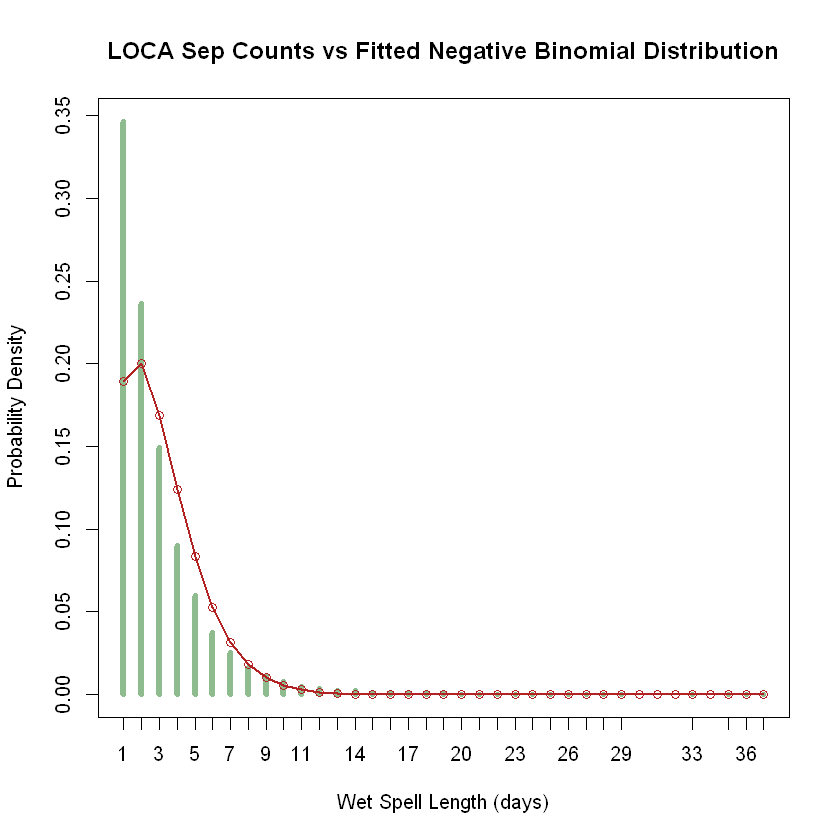

In [416]:
maxP <- max(dLOSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dSep_size, mu=LOfdNB_dSep_mu )
ttab <- table( dLOSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

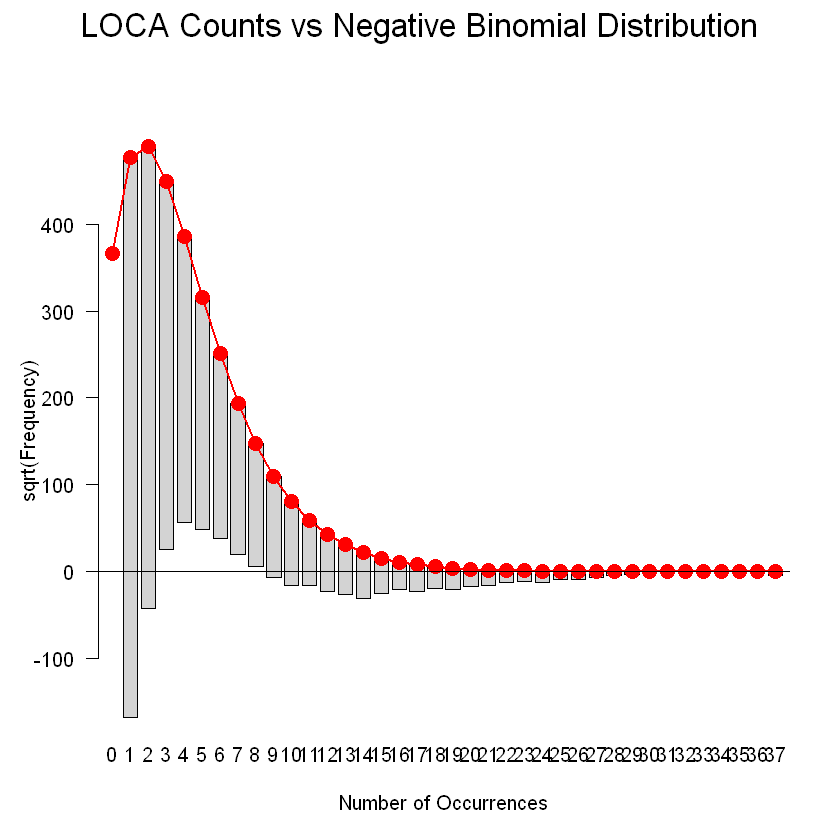

In [417]:
plot( LOgf_dSep, main="LOCA Counts vs Negative Binomial Distribution" )

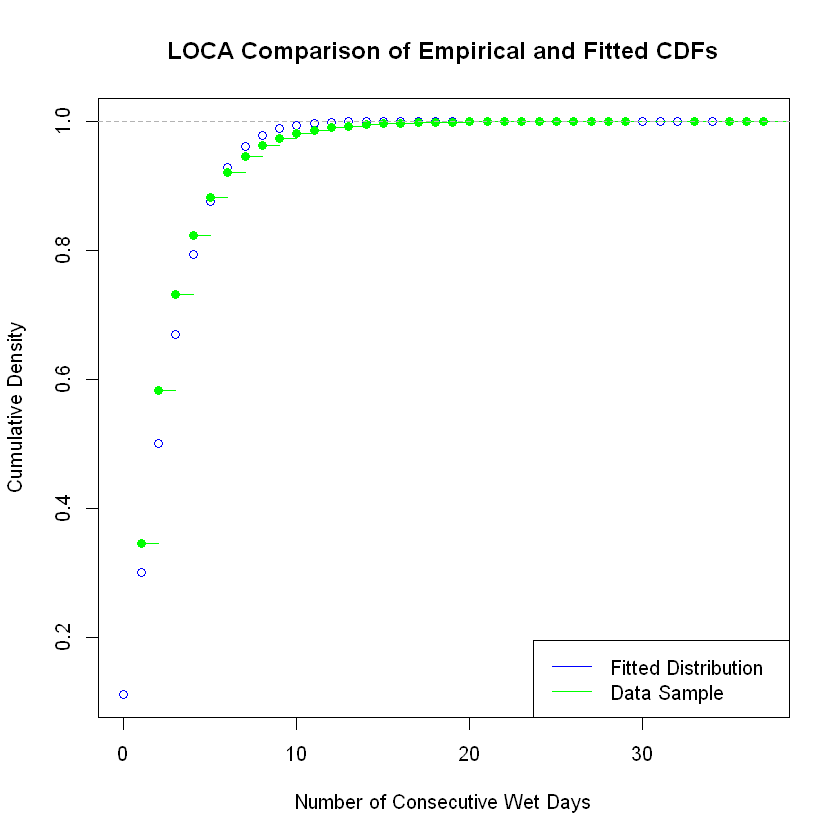

In [418]:
x <- seq(0,dLOSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dSep_mu, size=LOfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

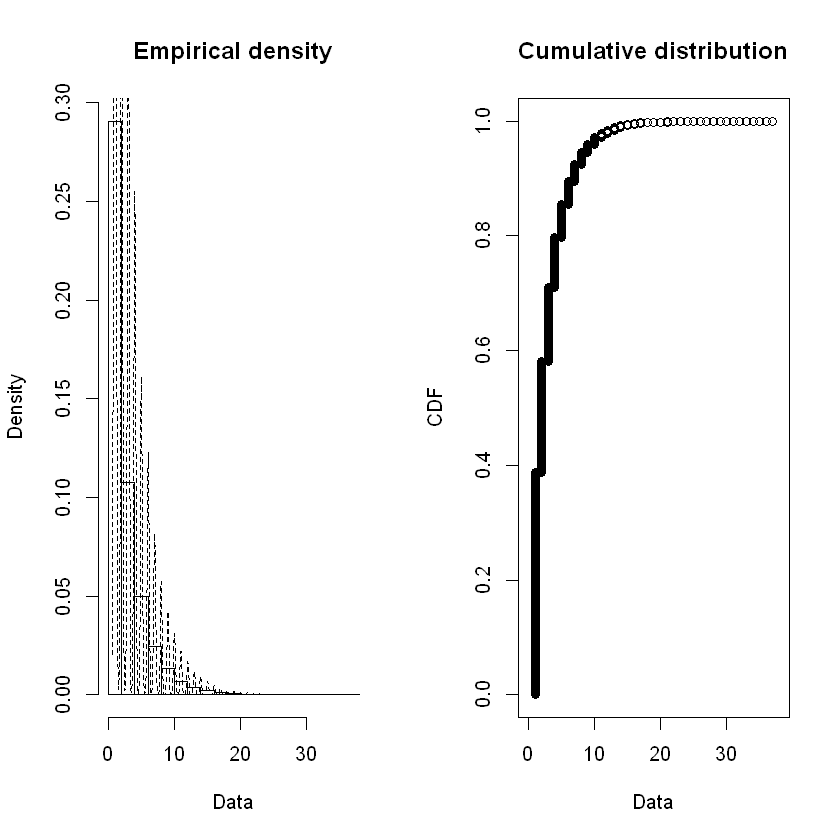

In [419]:
plotdist( dBCSep$Wet_Count, histo=TRUE, demp=TRUE )

In [420]:
BCfd_NB_dSep <- fitdist( dBCSep$Wet_Count, "nbinom" )
BCfd_GE_dSep <- fitdist( dBCSep$Wet_Count, "geom" )

In [421]:
summary( BCfd_NB_dSep )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 2.936548 0.008462714
mu   3.050594 0.002775516
Loglikelihood:  -1737670   AIC:  3475345   BIC:  3475368 
Correlation matrix:
              size            mu
size  1.0000000000 -0.0003913937
mu   -0.0003913937  1.0000000000


In [422]:
BCfdNB_dSep_size <- BCfd_NB_dSep$estimate[["size"]]
BCfdNB_dSep_mu <- BCfd_NB_dSep$estimate[["mu"]]
cat("BCCA Sep size: ", BCfdNB_dSep_size, "\n", "BCCA Sep mu: ", BCfdNB_dSep_mu, "\n")

BCCA Sep size:  2.936548 
 BCCA Sep mu:  3.050594 


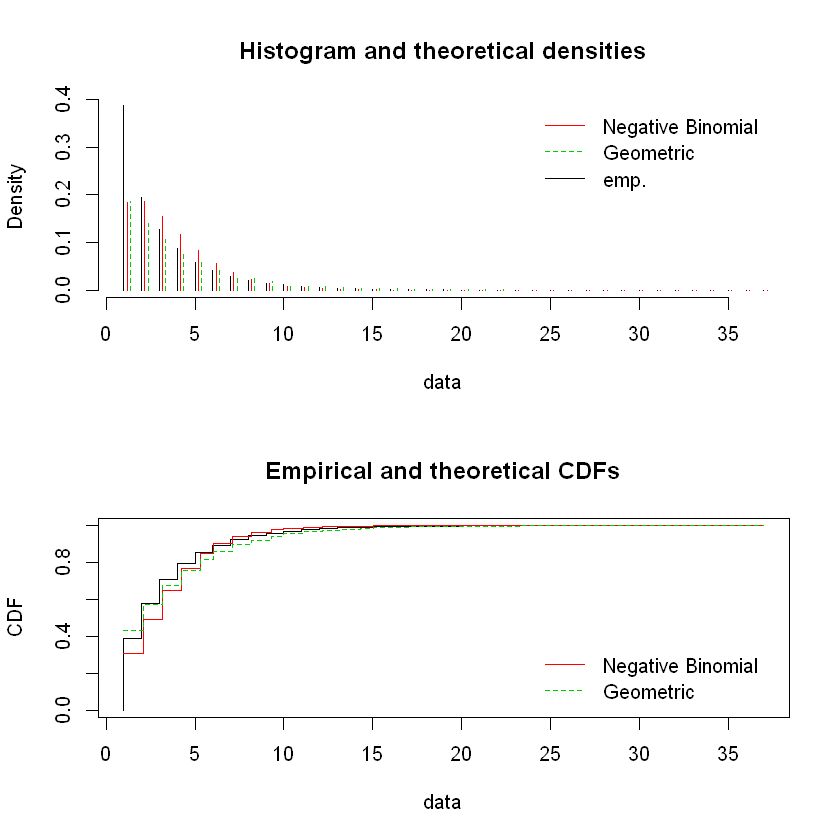

In [423]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dSep, BCfd_GE_dSep), legendtext=plot.legend )

In [424]:
BCstatRes <- gofstat( list(BCfd_NB_dSep, BCfd_GE_dSep), fitnames=c("Negative Binomial", "Geometric") )

In [425]:
print(BCstatRes)

Chi-squared statistic:  90161.97 33309.22 
Degree of freedom of the Chi-squared distribution:  14 15 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     312408           248890.67463     349623.011
<= 2     157018           149614.68798     113104.075
<= 3     103565           125441.48157      85176.136
<= 4      70458            94859.31715      64144.233
<= 5      46649            67052.99910      48305.580
<= 6      33350            45192.19361      36377.846
<= 7      23660            29396.79540      27395.338
<= 8      16132            18604.17218      20630.813
<= 9      12111            11518.95058      15536.602
<= 10      8922             7005.77964      11700.265
<= 11      6414             4198.04413       8811.207
<= 12      4714             2484.19553       6635.522
<= 13      3436             1454.31160       4997.062
<= 14      2445              843.50661       3763.175
<= 16      3250              762.45947    

In [426]:
BCfdNB_dSep_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [427]:
BCfdNB_dSep_p = BCfdNB_dSep_size / (BCfdNB_dSep_size + BCfdNB_dSep_mu)
cat("BCCA prob: ", BCfdNB_dSep_p)

BCCA prob:  0.4904758

In [428]:
# add to our tracking dataframe
BCMonDistDF[9, ] <- list( 9, dBCSepMean, dBCSepBNr, BCfdNB_dSep_p, BCfdNB_dSep_mu, BCfdNB_dSep_size,
                          BCfdNB_dSep_pvalue )

In [429]:
BCgf_dSep <- goodfit( dBCSep$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dSep_size, prob=BCfdNB_dSep_p) )

In [430]:
summary( BCgf_dSep )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          451565.2 37        0
Likelihood Ratio 379294.4 36        0


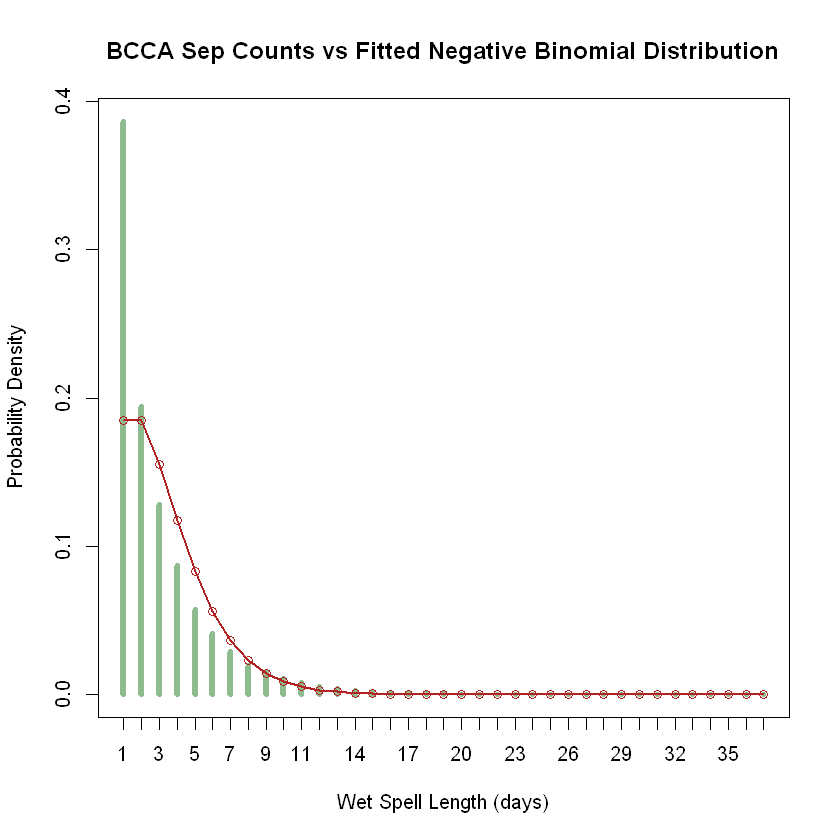

In [431]:
maxP <- max(dBCSep$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dSep_size, mu=BCfdNB_dSep_mu )
ttab <- table( dBCSep$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Sep Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

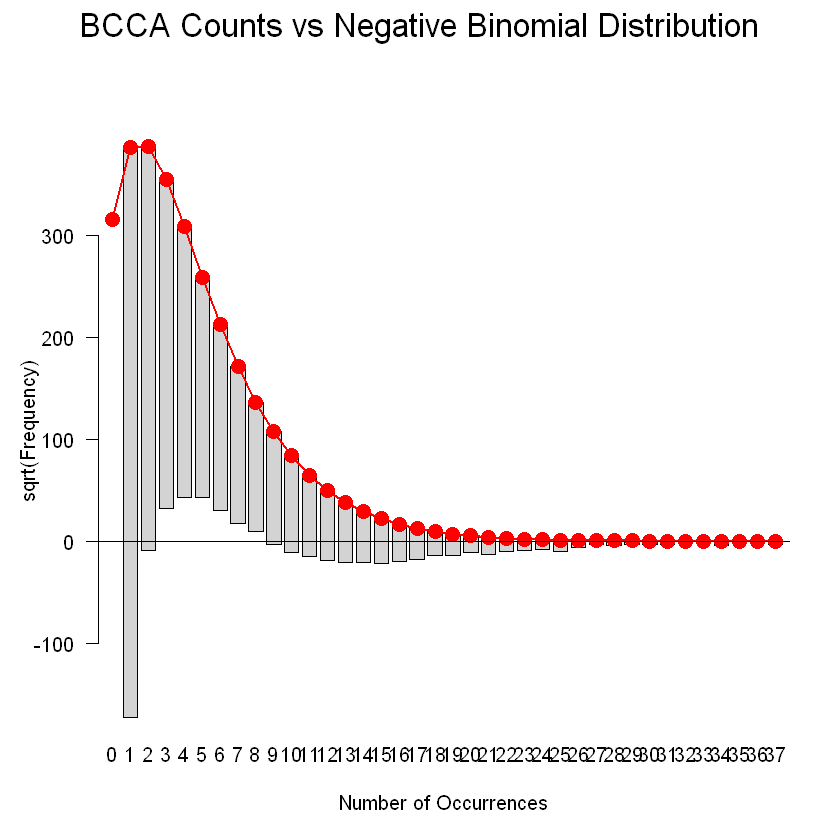

In [432]:
plot( BCgf_dSep, main="BCCA Counts vs Negative Binomial Distribution" )

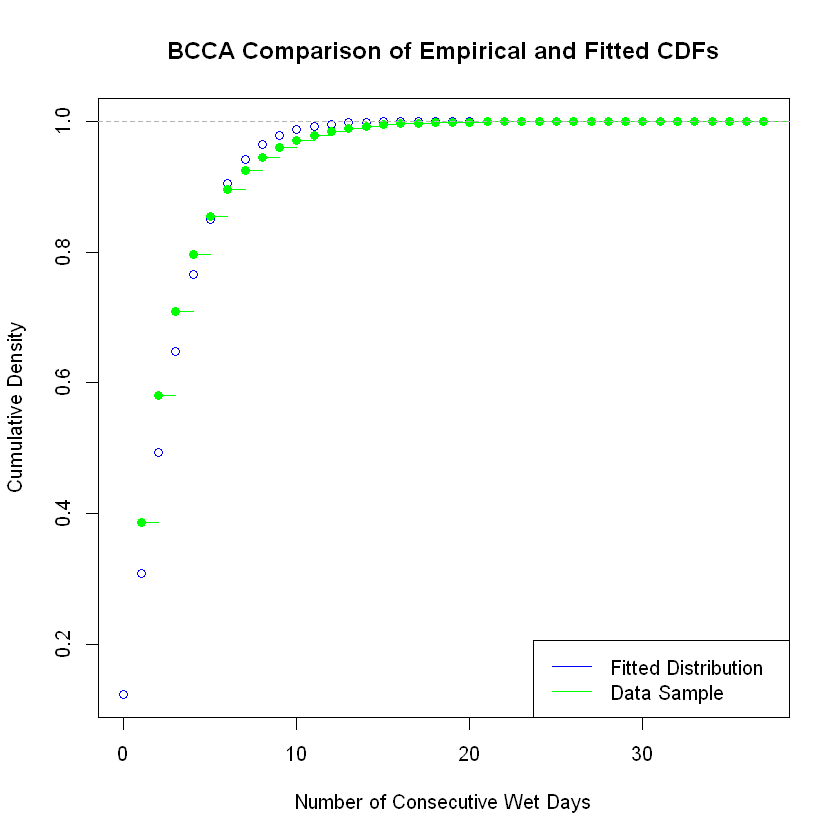

In [433]:
x <- seq(0,dBCSepMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dSep_mu, size=BCfdNB_dSep_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCSep$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

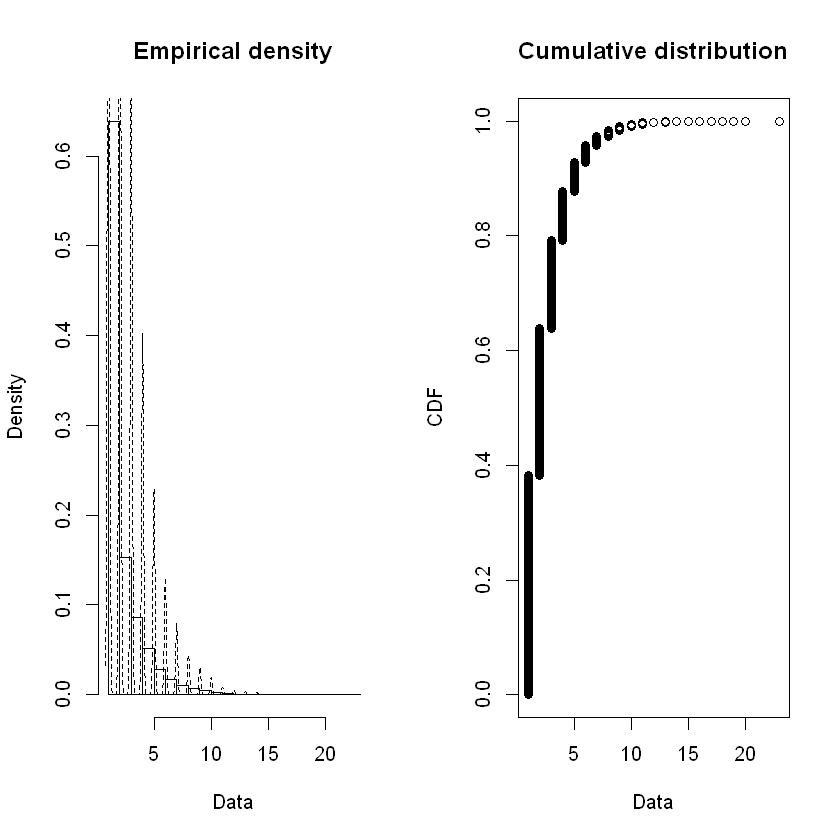

In [434]:
plotdist( dLOOct$Wet_Count, histo=TRUE, demp=TRUE )

In [435]:
LOfd_NB_dOct <- fitdist( dLOOct$Wet_Count, "nbinom" )
LOfd_GE_dOct <- fitdist( dLOOct$Wet_Count, "geom" )

In [436]:
LOfdNB_dOct_size <- LOfd_NB_dOct$estimate[["size"]]
LOfdNB_dOct_mu <- LOfd_NB_dOct$estimate[["mu"]]
cat("LOCA Oct size: ", LOfdNB_dOct_size, "\n", "LOCA Oct mu: ", LOfdNB_dOct_mu, "\n")

LOCA Oct size:  9.502394 
 LOCA Oct mu:  2.484525 


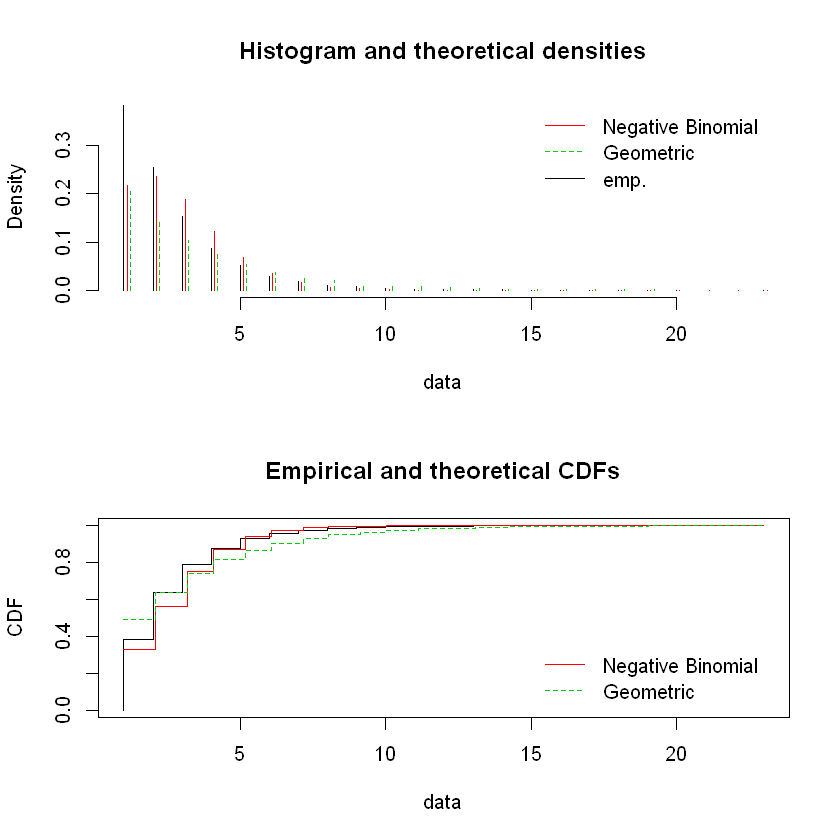

In [437]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dOct, LOfd_GE_dOct), legendtext=plot.legend )

In [438]:
LOstatRes <- gofstat( list(LOfd_NB_dOct, LOfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [439]:
print( LOstatRes )

Chi-squared statistic:  114694.5 181915.5 
Degree of freedom of the Chi-squared distribution:  9 10 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     424711           362215.44364      545059.01
<= 2     283524           261479.71050      161763.60
<= 3     169283           207797.69984      115340.06
<= 4      95519           134620.02973       82239.33
<= 5      56922            75350.51267       58637.97
<= 6      31188            37749.43177       41809.82
<= 7      19102            17327.93889       29811.08
<= 8      11149             7408.65943       21255.78
<= 9       7424             2986.27870       15155.72
<= 10      4705             1145.23344       10806.27
<= 12      3263              569.88134       13198.87
> 12       1937               76.18005       13649.49

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           4125452   4631643
Bayesia

In [440]:
LOfdNB_dOct_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [441]:
LOfdNB_dOct_p = LOfdNB_dOct_size / (LOfdNB_dOct_size + LOfdNB_dOct_mu)
cat("LOCA prob: ", LOfdNB_dOct_p)

LOCA prob:  0.7927303

In [442]:
# add to our tracking dataframe
LOMonDistDF[10, ] <- list( 10, dLOOctMean, dLOOctBNr, LOfdNB_dOct_p, LOfdNB_dOct_mu, LOfdNB_dOct_size,
                          LOfdNB_dOct_pvalue )

In [443]:
LOgf_dOct <- goodfit( dLOOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dOct_size, prob=LOfdNB_dOct_p) )

In [444]:
summary( LOgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          493073.4 23        0
Likelihood Ratio 415797.2 20        0


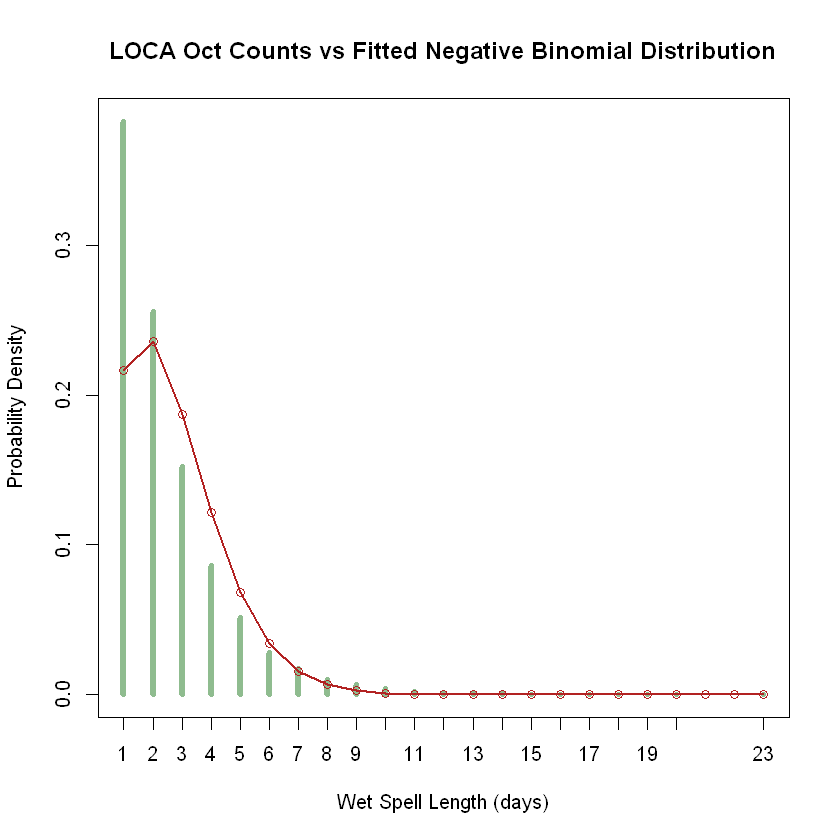

In [445]:
maxP <- max(dLOOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dOct_size, mu=LOfdNB_dOct_mu )
ttab <- table( dLOOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

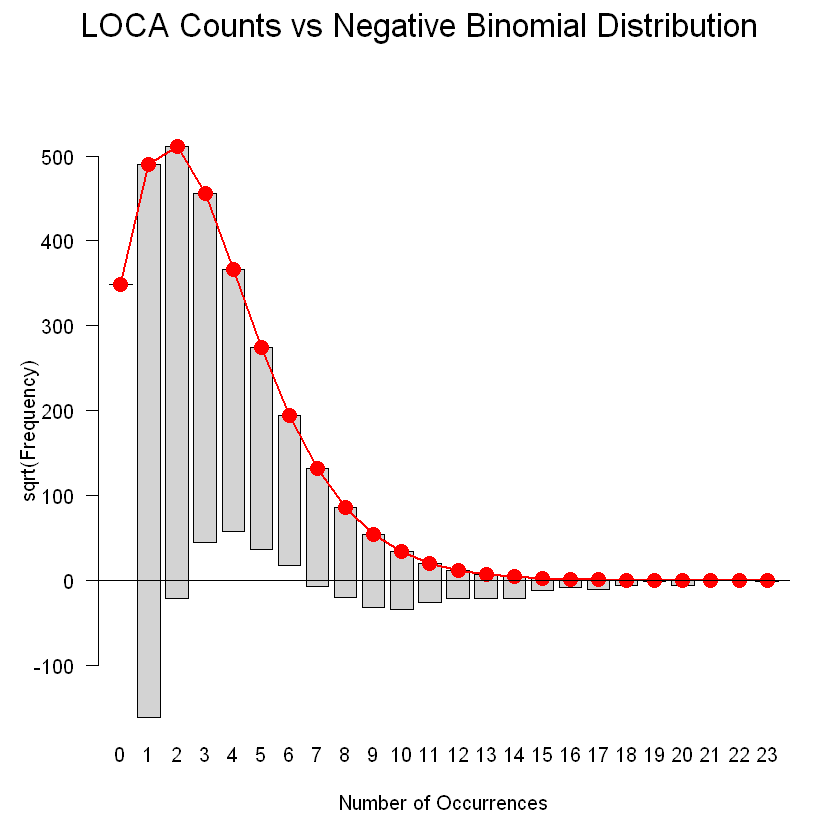

In [446]:
plot( LOgf_dOct, main="LOCA Counts vs Negative Binomial Distribution" )

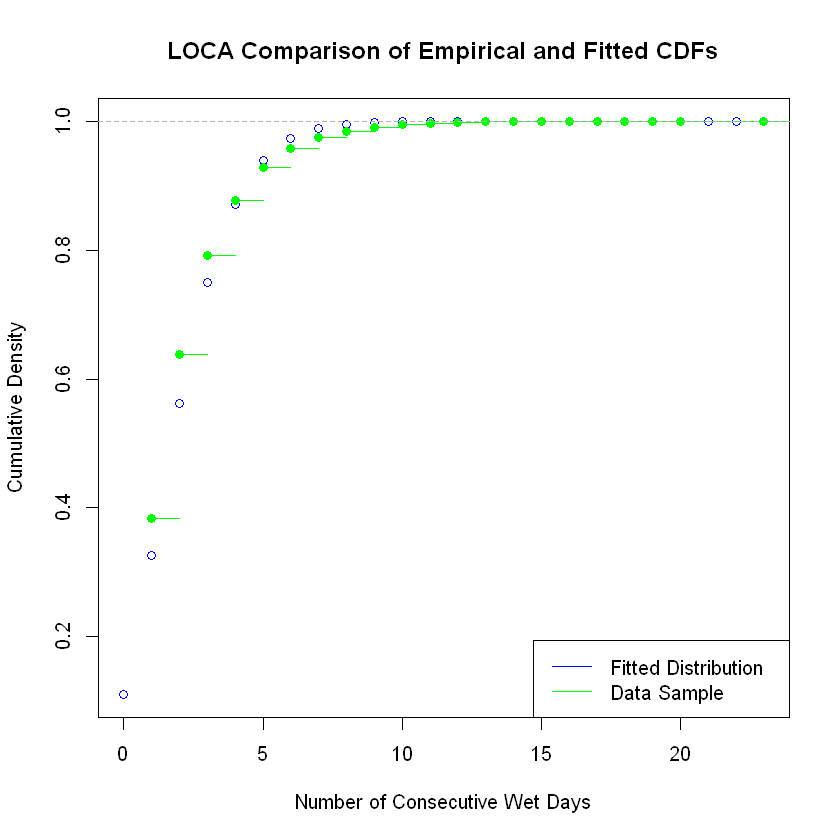

In [447]:
x <- seq(0,dLOOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dOct_mu, size=LOfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLOOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

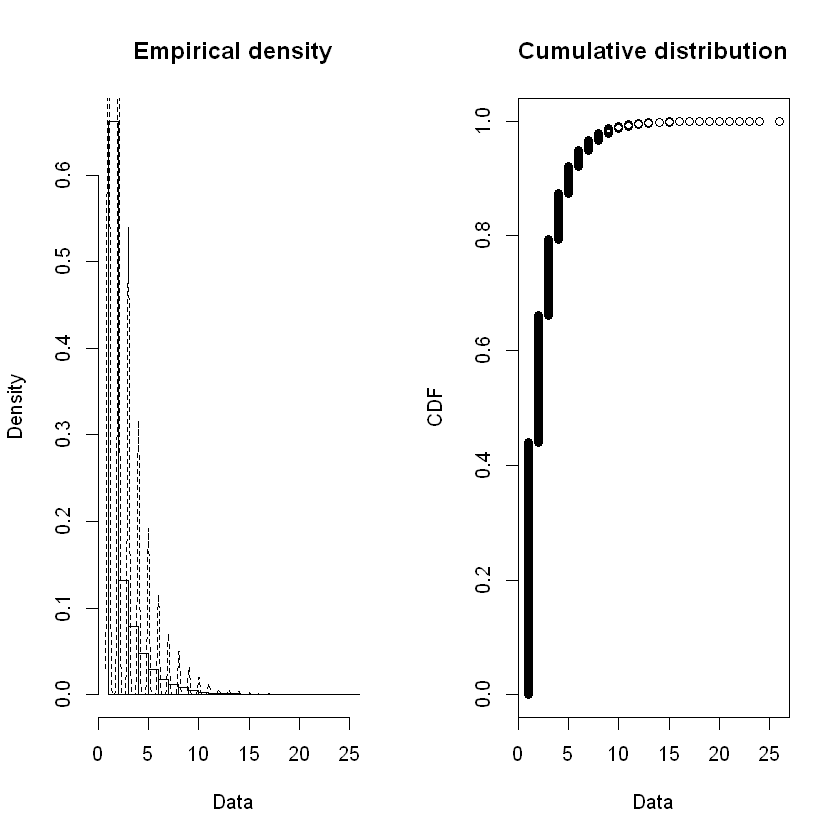

In [448]:
plotdist( dBCOct$Wet_Count, histo=TRUE, demp=TRUE )

In [449]:
BCfd_NB_dOct <- fitdist( dBCOct$Wet_Count, "nbinom" )
BCfd_GE_dOct <- fitdist( dBCOct$Wet_Count, "geom" )

In [450]:
summary( BCfd_NB_dOct )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
     estimate  Std. Error
size 5.752996 0.028617807
mu   2.451298 0.002215404
Loglikelihood:  -1350101   AIC:  2700206   BIC:  2700229 
Correlation matrix:
              size            mu
size  1.000000e+00 -7.482954e-05
mu   -7.482954e-05  1.000000e+00


In [451]:
BCfdNB_dOct_size <- BCfd_NB_dOct$estimate[["size"]]
BCfdNB_dOct_mu <- BCfd_NB_dOct$estimate[["mu"]]
cat("BCCA Oct size: ", BCfdNB_dOct_size, "\n", "BCCA Oct mu: ", BCfdNB_dOct_mu, "\n")

BCCA Oct size:  5.752996 
 BCCA Oct mu:  2.451298 


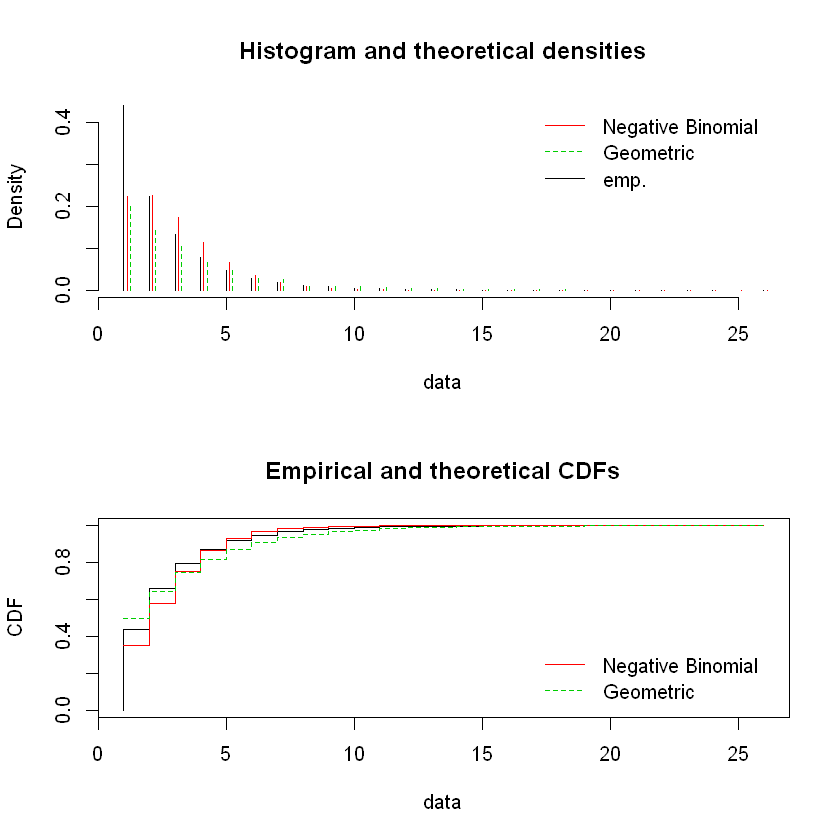

In [452]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dOct, BCfd_GE_dOct), legendtext=plot.legend )

In [453]:
BCstatRes <- gofstat( list(BCfd_NB_dOct, BCfd_GE_dOct), fitnames=c("Negative Binomial", "Geometric") )

In [454]:
print(BCstatRes)

Chi-squared statistic:  103678.6 54649.42 
Degree of freedom of the Chi-squared distribution:  10 11 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     312972           251331.68859     352982.169
<= 2     158628           160297.00813     104114.298
<= 3      94290           123773.76842      73946.613
<= 4      56322            80924.54033      52520.179
<= 5      33604            47163.18970      37302.171
<= 6      20508            25254.35536      26493.664
<= 7      12386            12668.98197      18816.981
<= 8       8655             6034.18798      13364.658
<= 9       5525             2755.04390       9492.176
<= 10      3531             1214.40522       6741.766
<= 11      2180              519.62374       4788.303
<= 13      2005              305.18587       5816.312
> 13       1694               58.02079       5920.709

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's In

In [455]:
BCfdNB_dOct_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [456]:
BCfdNB_dOct_p = BCfdNB_dOct_size / (BCfdNB_dOct_size + BCfdNB_dOct_mu)
cat("BCCA prob: ", BCfdNB_dOct_p)

BCCA prob:  0.7012177

In [457]:
# add to our tracking dataframe
BCMonDistDF[10, ] <- list( 10, dBCOctMean, dBCOctBNr, BCfdNB_dOct_p, BCfdNB_dOct_mu, BCfdNB_dOct_size,
                          BCfdNB_dOct_pvalue )

In [458]:
BCgf_dOct <- goodfit( dBCOct$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dOct_size, prob=BCfdNB_dOct_p) )

In [459]:
summary( BCgf_dOct )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          668929.2 26        0
Likelihood Ratio 345185.2 24        0


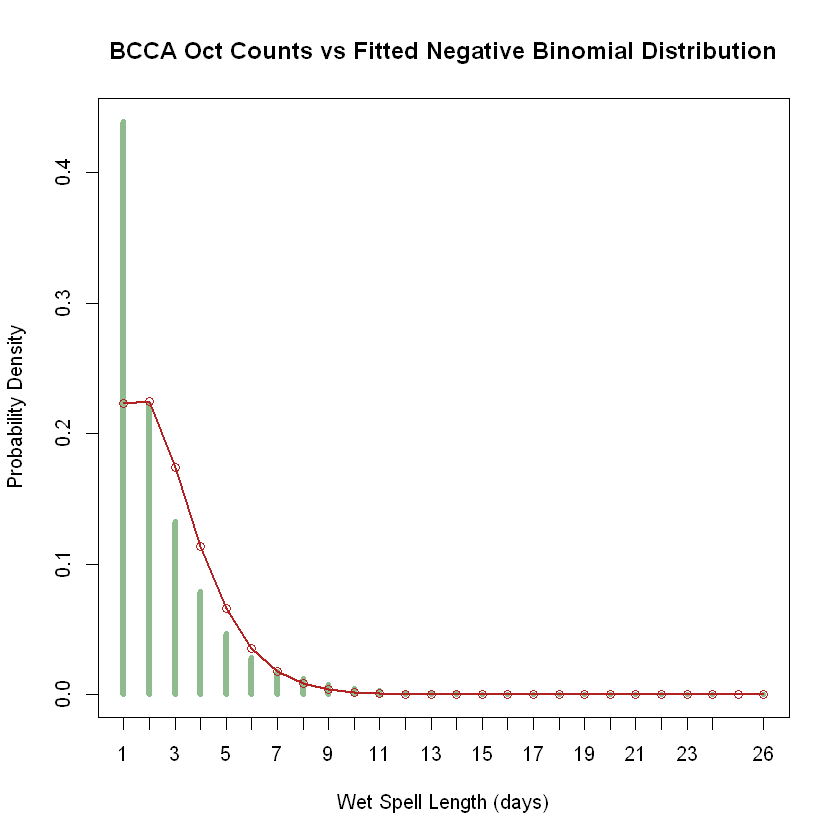

In [460]:
maxP <- max(dBCOct$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dOct_size, mu=BCfdNB_dOct_mu )
ttab <- table( dBCOct$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Oct Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

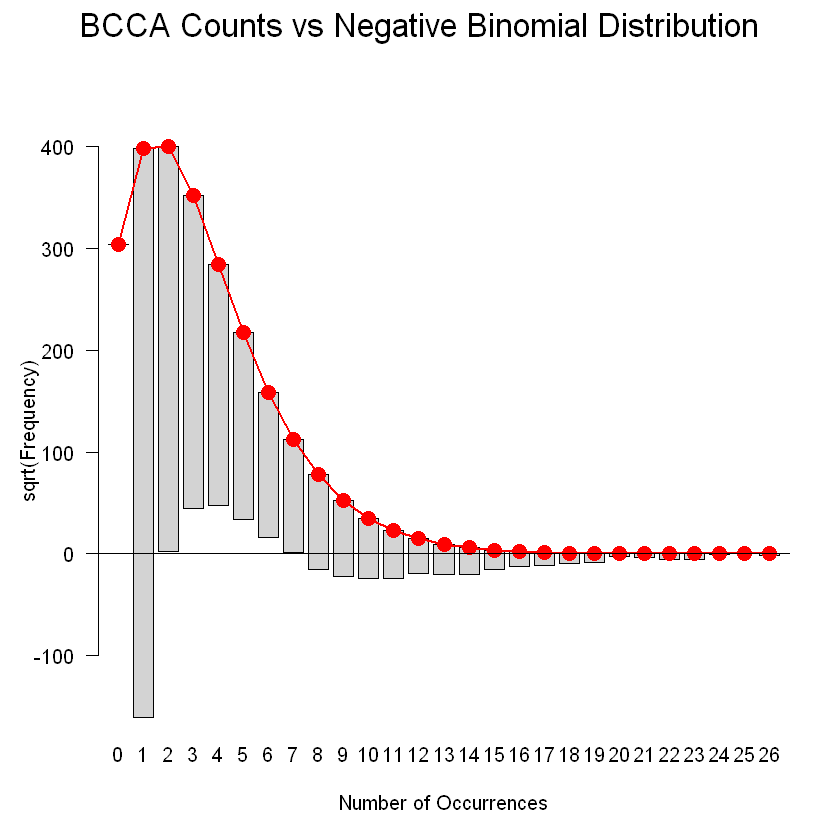

In [461]:
plot( BCgf_dOct, main="BCCA Counts vs Negative Binomial Distribution" )

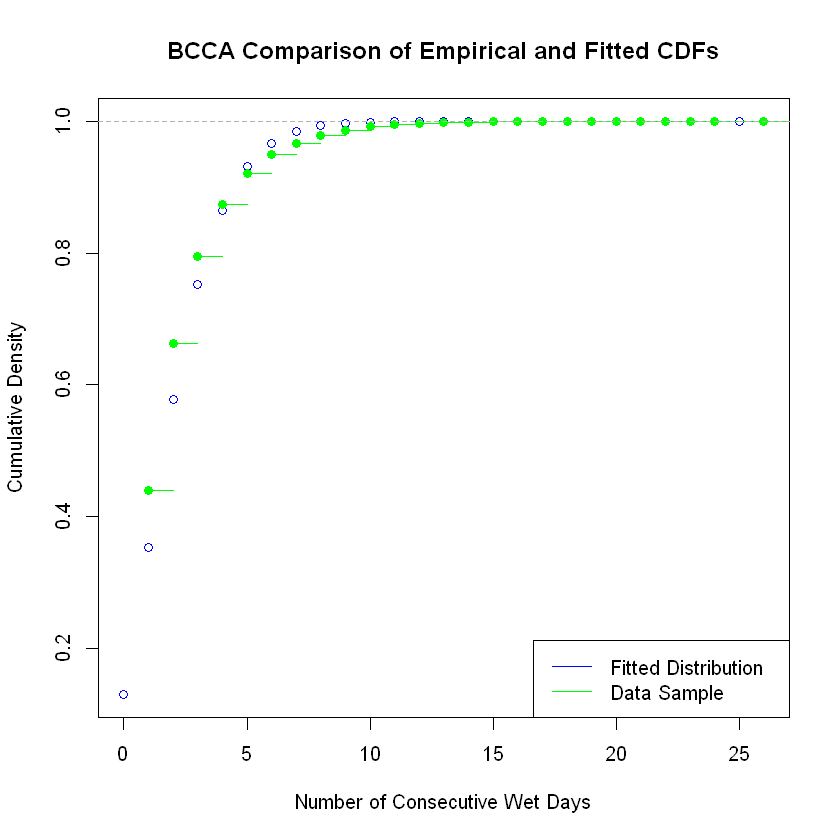

In [462]:
x <- seq(0,dBCOctMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dOct_mu, size=BCfdNB_dOct_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCOct$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

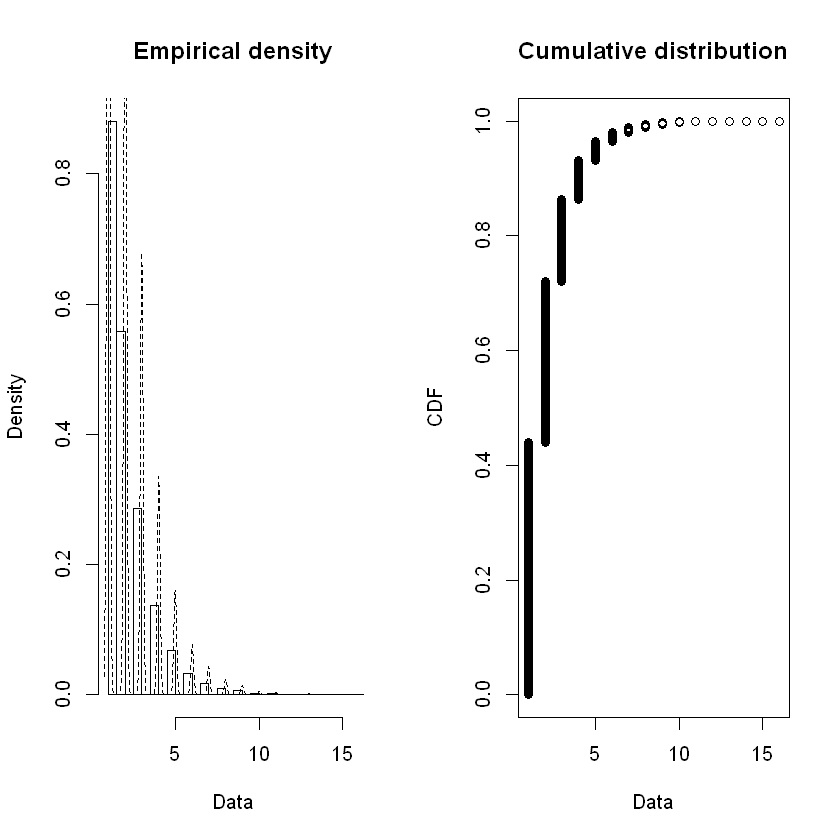

In [463]:
plotdist( dLONov$Wet_Count, histo=TRUE, demp=TRUE )

In [464]:
LOfd_NB_dNov <- fitdist( dLONov$Wet_Count, "nbinom" )
LOfd_GE_dNov <- fitdist( dLONov$Wet_Count, "geom" )

In [465]:
LOfdNB_dNov_size <- LOfd_NB_dNov$estimate[["size"]]
LOfdNB_dNov_mu <- LOfd_NB_dNov$estimate[["mu"]]
cat("LOCA Nov size: ", LOfdNB_dNov_size, "\n", "LOCA Nov mu: ", LOfdNB_dNov_mu, "\n")

LOCA Nov size:  4713.861 
 LOCA Nov mu:  2.118293 


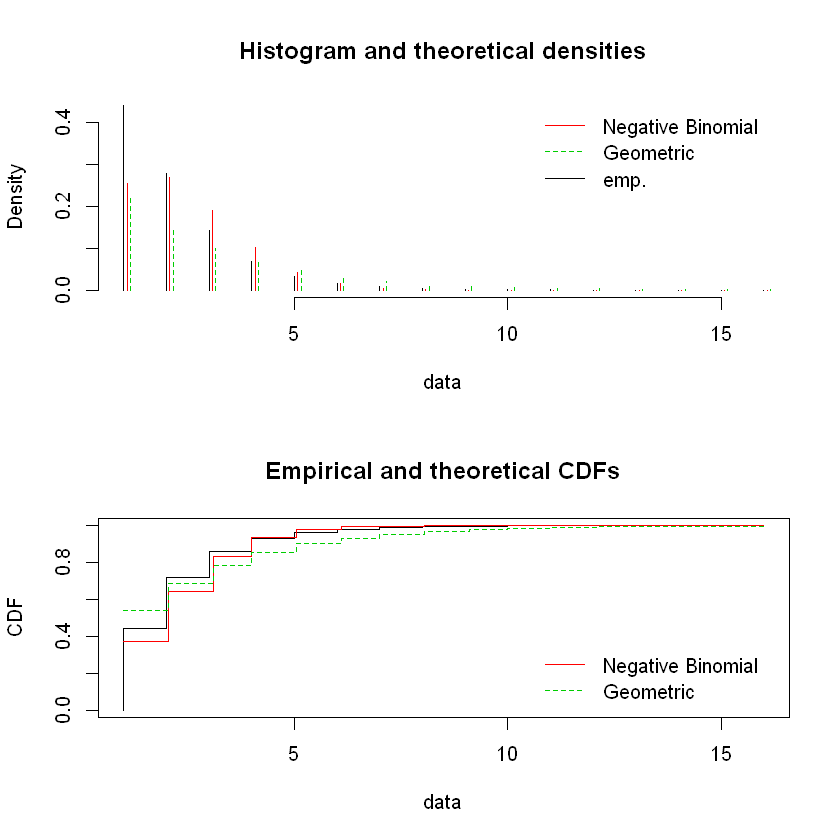

In [466]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dNov, LOfd_GE_dNov), legendtext=plot.legend )

In [467]:
LOstatRes <- gofstat( list(LOfd_NB_dNov, LOfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [468]:
print( LOstatRes )

Chi-squared statistic:  139185.8 216896 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    479907           408594.97489      586785.61
<= 2    304393           293868.28904      161245.05
<= 3    155869           207494.55680      109535.66
<= 4     74581           109904.13644       74408.86
<= 5     36852            46580.42193       50546.82
<= 6     17570            16455.21630       34337.05
<= 7      9623             4983.66690       23325.56
<= 8      5390             1320.97463       15845.33
<= 9      3177              311.30021       10763.92
> 9       2233               81.46286       22801.14

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3628770   4263320
Bayesian Information Criterion           3628793   4263332


In [469]:
LOfdNB_dNov_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [470]:
LOfdNB_dNov_p = LOfdNB_dNov_size / (LOfdNB_dNov_size + LOfdNB_dNov_mu)
cat("LOCA prob: ", LOfdNB_dNov_p)

LOCA prob:  0.9995508

In [471]:
# add to our tracking dataframe
LOMonDistDF[11, ] <- list( 11, dLONovMean, dLONovBNr, LOfdNB_dNov_p, LOfdNB_dNov_mu, LOfdNB_dNov_size,
                          LOfdNB_dNov_pvalue )

In [472]:
LOgf_dNov <- goodfit( dLONov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dNov_size, prob=LOfdNB_dNov_p) )

In [473]:
summary( LOgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                       X^2 df P(> X^2)
Pearson          1813516.9 16        0
Likelihood Ratio  445612.5 15        0


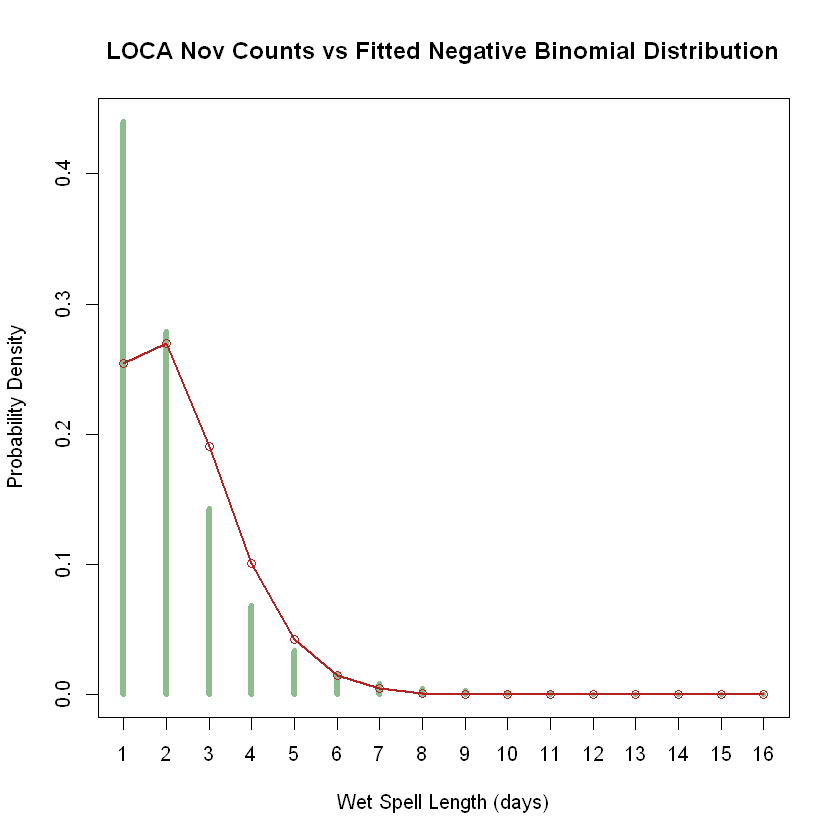

In [474]:
maxP <- max(dLONov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dNov_size, mu=LOfdNB_dNov_mu )
ttab <- table( dLONov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

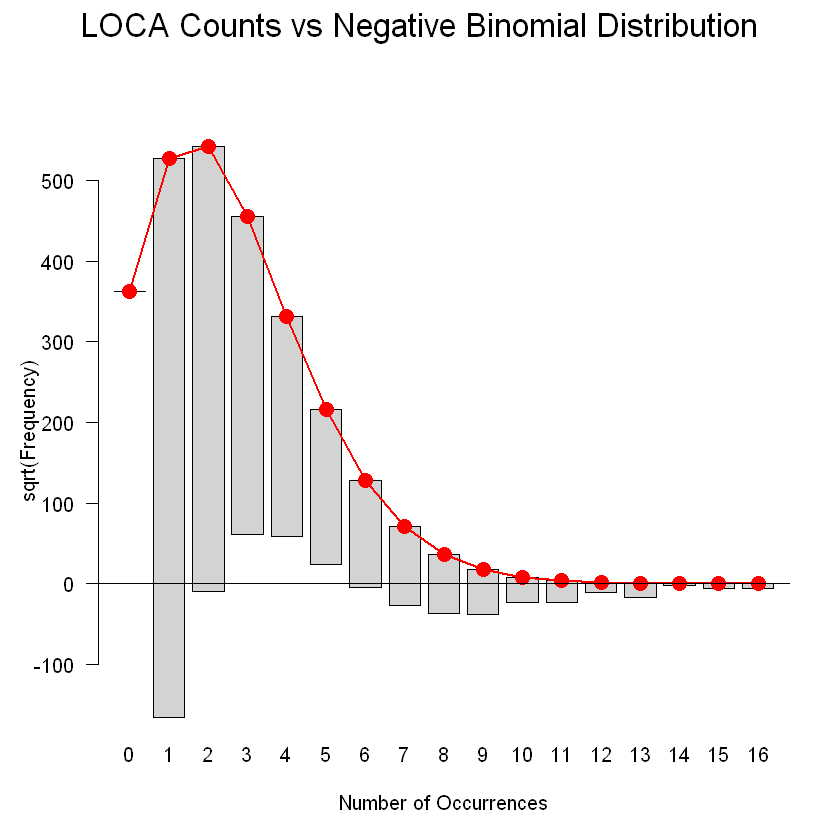

In [475]:
plot( LOgf_dNov, main="LOCA Counts vs Negative Binomial Distribution" )

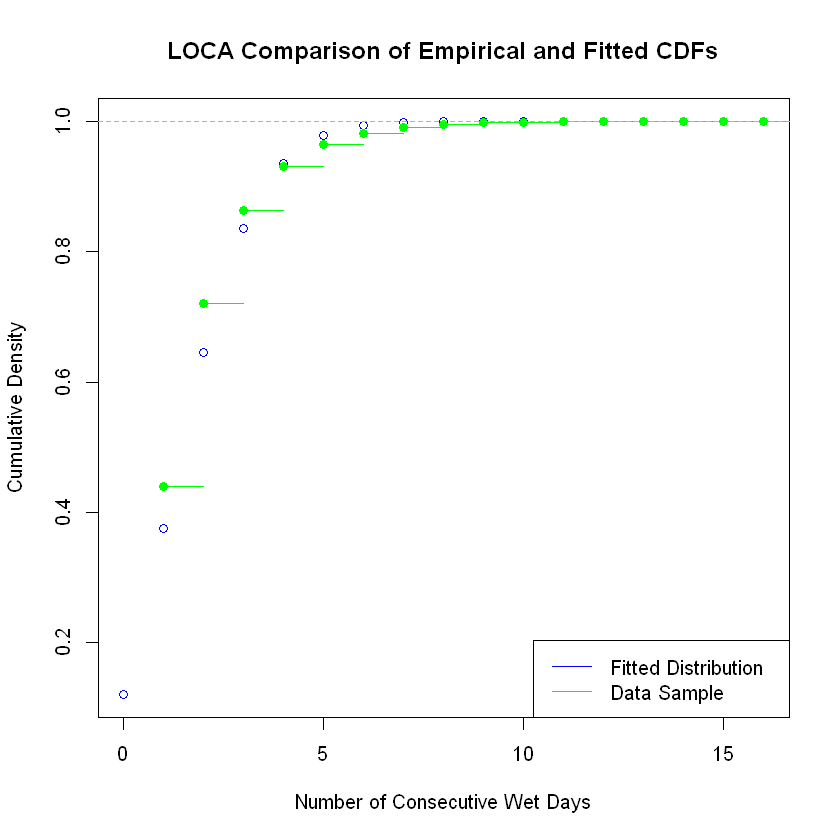

In [476]:
x <- seq(0,dLONovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dNov_mu, size=LOfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLONov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

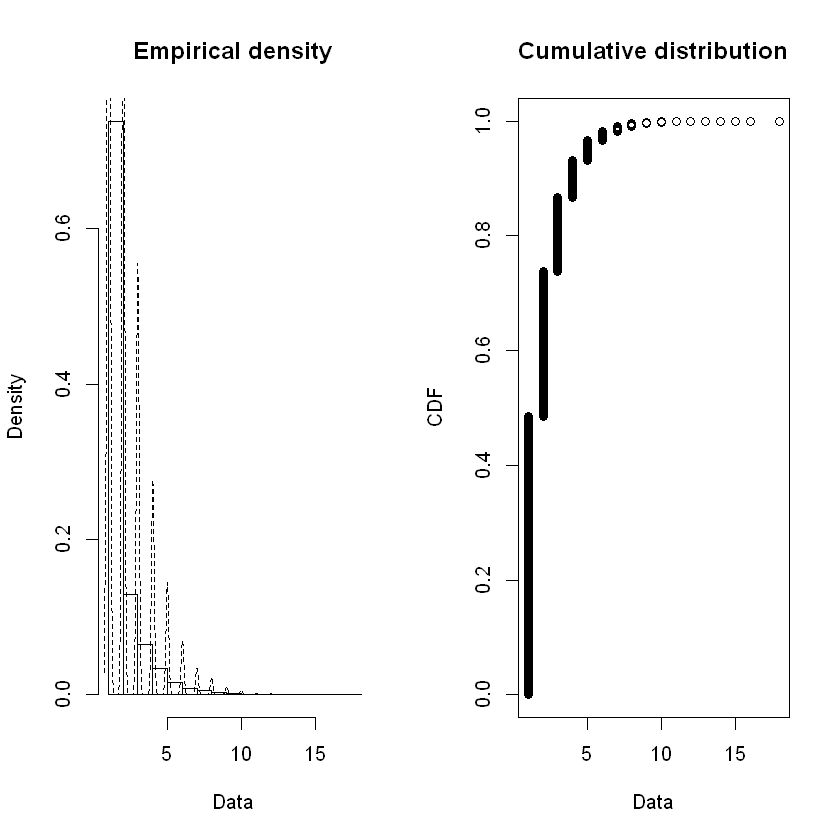

In [477]:
plotdist( dBCNov$Wet_Count, histo=TRUE, demp=TRUE )

In [478]:
BCfd_NB_dNov <- fitdist( dBCNov$Wet_Count, "nbinom" )
BCfd_GE_dNov <- fitdist( dBCNov$Wet_Count, "geom" )

In [479]:
summary( BCfd_NB_dNov )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
       estimate   Std. Error
size 128.556892 11.676821843
mu     2.045936  0.001773019
Loglikelihood:  -1091707   AIC:  2183419   BIC:  2183442 
Correlation matrix:
              size            mu
size  1.000000e+00 -3.976784e-05
mu   -3.976784e-05  1.000000e+00


In [480]:
BCfdNB_dNov_size <- BCfd_NB_dNov$estimate[["size"]]
BCfdNB_dNov_mu <- BCfd_NB_dNov$estimate[["mu"]]
cat("BCCA Nov size: ", BCfdNB_dNov_size, "\n", "BCCA Nov mu: ", BCfdNB_dNov_mu, "\n")

BCCA Nov size:  128.5569 
 BCCA Nov mu:  2.045936 


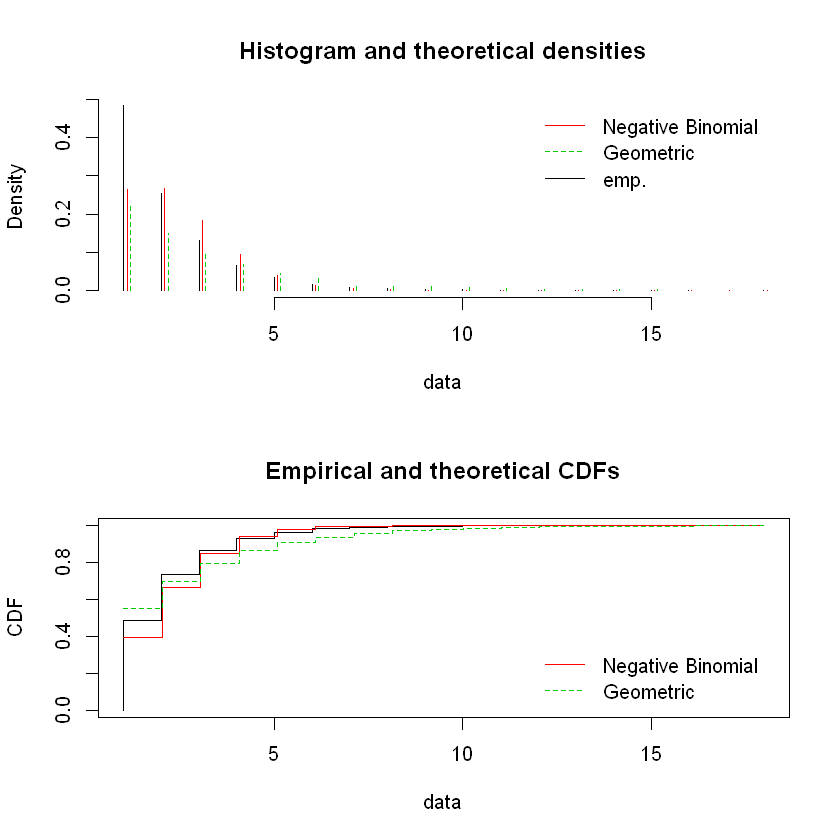

In [481]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dNov, BCfd_GE_dNov), legendtext=plot.legend )

In [482]:
BCstatRes <- gofstat( list(BCfd_NB_dNov, BCfd_GE_dNov), fitnames=c("Negative Binomial", "Geometric") )

In [483]:
print(BCstatRes)

Chi-squared statistic:  103791.3 88657 
Degree of freedom of the Chi-squared distribution:  7 8 
Chi-squared p-value:  0 0 
Chi-squared table:
      obscounts theo Negative Binomial theo Geometric
<= 1     320294           2.617692e+05     362891.122
<= 2     167951           1.774992e+05      97939.098
<= 3      85552           1.210081e+05      65784.498
<= 4      42753           6.234585e+04      44186.645
<= 5      22330           2.589281e+04      29679.631
<= 6      10783           9.028877e+03      19935.446
<= 7       5285           2.718824e+03      13390.396
<= 8       3315           7.216923e+02       8994.166
<= 10      2339           2.085034e+02      10099.120
> 10        600           8.889606e+00       8301.877

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2183419   2549561
Bayesian Information Criterion           2183442   2549572


In [484]:
BCfdNB_dNov_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [485]:
BCfdNB_dNov_p = BCfdNB_dNov_size / (BCfdNB_dNov_size + BCfdNB_dNov_mu)
cat("BCCA prob: ", BCfdNB_dNov_p)

BCCA prob:  0.9843347

In [486]:
# add to our tracking dataframe
BCMonDistDF[11, ] <- list( 11, dBCNovMean, dBCNovBNr, BCfdNB_dNov_p, BCfdNB_dNov_mu, BCfdNB_dNov_size,
                          BCfdNB_dNov_pvalue )

In [487]:
BCgf_dNov <- goodfit( dBCNov$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dNov_size, prob=BCfdNB_dNov_p) )

In [488]:
summary( BCgf_dNov )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          578503.3 18        0
Likelihood Ratio 309105.2 16        0


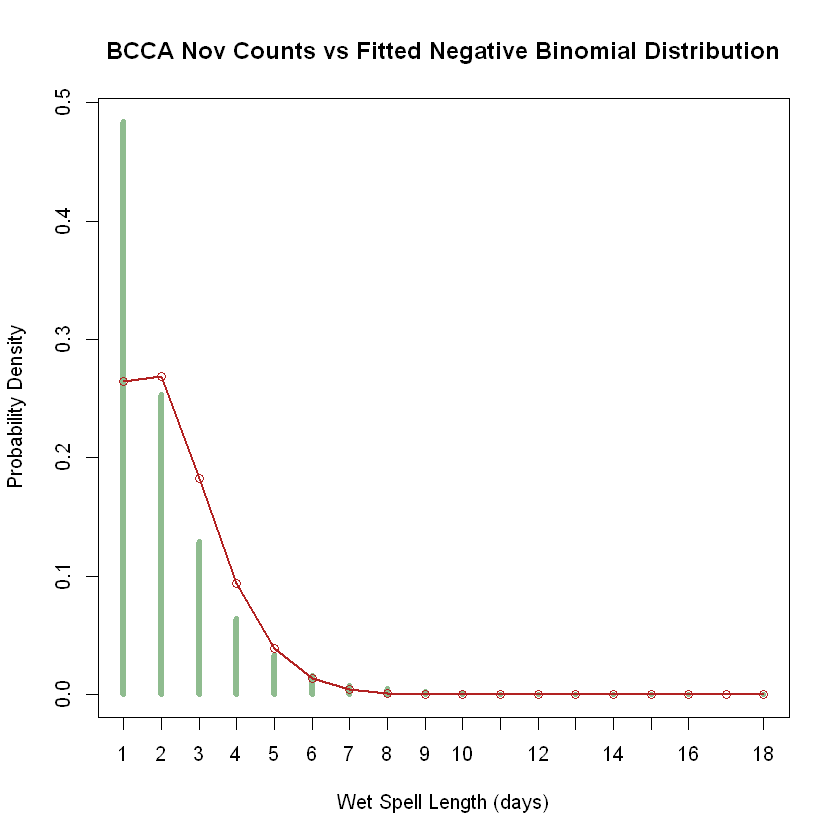

In [489]:
maxP <- max(dBCNov$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dNov_size, mu=BCfdNB_dNov_mu )
ttab <- table( dBCNov$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Nov Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

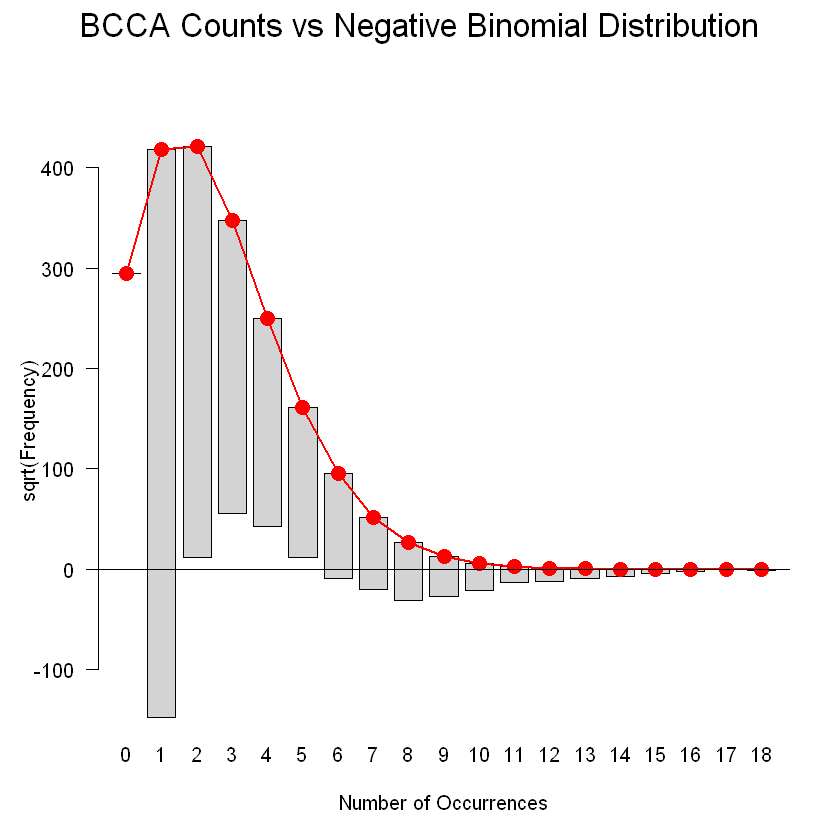

In [490]:
plot( BCgf_dNov, main="BCCA Counts vs Negative Binomial Distribution" )

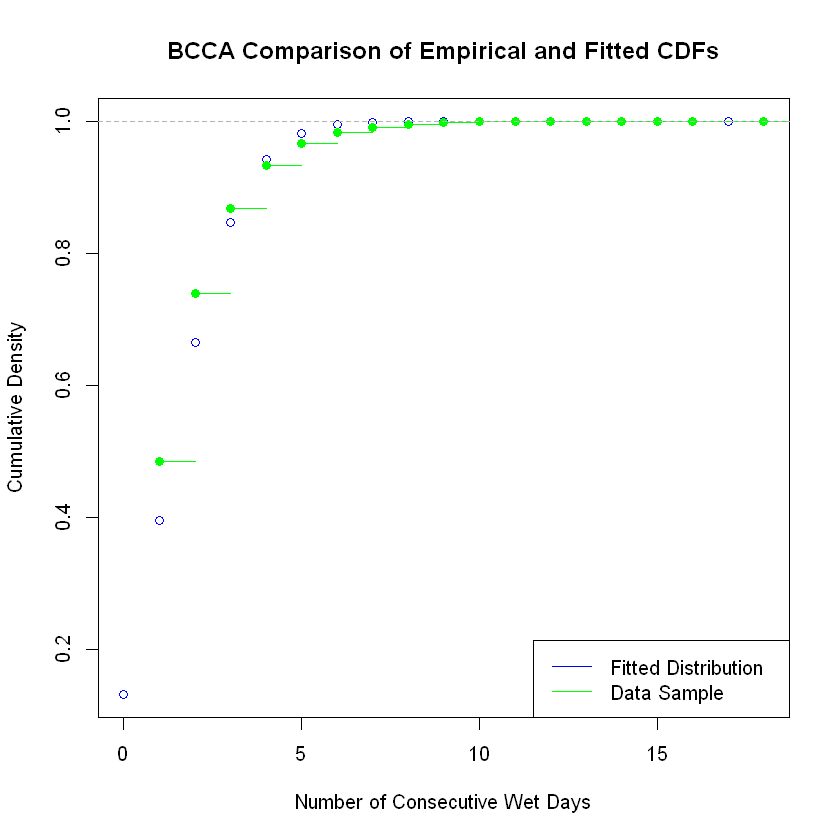

In [491]:
x <- seq(0,dBCNovMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dNov_mu, size=BCfdNB_dNov_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCNov$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

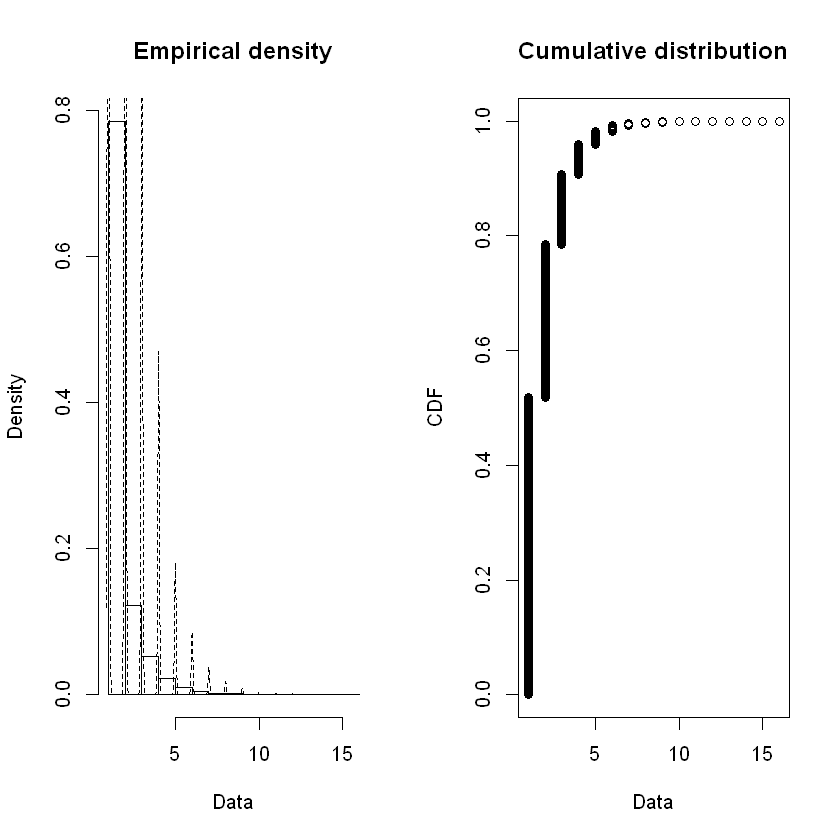

In [492]:
plotdist( dLODec$Wet_Count, histo=TRUE, demp=TRUE )

In [493]:
LOfd_NB_dDec <- fitdist( dLODec$Wet_Count, "nbinom" )
LOfd_GE_dDec <- fitdist( dLODec$Wet_Count, "geom" )

In [494]:
LOfdNB_dDec_size <- LOfd_NB_dDec$estimate[["size"]]
LOfdNB_dDec_mu <- LOfd_NB_dDec$estimate[["mu"]]
cat("LOCA Dec size: ", LOfdNB_dDec_size, "\n", "LOCA Dec mu: ", LOfdNB_dDec_mu, "\n")

LOCA Dec size:  8404404 
 LOCA Dec mu:  1.861857 


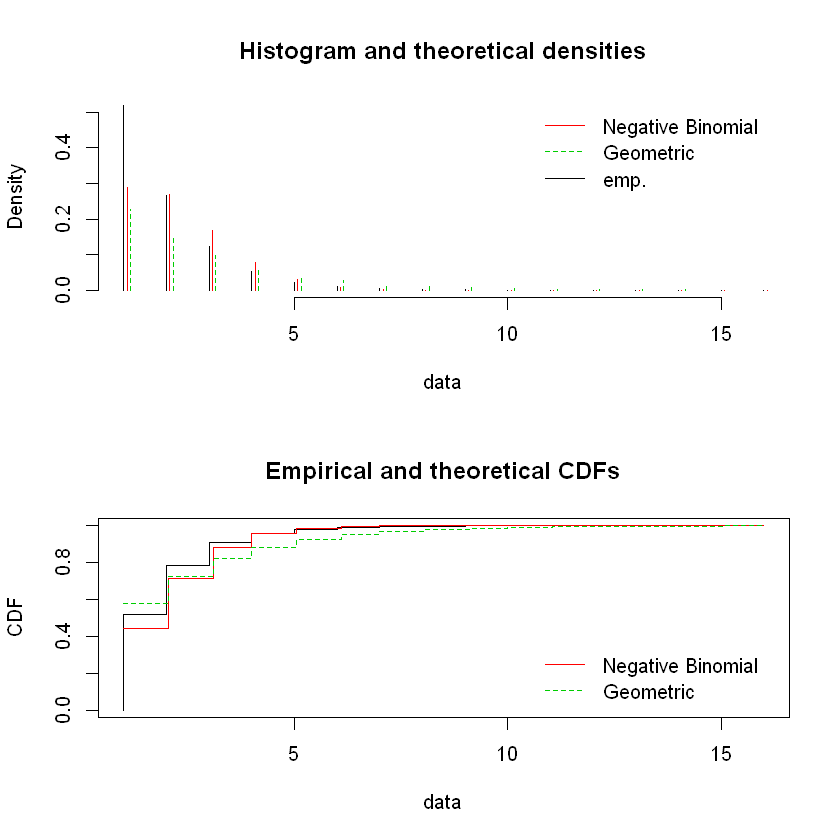

In [495]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(LOfd_NB_dDec, LOfd_GE_dDec), legendtext=plot.legend )

In [496]:
LOstatRes <- gofstat( list(LOfd_NB_dDec, LOfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [497]:
print( LOstatRes )

Chi-squared statistic:  63635.13 167487.2 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    527956           452965.35940      587479.54
<= 2    272350           274334.06103      150647.11
<= 3    123817           170256.96284       98008.45
<= 4     53945            79248.55394       63762.63
<= 5     21880            29509.90759       41482.88
<= 6     10393             9157.20967       26988.06
<= 7      4352             2435.63232       17557.97
<= 9      3224              684.11647       18854.47
> 9        701               26.19675       13836.89

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           3117132   3772757
Bayesian Information Criterion           3117156   3772769


In [498]:
LOfdNB_dDec_pvalue <- LOstatRes$chisqpvalue[["Negative Binomial"]]

In [499]:
LOfdNB_dDec_p = LOfdNB_dDec_size / (LOfdNB_dDec_size + LOfdNB_dDec_mu)
cat("LOCA prob: ", LOfdNB_dDec_p)

LOCA prob:  0.9999998

In [500]:
# add to our tracking dataframe
LOMonDistDF[12, ] <- list( 12, dLODecMean, dLODecBNr, LOfdNB_dDec_p, LOfdNB_dDec_mu, LOfdNB_dDec_size,
                           LOfdNB_dDec_pvalue )

In [501]:
LOgf_dDec <- goodfit( dLODec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=LOfdNB_dDec_size, prob=LOfdNB_dDec_p) )

In [502]:
summary( LOgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                      X^2 df P(> X^2)
Pearson          737129.5 16        0
Likelihood Ratio 501824.8 15        0


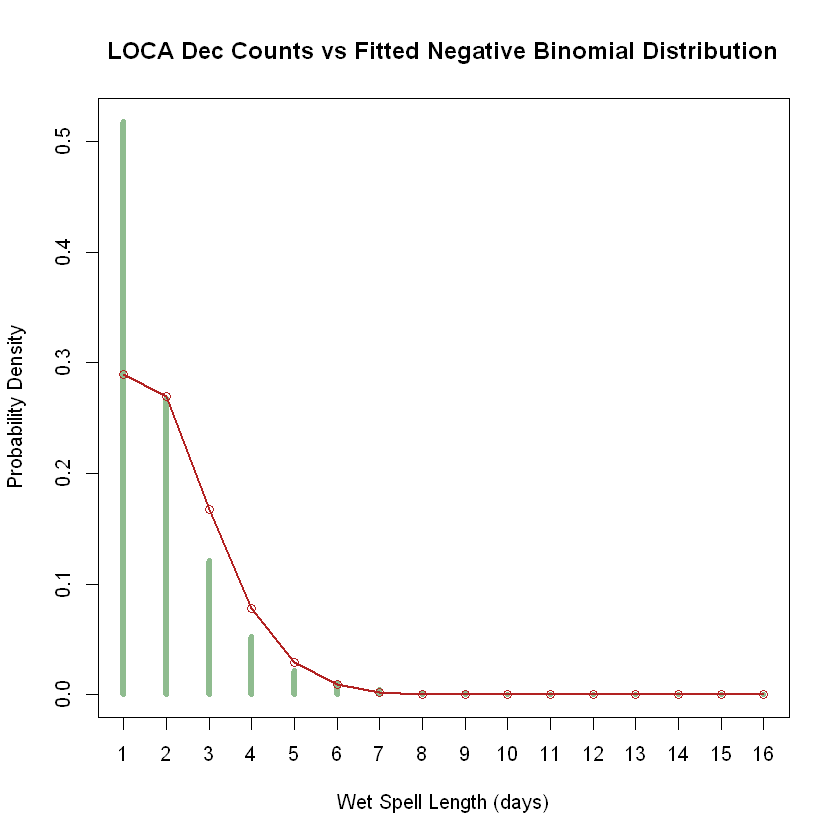

In [503]:
maxP <- max(dLODec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=LOfdNB_dDec_size, mu=LOfdNB_dDec_mu )
ttab <- table( dLODec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="LOCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

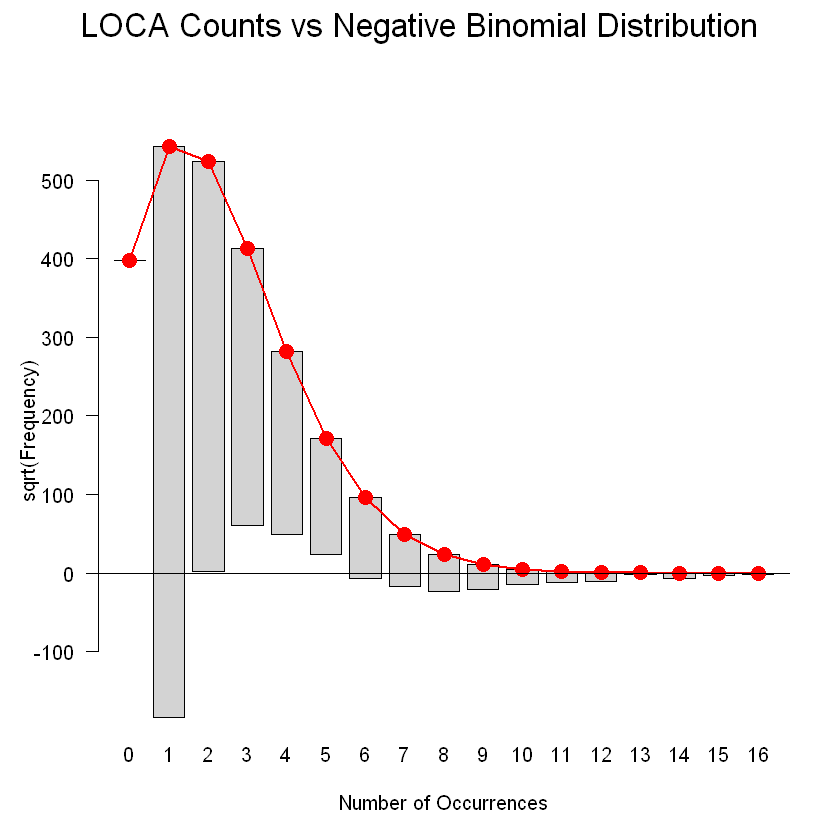

In [504]:
plot( LOgf_dDec, main="LOCA Counts vs Negative Binomial Distribution" )

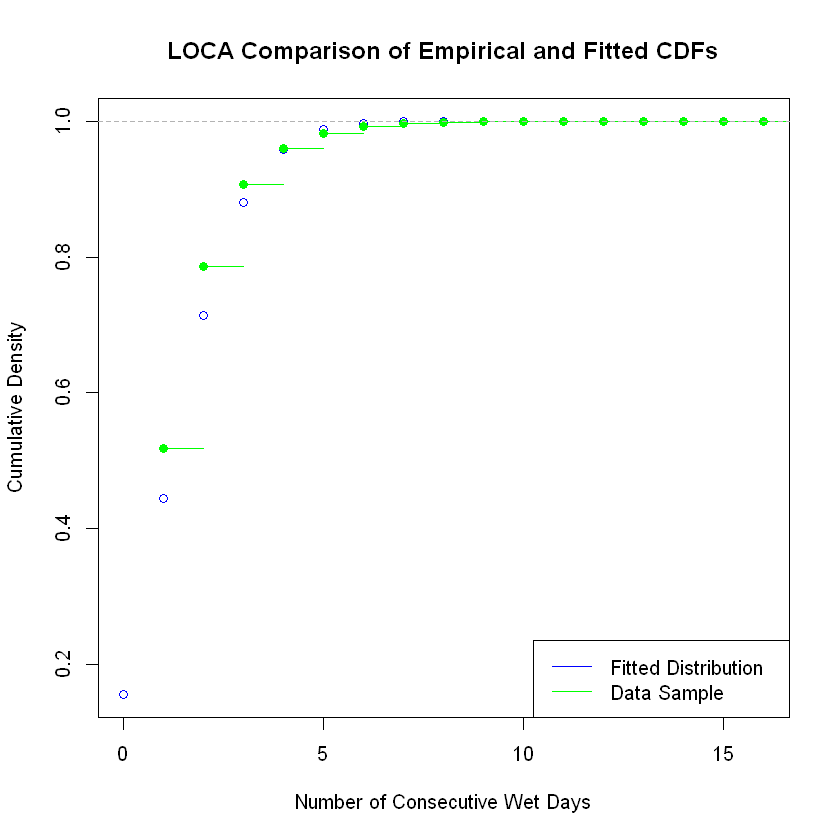

In [505]:
x <- seq(0,dLODecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=LOfdNB_dDec_mu, size=LOfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="LOCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dLODec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

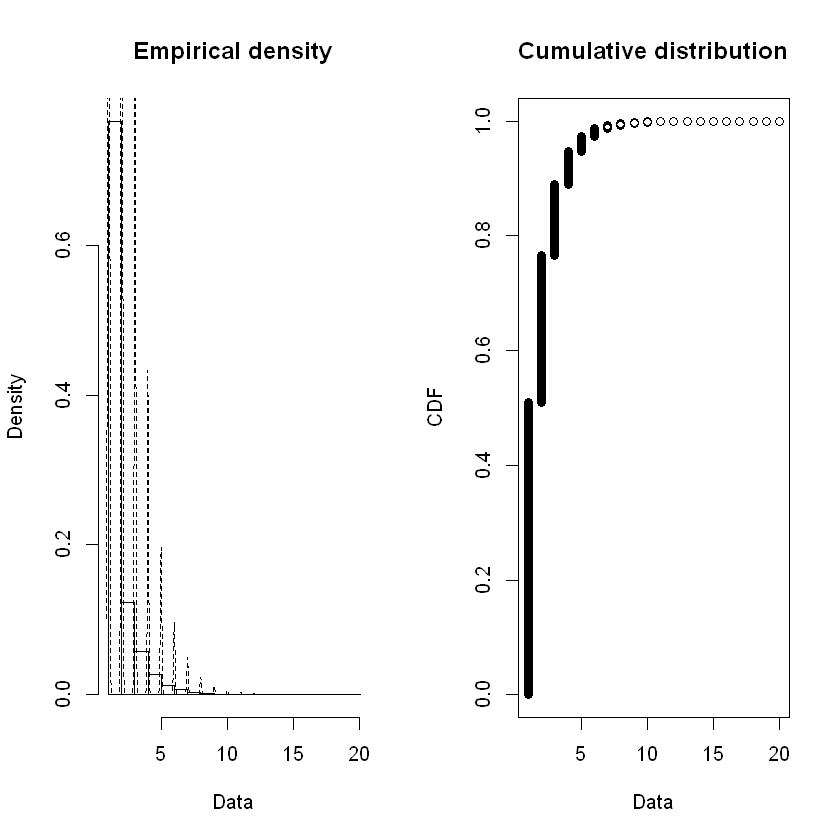

In [506]:
plotdist( dBCDec$Wet_Count, histo=TRUE, demp=TRUE )

In [507]:
BCfd_NB_dDec <- fitdist( dBCDec$Wet_Count, "nbinom" )
BCfd_GE_dDec <- fitdist( dBCDec$Wet_Count, "geom" )

In [508]:
summary( BCfd_NB_dDec )

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate  Std. Error
size 8.168403e+05         NaN
mu   1.941067e+00 0.001712152
Loglikelihood:  -1054307   AIC:  2108619   BIC:  2108641 
Correlation matrix:
     size  mu
size    1 NaN
mu    NaN   1


In [509]:
BCfdNB_dDec_size <- BCfd_NB_dDec$estimate[["size"]]
BCfdNB_dDec_mu <- BCfd_NB_dDec$estimate[["mu"]]
cat("BCCA Dec size: ", BCfdNB_dDec_size, "\n", "BCCA Dec mu: ", BCfdNB_dDec_mu, "\n")

BCCA Dec size:  816840.3 
 BCCA Dec mu:  1.941067 


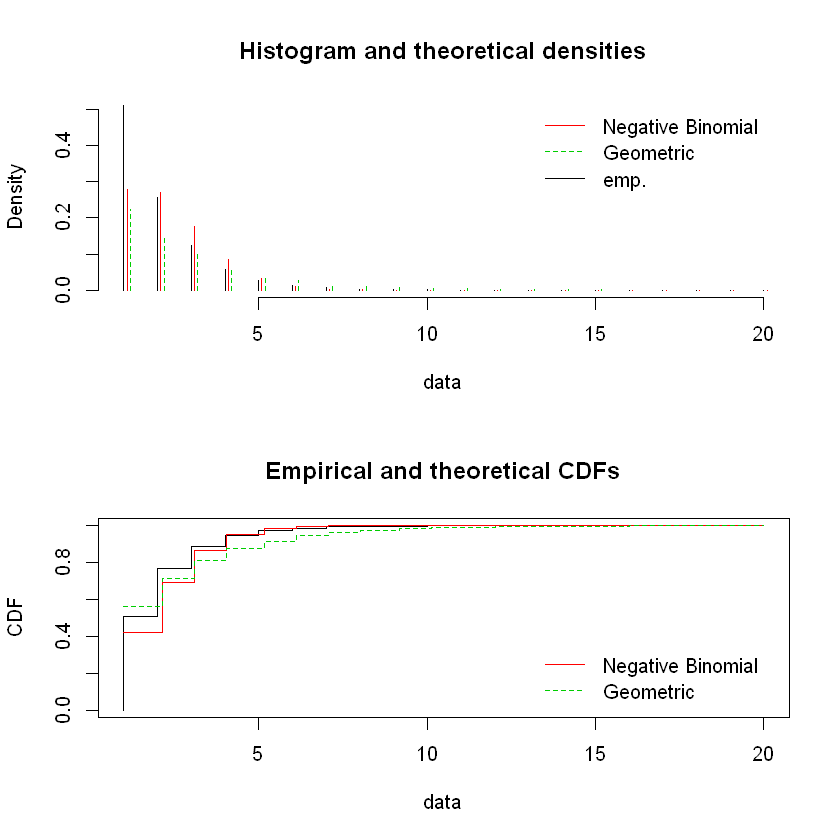

In [510]:
par(mfrow=c(2,1))
plot.legend <- c("Negative Binomial", "Geometric")
denscomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )
cdfcomp( list(BCfd_NB_dDec, BCfd_GE_dDec), legendtext=plot.legend )

In [511]:
BCstatRes <- gofstat( list(BCfd_NB_dDec, BCfd_GE_dDec), fitnames=c("Negative Binomial", "Geometric") )

In [512]:
print(BCstatRes)

Chi-squared statistic:  71876.85 91103.37 
Degree of freedom of the Chi-squared distribution:  6 7 
Chi-squared p-value:  0 0 
Chi-squared table:
     obscounts theo Negative Binomial theo Geometric
<= 1    337542            279574.5547     373768.745
<= 2    169728            179078.3373      98073.776
<= 3     81607            115867.7167      64725.915
<= 4     38204             56226.8352      42717.270
<= 5     17861             21828.0705      28192.188
<= 6      8525              7061.6525      18606.046
<= 7      4475              1958.1731      12279.463
<= 8      2056               475.1212       8104.098
> 8       2199               126.5388      15729.499

Goodness-of-fit criteria
                               Negative Binomial Geometric
Akaike's Information Criterion           2108619   2496878
Bayesian Information Criterion           2108641   2496889


In [513]:
BCfdNB_dDec_pvalue <- BCstatRes$chisqpvalue[["Negative Binomial"]]

In [514]:
BCfdNB_dDec_p = BCfdNB_dDec_size / (BCfdNB_dDec_size + BCfdNB_dDec_mu)
cat("BCCA prob: ", BCfdNB_dDec_p)

BCCA prob:  0.9999976

In [515]:
# add to our tracking dataframe
BCMonDistDF[12, ] <- list( 12, dBCDecMean, dBCDecBNr, BCfdNB_dDec_p, BCfdNB_dDec_mu, BCfdNB_dDec_size,
                           BCfdNB_dDec_pvalue )

In [516]:
BCgf_dDec <- goodfit( dBCDec$Wet_Count, type="nbinomial", method="ML", 
                    par=list(size=BCfdNB_dDec_size, prob=BCfdNB_dDec_p) )

In [517]:
summary( BCgf_dDec )


	 Goodness-of-fit test for nbinomial distribution

                          X^2 df P(> X^2)
Pearson          1.188281e+10 20        0
Likelihood Ratio 3.286336e+05 19        0


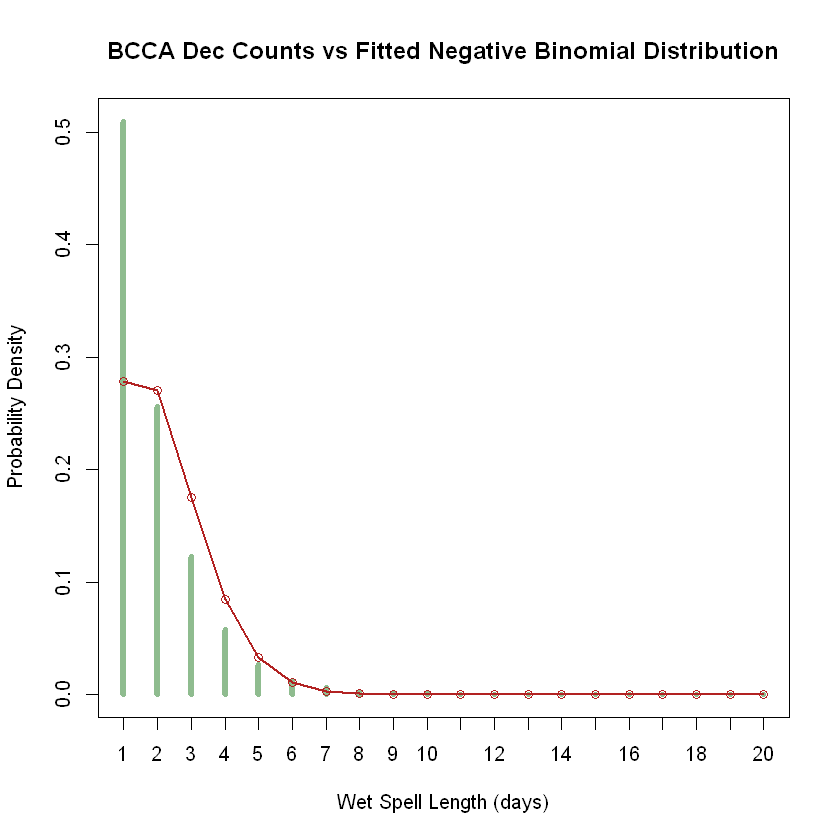

In [518]:
maxP <- max(dBCDec$Wet_Count)
xVals <- seq(1, maxP, 1)
pdVals <- dnbinom( xVals, size=BCfdNB_dDec_size, mu=BCfdNB_dDec_mu )
ttab <- table( dBCDec$Wet_Count )
pltTab <- ttab / sum( ttab )
plot( pltTab, type="h", lwd=5, col="darkseagreen", 
      xlab="Wet Spell Length (days)", ylab="Probability Density",
      main="BCCA Dec Counts vs Fitted Negative Binomial Distribution" )
lines( xVals, pdVals, lwd=2, lty=1, col="firebrick", add=TRUE)
points( xVals, pdVals, pch=1, col="firebrick", add=TRUE)

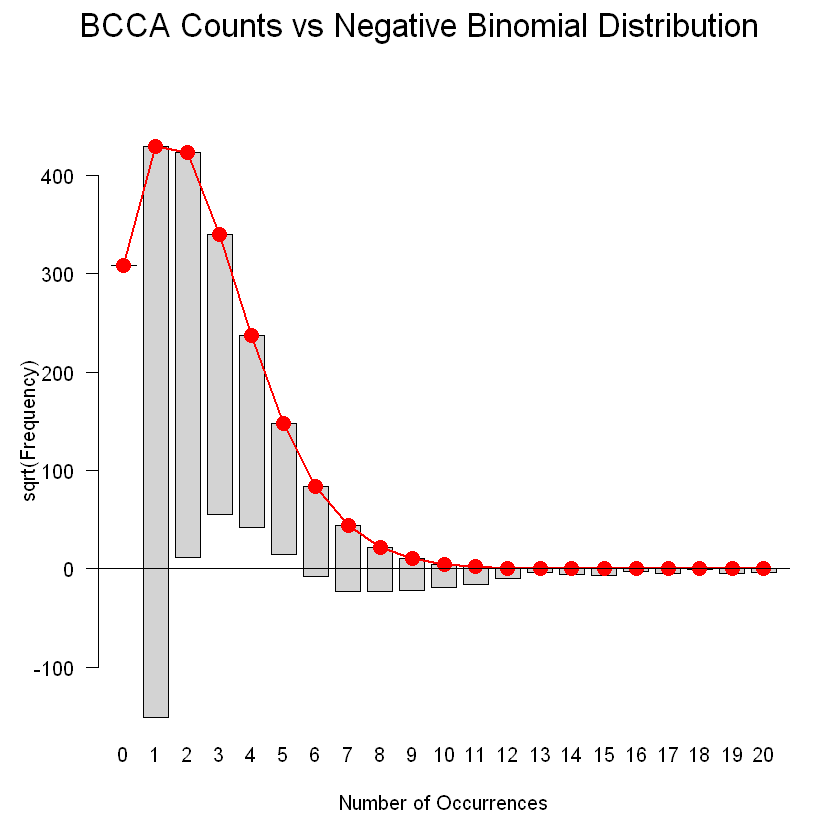

In [519]:
plot( BCgf_dDec, main="BCCA Counts vs Negative Binomial Distribution" )

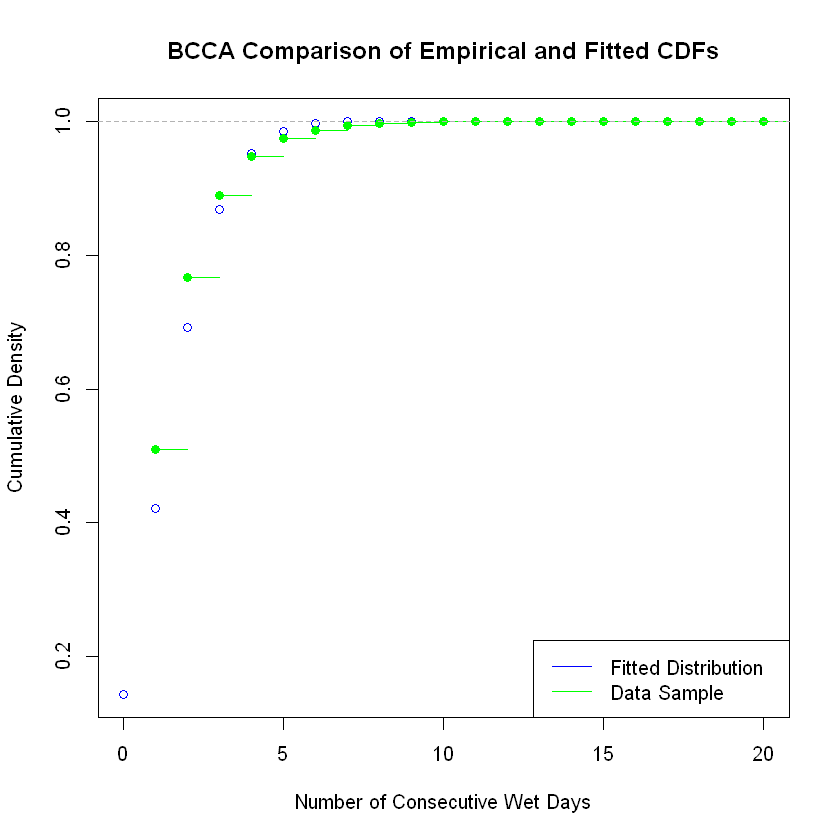

In [520]:
x <- seq(0,dBCDecMax,1)
plot.legend <- c("Fitted Distribution", "Data Sample" )
plot(x, pnbinom(x, mu=BCfdNB_dDec_mu, size=BCfdNB_dDec_size),
     xlab="Number of Consecutive Wet Days", ylab="Cumulative Density",
     col="blue", main="BCCA Comparison of Empirical and Fitted CDFs" )
plot(ecdf(dBCDec$Wet_Count), col="green", add=TRUE )
legend('bottomright', plot.legend, lty=1, col=c("blue", "green"))

Look at our summary DataFrame

In [521]:
print( LOMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu       ssize     sprob      tmu        tsize pvalue
     1 1.805530    6.178961 0.9999997 1.805460 6.860232e+06      0
     2 1.957849   10.937936 0.9999998 1.957796 8.404404e+06      0
     3 1.911754   13.391461 0.9999993 1.911560 2.648692e+06      0
     4 2.253991    8.143810 0.8603488 2.253877 1.388546e+01      0
     5 2.663848    3.027531 0.6528735 2.663717 5.009902e+00      0
     6 2.953033    2.461100 0.5694483 2.952240 3.904636e+00      0
     7 2.632299    2.489920 0.6183685 2.631861 4.264481e+00      0
     8 2.575638    2.641724 0.6436687 2.576441 4.654024e+00      0
     9 2.903666    2.504739 0.5840616 2.904208 4.078095e+00      0
    10 2.484517    6.261665 0.7927303 2.484525 9.502394e+00      0
    11 2.118293 4277.382779 0.9995508 2.118293 4.713861e+03      0
    12 1.861910    9.048589 0.9999998 1.861857 8.404404e+06      0


In [522]:
print( BCMonDistDF, quote=FALSE, row.names=FALSE )

 month      smu     ssize     sprob      tmu        tsize pvalue
     1 1.935704 23.771190 0.9999931 1.936275 2.810599e+05      0
     2 2.000013 67.468745 0.9999216 1.999859 2.551657e+04      0
     3 1.991812 58.728811 0.9816310 1.991626 1.064314e+02      0
     4 2.386219  2.528853 0.6697462 2.386152 4.839053e+00      0
     5 3.133151  1.597136 0.4551628 3.133523 2.617779e+00      0
     6 2.870725  1.592384 0.4902505 2.871017 2.761194e+00      0
     7 2.622756  1.604490 0.5329291 2.622343 2.992100e+00      0
     8 2.887377  1.383985 0.4726036 2.887485 2.587495e+00      0
     9 3.049854  1.879703 0.4904758 3.050594 2.936548e+00      0
    10 2.451186  3.529994 0.7012177 2.451298 5.752996e+00      0
    11 2.045882 79.778982 0.9843347 2.045936 1.285569e+02      0
    12 1.940931 32.457489 0.9999976 1.941067 8.168403e+05      0


### Output to a Spreadsheet

Output the stats and distribution fits to a spreadsheet

In [523]:
outputDF_xlsx <- createWorkbook()

In [524]:
LOsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Summary_Stats")
BCsumstat_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Summary_Stats")
LOmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="LOCA_Dist_Properties")
BCmondist_xlsx <- createSheet(wb=outputDF_xlsx, sheetName="BCCA_Dist_Properties")

In [525]:
addDataFrame( x=MonLOSumStatDF, sheet=LOsumstat_xlsx )
addDataFrame( x=MonBCSumStatDF, sheet=BCsumstat_xlsx )
addDataFrame( x=LOMonDistDF, sheet=LOmondist_xlsx )
addDataFrame( x=BCMonDistDF, sheet=BCmondist_xlsx )

In [526]:
saveWorkbook( outputDF_xlsx, file="CMIP5_Wet_RSummary_2011-2040.xlsx" )

## Check that No Grid Cell Outliers

Check that there are not any grid cell outliers. This part will take a long time so may need to split it out to a standalone R script. This also does not make sense so removed.

In [527]:
options(warn = oldw)